##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.8.0
    Uninstalling typing_extensions-4.8.0:


      Successfully uninstalled typing_extensions-4.8.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0


    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0


  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.2


    Uninstalling numpy-1.26.2:
      Successfully uninstalled numpy-1.26.2


  Attempting uninstall: keras
    Found existing installation: keras 2.15.0


    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4


  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.1.0
    Uninstalling google-auth-oauthlib-1.1.0:
      Successfully uninstalled google-auth-oauthlib-1.1.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:


      Successfully uninstalled tensorboard-2.15.1


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0


    Uninstalling tensorflow-2.15.0:


      Successfully uninstalled tensorflow-2.15.0


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install "tf-models-official==2.13.*"

  Preparing metadata (setup.py) ... -

 done


  Preparing metadata (setup.py) ... -

 \

 done


 \

 done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=341d645127c6e0117ece22d3d0cf609ae31b5d8470dbaca4c7fe72201d1f91a3
  Stored in directory: /home/kbuilder/.cache/pip/wheels/d2/ed/a5/da3a0cfb13373d1ace41cafa4f2467d858c55c52473ba72799


 \

 done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f05a7c94c4ad123296b890b126bbb6489b201dcd0f066cee647d2895f68a417f
  Stored in directory: /home/kbuilder/.cache/pip/wheels/e2/a5/92/2c80d1928733611c2747a9820e1324a6835524d9411510c142
Successfully built kaggle seqeval


In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

    8192/84125825 [..............................] - ETA: 0s

   40960/84125825 [..............................] - ETA: 3:14

   90112/84125825 [..............................] - ETA: 2:56

  155648/84125825 [..............................] - ETA: 2:33

  253952/84125825 [..............................] - ETA: 2:05

  352256/84125825 [..............................] - ETA: 1:52

  466944/84125825 [..............................] - ETA: 1:42

  598016/84125825 [..............................] - ETA: 1:32

  761856/84125825 [..............................] - ETA: 1:23

  942080/84125825 [..............................] - ETA: 1:15

 1155072/84125825 [..............................] - ETA: 1:08

 1384448/84125825 [..............................] - ETA: 1:02

 1646592/84125825 [..............................] - ETA: 57s 

 1941504/84125825 [..............................] - ETA: 52s

 2138112/84125825 [..............................] - ETA: 49s

 2433024/84125825 [..............................] - ETA: 46s

 2646016/84125825 [..............................] - ETA: 43s

 2973696/84125825 [>.............................] - ETA: 41s

 3252224/84125825 [>.............................] - ETA: 39s

 3661824/84125825 [>.............................] - ETA: 36s

 3989504/84125825 [>.............................] - ETA: 34s

 4481024/84125825 [>.............................] - ETA: 32s

 4923392/84125825 [>.............................] - ETA: 29s

 5513216/84125825 [>.............................] - ETA: 27s

 6021120/84125825 [=>............................] - ETA: 25s

 6676480/84125825 [=>............................] - ETA: 24s

 7282688/84125825 [=>............................] - ETA: 22s

 8052736/84125825 [=>............................] - ETA: 21s

 8773632/84125825 [==>...........................] - ETA: 19s

 9691136/84125825 [==>...........................] - ETA: 18s

10575872/84125825 [==>...........................] - ETA: 16s

11657216/84125825 [===>..........................] - ETA: 15s

12410880/84125825 [===>..........................] - ETA: 14s

13508608/84125825 [===>..........................] - ETA: 13s

14737408/84125825 [====>.........................] - ETA: 12s

15818752/84125825 [====>.........................] - ETA: 11s

17186816/84125825 [=====>........................] - ETA: 10s

18718720/84125825 [=====>........................] - ETA: 9s 

20127744/84125825 [======>.......................] - ETA: 9s

21831680/84125825 [======>.......................] - ETA: 8s

23617536/84125825 [=======>......................] - ETA: 7s

26075136/84125825 [========>.....................] - ETA: 6s

27254784/84125825 [========>.....................] - ETA: 6s

28336128/84125825 [=========>....................] - ETA: 6s

29573120/84125825 [=========>....................] - ETA: 6s

31023104/84125825 [==========>...................] - ETA: 5s

32481280/84125825 [==========>...................] - ETA: 5s

33595392/84125825 [==========>...................] - ETA: 5s

34889728/84125825 [===========>..................] - ETA: 5s

36372480/84125825 [===========>..................] - ETA: 4s

37871616/84125825 [============>.................] - ETA: 4s

39018496/84125825 [============>.................] - ETA: 4s

40361984/84125825 [=============>................] - ETA: 4s

41869312/84125825 [=============>................] - ETA: 3s

43393024/84125825 [==============>...............] - ETA: 3s

44474368/84125825 [==============>...............] - ETA: 3s

46407680/84125825 [===============>..............] - ETA: 3s

47243264/84125825 [===============>..............] - ETA: 3s

48209920/84125825 [================>.............] - ETA: 3s

49356800/84125825 [================>.............] - ETA: 2s

50438144/84125825 [================>.............] - ETA: 2s

51273728/84125825 [=================>............] - ETA: 2s

52273152/84125825 [=================>............] - ETA: 2s

53436416/84125825 [==================>...........] - ETA: 2s

54534144/84125825 [==================>...........] - ETA: 2s

55386112/84125825 [==================>...........] - ETA: 2s

56434688/84125825 [===================>..........] - ETA: 2s

57614336/84125825 [===================>..........] - ETA: 2s

58712064/84125825 [===================>..........] - ETA: 2s

59564032/84125825 [====================>.........] - ETA: 1s

60645376/84125825 [====================>.........] - ETA: 1s

61808640/84125825 [=====================>........] - ETA: 1s

62939136/84125825 [=====================>........] - ETA: 1s

63807488/84125825 [=====================>........] - ETA: 1s

64937984/84125825 [======================>.......] - ETA: 1s

66134016/84125825 [======================>.......] - ETA: 1s

67231744/84125825 [======================>.......] - ETA: 1s

68132864/84125825 [=======================>......] - ETA: 1s

69312512/84125825 [=======================>......] - ETA: 1s

70508544/84125825 [========================>.....] - ETA: 1s

71622656/84125825 [========================>.....] - ETA: 0s

72523776/84125825 [========================>.....] - ETA: 0s

73687040/84125825 [=========================>....] - ETA: 0s

74915840/84125825 [=========================>....] - ETA: 0s

76062720/84125825 [==========================>...] - ETA: 0s

77275136/84125825 [==========================>...] - ETA: 0s

78520320/84125825 [===========================>..] - ETA: 0s

79650816/84125825 [===========================>..] - ETA: 0s

80846848/84125825 [===========================>..] - ETA: 0s

82075648/84125825 [============================>.] - ETA: 0s

83222528/84125825 [============================>.] - ETA: 0s

84125825/84125825 [==============================] - 6s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.


Using 20000 files for training.


2023-11-17 13:38:17.555894: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 25000 files belonging to 2 classes.


Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

2023-11-17 13:38:20.000995: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.762629    0.99280983 -0.18611868  0.36673862  0.15233733  0.6550447
  0.9681154  -0.9486271   0.00216128 -0.9877732   0.06842692 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946346  0.3432128   0.33231518 ...  0.21300825  0.7102068
  -0.05771117]
 [-0.28742072  0.31981036 -0.23018576 ...  0.58455    -0.21329743
   0.72692114]
 [-0.66157067  0.68876773 -0.8743301  ...  0.1087725  -0.26173177
   0.47855407]
 ...
 [-0.2256118  -0.2892561  -0.0706445  ...  0.47566038  0.83277136
   0.40025333]
 [-0.2982428  -0.27473134 -0.05450517 ...  0.48849747  1.0955354
   0.18163396]
 [-0.44378242  0.00930811  0.07223688 ...  0.1729009   1.1833243
   0.07898017]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.21878408]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

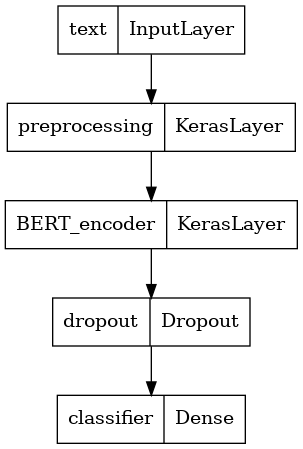

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


  1/625 [..............................] - ETA: 1:06:39 - loss: 0.6138 - binary_accuracy: 0.7188

  2/625 [..............................] - ETA: 12:09 - loss: 0.7931 - binary_accuracy: 0.5625  

  3/625 [..............................] - ETA: 12:03 - loss: 0.8492 - binary_accuracy: 0.5312

  4/625 [..............................] - ETA: 11:56 - loss: 0.8288 - binary_accuracy: 0.5547

  5/625 [..............................] - ETA: 11:49 - loss: 0.8454 - binary_accuracy: 0.5500

  6/625 [..............................] - ETA: 11:43 - loss: 0.8421 - binary_accuracy: 0.5573

  7/625 [..............................] - ETA: 11:41 - loss: 0.8200 - binary_accuracy: 0.5670

  8/625 [..............................] - ETA: 11:34 - loss: 0.8149 - binary_accuracy: 0.5742

  9/625 [..............................] - ETA: 11:28 - loss: 0.8197 - binary_accuracy: 0.5694

 10/625 [..............................] - ETA: 11:25 - loss: 0.8476 - binary_accuracy: 0.5469

 11/625 [..............................] - ETA: 11:19 - loss: 0.8632 - binary_accuracy: 0.5341

 12/625 [..............................] - ETA: 11:18 - loss: 0.8665 - binary_accuracy: 0.5182

 13/625 [..............................] - ETA: 11:13 - loss: 0.8686 - binary_accuracy: 0.5144

 14/625 [..............................] - ETA: 11:08 - loss: 0.8619 - binary_accuracy: 0.5179

 15/625 [..............................] - ETA: 11:05 - loss: 0.8549 - binary_accuracy: 0.5188

 16/625 [..............................] - ETA: 11:03 - loss: 0.8379 - binary_accuracy: 0.5312

 17/625 [..............................] - ETA: 11:01 - loss: 0.8449 - binary_accuracy: 0.5239

 18/625 [..............................] - ETA: 10:58 - loss: 0.8432 - binary_accuracy: 0.5260

 19/625 [..............................] - ETA: 10:57 - loss: 0.8375 - binary_accuracy: 0.5230

 20/625 [..............................] - ETA: 10:57 - loss: 0.8332 - binary_accuracy: 0.5219

 21/625 [>.............................] - ETA: 10:53 - loss: 0.8317 - binary_accuracy: 0.5223

 22/625 [>.............................] - ETA: 10:52 - loss: 0.8296 - binary_accuracy: 0.5199

 23/625 [>.............................] - ETA: 10:51 - loss: 0.8271 - binary_accuracy: 0.5177

 24/625 [>.............................] - ETA: 10:50 - loss: 0.8193 - binary_accuracy: 0.5260

 25/625 [>.............................] - ETA: 10:48 - loss: 0.8189 - binary_accuracy: 0.5200

 26/625 [>.............................] - ETA: 10:45 - loss: 0.8167 - binary_accuracy: 0.5192

 27/625 [>.............................] - ETA: 10:44 - loss: 0.8154 - binary_accuracy: 0.5139

 28/625 [>.............................] - ETA: 10:43 - loss: 0.8136 - binary_accuracy: 0.5145

 29/625 [>.............................] - ETA: 10:42 - loss: 0.8105 - binary_accuracy: 0.5140

 30/625 [>.............................] - ETA: 10:40 - loss: 0.8089 - binary_accuracy: 0.5104

 31/625 [>.............................] - ETA: 10:39 - loss: 0.8065 - binary_accuracy: 0.5111

 32/625 [>.............................] - ETA: 10:38 - loss: 0.8047 - binary_accuracy: 0.5107

 33/625 [>.............................] - ETA: 10:36 - loss: 0.8010 - binary_accuracy: 0.5142

 34/625 [>.............................] - ETA: 10:35 - loss: 0.7972 - binary_accuracy: 0.5156

 35/625 [>.............................] - ETA: 10:34 - loss: 0.7972 - binary_accuracy: 0.5170

 36/625 [>.............................] - ETA: 10:32 - loss: 0.7950 - binary_accuracy: 0.5174

 37/625 [>.............................] - ETA: 10:31 - loss: 0.7930 - binary_accuracy: 0.5169

 38/625 [>.............................] - ETA: 10:29 - loss: 0.7899 - binary_accuracy: 0.5173

 39/625 [>.............................] - ETA: 10:27 - loss: 0.7889 - binary_accuracy: 0.5168

 40/625 [>.............................] - ETA: 10:25 - loss: 0.7871 - binary_accuracy: 0.5156

 41/625 [>.............................] - ETA: 10:24 - loss: 0.7885 - binary_accuracy: 0.5160

 42/625 [=>............................] - ETA: 10:22 - loss: 0.7874 - binary_accuracy: 0.5171

 43/625 [=>............................] - ETA: 10:21 - loss: 0.7847 - binary_accuracy: 0.5196

 44/625 [=>............................] - ETA: 10:20 - loss: 0.7856 - binary_accuracy: 0.5149

 45/625 [=>............................] - ETA: 10:19 - loss: 0.7865 - binary_accuracy: 0.5132

 46/625 [=>............................] - ETA: 10:18 - loss: 0.7845 - binary_accuracy: 0.5149

 47/625 [=>............................] - ETA: 10:17 - loss: 0.7836 - binary_accuracy: 0.5146

 48/625 [=>............................] - ETA: 10:16 - loss: 0.7823 - binary_accuracy: 0.5150

 49/625 [=>............................] - ETA: 10:14 - loss: 0.7808 - binary_accuracy: 0.5153

 50/625 [=>............................] - ETA: 10:14 - loss: 0.7785 - binary_accuracy: 0.5169

 51/625 [=>............................] - ETA: 10:12 - loss: 0.7758 - binary_accuracy: 0.5196

 52/625 [=>............................] - ETA: 10:11 - loss: 0.7758 - binary_accuracy: 0.5192

 53/625 [=>............................] - ETA: 10:10 - loss: 0.7741 - binary_accuracy: 0.5183

 54/625 [=>............................] - ETA: 10:08 - loss: 0.7730 - binary_accuracy: 0.5191

 55/625 [=>............................] - ETA: 10:07 - loss: 0.7717 - binary_accuracy: 0.5182

 56/625 [=>............................] - ETA: 10:06 - loss: 0.7699 - binary_accuracy: 0.5190

 57/625 [=>............................] - ETA: 10:05 - loss: 0.7692 - binary_accuracy: 0.5186

 58/625 [=>............................] - ETA: 10:04 - loss: 0.7680 - binary_accuracy: 0.5172

 59/625 [=>............................] - ETA: 10:02 - loss: 0.7644 - binary_accuracy: 0.5196

 60/625 [=>............................] - ETA: 10:02 - loss: 0.7634 - binary_accuracy: 0.5214

 61/625 [=>............................] - ETA: 10:00 - loss: 0.7603 - binary_accuracy: 0.5236

 62/625 [=>............................] - ETA: 9:59 - loss: 0.7593 - binary_accuracy: 0.5242 

 63/625 [==>...........................] - ETA: 9:58 - loss: 0.7587 - binary_accuracy: 0.5243

 64/625 [==>...........................] - ETA: 9:56 - loss: 0.7571 - binary_accuracy: 0.5244

 65/625 [==>...........................] - ETA: 9:56 - loss: 0.7561 - binary_accuracy: 0.5260

 66/625 [==>...........................] - ETA: 9:54 - loss: 0.7543 - binary_accuracy: 0.5275

 67/625 [==>...........................] - ETA: 9:53 - loss: 0.7524 - binary_accuracy: 0.5280

 68/625 [==>...........................] - ETA: 9:52 - loss: 0.7510 - binary_accuracy: 0.5285

 69/625 [==>...........................] - ETA: 9:51 - loss: 0.7487 - binary_accuracy: 0.5294

 70/625 [==>...........................] - ETA: 9:50 - loss: 0.7479 - binary_accuracy: 0.5299

 71/625 [==>...........................] - ETA: 9:48 - loss: 0.7467 - binary_accuracy: 0.5312

 72/625 [==>...........................] - ETA: 9:47 - loss: 0.7459 - binary_accuracy: 0.5304

 73/625 [==>...........................] - ETA: 9:46 - loss: 0.7446 - binary_accuracy: 0.5312

 74/625 [==>...........................] - ETA: 9:45 - loss: 0.7431 - binary_accuracy: 0.5321

 75/625 [==>...........................] - ETA: 9:44 - loss: 0.7407 - binary_accuracy: 0.5312

 76/625 [==>...........................] - ETA: 9:43 - loss: 0.7403 - binary_accuracy: 0.5300

 77/625 [==>...........................] - ETA: 9:42 - loss: 0.7397 - binary_accuracy: 0.5292

 78/625 [==>...........................] - ETA: 9:41 - loss: 0.7385 - binary_accuracy: 0.5304

 79/625 [==>...........................] - ETA: 9:40 - loss: 0.7372 - binary_accuracy: 0.5324

 80/625 [==>...........................] - ETA: 9:39 - loss: 0.7366 - binary_accuracy: 0.5332

 81/625 [==>...........................] - ETA: 9:37 - loss: 0.7342 - binary_accuracy: 0.5351

 82/625 [==>...........................] - ETA: 9:36 - loss: 0.7330 - binary_accuracy: 0.5358

 83/625 [==>...........................] - ETA: 9:36 - loss: 0.7320 - binary_accuracy: 0.5377

 84/625 [===>..........................] - ETA: 9:34 - loss: 0.7300 - binary_accuracy: 0.5394

 85/625 [===>..........................] - ETA: 9:33 - loss: 0.7291 - binary_accuracy: 0.5408

 86/625 [===>..........................] - ETA: 9:31 - loss: 0.7276 - binary_accuracy: 0.5440

 87/625 [===>..........................] - ETA: 9:30 - loss: 0.7255 - binary_accuracy: 0.5456

 88/625 [===>..........................] - ETA: 9:29 - loss: 0.7246 - binary_accuracy: 0.5472

 89/625 [===>..........................] - ETA: 9:28 - loss: 0.7249 - binary_accuracy: 0.5467

 90/625 [===>..........................] - ETA: 9:27 - loss: 0.7242 - binary_accuracy: 0.5465

 91/625 [===>..........................] - ETA: 9:26 - loss: 0.7236 - binary_accuracy: 0.5484

 92/625 [===>..........................] - ETA: 9:25 - loss: 0.7227 - binary_accuracy: 0.5493

 93/625 [===>..........................] - ETA: 9:23 - loss: 0.7218 - binary_accuracy: 0.5494

 94/625 [===>..........................] - ETA: 9:22 - loss: 0.7202 - binary_accuracy: 0.5515

 95/625 [===>..........................] - ETA: 9:21 - loss: 0.7192 - binary_accuracy: 0.5523

 96/625 [===>..........................] - ETA: 9:20 - loss: 0.7182 - binary_accuracy: 0.5547

 97/625 [===>..........................] - ETA: 9:19 - loss: 0.7168 - binary_accuracy: 0.5561

 98/625 [===>..........................] - ETA: 9:18 - loss: 0.7151 - binary_accuracy: 0.5558

 99/625 [===>..........................] - ETA: 9:16 - loss: 0.7142 - binary_accuracy: 0.5565

100/625 [===>..........................] - ETA: 9:15 - loss: 0.7132 - binary_accuracy: 0.5566

101/625 [===>..........................] - ETA: 9:14 - loss: 0.7131 - binary_accuracy: 0.5566

102/625 [===>..........................] - ETA: 9:13 - loss: 0.7119 - binary_accuracy: 0.5567

103/625 [===>..........................] - ETA: 9:12 - loss: 0.7105 - binary_accuracy: 0.5573

104/625 [===>..........................] - ETA: 9:11 - loss: 0.7090 - binary_accuracy: 0.5598

105/625 [====>.........................] - ETA: 9:10 - loss: 0.7085 - binary_accuracy: 0.5604

106/625 [====>.........................] - ETA: 9:09 - loss: 0.7072 - binary_accuracy: 0.5619

107/625 [====>.........................] - ETA: 9:08 - loss: 0.7064 - binary_accuracy: 0.5619

108/625 [====>.........................] - ETA: 9:07 - loss: 0.7052 - binary_accuracy: 0.5628

109/625 [====>.........................] - ETA: 9:06 - loss: 0.7041 - binary_accuracy: 0.5631

110/625 [====>.........................] - ETA: 9:05 - loss: 0.7040 - binary_accuracy: 0.5625

111/625 [====>.........................] - ETA: 9:04 - loss: 0.7032 - binary_accuracy: 0.5631

112/625 [====>.........................] - ETA: 9:03 - loss: 0.7025 - binary_accuracy: 0.5636

113/625 [====>.........................] - ETA: 9:02 - loss: 0.7015 - binary_accuracy: 0.5642

114/625 [====>.........................] - ETA: 9:01 - loss: 0.7016 - binary_accuracy: 0.5647

115/625 [====>.........................] - ETA: 8:59 - loss: 0.7011 - binary_accuracy: 0.5652

116/625 [====>.........................] - ETA: 8:58 - loss: 0.7012 - binary_accuracy: 0.5644

117/625 [====>.........................] - ETA: 8:57 - loss: 0.7003 - binary_accuracy: 0.5652

118/625 [====>.........................] - ETA: 8:56 - loss: 0.6995 - binary_accuracy: 0.5659

119/625 [====>.........................] - ETA: 8:55 - loss: 0.6978 - binary_accuracy: 0.5680

120/625 [====>.........................] - ETA: 8:54 - loss: 0.6975 - binary_accuracy: 0.5695

121/625 [====>.........................] - ETA: 8:53 - loss: 0.6974 - binary_accuracy: 0.5690

122/625 [====>.........................] - ETA: 8:52 - loss: 0.6968 - binary_accuracy: 0.5694

123/625 [====>.........................] - ETA: 8:51 - loss: 0.6966 - binary_accuracy: 0.5704

124/625 [====>.........................] - ETA: 8:50 - loss: 0.6958 - binary_accuracy: 0.5711

125/625 [=====>........................] - ETA: 8:49 - loss: 0.6949 - binary_accuracy: 0.5723

126/625 [=====>........................] - ETA: 8:48 - loss: 0.6941 - binary_accuracy: 0.5732

127/625 [=====>........................] - ETA: 8:47 - loss: 0.6927 - binary_accuracy: 0.5748

128/625 [=====>........................] - ETA: 8:46 - loss: 0.6910 - binary_accuracy: 0.5769

129/625 [=====>........................] - ETA: 8:45 - loss: 0.6908 - binary_accuracy: 0.5785

130/625 [=====>........................] - ETA: 8:44 - loss: 0.6904 - binary_accuracy: 0.5784

131/625 [=====>........................] - ETA: 8:43 - loss: 0.6896 - binary_accuracy: 0.5794

132/625 [=====>........................] - ETA: 8:42 - loss: 0.6883 - binary_accuracy: 0.5807

133/625 [=====>........................] - ETA: 8:41 - loss: 0.6875 - binary_accuracy: 0.5815

134/625 [=====>........................] - ETA: 8:40 - loss: 0.6872 - binary_accuracy: 0.5812

135/625 [=====>........................] - ETA: 8:39 - loss: 0.6862 - binary_accuracy: 0.5826

136/625 [=====>........................] - ETA: 8:38 - loss: 0.6848 - binary_accuracy: 0.5832

137/625 [=====>........................] - ETA: 8:37 - loss: 0.6831 - binary_accuracy: 0.5844

138/625 [=====>........................] - ETA: 8:36 - loss: 0.6818 - binary_accuracy: 0.5847

139/625 [=====>........................] - ETA: 8:35 - loss: 0.6806 - binary_accuracy: 0.5854

140/625 [=====>........................] - ETA: 8:34 - loss: 0.6806 - binary_accuracy: 0.5859

141/625 [=====>........................] - ETA: 8:33 - loss: 0.6792 - binary_accuracy: 0.5873

142/625 [=====>........................] - ETA: 8:32 - loss: 0.6779 - binary_accuracy: 0.5880

143/625 [=====>........................] - ETA: 8:30 - loss: 0.6772 - binary_accuracy: 0.5896

144/625 [=====>........................] - ETA: 8:29 - loss: 0.6767 - binary_accuracy: 0.5905

145/625 [=====>........................] - ETA: 8:28 - loss: 0.6758 - binary_accuracy: 0.5909

146/625 [======>.......................] - ETA: 8:27 - loss: 0.6750 - binary_accuracy: 0.5914

147/625 [======>.......................] - ETA: 8:26 - loss: 0.6739 - binary_accuracy: 0.5920

148/625 [======>.......................] - ETA: 8:25 - loss: 0.6732 - binary_accuracy: 0.5927

149/625 [======>.......................] - ETA: 8:24 - loss: 0.6722 - binary_accuracy: 0.5940

150/625 [======>.......................] - ETA: 8:23 - loss: 0.6713 - binary_accuracy: 0.5944

151/625 [======>.......................] - ETA: 8:22 - loss: 0.6705 - binary_accuracy: 0.5958

152/625 [======>.......................] - ETA: 8:21 - loss: 0.6699 - binary_accuracy: 0.5968

153/625 [======>.......................] - ETA: 8:20 - loss: 0.6686 - binary_accuracy: 0.5974

154/625 [======>.......................] - ETA: 8:19 - loss: 0.6679 - binary_accuracy: 0.5982

155/625 [======>.......................] - ETA: 8:17 - loss: 0.6669 - binary_accuracy: 0.5988

156/625 [======>.......................] - ETA: 8:16 - loss: 0.6651 - binary_accuracy: 0.6002

157/625 [======>.......................] - ETA: 8:15 - loss: 0.6644 - binary_accuracy: 0.6011

158/625 [======>.......................] - ETA: 8:14 - loss: 0.6642 - binary_accuracy: 0.6019

159/625 [======>.......................] - ETA: 8:13 - loss: 0.6630 - binary_accuracy: 0.6030

160/625 [======>.......................] - ETA: 8:12 - loss: 0.6618 - binary_accuracy: 0.6041

161/625 [======>.......................] - ETA: 8:11 - loss: 0.6601 - binary_accuracy: 0.6058

162/625 [======>.......................] - ETA: 8:10 - loss: 0.6596 - binary_accuracy: 0.6059

163/625 [======>.......................] - ETA: 8:09 - loss: 0.6587 - binary_accuracy: 0.6066

164/625 [======>.......................] - ETA: 8:08 - loss: 0.6581 - binary_accuracy: 0.6067

165/625 [======>.......................] - ETA: 8:06 - loss: 0.6572 - binary_accuracy: 0.6074

166/625 [======>.......................] - ETA: 8:05 - loss: 0.6570 - binary_accuracy: 0.6075

167/625 [=======>......................] - ETA: 8:04 - loss: 0.6558 - binary_accuracy: 0.6080

168/625 [=======>......................] - ETA: 8:03 - loss: 0.6553 - binary_accuracy: 0.6079

169/625 [=======>......................] - ETA: 8:02 - loss: 0.6536 - binary_accuracy: 0.6091

170/625 [=======>......................] - ETA: 8:01 - loss: 0.6523 - binary_accuracy: 0.6107

171/625 [=======>......................] - ETA: 8:00 - loss: 0.6520 - binary_accuracy: 0.6111

172/625 [=======>......................] - ETA: 7:59 - loss: 0.6503 - binary_accuracy: 0.6126

173/625 [=======>......................] - ETA: 7:58 - loss: 0.6495 - binary_accuracy: 0.6134

174/625 [=======>......................] - ETA: 7:57 - loss: 0.6482 - binary_accuracy: 0.6148

175/625 [=======>......................] - ETA: 7:55 - loss: 0.6474 - binary_accuracy: 0.6161

176/625 [=======>......................] - ETA: 7:55 - loss: 0.6469 - binary_accuracy: 0.6165

177/625 [=======>......................] - ETA: 7:54 - loss: 0.6459 - binary_accuracy: 0.6167

178/625 [=======>......................] - ETA: 7:52 - loss: 0.6452 - binary_accuracy: 0.6175

179/625 [=======>......................] - ETA: 7:51 - loss: 0.6441 - binary_accuracy: 0.6177

180/625 [=======>......................] - ETA: 7:50 - loss: 0.6432 - binary_accuracy: 0.6179

181/625 [=======>......................] - ETA: 7:49 - loss: 0.6426 - binary_accuracy: 0.6181

182/625 [=======>......................] - ETA: 7:48 - loss: 0.6425 - binary_accuracy: 0.6185

183/625 [=======>......................] - ETA: 7:47 - loss: 0.6424 - binary_accuracy: 0.6189

184/625 [=======>......................] - ETA: 7:46 - loss: 0.6419 - binary_accuracy: 0.6192

185/625 [=======>......................] - ETA: 7:45 - loss: 0.6401 - binary_accuracy: 0.6204

186/625 [=======>......................] - ETA: 7:44 - loss: 0.6389 - binary_accuracy: 0.6213

187/625 [=======>......................] - ETA: 7:43 - loss: 0.6377 - binary_accuracy: 0.6220

188/625 [========>.....................] - ETA: 7:42 - loss: 0.6363 - binary_accuracy: 0.6237

189/625 [========>.....................] - ETA: 7:40 - loss: 0.6353 - binary_accuracy: 0.6247

190/625 [========>.....................] - ETA: 7:39 - loss: 0.6355 - binary_accuracy: 0.6253

191/625 [========>.....................] - ETA: 7:38 - loss: 0.6341 - binary_accuracy: 0.6263

192/625 [========>.....................] - ETA: 7:37 - loss: 0.6332 - binary_accuracy: 0.6270

193/625 [========>.....................] - ETA: 7:36 - loss: 0.6331 - binary_accuracy: 0.6268

194/625 [========>.....................] - ETA: 7:35 - loss: 0.6328 - binary_accuracy: 0.6274

195/625 [========>.....................] - ETA: 7:34 - loss: 0.6321 - binary_accuracy: 0.6280

196/625 [========>.....................] - ETA: 7:33 - loss: 0.6323 - binary_accuracy: 0.6282

197/625 [========>.....................] - ETA: 7:32 - loss: 0.6318 - binary_accuracy: 0.6283

198/625 [========>.....................] - ETA: 7:30 - loss: 0.6313 - binary_accuracy: 0.6289

199/625 [========>.....................] - ETA: 7:29 - loss: 0.6311 - binary_accuracy: 0.6291

200/625 [========>.....................] - ETA: 7:28 - loss: 0.6301 - binary_accuracy: 0.6298

201/625 [========>.....................] - ETA: 7:27 - loss: 0.6301 - binary_accuracy: 0.6298

202/625 [========>.....................] - ETA: 7:26 - loss: 0.6287 - binary_accuracy: 0.6306

203/625 [========>.....................] - ETA: 7:25 - loss: 0.6281 - binary_accuracy: 0.6312

204/625 [========>.....................] - ETA: 7:24 - loss: 0.6272 - binary_accuracy: 0.6320

205/625 [========>.....................] - ETA: 7:23 - loss: 0.6266 - binary_accuracy: 0.6325

206/625 [========>.....................] - ETA: 7:22 - loss: 0.6259 - binary_accuracy: 0.6332

207/625 [========>.....................] - ETA: 7:21 - loss: 0.6259 - binary_accuracy: 0.6336

208/625 [========>.....................] - ETA: 7:20 - loss: 0.6255 - binary_accuracy: 0.6337

209/625 [=========>....................] - ETA: 7:19 - loss: 0.6243 - binary_accuracy: 0.6350

210/625 [=========>....................] - ETA: 7:18 - loss: 0.6241 - binary_accuracy: 0.6353

211/625 [=========>....................] - ETA: 7:17 - loss: 0.6233 - binary_accuracy: 0.6355

212/625 [=========>....................] - ETA: 7:16 - loss: 0.6229 - binary_accuracy: 0.6362

213/625 [=========>....................] - ETA: 7:15 - loss: 0.6219 - binary_accuracy: 0.6372

214/625 [=========>....................] - ETA: 7:13 - loss: 0.6211 - binary_accuracy: 0.6376

215/625 [=========>....................] - ETA: 7:12 - loss: 0.6209 - binary_accuracy: 0.6372

216/625 [=========>....................] - ETA: 7:11 - loss: 0.6204 - binary_accuracy: 0.6376

217/625 [=========>....................] - ETA: 7:10 - loss: 0.6195 - binary_accuracy: 0.6384

218/625 [=========>....................] - ETA: 7:09 - loss: 0.6181 - binary_accuracy: 0.6396

219/625 [=========>....................] - ETA: 7:08 - loss: 0.6178 - binary_accuracy: 0.6401

220/625 [=========>....................] - ETA: 7:07 - loss: 0.6171 - binary_accuracy: 0.6409

221/625 [=========>....................] - ETA: 7:06 - loss: 0.6161 - binary_accuracy: 0.6415

222/625 [=========>....................] - ETA: 7:05 - loss: 0.6152 - binary_accuracy: 0.6423

223/625 [=========>....................] - ETA: 7:04 - loss: 0.6147 - binary_accuracy: 0.6431

224/625 [=========>....................] - ETA: 7:03 - loss: 0.6144 - binary_accuracy: 0.6434

225/625 [=========>....................] - ETA: 7:02 - loss: 0.6139 - binary_accuracy: 0.6444

226/625 [=========>....................] - ETA: 7:01 - loss: 0.6127 - binary_accuracy: 0.6453

227/625 [=========>....................] - ETA: 7:00 - loss: 0.6117 - binary_accuracy: 0.6461

228/625 [=========>....................] - ETA: 6:59 - loss: 0.6108 - binary_accuracy: 0.6471

229/625 [=========>....................] - ETA: 6:58 - loss: 0.6104 - binary_accuracy: 0.6474

230/625 [==========>...................] - ETA: 6:56 - loss: 0.6096 - binary_accuracy: 0.6480

231/625 [==========>...................] - ETA: 6:55 - loss: 0.6085 - binary_accuracy: 0.6489

232/625 [==========>...................] - ETA: 6:54 - loss: 0.6073 - binary_accuracy: 0.6501

233/625 [==========>...................] - ETA: 6:53 - loss: 0.6062 - binary_accuracy: 0.6506

234/625 [==========>...................] - ETA: 6:52 - loss: 0.6057 - binary_accuracy: 0.6513

235/625 [==========>...................] - ETA: 6:51 - loss: 0.6047 - binary_accuracy: 0.6517

236/625 [==========>...................] - ETA: 6:50 - loss: 0.6048 - binary_accuracy: 0.6517

237/625 [==========>...................] - ETA: 6:49 - loss: 0.6041 - binary_accuracy: 0.6524

238/625 [==========>...................] - ETA: 6:48 - loss: 0.6028 - binary_accuracy: 0.6535

239/625 [==========>...................] - ETA: 6:47 - loss: 0.6029 - binary_accuracy: 0.6536

240/625 [==========>...................] - ETA: 6:46 - loss: 0.6021 - binary_accuracy: 0.6544

241/625 [==========>...................] - ETA: 6:45 - loss: 0.6016 - binary_accuracy: 0.6550

242/625 [==========>...................] - ETA: 6:44 - loss: 0.6005 - binary_accuracy: 0.6559

243/625 [==========>...................] - ETA: 6:43 - loss: 0.5998 - binary_accuracy: 0.6564

244/625 [==========>...................] - ETA: 6:41 - loss: 0.5992 - binary_accuracy: 0.6568

245/625 [==========>...................] - ETA: 6:40 - loss: 0.5985 - binary_accuracy: 0.6575

246/625 [==========>...................] - ETA: 6:39 - loss: 0.5978 - binary_accuracy: 0.6582

247/625 [==========>...................] - ETA: 6:38 - loss: 0.5972 - binary_accuracy: 0.6583

248/625 [==========>...................] - ETA: 6:37 - loss: 0.5971 - binary_accuracy: 0.6584

249/625 [==========>...................] - ETA: 6:36 - loss: 0.5963 - binary_accuracy: 0.6588

250/625 [===========>..................] - ETA: 6:35 - loss: 0.5958 - binary_accuracy: 0.6591

251/625 [===========>..................] - ETA: 6:34 - loss: 0.5958 - binary_accuracy: 0.6595

252/625 [===========>..................] - ETA: 6:33 - loss: 0.5948 - binary_accuracy: 0.6598

253/625 [===========>..................] - ETA: 6:32 - loss: 0.5943 - binary_accuracy: 0.6601

254/625 [===========>..................] - ETA: 6:31 - loss: 0.5938 - binary_accuracy: 0.6603

255/625 [===========>..................] - ETA: 6:30 - loss: 0.5930 - binary_accuracy: 0.6609

256/625 [===========>..................] - ETA: 6:29 - loss: 0.5937 - binary_accuracy: 0.6611

257/625 [===========>..................] - ETA: 6:28 - loss: 0.5930 - binary_accuracy: 0.6618

258/625 [===========>..................] - ETA: 6:27 - loss: 0.5923 - binary_accuracy: 0.6624

259/625 [===========>..................] - ETA: 6:26 - loss: 0.5920 - binary_accuracy: 0.6626

260/625 [===========>..................] - ETA: 6:24 - loss: 0.5914 - binary_accuracy: 0.6632

261/625 [===========>..................] - ETA: 6:23 - loss: 0.5904 - binary_accuracy: 0.6638

262/625 [===========>..................] - ETA: 6:22 - loss: 0.5896 - binary_accuracy: 0.6645

263/625 [===========>..................] - ETA: 6:21 - loss: 0.5901 - binary_accuracy: 0.6642

264/625 [===========>..................] - ETA: 6:20 - loss: 0.5898 - binary_accuracy: 0.6648

265/625 [===========>..................] - ETA: 6:19 - loss: 0.5885 - binary_accuracy: 0.6656

266/625 [===========>..................] - ETA: 6:18 - loss: 0.5877 - binary_accuracy: 0.6661

267/625 [===========>..................] - ETA: 6:17 - loss: 0.5868 - binary_accuracy: 0.6670

268/625 [===========>..................] - ETA: 6:16 - loss: 0.5863 - binary_accuracy: 0.6676

269/625 [===========>..................] - ETA: 6:15 - loss: 0.5858 - binary_accuracy: 0.6681

270/625 [===========>..................] - ETA: 6:14 - loss: 0.5851 - binary_accuracy: 0.6685

271/625 [============>.................] - ETA: 6:13 - loss: 0.5847 - binary_accuracy: 0.6688

272/625 [============>.................] - ETA: 6:12 - loss: 0.5843 - binary_accuracy: 0.6689

273/625 [============>.................] - ETA: 6:11 - loss: 0.5852 - binary_accuracy: 0.6685

274/625 [============>.................] - ETA: 6:10 - loss: 0.5851 - binary_accuracy: 0.6686

275/625 [============>.................] - ETA: 6:09 - loss: 0.5844 - binary_accuracy: 0.6691

276/625 [============>.................] - ETA: 6:08 - loss: 0.5838 - binary_accuracy: 0.6698

277/625 [============>.................] - ETA: 6:07 - loss: 0.5829 - binary_accuracy: 0.6705

278/625 [============>.................] - ETA: 6:06 - loss: 0.5821 - binary_accuracy: 0.6712

279/625 [============>.................] - ETA: 6:04 - loss: 0.5816 - binary_accuracy: 0.6716

280/625 [============>.................] - ETA: 6:03 - loss: 0.5812 - binary_accuracy: 0.6722

281/625 [============>.................] - ETA: 6:02 - loss: 0.5812 - binary_accuracy: 0.6725

282/625 [============>.................] - ETA: 6:01 - loss: 0.5810 - binary_accuracy: 0.6724

283/625 [============>.................] - ETA: 6:00 - loss: 0.5806 - binary_accuracy: 0.6726

284/625 [============>.................] - ETA: 5:59 - loss: 0.5797 - binary_accuracy: 0.6733

285/625 [============>.................] - ETA: 5:58 - loss: 0.5794 - binary_accuracy: 0.6734

286/625 [============>.................] - ETA: 5:57 - loss: 0.5794 - binary_accuracy: 0.6734

287/625 [============>.................] - ETA: 5:56 - loss: 0.5791 - binary_accuracy: 0.6738

288/625 [============>.................] - ETA: 5:55 - loss: 0.5794 - binary_accuracy: 0.6738

289/625 [============>.................] - ETA: 5:54 - loss: 0.5787 - binary_accuracy: 0.6744

290/625 [============>.................] - ETA: 5:53 - loss: 0.5783 - binary_accuracy: 0.6746

291/625 [============>.................] - ETA: 5:52 - loss: 0.5781 - binary_accuracy: 0.6744

292/625 [=============>................] - ETA: 5:51 - loss: 0.5779 - binary_accuracy: 0.6749

293/625 [=============>................] - ETA: 5:50 - loss: 0.5775 - binary_accuracy: 0.6752

294/625 [=============>................] - ETA: 5:49 - loss: 0.5772 - binary_accuracy: 0.6756

295/625 [=============>................] - ETA: 5:48 - loss: 0.5767 - binary_accuracy: 0.6757

296/625 [=============>................] - ETA: 5:46 - loss: 0.5763 - binary_accuracy: 0.6762

297/625 [=============>................] - ETA: 5:45 - loss: 0.5755 - binary_accuracy: 0.6768

298/625 [=============>................] - ETA: 5:44 - loss: 0.5745 - binary_accuracy: 0.6775

299/625 [=============>................] - ETA: 5:43 - loss: 0.5745 - binary_accuracy: 0.6776

300/625 [=============>................] - ETA: 5:42 - loss: 0.5740 - binary_accuracy: 0.6777

301/625 [=============>................] - ETA: 5:41 - loss: 0.5735 - binary_accuracy: 0.6783

302/625 [=============>................] - ETA: 5:40 - loss: 0.5734 - binary_accuracy: 0.6785

303/625 [=============>................] - ETA: 5:39 - loss: 0.5731 - binary_accuracy: 0.6787

304/625 [=============>................] - ETA: 5:38 - loss: 0.5725 - binary_accuracy: 0.6792

305/625 [=============>................] - ETA: 5:37 - loss: 0.5723 - binary_accuracy: 0.6792

306/625 [=============>................] - ETA: 5:36 - loss: 0.5722 - binary_accuracy: 0.6791

307/625 [=============>................] - ETA: 5:35 - loss: 0.5717 - binary_accuracy: 0.6795

308/625 [=============>................] - ETA: 5:34 - loss: 0.5719 - binary_accuracy: 0.6793

309/625 [=============>................] - ETA: 5:33 - loss: 0.5714 - binary_accuracy: 0.6795

310/625 [=============>................] - ETA: 5:32 - loss: 0.5706 - binary_accuracy: 0.6802

311/625 [=============>................] - ETA: 5:31 - loss: 0.5705 - binary_accuracy: 0.6805

312/625 [=============>................] - ETA: 5:30 - loss: 0.5701 - binary_accuracy: 0.6805

313/625 [==============>...............] - ETA: 5:29 - loss: 0.5697 - binary_accuracy: 0.6810

314/625 [==============>...............] - ETA: 5:28 - loss: 0.5689 - binary_accuracy: 0.6817

315/625 [==============>...............] - ETA: 5:26 - loss: 0.5681 - binary_accuracy: 0.6821

316/625 [==============>...............] - ETA: 5:25 - loss: 0.5675 - binary_accuracy: 0.6825

317/625 [==============>...............] - ETA: 5:24 - loss: 0.5668 - binary_accuracy: 0.6829

318/625 [==============>...............] - ETA: 5:23 - loss: 0.5664 - binary_accuracy: 0.6833

319/625 [==============>...............] - ETA: 5:22 - loss: 0.5658 - binary_accuracy: 0.6837

320/625 [==============>...............] - ETA: 5:21 - loss: 0.5656 - binary_accuracy: 0.6837

321/625 [==============>...............] - ETA: 5:20 - loss: 0.5656 - binary_accuracy: 0.6840

322/625 [==============>...............] - ETA: 5:19 - loss: 0.5656 - binary_accuracy: 0.6841

323/625 [==============>...............] - ETA: 5:18 - loss: 0.5646 - binary_accuracy: 0.6848

324/625 [==============>...............] - ETA: 5:17 - loss: 0.5640 - binary_accuracy: 0.6851

325/625 [==============>...............] - ETA: 5:16 - loss: 0.5642 - binary_accuracy: 0.6851

326/625 [==============>...............] - ETA: 5:15 - loss: 0.5638 - binary_accuracy: 0.6857

327/625 [==============>...............] - ETA: 5:14 - loss: 0.5632 - binary_accuracy: 0.6861

328/625 [==============>...............] - ETA: 5:13 - loss: 0.5627 - binary_accuracy: 0.6865

329/625 [==============>...............] - ETA: 5:12 - loss: 0.5622 - binary_accuracy: 0.6872

330/625 [==============>...............] - ETA: 5:11 - loss: 0.5615 - binary_accuracy: 0.6876

331/625 [==============>...............] - ETA: 5:10 - loss: 0.5614 - binary_accuracy: 0.6877

332/625 [==============>...............] - ETA: 5:09 - loss: 0.5609 - binary_accuracy: 0.6879

333/625 [==============>...............] - ETA: 5:08 - loss: 0.5615 - binary_accuracy: 0.6875

334/625 [===============>..............] - ETA: 5:07 - loss: 0.5614 - binary_accuracy: 0.6875

335/625 [===============>..............] - ETA: 5:05 - loss: 0.5610 - binary_accuracy: 0.6876

336/625 [===============>..............] - ETA: 5:04 - loss: 0.5609 - binary_accuracy: 0.6879

337/625 [===============>..............] - ETA: 5:03 - loss: 0.5607 - binary_accuracy: 0.6881

338/625 [===============>..............] - ETA: 5:02 - loss: 0.5606 - binary_accuracy: 0.6883

339/625 [===============>..............] - ETA: 5:01 - loss: 0.5603 - binary_accuracy: 0.6888

340/625 [===============>..............] - ETA: 5:00 - loss: 0.5598 - binary_accuracy: 0.6892

341/625 [===============>..............] - ETA: 4:59 - loss: 0.5596 - binary_accuracy: 0.6898

342/625 [===============>..............] - ETA: 4:58 - loss: 0.5590 - binary_accuracy: 0.6903

343/625 [===============>..............] - ETA: 4:57 - loss: 0.5586 - binary_accuracy: 0.6907

344/625 [===============>..............] - ETA: 4:56 - loss: 0.5576 - binary_accuracy: 0.6915

345/625 [===============>..............] - ETA: 4:55 - loss: 0.5579 - binary_accuracy: 0.6913

346/625 [===============>..............] - ETA: 4:54 - loss: 0.5584 - binary_accuracy: 0.6912

347/625 [===============>..............] - ETA: 4:53 - loss: 0.5579 - binary_accuracy: 0.6916

348/625 [===============>..............] - ETA: 4:52 - loss: 0.5576 - binary_accuracy: 0.6921

349/625 [===============>..............] - ETA: 4:50 - loss: 0.5575 - binary_accuracy: 0.6925

350/625 [===============>..............] - ETA: 4:49 - loss: 0.5574 - binary_accuracy: 0.6927

351/625 [===============>..............] - ETA: 4:48 - loss: 0.5568 - binary_accuracy: 0.6933

352/625 [===============>..............] - ETA: 4:47 - loss: 0.5566 - binary_accuracy: 0.6936

353/625 [===============>..............] - ETA: 4:46 - loss: 0.5568 - binary_accuracy: 0.6937

354/625 [===============>..............] - ETA: 4:45 - loss: 0.5560 - binary_accuracy: 0.6943

355/625 [================>.............] - ETA: 4:44 - loss: 0.5555 - binary_accuracy: 0.6945

356/625 [================>.............] - ETA: 4:43 - loss: 0.5550 - binary_accuracy: 0.6951

357/625 [================>.............] - ETA: 4:42 - loss: 0.5543 - binary_accuracy: 0.6955

358/625 [================>.............] - ETA: 4:41 - loss: 0.5535 - binary_accuracy: 0.6961

359/625 [================>.............] - ETA: 4:40 - loss: 0.5529 - binary_accuracy: 0.6964

360/625 [================>.............] - ETA: 4:39 - loss: 0.5525 - binary_accuracy: 0.6968

361/625 [================>.............] - ETA: 4:38 - loss: 0.5523 - binary_accuracy: 0.6968

362/625 [================>.............] - ETA: 4:37 - loss: 0.5518 - binary_accuracy: 0.6972

363/625 [================>.............] - ETA: 4:36 - loss: 0.5514 - binary_accuracy: 0.6974

364/625 [================>.............] - ETA: 4:34 - loss: 0.5514 - binary_accuracy: 0.6975

365/625 [================>.............] - ETA: 4:33 - loss: 0.5509 - binary_accuracy: 0.6979

366/625 [================>.............] - ETA: 4:32 - loss: 0.5503 - binary_accuracy: 0.6984

367/625 [================>.............] - ETA: 4:31 - loss: 0.5494 - binary_accuracy: 0.6989

368/625 [================>.............] - ETA: 4:30 - loss: 0.5490 - binary_accuracy: 0.6991

369/625 [================>.............] - ETA: 4:29 - loss: 0.5485 - binary_accuracy: 0.6994

370/625 [================>.............] - ETA: 4:28 - loss: 0.5483 - binary_accuracy: 0.6996

371/625 [================>.............] - ETA: 4:27 - loss: 0.5478 - binary_accuracy: 0.7000

372/625 [================>.............] - ETA: 4:26 - loss: 0.5475 - binary_accuracy: 0.7003

373/625 [================>.............] - ETA: 4:25 - loss: 0.5471 - binary_accuracy: 0.7006

374/625 [================>.............] - ETA: 4:24 - loss: 0.5470 - binary_accuracy: 0.7009

375/625 [=================>............] - ETA: 4:23 - loss: 0.5467 - binary_accuracy: 0.7011

376/625 [=================>............] - ETA: 4:22 - loss: 0.5465 - binary_accuracy: 0.7014

377/625 [=================>............] - ETA: 4:21 - loss: 0.5462 - binary_accuracy: 0.7015

378/625 [=================>............] - ETA: 4:20 - loss: 0.5457 - binary_accuracy: 0.7017

379/625 [=================>............] - ETA: 4:19 - loss: 0.5451 - binary_accuracy: 0.7021

380/625 [=================>............] - ETA: 4:18 - loss: 0.5449 - binary_accuracy: 0.7024

381/625 [=================>............] - ETA: 4:17 - loss: 0.5443 - binary_accuracy: 0.7027

382/625 [=================>............] - ETA: 4:15 - loss: 0.5436 - binary_accuracy: 0.7030

383/625 [=================>............] - ETA: 4:14 - loss: 0.5431 - binary_accuracy: 0.7032

384/625 [=================>............] - ETA: 4:13 - loss: 0.5431 - binary_accuracy: 0.7034

385/625 [=================>............] - ETA: 4:12 - loss: 0.5433 - binary_accuracy: 0.7034

386/625 [=================>............] - ETA: 4:11 - loss: 0.5430 - binary_accuracy: 0.7039

387/625 [=================>............] - ETA: 4:10 - loss: 0.5429 - binary_accuracy: 0.7041

388/625 [=================>............] - ETA: 4:09 - loss: 0.5428 - binary_accuracy: 0.7042

389/625 [=================>............] - ETA: 4:08 - loss: 0.5421 - binary_accuracy: 0.7047

390/625 [=================>............] - ETA: 4:07 - loss: 0.5417 - binary_accuracy: 0.7050

391/625 [=================>............] - ETA: 4:06 - loss: 0.5411 - binary_accuracy: 0.7055

392/625 [=================>............] - ETA: 4:05 - loss: 0.5409 - binary_accuracy: 0.7058

393/625 [=================>............] - ETA: 4:04 - loss: 0.5410 - binary_accuracy: 0.7059

394/625 [=================>............] - ETA: 4:03 - loss: 0.5403 - binary_accuracy: 0.7063

395/625 [=================>............] - ETA: 4:02 - loss: 0.5399 - binary_accuracy: 0.7066

396/625 [==================>...........] - ETA: 4:01 - loss: 0.5398 - binary_accuracy: 0.7068

397/625 [==================>...........] - ETA: 4:00 - loss: 0.5396 - binary_accuracy: 0.7069

398/625 [==================>...........] - ETA: 3:59 - loss: 0.5391 - binary_accuracy: 0.7074

399/625 [==================>...........] - ETA: 3:57 - loss: 0.5388 - binary_accuracy: 0.7076

400/625 [==================>...........] - ETA: 3:56 - loss: 0.5385 - binary_accuracy: 0.7079

401/625 [==================>...........] - ETA: 3:55 - loss: 0.5379 - binary_accuracy: 0.7081

402/625 [==================>...........] - ETA: 3:54 - loss: 0.5378 - binary_accuracy: 0.7083

403/625 [==================>...........] - ETA: 3:53 - loss: 0.5374 - binary_accuracy: 0.7084

404/625 [==================>...........] - ETA: 3:52 - loss: 0.5376 - binary_accuracy: 0.7085

405/625 [==================>...........] - ETA: 3:51 - loss: 0.5370 - binary_accuracy: 0.7088

406/625 [==================>...........] - ETA: 3:50 - loss: 0.5368 - binary_accuracy: 0.7090

407/625 [==================>...........] - ETA: 3:49 - loss: 0.5363 - binary_accuracy: 0.7092

408/625 [==================>...........] - ETA: 3:48 - loss: 0.5359 - binary_accuracy: 0.7095

409/625 [==================>...........] - ETA: 3:47 - loss: 0.5352 - binary_accuracy: 0.7100

410/625 [==================>...........] - ETA: 3:46 - loss: 0.5352 - binary_accuracy: 0.7102

411/625 [==================>...........] - ETA: 3:45 - loss: 0.5349 - binary_accuracy: 0.7105

412/625 [==================>...........] - ETA: 3:44 - loss: 0.5343 - binary_accuracy: 0.7108

413/625 [==================>...........] - ETA: 3:43 - loss: 0.5340 - binary_accuracy: 0.7110

414/625 [==================>...........] - ETA: 3:42 - loss: 0.5344 - binary_accuracy: 0.7110

415/625 [==================>...........] - ETA: 3:41 - loss: 0.5340 - binary_accuracy: 0.7113

416/625 [==================>...........] - ETA: 3:40 - loss: 0.5334 - binary_accuracy: 0.7116

417/625 [===================>..........] - ETA: 3:38 - loss: 0.5331 - binary_accuracy: 0.7117

418/625 [===================>..........] - ETA: 3:37 - loss: 0.5327 - binary_accuracy: 0.7120

419/625 [===================>..........] - ETA: 3:36 - loss: 0.5326 - binary_accuracy: 0.7120

420/625 [===================>..........] - ETA: 3:35 - loss: 0.5322 - binary_accuracy: 0.7123

421/625 [===================>..........] - ETA: 3:34 - loss: 0.5318 - binary_accuracy: 0.7126

422/625 [===================>..........] - ETA: 3:33 - loss: 0.5314 - binary_accuracy: 0.7128

423/625 [===================>..........] - ETA: 3:32 - loss: 0.5313 - binary_accuracy: 0.7129

424/625 [===================>..........] - ETA: 3:31 - loss: 0.5309 - binary_accuracy: 0.7134

425/625 [===================>..........] - ETA: 3:30 - loss: 0.5303 - binary_accuracy: 0.7136

426/625 [===================>..........] - ETA: 3:29 - loss: 0.5307 - binary_accuracy: 0.7135

427/625 [===================>..........] - ETA: 3:28 - loss: 0.5303 - binary_accuracy: 0.7137

428/625 [===================>..........] - ETA: 3:27 - loss: 0.5299 - binary_accuracy: 0.7140

429/625 [===================>..........] - ETA: 3:26 - loss: 0.5295 - binary_accuracy: 0.7144

430/625 [===================>..........] - ETA: 3:25 - loss: 0.5288 - binary_accuracy: 0.7147

431/625 [===================>..........] - ETA: 3:24 - loss: 0.5286 - binary_accuracy: 0.7150

432/625 [===================>..........] - ETA: 3:23 - loss: 0.5285 - binary_accuracy: 0.7152

433/625 [===================>..........] - ETA: 3:21 - loss: 0.5285 - binary_accuracy: 0.7154

434/625 [===================>..........] - ETA: 3:20 - loss: 0.5285 - binary_accuracy: 0.7156

435/625 [===================>..........] - ETA: 3:19 - loss: 0.5279 - binary_accuracy: 0.7159

436/625 [===================>..........] - ETA: 3:18 - loss: 0.5274 - binary_accuracy: 0.7164

437/625 [===================>..........] - ETA: 3:17 - loss: 0.5270 - binary_accuracy: 0.7166

438/625 [====================>.........] - ETA: 3:16 - loss: 0.5268 - binary_accuracy: 0.7168

439/625 [====================>.........] - ETA: 3:15 - loss: 0.5265 - binary_accuracy: 0.7172

440/625 [====================>.........] - ETA: 3:14 - loss: 0.5262 - binary_accuracy: 0.7173

441/625 [====================>.........] - ETA: 3:13 - loss: 0.5257 - binary_accuracy: 0.7175

442/625 [====================>.........] - ETA: 3:12 - loss: 0.5257 - binary_accuracy: 0.7174

443/625 [====================>.........] - ETA: 3:11 - loss: 0.5254 - binary_accuracy: 0.7176

444/625 [====================>.........] - ETA: 3:10 - loss: 0.5251 - binary_accuracy: 0.7178

445/625 [====================>.........] - ETA: 3:09 - loss: 0.5245 - binary_accuracy: 0.7180

446/625 [====================>.........] - ETA: 3:08 - loss: 0.5243 - binary_accuracy: 0.7183

447/625 [====================>.........] - ETA: 3:07 - loss: 0.5239 - binary_accuracy: 0.7185

448/625 [====================>.........] - ETA: 3:06 - loss: 0.5235 - binary_accuracy: 0.7187

449/625 [====================>.........] - ETA: 3:04 - loss: 0.5231 - binary_accuracy: 0.7190

450/625 [====================>.........] - ETA: 3:03 - loss: 0.5231 - binary_accuracy: 0.7194

451/625 [====================>.........] - ETA: 3:02 - loss: 0.5227 - binary_accuracy: 0.7197

452/625 [====================>.........] - ETA: 3:01 - loss: 0.5223 - binary_accuracy: 0.7197

453/625 [====================>.........] - ETA: 3:00 - loss: 0.5218 - binary_accuracy: 0.7201

454/625 [====================>.........] - ETA: 2:59 - loss: 0.5214 - binary_accuracy: 0.7204

455/625 [====================>.........] - ETA: 2:58 - loss: 0.5211 - binary_accuracy: 0.7205

456/625 [====================>.........] - ETA: 2:57 - loss: 0.5210 - binary_accuracy: 0.7208

457/625 [====================>.........] - ETA: 2:56 - loss: 0.5210 - binary_accuracy: 0.7207

458/625 [====================>.........] - ETA: 2:55 - loss: 0.5204 - binary_accuracy: 0.7211

459/625 [=====================>........] - ETA: 2:54 - loss: 0.5203 - binary_accuracy: 0.7211

460/625 [=====================>........] - ETA: 2:53 - loss: 0.5199 - binary_accuracy: 0.7215

461/625 [=====================>........] - ETA: 2:52 - loss: 0.5198 - binary_accuracy: 0.7217

462/625 [=====================>........] - ETA: 2:51 - loss: 0.5198 - binary_accuracy: 0.7219

463/625 [=====================>........] - ETA: 2:50 - loss: 0.5198 - binary_accuracy: 0.7219

464/625 [=====================>........] - ETA: 2:49 - loss: 0.5197 - binary_accuracy: 0.7221

465/625 [=====================>........] - ETA: 2:48 - loss: 0.5194 - binary_accuracy: 0.7224

466/625 [=====================>........] - ETA: 2:46 - loss: 0.5191 - binary_accuracy: 0.7224

467/625 [=====================>........] - ETA: 2:45 - loss: 0.5188 - binary_accuracy: 0.7225

468/625 [=====================>........] - ETA: 2:44 - loss: 0.5185 - binary_accuracy: 0.7227

469/625 [=====================>........] - ETA: 2:43 - loss: 0.5180 - binary_accuracy: 0.7231

470/625 [=====================>........] - ETA: 2:42 - loss: 0.5177 - binary_accuracy: 0.7233

471/625 [=====================>........] - ETA: 2:41 - loss: 0.5171 - binary_accuracy: 0.7237

472/625 [=====================>........] - ETA: 2:40 - loss: 0.5170 - binary_accuracy: 0.7237

473/625 [=====================>........] - ETA: 2:39 - loss: 0.5168 - binary_accuracy: 0.7240

474/625 [=====================>........] - ETA: 2:38 - loss: 0.5164 - binary_accuracy: 0.7240

475/625 [=====================>........] - ETA: 2:37 - loss: 0.5163 - binary_accuracy: 0.7240

476/625 [=====================>........] - ETA: 2:36 - loss: 0.5157 - binary_accuracy: 0.7243

477/625 [=====================>........] - ETA: 2:35 - loss: 0.5155 - binary_accuracy: 0.7243

478/625 [=====================>........] - ETA: 2:34 - loss: 0.5152 - binary_accuracy: 0.7243

479/625 [=====================>........] - ETA: 2:33 - loss: 0.5154 - binary_accuracy: 0.7244

480/625 [======================>.......] - ETA: 2:32 - loss: 0.5150 - binary_accuracy: 0.7247

481/625 [======================>.......] - ETA: 2:31 - loss: 0.5152 - binary_accuracy: 0.7248

482/625 [======================>.......] - ETA: 2:30 - loss: 0.5150 - binary_accuracy: 0.7250

483/625 [======================>.......] - ETA: 2:29 - loss: 0.5146 - binary_accuracy: 0.7250

484/625 [======================>.......] - ETA: 2:27 - loss: 0.5141 - binary_accuracy: 0.7255

485/625 [======================>.......] - ETA: 2:26 - loss: 0.5138 - binary_accuracy: 0.7256

486/625 [======================>.......] - ETA: 2:25 - loss: 0.5133 - binary_accuracy: 0.7259

487/625 [======================>.......] - ETA: 2:24 - loss: 0.5129 - binary_accuracy: 0.7260

488/625 [======================>.......] - ETA: 2:23 - loss: 0.5124 - binary_accuracy: 0.7264

489/625 [======================>.......] - ETA: 2:22 - loss: 0.5118 - binary_accuracy: 0.7267

490/625 [======================>.......] - ETA: 2:21 - loss: 0.5117 - binary_accuracy: 0.7269

491/625 [======================>.......] - ETA: 2:20 - loss: 0.5112 - binary_accuracy: 0.7273

492/625 [======================>.......] - ETA: 2:19 - loss: 0.5107 - binary_accuracy: 0.7276

493/625 [======================>.......] - ETA: 2:18 - loss: 0.5103 - binary_accuracy: 0.7279

494/625 [======================>.......] - ETA: 2:17 - loss: 0.5099 - binary_accuracy: 0.7282

495/625 [======================>.......] - ETA: 2:16 - loss: 0.5094 - binary_accuracy: 0.7285

496/625 [======================>.......] - ETA: 2:15 - loss: 0.5090 - binary_accuracy: 0.7288

497/625 [======================>.......] - ETA: 2:14 - loss: 0.5089 - binary_accuracy: 0.7289

498/625 [======================>.......] - ETA: 2:13 - loss: 0.5088 - binary_accuracy: 0.7291

499/625 [======================>.......] - ETA: 2:12 - loss: 0.5084 - binary_accuracy: 0.7293

500/625 [=======================>......] - ETA: 2:11 - loss: 0.5080 - binary_accuracy: 0.7296

501/625 [=======================>......] - ETA: 2:10 - loss: 0.5076 - binary_accuracy: 0.7299

502/625 [=======================>......] - ETA: 2:09 - loss: 0.5072 - binary_accuracy: 0.7300

503/625 [=======================>......] - ETA: 2:07 - loss: 0.5072 - binary_accuracy: 0.7301

504/625 [=======================>......] - ETA: 2:06 - loss: 0.5069 - binary_accuracy: 0.7303

505/625 [=======================>......] - ETA: 2:05 - loss: 0.5065 - binary_accuracy: 0.7306

506/625 [=======================>......] - ETA: 2:04 - loss: 0.5066 - binary_accuracy: 0.7307

507/625 [=======================>......] - ETA: 2:03 - loss: 0.5063 - binary_accuracy: 0.7310

508/625 [=======================>......] - ETA: 2:02 - loss: 0.5061 - binary_accuracy: 0.7312

509/625 [=======================>......] - ETA: 2:01 - loss: 0.5058 - binary_accuracy: 0.7316

510/625 [=======================>......] - ETA: 2:00 - loss: 0.5053 - binary_accuracy: 0.7319

511/625 [=======================>......] - ETA: 1:59 - loss: 0.5048 - binary_accuracy: 0.7322

512/625 [=======================>......] - ETA: 1:58 - loss: 0.5045 - binary_accuracy: 0.7325

513/625 [=======================>......] - ETA: 1:57 - loss: 0.5044 - binary_accuracy: 0.7326

514/625 [=======================>......] - ETA: 1:56 - loss: 0.5046 - binary_accuracy: 0.7324

515/625 [=======================>......] - ETA: 1:55 - loss: 0.5042 - binary_accuracy: 0.7327

516/625 [=======================>......] - ETA: 1:54 - loss: 0.5037 - binary_accuracy: 0.7330

517/625 [=======================>......] - ETA: 1:53 - loss: 0.5037 - binary_accuracy: 0.7331

518/625 [=======================>......] - ETA: 1:52 - loss: 0.5037 - binary_accuracy: 0.7331

519/625 [=======================>......] - ETA: 1:51 - loss: 0.5035 - binary_accuracy: 0.7333

520/625 [=======================>......] - ETA: 1:50 - loss: 0.5033 - binary_accuracy: 0.7334

521/625 [========================>.....] - ETA: 1:49 - loss: 0.5030 - binary_accuracy: 0.7334

522/625 [========================>.....] - ETA: 1:47 - loss: 0.5027 - binary_accuracy: 0.7335

523/625 [========================>.....] - ETA: 1:46 - loss: 0.5025 - binary_accuracy: 0.7337

524/625 [========================>.....] - ETA: 1:45 - loss: 0.5023 - binary_accuracy: 0.7337

525/625 [========================>.....] - ETA: 1:44 - loss: 0.5023 - binary_accuracy: 0.7337

526/625 [========================>.....] - ETA: 1:43 - loss: 0.5020 - binary_accuracy: 0.7340

527/625 [========================>.....] - ETA: 1:42 - loss: 0.5021 - binary_accuracy: 0.7340

528/625 [========================>.....] - ETA: 1:41 - loss: 0.5023 - binary_accuracy: 0.7340

529/625 [========================>.....] - ETA: 1:40 - loss: 0.5021 - binary_accuracy: 0.7341

530/625 [========================>.....] - ETA: 1:39 - loss: 0.5017 - binary_accuracy: 0.7343

531/625 [========================>.....] - ETA: 1:38 - loss: 0.5017 - binary_accuracy: 0.7342

532/625 [========================>.....] - ETA: 1:37 - loss: 0.5016 - binary_accuracy: 0.7342

533/625 [========================>.....] - ETA: 1:36 - loss: 0.5015 - binary_accuracy: 0.7342

534/625 [========================>.....] - ETA: 1:35 - loss: 0.5015 - binary_accuracy: 0.7342

535/625 [========================>.....] - ETA: 1:34 - loss: 0.5012 - binary_accuracy: 0.7343

536/625 [========================>.....] - ETA: 1:33 - loss: 0.5011 - binary_accuracy: 0.7346

537/625 [========================>.....] - ETA: 1:32 - loss: 0.5010 - binary_accuracy: 0.7348

538/625 [========================>.....] - ETA: 1:31 - loss: 0.5010 - binary_accuracy: 0.7348

539/625 [========================>.....] - ETA: 1:30 - loss: 0.5010 - binary_accuracy: 0.7348

540/625 [========================>.....] - ETA: 1:29 - loss: 0.5009 - binary_accuracy: 0.7349

541/625 [========================>.....] - ETA: 1:28 - loss: 0.5008 - binary_accuracy: 0.7349

542/625 [=========================>....] - ETA: 1:26 - loss: 0.5005 - binary_accuracy: 0.7350

543/625 [=========================>....] - ETA: 1:25 - loss: 0.5006 - binary_accuracy: 0.7352

544/625 [=========================>....] - ETA: 1:24 - loss: 0.5008 - binary_accuracy: 0.7352

545/625 [=========================>....] - ETA: 1:23 - loss: 0.5004 - binary_accuracy: 0.7354

546/625 [=========================>....] - ETA: 1:22 - loss: 0.5001 - binary_accuracy: 0.7355

547/625 [=========================>....] - ETA: 1:21 - loss: 0.5002 - binary_accuracy: 0.7355

548/625 [=========================>....] - ETA: 1:20 - loss: 0.5001 - binary_accuracy: 0.7356

549/625 [=========================>....] - ETA: 1:19 - loss: 0.4999 - binary_accuracy: 0.7357

550/625 [=========================>....] - ETA: 1:18 - loss: 0.5000 - binary_accuracy: 0.7357

551/625 [=========================>....] - ETA: 1:17 - loss: 0.4997 - binary_accuracy: 0.7359

552/625 [=========================>....] - ETA: 1:16 - loss: 0.4997 - binary_accuracy: 0.7360

553/625 [=========================>....] - ETA: 1:15 - loss: 0.4996 - binary_accuracy: 0.7362

554/625 [=========================>....] - ETA: 1:14 - loss: 0.4992 - binary_accuracy: 0.7363

555/625 [=========================>....] - ETA: 1:13 - loss: 0.4987 - binary_accuracy: 0.7365

556/625 [=========================>....] - ETA: 1:12 - loss: 0.4989 - binary_accuracy: 0.7365

557/625 [=========================>....] - ETA: 1:11 - loss: 0.4985 - binary_accuracy: 0.7365

558/625 [=========================>....] - ETA: 1:10 - loss: 0.4985 - binary_accuracy: 0.7366

559/625 [=========================>....] - ETA: 1:09 - loss: 0.4983 - binary_accuracy: 0.7366

560/625 [=========================>....] - ETA: 1:08 - loss: 0.4979 - binary_accuracy: 0.7369

561/625 [=========================>....] - ETA: 1:07 - loss: 0.4980 - binary_accuracy: 0.7369

562/625 [=========================>....] - ETA: 1:06 - loss: 0.4979 - binary_accuracy: 0.7370

563/625 [==========================>...] - ETA: 1:04 - loss: 0.4978 - binary_accuracy: 0.7371

564/625 [==========================>...] - ETA: 1:03 - loss: 0.4976 - binary_accuracy: 0.7374

565/625 [==========================>...] - ETA: 1:02 - loss: 0.4974 - binary_accuracy: 0.7376

566/625 [==========================>...] - ETA: 1:01 - loss: 0.4972 - binary_accuracy: 0.7377

567/625 [==========================>...] - ETA: 1:00 - loss: 0.4972 - binary_accuracy: 0.7377

568/625 [==========================>...] - ETA: 59s - loss: 0.4969 - binary_accuracy: 0.7378 

569/625 [==========================>...] - ETA: 58s - loss: 0.4965 - binary_accuracy: 0.7380

570/625 [==========================>...] - ETA: 57s - loss: 0.4966 - binary_accuracy: 0.7380

571/625 [==========================>...] - ETA: 56s - loss: 0.4966 - binary_accuracy: 0.7380

572/625 [==========================>...] - ETA: 55s - loss: 0.4962 - binary_accuracy: 0.7383

573/625 [==========================>...] - ETA: 54s - loss: 0.4960 - binary_accuracy: 0.7384

574/625 [==========================>...] - ETA: 53s - loss: 0.4961 - binary_accuracy: 0.7383

575/625 [==========================>...] - ETA: 52s - loss: 0.4962 - binary_accuracy: 0.7383

576/625 [==========================>...] - ETA: 51s - loss: 0.4964 - binary_accuracy: 0.7382

577/625 [==========================>...] - ETA: 50s - loss: 0.4964 - binary_accuracy: 0.7381

578/625 [==========================>...] - ETA: 49s - loss: 0.4964 - binary_accuracy: 0.7382

579/625 [==========================>...] - ETA: 48s - loss: 0.4966 - binary_accuracy: 0.7383

580/625 [==========================>...] - ETA: 47s - loss: 0.4963 - binary_accuracy: 0.7385

581/625 [==========================>...] - ETA: 46s - loss: 0.4964 - binary_accuracy: 0.7384

582/625 [==========================>...] - ETA: 45s - loss: 0.4964 - binary_accuracy: 0.7386

583/625 [==========================>...] - ETA: 43s - loss: 0.4962 - binary_accuracy: 0.7385

584/625 [===========================>..] - ETA: 42s - loss: 0.4958 - binary_accuracy: 0.7387

585/625 [===========================>..] - ETA: 41s - loss: 0.4955 - binary_accuracy: 0.7388

586/625 [===========================>..] - ETA: 40s - loss: 0.4955 - binary_accuracy: 0.7388

587/625 [===========================>..] - ETA: 39s - loss: 0.4956 - binary_accuracy: 0.7387

588/625 [===========================>..] - ETA: 38s - loss: 0.4952 - binary_accuracy: 0.7389

589/625 [===========================>..] - ETA: 37s - loss: 0.4948 - binary_accuracy: 0.7391

590/625 [===========================>..] - ETA: 36s - loss: 0.4946 - binary_accuracy: 0.7392

591/625 [===========================>..] - ETA: 35s - loss: 0.4944 - binary_accuracy: 0.7395

592/625 [===========================>..] - ETA: 34s - loss: 0.4941 - binary_accuracy: 0.7397

593/625 [===========================>..] - ETA: 33s - loss: 0.4938 - binary_accuracy: 0.7399

594/625 [===========================>..] - ETA: 32s - loss: 0.4937 - binary_accuracy: 0.7401

595/625 [===========================>..] - ETA: 31s - loss: 0.4934 - binary_accuracy: 0.7403

596/625 [===========================>..] - ETA: 30s - loss: 0.4932 - binary_accuracy: 0.7404

597/625 [===========================>..] - ETA: 29s - loss: 0.4930 - binary_accuracy: 0.7405

598/625 [===========================>..] - ETA: 28s - loss: 0.4928 - binary_accuracy: 0.7405

599/625 [===========================>..] - ETA: 27s - loss: 0.4929 - binary_accuracy: 0.7404

600/625 [===========================>..] - ETA: 26s - loss: 0.4927 - binary_accuracy: 0.7405

601/625 [===========================>..] - ETA: 25s - loss: 0.4924 - binary_accuracy: 0.7407

602/625 [===========================>..] - ETA: 24s - loss: 0.4923 - binary_accuracy: 0.7407

603/625 [===========================>..] - ETA: 23s - loss: 0.4921 - binary_accuracy: 0.7409

604/625 [===========================>..] - ETA: 21s - loss: 0.4922 - binary_accuracy: 0.7409

605/625 [============================>.] - ETA: 20s - loss: 0.4922 - binary_accuracy: 0.7409

606/625 [============================>.] - ETA: 19s - loss: 0.4923 - binary_accuracy: 0.7409

607/625 [============================>.] - ETA: 18s - loss: 0.4918 - binary_accuracy: 0.7413

608/625 [============================>.] - ETA: 17s - loss: 0.4918 - binary_accuracy: 0.7414

609/625 [============================>.] - ETA: 16s - loss: 0.4913 - binary_accuracy: 0.7417

610/625 [============================>.] - ETA: 15s - loss: 0.4911 - binary_accuracy: 0.7417

611/625 [============================>.] - ETA: 14s - loss: 0.4909 - binary_accuracy: 0.7418

612/625 [============================>.] - ETA: 13s - loss: 0.4905 - binary_accuracy: 0.7419

613/625 [============================>.] - ETA: 12s - loss: 0.4906 - binary_accuracy: 0.7419

614/625 [============================>.] - ETA: 11s - loss: 0.4903 - binary_accuracy: 0.7421

615/625 [============================>.] - ETA: 10s - loss: 0.4901 - binary_accuracy: 0.7423

616/625 [============================>.] - ETA: 9s - loss: 0.4897 - binary_accuracy: 0.7426 

617/625 [============================>.] - ETA: 8s - loss: 0.4897 - binary_accuracy: 0.7427

618/625 [============================>.] - ETA: 7s - loss: 0.4896 - binary_accuracy: 0.7428

619/625 [============================>.] - ETA: 6s - loss: 0.4892 - binary_accuracy: 0.7431

620/625 [============================>.] - ETA: 5s - loss: 0.4891 - binary_accuracy: 0.7431

621/625 [============================>.] - ETA: 4s - loss: 0.4892 - binary_accuracy: 0.7429

622/625 [============================>.] - ETA: 3s - loss: 0.4889 - binary_accuracy: 0.7431

623/625 [============================>.] - ETA: 2s - loss: 0.4888 - binary_accuracy: 0.7431

624/625 [============================>.] - ETA: 1s - loss: 0.4887 - binary_accuracy: 0.7432

625/625 [==============================] - ETA: 0s - loss: 0.4885 - binary_accuracy: 0.7435

625/625 [==============================] - 703s 1s/step - loss: 0.4885 - binary_accuracy: 0.7435 - val_loss: 0.3795 - val_binary_accuracy: 0.8350


Epoch 2/5


  1/625 [..............................] - ETA: 10:41 - loss: 0.5702 - binary_accuracy: 0.7188

  2/625 [..............................] - ETA: 10:36 - loss: 0.4662 - binary_accuracy: 0.7812

  3/625 [..............................] - ETA: 10:22 - loss: 0.4510 - binary_accuracy: 0.7917

  4/625 [..............................] - ETA: 10:22 - loss: 0.4129 - binary_accuracy: 0.8047

  5/625 [..............................] - ETA: 10:21 - loss: 0.3955 - binary_accuracy: 0.8062

  6/625 [..............................] - ETA: 10:24 - loss: 0.3996 - binary_accuracy: 0.8125

  7/625 [..............................] - ETA: 10:22 - loss: 0.3891 - binary_accuracy: 0.8259

  8/625 [..............................] - ETA: 10:24 - loss: 0.4061 - binary_accuracy: 0.8203

  9/625 [..............................] - ETA: 10:24 - loss: 0.4232 - binary_accuracy: 0.8090

 10/625 [..............................] - ETA: 10:23 - loss: 0.4305 - binary_accuracy: 0.8000

 11/625 [..............................] - ETA: 10:25 - loss: 0.4308 - binary_accuracy: 0.7898

 12/625 [..............................] - ETA: 10:27 - loss: 0.4176 - binary_accuracy: 0.7995

 13/625 [..............................] - ETA: 10:26 - loss: 0.4177 - binary_accuracy: 0.8029

 14/625 [..............................] - ETA: 10:27 - loss: 0.4137 - binary_accuracy: 0.8080

 15/625 [..............................] - ETA: 10:29 - loss: 0.4051 - binary_accuracy: 0.8146

 16/625 [..............................] - ETA: 10:28 - loss: 0.4108 - binary_accuracy: 0.8145

 17/625 [..............................] - ETA: 10:26 - loss: 0.4061 - binary_accuracy: 0.8162

 18/625 [..............................] - ETA: 10:25 - loss: 0.4117 - binary_accuracy: 0.8142

 19/625 [..............................] - ETA: 10:26 - loss: 0.4268 - binary_accuracy: 0.8076

 20/625 [..............................] - ETA: 10:25 - loss: 0.4218 - binary_accuracy: 0.8094

 21/625 [>.............................] - ETA: 10:24 - loss: 0.4199 - binary_accuracy: 0.8095

 22/625 [>.............................] - ETA: 10:23 - loss: 0.4281 - binary_accuracy: 0.8026

 23/625 [>.............................] - ETA: 10:21 - loss: 0.4228 - binary_accuracy: 0.8030

 24/625 [>.............................] - ETA: 10:21 - loss: 0.4100 - binary_accuracy: 0.8086

 25/625 [>.............................] - ETA: 10:20 - loss: 0.4083 - binary_accuracy: 0.8075

 26/625 [>.............................] - ETA: 10:19 - loss: 0.4192 - binary_accuracy: 0.8029

 27/625 [>.............................] - ETA: 10:18 - loss: 0.4122 - binary_accuracy: 0.8056

 28/625 [>.............................] - ETA: 10:18 - loss: 0.4125 - binary_accuracy: 0.8080

 29/625 [>.............................] - ETA: 10:16 - loss: 0.4119 - binary_accuracy: 0.8093

 30/625 [>.............................] - ETA: 10:16 - loss: 0.4118 - binary_accuracy: 0.8094

 31/625 [>.............................] - ETA: 10:14 - loss: 0.4093 - binary_accuracy: 0.8105

 32/625 [>.............................] - ETA: 10:13 - loss: 0.4080 - binary_accuracy: 0.8125

 33/625 [>.............................] - ETA: 10:13 - loss: 0.4041 - binary_accuracy: 0.8144

 34/625 [>.............................] - ETA: 10:12 - loss: 0.4057 - binary_accuracy: 0.8143

 35/625 [>.............................] - ETA: 10:11 - loss: 0.4063 - binary_accuracy: 0.8143

 36/625 [>.............................] - ETA: 10:10 - loss: 0.4029 - binary_accuracy: 0.8151

 37/625 [>.............................] - ETA: 10:09 - loss: 0.4014 - binary_accuracy: 0.8176

 38/625 [>.............................] - ETA: 10:09 - loss: 0.4011 - binary_accuracy: 0.8166

 39/625 [>.............................] - ETA: 10:08 - loss: 0.4031 - binary_accuracy: 0.8157

 40/625 [>.............................] - ETA: 10:07 - loss: 0.3990 - binary_accuracy: 0.8180

 41/625 [>.............................] - ETA: 10:06 - loss: 0.3993 - binary_accuracy: 0.8194

 42/625 [=>............................] - ETA: 10:04 - loss: 0.3990 - binary_accuracy: 0.8192

 43/625 [=>............................] - ETA: 10:03 - loss: 0.4003 - binary_accuracy: 0.8169

 44/625 [=>............................] - ETA: 10:02 - loss: 0.4028 - binary_accuracy: 0.8139

 45/625 [=>............................] - ETA: 10:01 - loss: 0.4000 - binary_accuracy: 0.8160

 46/625 [=>............................] - ETA: 9:59 - loss: 0.3999 - binary_accuracy: 0.8173 

 47/625 [=>............................] - ETA: 9:58 - loss: 0.3982 - binary_accuracy: 0.8178

 48/625 [=>............................] - ETA: 9:57 - loss: 0.3986 - binary_accuracy: 0.8177

 49/625 [=>............................] - ETA: 9:55 - loss: 0.3965 - binary_accuracy: 0.8182

 50/625 [=>............................] - ETA: 9:55 - loss: 0.3965 - binary_accuracy: 0.8188

 51/625 [=>............................] - ETA: 9:53 - loss: 0.3984 - binary_accuracy: 0.8180

 52/625 [=>............................] - ETA: 9:52 - loss: 0.3964 - binary_accuracy: 0.8197

 53/625 [=>............................] - ETA: 9:51 - loss: 0.3984 - binary_accuracy: 0.8190

 54/625 [=>............................] - ETA: 9:50 - loss: 0.3966 - binary_accuracy: 0.8194

 55/625 [=>............................] - ETA: 9:49 - loss: 0.3964 - binary_accuracy: 0.8199

 56/625 [=>............................] - ETA: 9:48 - loss: 0.3981 - binary_accuracy: 0.8186

 57/625 [=>............................] - ETA: 9:47 - loss: 0.3979 - binary_accuracy: 0.8196

 58/625 [=>............................] - ETA: 9:45 - loss: 0.3949 - binary_accuracy: 0.8200

 59/625 [=>............................] - ETA: 9:45 - loss: 0.3937 - binary_accuracy: 0.8204

 60/625 [=>............................] - ETA: 9:44 - loss: 0.3955 - binary_accuracy: 0.8188

 61/625 [=>............................] - ETA: 9:43 - loss: 0.3924 - binary_accuracy: 0.8207

 62/625 [=>............................] - ETA: 9:41 - loss: 0.3920 - binary_accuracy: 0.8206

 63/625 [==>...........................] - ETA: 9:40 - loss: 0.3916 - binary_accuracy: 0.8199

 64/625 [==>...........................] - ETA: 9:39 - loss: 0.3924 - binary_accuracy: 0.8188

 65/625 [==>...........................] - ETA: 9:38 - loss: 0.3925 - binary_accuracy: 0.8197

 66/625 [==>...........................] - ETA: 9:37 - loss: 0.3946 - binary_accuracy: 0.8191

 67/625 [==>...........................] - ETA: 9:36 - loss: 0.3948 - binary_accuracy: 0.8186

 68/625 [==>...........................] - ETA: 9:35 - loss: 0.3939 - binary_accuracy: 0.8185

 69/625 [==>...........................] - ETA: 9:34 - loss: 0.3937 - binary_accuracy: 0.8175

 70/625 [==>...........................] - ETA: 9:33 - loss: 0.3931 - binary_accuracy: 0.8170

 71/625 [==>...........................] - ETA: 9:32 - loss: 0.3933 - binary_accuracy: 0.8156

 72/625 [==>...........................] - ETA: 9:32 - loss: 0.3922 - binary_accuracy: 0.8168

 73/625 [==>...........................] - ETA: 9:30 - loss: 0.3916 - binary_accuracy: 0.8168

 74/625 [==>...........................] - ETA: 9:29 - loss: 0.3910 - binary_accuracy: 0.8171

 75/625 [==>...........................] - ETA: 9:28 - loss: 0.3910 - binary_accuracy: 0.8171

 76/625 [==>...........................] - ETA: 9:27 - loss: 0.3891 - binary_accuracy: 0.8187

 77/625 [==>...........................] - ETA: 9:26 - loss: 0.3906 - binary_accuracy: 0.8186

 78/625 [==>...........................] - ETA: 9:25 - loss: 0.3908 - binary_accuracy: 0.8201

 79/625 [==>...........................] - ETA: 9:24 - loss: 0.3895 - binary_accuracy: 0.8208

 80/625 [==>...........................] - ETA: 9:24 - loss: 0.3873 - binary_accuracy: 0.8223

 81/625 [==>...........................] - ETA: 9:23 - loss: 0.3854 - binary_accuracy: 0.8233

 82/625 [==>...........................] - ETA: 9:22 - loss: 0.3848 - binary_accuracy: 0.8228

 83/625 [==>...........................] - ETA: 9:21 - loss: 0.3841 - binary_accuracy: 0.8230

 84/625 [===>..........................] - ETA: 9:20 - loss: 0.3836 - binary_accuracy: 0.8229

 85/625 [===>..........................] - ETA: 9:19 - loss: 0.3828 - binary_accuracy: 0.8232

 86/625 [===>..........................] - ETA: 9:18 - loss: 0.3813 - binary_accuracy: 0.8241

 87/625 [===>..........................] - ETA: 9:17 - loss: 0.3816 - binary_accuracy: 0.8236

 88/625 [===>..........................] - ETA: 9:16 - loss: 0.3834 - binary_accuracy: 0.8228

 89/625 [===>..........................] - ETA: 9:15 - loss: 0.3847 - binary_accuracy: 0.8213

 90/625 [===>..........................] - ETA: 9:14 - loss: 0.3874 - binary_accuracy: 0.8198

 91/625 [===>..........................] - ETA: 9:13 - loss: 0.3877 - binary_accuracy: 0.8197

 92/625 [===>..........................] - ETA: 9:12 - loss: 0.3855 - binary_accuracy: 0.8210

 93/625 [===>..........................] - ETA: 9:11 - loss: 0.3843 - binary_accuracy: 0.8212

 94/625 [===>..........................] - ETA: 9:10 - loss: 0.3853 - binary_accuracy: 0.8215

 95/625 [===>..........................] - ETA: 9:08 - loss: 0.3870 - binary_accuracy: 0.8207

 96/625 [===>..........................] - ETA: 9:08 - loss: 0.3871 - binary_accuracy: 0.8210

 97/625 [===>..........................] - ETA: 9:06 - loss: 0.3873 - binary_accuracy: 0.8215

 98/625 [===>..........................] - ETA: 9:05 - loss: 0.3869 - binary_accuracy: 0.8221

 99/625 [===>..........................] - ETA: 9:04 - loss: 0.3875 - binary_accuracy: 0.8223

100/625 [===>..........................] - ETA: 9:03 - loss: 0.3876 - binary_accuracy: 0.8222

101/625 [===>..........................] - ETA: 9:02 - loss: 0.3884 - binary_accuracy: 0.8218

102/625 [===>..........................] - ETA: 9:01 - loss: 0.3881 - binary_accuracy: 0.8223

103/625 [===>..........................] - ETA: 8:59 - loss: 0.3874 - binary_accuracy: 0.8225

104/625 [===>..........................] - ETA: 8:58 - loss: 0.3874 - binary_accuracy: 0.8230

105/625 [====>.........................] - ETA: 8:57 - loss: 0.3876 - binary_accuracy: 0.8229

106/625 [====>.........................] - ETA: 8:56 - loss: 0.3872 - binary_accuracy: 0.8231

107/625 [====>.........................] - ETA: 8:55 - loss: 0.3864 - binary_accuracy: 0.8227

108/625 [====>.........................] - ETA: 8:54 - loss: 0.3850 - binary_accuracy: 0.8232

109/625 [====>.........................] - ETA: 8:53 - loss: 0.3850 - binary_accuracy: 0.8231

110/625 [====>.........................] - ETA: 8:52 - loss: 0.3856 - binary_accuracy: 0.8230

111/625 [====>.........................] - ETA: 8:51 - loss: 0.3840 - binary_accuracy: 0.8238

112/625 [====>.........................] - ETA: 8:50 - loss: 0.3840 - binary_accuracy: 0.8239

113/625 [====>.........................] - ETA: 8:49 - loss: 0.3850 - binary_accuracy: 0.8236

114/625 [====>.........................] - ETA: 8:48 - loss: 0.3843 - binary_accuracy: 0.8240

115/625 [====>.........................] - ETA: 8:47 - loss: 0.3844 - binary_accuracy: 0.8242

116/625 [====>.........................] - ETA: 8:46 - loss: 0.3847 - binary_accuracy: 0.8246

117/625 [====>.........................] - ETA: 8:45 - loss: 0.3846 - binary_accuracy: 0.8243

118/625 [====>.........................] - ETA: 8:44 - loss: 0.3840 - binary_accuracy: 0.8242

119/625 [====>.........................] - ETA: 8:43 - loss: 0.3836 - binary_accuracy: 0.8248

120/625 [====>.........................] - ETA: 8:42 - loss: 0.3837 - binary_accuracy: 0.8245

121/625 [====>.........................] - ETA: 8:41 - loss: 0.3844 - binary_accuracy: 0.8241

122/625 [====>.........................] - ETA: 8:40 - loss: 0.3868 - binary_accuracy: 0.8227

123/625 [====>.........................] - ETA: 8:39 - loss: 0.3868 - binary_accuracy: 0.8227

124/625 [====>.........................] - ETA: 8:38 - loss: 0.3853 - binary_accuracy: 0.8231

125/625 [=====>........................] - ETA: 8:36 - loss: 0.3844 - binary_accuracy: 0.8235

126/625 [=====>........................] - ETA: 8:36 - loss: 0.3846 - binary_accuracy: 0.8229

127/625 [=====>........................] - ETA: 8:35 - loss: 0.3829 - binary_accuracy: 0.8238

128/625 [=====>........................] - ETA: 8:34 - loss: 0.3818 - binary_accuracy: 0.8245

129/625 [=====>........................] - ETA: 8:33 - loss: 0.3816 - binary_accuracy: 0.8249

130/625 [=====>........................] - ETA: 8:32 - loss: 0.3830 - binary_accuracy: 0.8243

131/625 [=====>........................] - ETA: 8:30 - loss: 0.3822 - binary_accuracy: 0.8249

132/625 [=====>........................] - ETA: 8:30 - loss: 0.3823 - binary_accuracy: 0.8246

133/625 [=====>........................] - ETA: 8:28 - loss: 0.3812 - binary_accuracy: 0.8250

134/625 [=====>........................] - ETA: 8:27 - loss: 0.3826 - binary_accuracy: 0.8246

135/625 [=====>........................] - ETA: 8:26 - loss: 0.3819 - binary_accuracy: 0.8248

136/625 [=====>........................] - ETA: 8:25 - loss: 0.3807 - binary_accuracy: 0.8256

137/625 [=====>........................] - ETA: 8:24 - loss: 0.3797 - binary_accuracy: 0.8264

138/625 [=====>........................] - ETA: 8:23 - loss: 0.3797 - binary_accuracy: 0.8261

139/625 [=====>........................] - ETA: 8:22 - loss: 0.3789 - binary_accuracy: 0.8264

140/625 [=====>........................] - ETA: 8:21 - loss: 0.3787 - binary_accuracy: 0.8266

141/625 [=====>........................] - ETA: 8:20 - loss: 0.3778 - binary_accuracy: 0.8271

142/625 [=====>........................] - ETA: 8:18 - loss: 0.3775 - binary_accuracy: 0.8272

143/625 [=====>........................] - ETA: 8:17 - loss: 0.3784 - binary_accuracy: 0.8269

144/625 [=====>........................] - ETA: 8:16 - loss: 0.3795 - binary_accuracy: 0.8262

145/625 [=====>........................] - ETA: 8:15 - loss: 0.3798 - binary_accuracy: 0.8261

146/625 [======>.......................] - ETA: 8:14 - loss: 0.3791 - binary_accuracy: 0.8260

147/625 [======>.......................] - ETA: 8:13 - loss: 0.3794 - binary_accuracy: 0.8255

148/625 [======>.......................] - ETA: 8:12 - loss: 0.3791 - binary_accuracy: 0.8256

149/625 [======>.......................] - ETA: 8:11 - loss: 0.3786 - binary_accuracy: 0.8261

150/625 [======>.......................] - ETA: 8:10 - loss: 0.3794 - binary_accuracy: 0.8258

151/625 [======>.......................] - ETA: 8:09 - loss: 0.3780 - binary_accuracy: 0.8270

152/625 [======>.......................] - ETA: 8:08 - loss: 0.3788 - binary_accuracy: 0.8271

153/625 [======>.......................] - ETA: 8:07 - loss: 0.3779 - binary_accuracy: 0.8276

154/625 [======>.......................] - ETA: 8:06 - loss: 0.3772 - binary_accuracy: 0.8277

155/625 [======>.......................] - ETA: 8:05 - loss: 0.3773 - binary_accuracy: 0.8276

156/625 [======>.......................] - ETA: 8:04 - loss: 0.3760 - binary_accuracy: 0.8283

157/625 [======>.......................] - ETA: 8:03 - loss: 0.3772 - binary_accuracy: 0.8278

158/625 [======>.......................] - ETA: 8:02 - loss: 0.3771 - binary_accuracy: 0.8281

159/625 [======>.......................] - ETA: 8:01 - loss: 0.3764 - binary_accuracy: 0.8288

160/625 [======>.......................] - ETA: 7:59 - loss: 0.3760 - binary_accuracy: 0.8287

161/625 [======>.......................] - ETA: 7:58 - loss: 0.3750 - binary_accuracy: 0.8292

162/625 [======>.......................] - ETA: 7:57 - loss: 0.3741 - binary_accuracy: 0.8297

163/625 [======>.......................] - ETA: 7:56 - loss: 0.3734 - binary_accuracy: 0.8298

164/625 [======>.......................] - ETA: 7:55 - loss: 0.3730 - binary_accuracy: 0.8300

165/625 [======>.......................] - ETA: 7:54 - loss: 0.3731 - binary_accuracy: 0.8301

166/625 [======>.......................] - ETA: 7:53 - loss: 0.3725 - binary_accuracy: 0.8304

167/625 [=======>......................] - ETA: 7:52 - loss: 0.3725 - binary_accuracy: 0.8303

168/625 [=======>......................] - ETA: 7:51 - loss: 0.3722 - binary_accuracy: 0.8305

169/625 [=======>......................] - ETA: 7:50 - loss: 0.3715 - binary_accuracy: 0.8310

170/625 [=======>......................] - ETA: 7:49 - loss: 0.3715 - binary_accuracy: 0.8314

171/625 [=======>......................] - ETA: 7:48 - loss: 0.3718 - binary_accuracy: 0.8311

172/625 [=======>......................] - ETA: 7:47 - loss: 0.3705 - binary_accuracy: 0.8316

173/625 [=======>......................] - ETA: 7:46 - loss: 0.3709 - binary_accuracy: 0.8316

174/625 [=======>......................] - ETA: 7:44 - loss: 0.3705 - binary_accuracy: 0.8319

175/625 [=======>......................] - ETA: 7:43 - loss: 0.3706 - binary_accuracy: 0.8321

176/625 [=======>......................] - ETA: 7:43 - loss: 0.3710 - binary_accuracy: 0.8322

177/625 [=======>......................] - ETA: 7:42 - loss: 0.3704 - binary_accuracy: 0.8323

178/625 [=======>......................] - ETA: 7:41 - loss: 0.3712 - binary_accuracy: 0.8316

179/625 [=======>......................] - ETA: 7:40 - loss: 0.3708 - binary_accuracy: 0.8315

180/625 [=======>......................] - ETA: 7:39 - loss: 0.3713 - binary_accuracy: 0.8311

181/625 [=======>......................] - ETA: 7:37 - loss: 0.3706 - binary_accuracy: 0.8310

182/625 [=======>......................] - ETA: 7:36 - loss: 0.3701 - binary_accuracy: 0.8310

183/625 [=======>......................] - ETA: 7:35 - loss: 0.3697 - binary_accuracy: 0.8313

184/625 [=======>......................] - ETA: 7:34 - loss: 0.3699 - binary_accuracy: 0.8315

185/625 [=======>......................] - ETA: 7:33 - loss: 0.3692 - binary_accuracy: 0.8318

186/625 [=======>......................] - ETA: 7:32 - loss: 0.3688 - binary_accuracy: 0.8322

187/625 [=======>......................] - ETA: 7:31 - loss: 0.3676 - binary_accuracy: 0.8329

188/625 [========>.....................] - ETA: 7:30 - loss: 0.3672 - binary_accuracy: 0.8334

189/625 [========>.....................] - ETA: 7:30 - loss: 0.3667 - binary_accuracy: 0.8340

190/625 [========>.....................] - ETA: 7:29 - loss: 0.3677 - binary_accuracy: 0.8340

191/625 [========>.....................] - ETA: 7:28 - loss: 0.3674 - binary_accuracy: 0.8346

192/625 [========>.....................] - ETA: 7:27 - loss: 0.3673 - binary_accuracy: 0.8346

193/625 [========>.....................] - ETA: 7:26 - loss: 0.3678 - binary_accuracy: 0.8344

194/625 [========>.....................] - ETA: 7:25 - loss: 0.3681 - binary_accuracy: 0.8339

195/625 [========>.....................] - ETA: 7:24 - loss: 0.3686 - binary_accuracy: 0.8340

196/625 [========>.....................] - ETA: 7:22 - loss: 0.3701 - binary_accuracy: 0.8334

197/625 [========>.....................] - ETA: 7:21 - loss: 0.3701 - binary_accuracy: 0.8330

198/625 [========>.....................] - ETA: 7:20 - loss: 0.3699 - binary_accuracy: 0.8330

199/625 [========>.....................] - ETA: 7:19 - loss: 0.3705 - binary_accuracy: 0.8324

200/625 [========>.....................] - ETA: 7:18 - loss: 0.3699 - binary_accuracy: 0.8327

201/625 [========>.....................] - ETA: 7:17 - loss: 0.3701 - binary_accuracy: 0.8324

202/625 [========>.....................] - ETA: 7:16 - loss: 0.3694 - binary_accuracy: 0.8328

203/625 [========>.....................] - ETA: 7:15 - loss: 0.3692 - binary_accuracy: 0.8327

204/625 [========>.....................] - ETA: 7:14 - loss: 0.3688 - binary_accuracy: 0.8329

205/625 [========>.....................] - ETA: 7:13 - loss: 0.3687 - binary_accuracy: 0.8329

206/625 [========>.....................] - ETA: 7:12 - loss: 0.3691 - binary_accuracy: 0.8330

207/625 [========>.....................] - ETA: 7:11 - loss: 0.3701 - binary_accuracy: 0.8324

208/625 [========>.....................] - ETA: 7:10 - loss: 0.3708 - binary_accuracy: 0.8323

209/625 [=========>....................] - ETA: 7:09 - loss: 0.3710 - binary_accuracy: 0.8327

210/625 [=========>....................] - ETA: 7:08 - loss: 0.3717 - binary_accuracy: 0.8323

211/625 [=========>....................] - ETA: 7:07 - loss: 0.3712 - binary_accuracy: 0.8326

212/625 [=========>....................] - ETA: 7:06 - loss: 0.3720 - binary_accuracy: 0.8325

213/625 [=========>....................] - ETA: 7:05 - loss: 0.3714 - binary_accuracy: 0.8330

214/625 [=========>....................] - ETA: 7:04 - loss: 0.3709 - binary_accuracy: 0.8329

215/625 [=========>....................] - ETA: 7:03 - loss: 0.3713 - binary_accuracy: 0.8326

216/625 [=========>....................] - ETA: 7:02 - loss: 0.3714 - binary_accuracy: 0.8325

217/625 [=========>....................] - ETA: 7:01 - loss: 0.3709 - binary_accuracy: 0.8325

218/625 [=========>....................] - ETA: 7:00 - loss: 0.3705 - binary_accuracy: 0.8326

219/625 [=========>....................] - ETA: 6:59 - loss: 0.3706 - binary_accuracy: 0.8323

220/625 [=========>....................] - ETA: 6:58 - loss: 0.3707 - binary_accuracy: 0.8322

221/625 [=========>....................] - ETA: 6:57 - loss: 0.3704 - binary_accuracy: 0.8322

222/625 [=========>....................] - ETA: 6:56 - loss: 0.3702 - binary_accuracy: 0.8323

223/625 [=========>....................] - ETA: 6:55 - loss: 0.3701 - binary_accuracy: 0.8325

224/625 [=========>....................] - ETA: 6:54 - loss: 0.3710 - binary_accuracy: 0.8318

225/625 [=========>....................] - ETA: 6:53 - loss: 0.3713 - binary_accuracy: 0.8317

226/625 [=========>....................] - ETA: 6:52 - loss: 0.3704 - binary_accuracy: 0.8320

227/625 [=========>....................] - ETA: 6:51 - loss: 0.3698 - binary_accuracy: 0.8322

228/625 [=========>....................] - ETA: 6:49 - loss: 0.3692 - binary_accuracy: 0.8325

229/625 [=========>....................] - ETA: 6:49 - loss: 0.3691 - binary_accuracy: 0.8327

230/625 [==========>...................] - ETA: 6:47 - loss: 0.3686 - binary_accuracy: 0.8329

231/625 [==========>...................] - ETA: 6:46 - loss: 0.3685 - binary_accuracy: 0.8328

232/625 [==========>...................] - ETA: 6:45 - loss: 0.3679 - binary_accuracy: 0.8331

233/625 [==========>...................] - ETA: 6:44 - loss: 0.3674 - binary_accuracy: 0.8333

234/625 [==========>...................] - ETA: 6:43 - loss: 0.3670 - binary_accuracy: 0.8335

235/625 [==========>...................] - ETA: 6:42 - loss: 0.3668 - binary_accuracy: 0.8339

236/625 [==========>...................] - ETA: 6:41 - loss: 0.3672 - binary_accuracy: 0.8337

237/625 [==========>...................] - ETA: 6:40 - loss: 0.3665 - binary_accuracy: 0.8339

238/625 [==========>...................] - ETA: 6:39 - loss: 0.3654 - binary_accuracy: 0.8346

239/625 [==========>...................] - ETA: 6:38 - loss: 0.3661 - binary_accuracy: 0.8342

240/625 [==========>...................] - ETA: 6:37 - loss: 0.3650 - binary_accuracy: 0.8348

241/625 [==========>...................] - ETA: 6:36 - loss: 0.3647 - binary_accuracy: 0.8349

242/625 [==========>...................] - ETA: 6:35 - loss: 0.3637 - binary_accuracy: 0.8354

243/625 [==========>...................] - ETA: 6:34 - loss: 0.3642 - binary_accuracy: 0.8351

244/625 [==========>...................] - ETA: 6:33 - loss: 0.3641 - binary_accuracy: 0.8353

245/625 [==========>...................] - ETA: 6:32 - loss: 0.3639 - binary_accuracy: 0.8355

246/625 [==========>...................] - ETA: 6:31 - loss: 0.3632 - binary_accuracy: 0.8360

247/625 [==========>...................] - ETA: 6:30 - loss: 0.3632 - binary_accuracy: 0.8359

248/625 [==========>...................] - ETA: 6:29 - loss: 0.3630 - binary_accuracy: 0.8359

249/625 [==========>...................] - ETA: 6:28 - loss: 0.3627 - binary_accuracy: 0.8361

250/625 [===========>..................] - ETA: 6:27 - loss: 0.3627 - binary_accuracy: 0.8361

251/625 [===========>..................] - ETA: 6:26 - loss: 0.3637 - binary_accuracy: 0.8358

252/625 [===========>..................] - ETA: 6:25 - loss: 0.3627 - binary_accuracy: 0.8364

253/625 [===========>..................] - ETA: 6:24 - loss: 0.3625 - binary_accuracy: 0.8367

254/625 [===========>..................] - ETA: 6:22 - loss: 0.3623 - binary_accuracy: 0.8370

255/625 [===========>..................] - ETA: 6:21 - loss: 0.3620 - binary_accuracy: 0.8371

256/625 [===========>..................] - ETA: 6:20 - loss: 0.3629 - binary_accuracy: 0.8367

257/625 [===========>..................] - ETA: 6:19 - loss: 0.3630 - binary_accuracy: 0.8367

258/625 [===========>..................] - ETA: 6:18 - loss: 0.3626 - binary_accuracy: 0.8368

259/625 [===========>..................] - ETA: 6:17 - loss: 0.3620 - binary_accuracy: 0.8369

260/625 [===========>..................] - ETA: 6:16 - loss: 0.3626 - binary_accuracy: 0.8367

261/625 [===========>..................] - ETA: 6:15 - loss: 0.3620 - binary_accuracy: 0.8370

262/625 [===========>..................] - ETA: 6:14 - loss: 0.3616 - binary_accuracy: 0.8371

263/625 [===========>..................] - ETA: 6:13 - loss: 0.3620 - binary_accuracy: 0.8367

264/625 [===========>..................] - ETA: 6:12 - loss: 0.3619 - binary_accuracy: 0.8368

265/625 [===========>..................] - ETA: 6:11 - loss: 0.3611 - binary_accuracy: 0.8371

266/625 [===========>..................] - ETA: 6:10 - loss: 0.3606 - binary_accuracy: 0.8373

267/625 [===========>..................] - ETA: 6:09 - loss: 0.3601 - binary_accuracy: 0.8378

268/625 [===========>..................] - ETA: 6:08 - loss: 0.3600 - binary_accuracy: 0.8382

269/625 [===========>..................] - ETA: 6:07 - loss: 0.3600 - binary_accuracy: 0.8384

270/625 [===========>..................] - ETA: 6:06 - loss: 0.3599 - binary_accuracy: 0.8384

271/625 [============>.................] - ETA: 6:05 - loss: 0.3598 - binary_accuracy: 0.8384

272/625 [============>.................] - ETA: 6:04 - loss: 0.3593 - binary_accuracy: 0.8387

273/625 [============>.................] - ETA: 6:03 - loss: 0.3598 - binary_accuracy: 0.8384

274/625 [============>.................] - ETA: 6:02 - loss: 0.3601 - binary_accuracy: 0.8382

275/625 [============>.................] - ETA: 6:01 - loss: 0.3598 - binary_accuracy: 0.8384

276/625 [============>.................] - ETA: 6:00 - loss: 0.3594 - binary_accuracy: 0.8388

277/625 [============>.................] - ETA: 5:59 - loss: 0.3586 - binary_accuracy: 0.8391

278/625 [============>.................] - ETA: 5:58 - loss: 0.3582 - binary_accuracy: 0.8390

279/625 [============>.................] - ETA: 5:57 - loss: 0.3579 - binary_accuracy: 0.8388

280/625 [============>.................] - ETA: 5:56 - loss: 0.3579 - binary_accuracy: 0.8390

281/625 [============>.................] - ETA: 5:55 - loss: 0.3579 - binary_accuracy: 0.8391

282/625 [============>.................] - ETA: 5:54 - loss: 0.3583 - binary_accuracy: 0.8390

283/625 [============>.................] - ETA: 5:53 - loss: 0.3578 - binary_accuracy: 0.8391

284/625 [============>.................] - ETA: 5:51 - loss: 0.3570 - binary_accuracy: 0.8395

285/625 [============>.................] - ETA: 5:50 - loss: 0.3572 - binary_accuracy: 0.8394

286/625 [============>.................] - ETA: 5:49 - loss: 0.3574 - binary_accuracy: 0.8391

287/625 [============>.................] - ETA: 5:48 - loss: 0.3577 - binary_accuracy: 0.8391

288/625 [============>.................] - ETA: 5:47 - loss: 0.3580 - binary_accuracy: 0.8390

289/625 [============>.................] - ETA: 5:46 - loss: 0.3578 - binary_accuracy: 0.8391

290/625 [============>.................] - ETA: 5:45 - loss: 0.3576 - binary_accuracy: 0.8393

291/625 [============>.................] - ETA: 5:44 - loss: 0.3575 - binary_accuracy: 0.8393

292/625 [=============>................] - ETA: 5:43 - loss: 0.3573 - binary_accuracy: 0.8395

293/625 [=============>................] - ETA: 5:42 - loss: 0.3572 - binary_accuracy: 0.8396

294/625 [=============>................] - ETA: 5:41 - loss: 0.3573 - binary_accuracy: 0.8396

295/625 [=============>................] - ETA: 5:40 - loss: 0.3573 - binary_accuracy: 0.8397

296/625 [=============>................] - ETA: 5:39 - loss: 0.3572 - binary_accuracy: 0.8398

297/625 [=============>................] - ETA: 5:38 - loss: 0.3566 - binary_accuracy: 0.8401

298/625 [=============>................] - ETA: 5:37 - loss: 0.3560 - binary_accuracy: 0.8404

299/625 [=============>................] - ETA: 5:36 - loss: 0.3561 - binary_accuracy: 0.8403

300/625 [=============>................] - ETA: 5:35 - loss: 0.3560 - binary_accuracy: 0.8402

301/625 [=============>................] - ETA: 5:34 - loss: 0.3555 - binary_accuracy: 0.8404

302/625 [=============>................] - ETA: 5:33 - loss: 0.3559 - binary_accuracy: 0.8402

303/625 [=============>................] - ETA: 5:32 - loss: 0.3563 - binary_accuracy: 0.8401

304/625 [=============>................] - ETA: 5:31 - loss: 0.3558 - binary_accuracy: 0.8404

305/625 [=============>................] - ETA: 5:30 - loss: 0.3559 - binary_accuracy: 0.8405

306/625 [=============>................] - ETA: 5:29 - loss: 0.3560 - binary_accuracy: 0.8405

307/625 [=============>................] - ETA: 5:28 - loss: 0.3558 - binary_accuracy: 0.8406

308/625 [=============>................] - ETA: 5:27 - loss: 0.3560 - binary_accuracy: 0.8406

309/625 [=============>................] - ETA: 5:26 - loss: 0.3558 - binary_accuracy: 0.8410

310/625 [=============>................] - ETA: 5:25 - loss: 0.3552 - binary_accuracy: 0.8412

311/625 [=============>................] - ETA: 5:24 - loss: 0.3551 - binary_accuracy: 0.8411

312/625 [=============>................] - ETA: 5:23 - loss: 0.3551 - binary_accuracy: 0.8409

313/625 [==============>...............] - ETA: 5:22 - loss: 0.3549 - binary_accuracy: 0.8411

314/625 [==============>...............] - ETA: 5:21 - loss: 0.3545 - binary_accuracy: 0.8414

315/625 [==============>...............] - ETA: 5:19 - loss: 0.3542 - binary_accuracy: 0.8417

316/625 [==============>...............] - ETA: 5:18 - loss: 0.3537 - binary_accuracy: 0.8420

317/625 [==============>...............] - ETA: 5:17 - loss: 0.3533 - binary_accuracy: 0.8420

318/625 [==============>...............] - ETA: 5:16 - loss: 0.3530 - binary_accuracy: 0.8420

319/625 [==============>...............] - ETA: 5:15 - loss: 0.3530 - binary_accuracy: 0.8420

320/625 [==============>...............] - ETA: 5:14 - loss: 0.3529 - binary_accuracy: 0.8421

321/625 [==============>...............] - ETA: 5:13 - loss: 0.3533 - binary_accuracy: 0.8420

322/625 [==============>...............] - ETA: 5:12 - loss: 0.3529 - binary_accuracy: 0.8421

323/625 [==============>...............] - ETA: 5:11 - loss: 0.3523 - binary_accuracy: 0.8424

324/625 [==============>...............] - ETA: 5:10 - loss: 0.3521 - binary_accuracy: 0.8426

325/625 [==============>...............] - ETA: 5:09 - loss: 0.3523 - binary_accuracy: 0.8425

326/625 [==============>...............] - ETA: 5:08 - loss: 0.3523 - binary_accuracy: 0.8425

327/625 [==============>...............] - ETA: 5:07 - loss: 0.3519 - binary_accuracy: 0.8426

328/625 [==============>...............] - ETA: 5:06 - loss: 0.3517 - binary_accuracy: 0.8426

329/625 [==============>...............] - ETA: 5:05 - loss: 0.3522 - binary_accuracy: 0.8427

330/625 [==============>...............] - ETA: 5:04 - loss: 0.3518 - binary_accuracy: 0.8431

331/625 [==============>...............] - ETA: 5:03 - loss: 0.3520 - binary_accuracy: 0.8429

332/625 [==============>...............] - ETA: 5:02 - loss: 0.3517 - binary_accuracy: 0.8432

333/625 [==============>...............] - ETA: 5:01 - loss: 0.3528 - binary_accuracy: 0.8426

334/625 [===============>..............] - ETA: 5:00 - loss: 0.3530 - binary_accuracy: 0.8423

335/625 [===============>..............] - ETA: 4:59 - loss: 0.3530 - binary_accuracy: 0.8422

336/625 [===============>..............] - ETA: 4:58 - loss: 0.3529 - binary_accuracy: 0.8423

337/625 [===============>..............] - ETA: 4:57 - loss: 0.3529 - binary_accuracy: 0.8421

338/625 [===============>..............] - ETA: 4:56 - loss: 0.3533 - binary_accuracy: 0.8420

339/625 [===============>..............] - ETA: 4:55 - loss: 0.3532 - binary_accuracy: 0.8419

340/625 [===============>..............] - ETA: 4:54 - loss: 0.3533 - binary_accuracy: 0.8420

341/625 [===============>..............] - ETA: 4:53 - loss: 0.3532 - binary_accuracy: 0.8420

342/625 [===============>..............] - ETA: 4:52 - loss: 0.3530 - binary_accuracy: 0.8421

343/625 [===============>..............] - ETA: 4:51 - loss: 0.3529 - binary_accuracy: 0.8422

344/625 [===============>..............] - ETA: 4:50 - loss: 0.3524 - binary_accuracy: 0.8426

345/625 [===============>..............] - ETA: 4:48 - loss: 0.3529 - binary_accuracy: 0.8423

346/625 [===============>..............] - ETA: 4:47 - loss: 0.3534 - binary_accuracy: 0.8423

347/625 [===============>..............] - ETA: 4:46 - loss: 0.3528 - binary_accuracy: 0.8426

348/625 [===============>..............] - ETA: 4:45 - loss: 0.3528 - binary_accuracy: 0.8427

349/625 [===============>..............] - ETA: 4:44 - loss: 0.3526 - binary_accuracy: 0.8428

350/625 [===============>..............] - ETA: 4:43 - loss: 0.3522 - binary_accuracy: 0.8429

351/625 [===============>..............] - ETA: 4:42 - loss: 0.3517 - binary_accuracy: 0.8431

352/625 [===============>..............] - ETA: 4:41 - loss: 0.3518 - binary_accuracy: 0.8429

353/625 [===============>..............] - ETA: 4:40 - loss: 0.3526 - binary_accuracy: 0.8425

354/625 [===============>..............] - ETA: 4:39 - loss: 0.3523 - binary_accuracy: 0.8427

355/625 [================>.............] - ETA: 4:38 - loss: 0.3521 - binary_accuracy: 0.8427

356/625 [================>.............] - ETA: 4:37 - loss: 0.3520 - binary_accuracy: 0.8428

357/625 [================>.............] - ETA: 4:36 - loss: 0.3515 - binary_accuracy: 0.8430

358/625 [================>.............] - ETA: 4:35 - loss: 0.3510 - binary_accuracy: 0.8433

359/625 [================>.............] - ETA: 4:34 - loss: 0.3507 - binary_accuracy: 0.8436

360/625 [================>.............] - ETA: 4:33 - loss: 0.3505 - binary_accuracy: 0.8438

361/625 [================>.............] - ETA: 4:32 - loss: 0.3505 - binary_accuracy: 0.8438

362/625 [================>.............] - ETA: 4:31 - loss: 0.3500 - binary_accuracy: 0.8441

363/625 [================>.............] - ETA: 4:30 - loss: 0.3497 - binary_accuracy: 0.8442

364/625 [================>.............] - ETA: 4:29 - loss: 0.3498 - binary_accuracy: 0.8443

365/625 [================>.............] - ETA: 4:28 - loss: 0.3494 - binary_accuracy: 0.8445

366/625 [================>.............] - ETA: 4:27 - loss: 0.3490 - binary_accuracy: 0.8448

367/625 [================>.............] - ETA: 4:26 - loss: 0.3484 - binary_accuracy: 0.8450

368/625 [================>.............] - ETA: 4:25 - loss: 0.3484 - binary_accuracy: 0.8452

369/625 [================>.............] - ETA: 4:24 - loss: 0.3481 - binary_accuracy: 0.8454

370/625 [================>.............] - ETA: 4:23 - loss: 0.3478 - binary_accuracy: 0.8456

371/625 [================>.............] - ETA: 4:22 - loss: 0.3476 - binary_accuracy: 0.8457

372/625 [================>.............] - ETA: 4:21 - loss: 0.3477 - binary_accuracy: 0.8458

373/625 [================>.............] - ETA: 4:20 - loss: 0.3473 - binary_accuracy: 0.8460

374/625 [================>.............] - ETA: 4:19 - loss: 0.3472 - binary_accuracy: 0.8461

375/625 [=================>............] - ETA: 4:18 - loss: 0.3470 - binary_accuracy: 0.8462

376/625 [=================>............] - ETA: 4:17 - loss: 0.3471 - binary_accuracy: 0.8462

377/625 [=================>............] - ETA: 4:15 - loss: 0.3472 - binary_accuracy: 0.8462

378/625 [=================>............] - ETA: 4:14 - loss: 0.3469 - binary_accuracy: 0.8462

379/625 [=================>............] - ETA: 4:13 - loss: 0.3465 - binary_accuracy: 0.8464

380/625 [=================>............] - ETA: 4:12 - loss: 0.3468 - binary_accuracy: 0.8463

381/625 [=================>............] - ETA: 4:11 - loss: 0.3461 - binary_accuracy: 0.8466

382/625 [=================>............] - ETA: 4:10 - loss: 0.3455 - binary_accuracy: 0.8469

383/625 [=================>............] - ETA: 4:09 - loss: 0.3451 - binary_accuracy: 0.8471

384/625 [=================>............] - ETA: 4:08 - loss: 0.3453 - binary_accuracy: 0.8472

385/625 [=================>............] - ETA: 4:07 - loss: 0.3456 - binary_accuracy: 0.8472

386/625 [=================>............] - ETA: 4:06 - loss: 0.3455 - binary_accuracy: 0.8472

387/625 [=================>............] - ETA: 4:05 - loss: 0.3454 - binary_accuracy: 0.8473

388/625 [=================>............] - ETA: 4:04 - loss: 0.3452 - binary_accuracy: 0.8474

389/625 [=================>............] - ETA: 4:03 - loss: 0.3445 - binary_accuracy: 0.8477

390/625 [=================>............] - ETA: 4:02 - loss: 0.3442 - binary_accuracy: 0.8478

391/625 [=================>............] - ETA: 4:01 - loss: 0.3437 - binary_accuracy: 0.8481

392/625 [=================>............] - ETA: 4:00 - loss: 0.3438 - binary_accuracy: 0.8481

393/625 [=================>............] - ETA: 3:59 - loss: 0.3445 - binary_accuracy: 0.8479

394/625 [=================>............] - ETA: 3:58 - loss: 0.3440 - binary_accuracy: 0.8481

395/625 [=================>............] - ETA: 3:57 - loss: 0.3437 - binary_accuracy: 0.8483

396/625 [==================>...........] - ETA: 3:56 - loss: 0.3443 - binary_accuracy: 0.8482

397/625 [==================>...........] - ETA: 3:55 - loss: 0.3446 - binary_accuracy: 0.8482

398/625 [==================>...........] - ETA: 3:54 - loss: 0.3446 - binary_accuracy: 0.8483

399/625 [==================>...........] - ETA: 3:53 - loss: 0.3441 - binary_accuracy: 0.8485

400/625 [==================>...........] - ETA: 3:52 - loss: 0.3440 - binary_accuracy: 0.8484

401/625 [==================>...........] - ETA: 3:50 - loss: 0.3436 - binary_accuracy: 0.8485

402/625 [==================>...........] - ETA: 3:49 - loss: 0.3438 - binary_accuracy: 0.8484

403/625 [==================>...........] - ETA: 3:48 - loss: 0.3436 - binary_accuracy: 0.8485

404/625 [==================>...........] - ETA: 3:47 - loss: 0.3439 - binary_accuracy: 0.8482

405/625 [==================>...........] - ETA: 3:46 - loss: 0.3435 - binary_accuracy: 0.8484

406/625 [==================>...........] - ETA: 3:45 - loss: 0.3438 - binary_accuracy: 0.8482

407/625 [==================>...........] - ETA: 3:44 - loss: 0.3437 - binary_accuracy: 0.8483

408/625 [==================>...........] - ETA: 3:43 - loss: 0.3434 - binary_accuracy: 0.8485

409/625 [==================>...........] - ETA: 3:42 - loss: 0.3430 - binary_accuracy: 0.8488

410/625 [==================>...........] - ETA: 3:41 - loss: 0.3429 - binary_accuracy: 0.8489

411/625 [==================>...........] - ETA: 3:40 - loss: 0.3426 - binary_accuracy: 0.8490

412/625 [==================>...........] - ETA: 3:39 - loss: 0.3423 - binary_accuracy: 0.8490

413/625 [==================>...........] - ETA: 3:38 - loss: 0.3423 - binary_accuracy: 0.8490

414/625 [==================>...........] - ETA: 3:37 - loss: 0.3432 - binary_accuracy: 0.8487

415/625 [==================>...........] - ETA: 3:36 - loss: 0.3430 - binary_accuracy: 0.8486

416/625 [==================>...........] - ETA: 3:35 - loss: 0.3426 - binary_accuracy: 0.8489

417/625 [===================>..........] - ETA: 3:34 - loss: 0.3424 - binary_accuracy: 0.8489

418/625 [===================>..........] - ETA: 3:33 - loss: 0.3424 - binary_accuracy: 0.8488

419/625 [===================>..........] - ETA: 3:32 - loss: 0.3425 - binary_accuracy: 0.8487

420/625 [===================>..........] - ETA: 3:31 - loss: 0.3424 - binary_accuracy: 0.8489

421/625 [===================>..........] - ETA: 3:30 - loss: 0.3424 - binary_accuracy: 0.8488

422/625 [===================>..........] - ETA: 3:29 - loss: 0.3422 - binary_accuracy: 0.8489

423/625 [===================>..........] - ETA: 3:28 - loss: 0.3420 - binary_accuracy: 0.8489

424/625 [===================>..........] - ETA: 3:27 - loss: 0.3422 - binary_accuracy: 0.8490

425/625 [===================>..........] - ETA: 3:26 - loss: 0.3418 - binary_accuracy: 0.8491

426/625 [===================>..........] - ETA: 3:25 - loss: 0.3424 - binary_accuracy: 0.8490

427/625 [===================>..........] - ETA: 3:24 - loss: 0.3422 - binary_accuracy: 0.8491

428/625 [===================>..........] - ETA: 3:23 - loss: 0.3420 - binary_accuracy: 0.8492

429/625 [===================>..........] - ETA: 3:22 - loss: 0.3415 - binary_accuracy: 0.8495

430/625 [===================>..........] - ETA: 3:21 - loss: 0.3410 - binary_accuracy: 0.8498

431/625 [===================>..........] - ETA: 3:20 - loss: 0.3409 - binary_accuracy: 0.8496

432/625 [===================>..........] - ETA: 3:19 - loss: 0.3411 - binary_accuracy: 0.8495

433/625 [===================>..........] - ETA: 3:18 - loss: 0.3409 - binary_accuracy: 0.8496

434/625 [===================>..........] - ETA: 3:16 - loss: 0.3412 - binary_accuracy: 0.8496

435/625 [===================>..........] - ETA: 3:15 - loss: 0.3408 - binary_accuracy: 0.8498

436/625 [===================>..........] - ETA: 3:14 - loss: 0.3405 - binary_accuracy: 0.8501

437/625 [===================>..........] - ETA: 3:13 - loss: 0.3400 - binary_accuracy: 0.8502

438/625 [====================>.........] - ETA: 3:12 - loss: 0.3400 - binary_accuracy: 0.8502

439/625 [====================>.........] - ETA: 3:11 - loss: 0.3395 - binary_accuracy: 0.8506

440/625 [====================>.........] - ETA: 3:10 - loss: 0.3394 - binary_accuracy: 0.8504

441/625 [====================>.........] - ETA: 3:09 - loss: 0.3390 - binary_accuracy: 0.8506

442/625 [====================>.........] - ETA: 3:08 - loss: 0.3394 - binary_accuracy: 0.8504

443/625 [====================>.........] - ETA: 3:07 - loss: 0.3395 - binary_accuracy: 0.8501

444/625 [====================>.........] - ETA: 3:06 - loss: 0.3394 - binary_accuracy: 0.8502

445/625 [====================>.........] - ETA: 3:05 - loss: 0.3390 - binary_accuracy: 0.8504

446/625 [====================>.........] - ETA: 3:04 - loss: 0.3387 - binary_accuracy: 0.8505

447/625 [====================>.........] - ETA: 3:03 - loss: 0.3384 - binary_accuracy: 0.8505

448/625 [====================>.........] - ETA: 3:02 - loss: 0.3382 - binary_accuracy: 0.8507

449/625 [====================>.........] - ETA: 3:01 - loss: 0.3380 - binary_accuracy: 0.8508

450/625 [====================>.........] - ETA: 3:00 - loss: 0.3384 - binary_accuracy: 0.8507

451/625 [====================>.........] - ETA: 2:59 - loss: 0.3382 - binary_accuracy: 0.8509

452/625 [====================>.........] - ETA: 2:58 - loss: 0.3381 - binary_accuracy: 0.8510

453/625 [====================>.........] - ETA: 2:57 - loss: 0.3377 - binary_accuracy: 0.8513

454/625 [====================>.........] - ETA: 2:56 - loss: 0.3374 - binary_accuracy: 0.8515

455/625 [====================>.........] - ETA: 2:55 - loss: 0.3375 - binary_accuracy: 0.8515

456/625 [====================>.........] - ETA: 2:54 - loss: 0.3376 - binary_accuracy: 0.8516

457/625 [====================>.........] - ETA: 2:53 - loss: 0.3378 - binary_accuracy: 0.8515

458/625 [====================>.........] - ETA: 2:52 - loss: 0.3374 - binary_accuracy: 0.8517

459/625 [=====================>........] - ETA: 2:51 - loss: 0.3375 - binary_accuracy: 0.8516

460/625 [=====================>........] - ETA: 2:50 - loss: 0.3372 - binary_accuracy: 0.8518

461/625 [=====================>........] - ETA: 2:49 - loss: 0.3373 - binary_accuracy: 0.8519

462/625 [=====================>........] - ETA: 2:48 - loss: 0.3372 - binary_accuracy: 0.8519

463/625 [=====================>........] - ETA: 2:47 - loss: 0.3374 - binary_accuracy: 0.8519

464/625 [=====================>........] - ETA: 2:46 - loss: 0.3375 - binary_accuracy: 0.8519

465/625 [=====================>........] - ETA: 2:45 - loss: 0.3375 - binary_accuracy: 0.8519

466/625 [=====================>........] - ETA: 2:43 - loss: 0.3374 - binary_accuracy: 0.8519

467/625 [=====================>........] - ETA: 2:42 - loss: 0.3372 - binary_accuracy: 0.8520

468/625 [=====================>........] - ETA: 2:41 - loss: 0.3369 - binary_accuracy: 0.8522

469/625 [=====================>........] - ETA: 2:40 - loss: 0.3368 - binary_accuracy: 0.8521

470/625 [=====================>........] - ETA: 2:39 - loss: 0.3367 - binary_accuracy: 0.8522

471/625 [=====================>........] - ETA: 2:38 - loss: 0.3365 - binary_accuracy: 0.8522

472/625 [=====================>........] - ETA: 2:37 - loss: 0.3365 - binary_accuracy: 0.8523

473/625 [=====================>........] - ETA: 2:36 - loss: 0.3363 - binary_accuracy: 0.8525

474/625 [=====================>........] - ETA: 2:35 - loss: 0.3361 - binary_accuracy: 0.8525

475/625 [=====================>........] - ETA: 2:34 - loss: 0.3361 - binary_accuracy: 0.8525

476/625 [=====================>........] - ETA: 2:33 - loss: 0.3356 - binary_accuracy: 0.8527

477/625 [=====================>........] - ETA: 2:32 - loss: 0.3356 - binary_accuracy: 0.8526

478/625 [=====================>........] - ETA: 2:31 - loss: 0.3356 - binary_accuracy: 0.8526

479/625 [=====================>........] - ETA: 2:30 - loss: 0.3358 - binary_accuracy: 0.8525

480/625 [======================>.......] - ETA: 2:29 - loss: 0.3356 - binary_accuracy: 0.8526

481/625 [======================>.......] - ETA: 2:28 - loss: 0.3359 - binary_accuracy: 0.8525

482/625 [======================>.......] - ETA: 2:27 - loss: 0.3361 - binary_accuracy: 0.8524

483/625 [======================>.......] - ETA: 2:26 - loss: 0.3362 - binary_accuracy: 0.8522

484/625 [======================>.......] - ETA: 2:25 - loss: 0.3360 - binary_accuracy: 0.8523

485/625 [======================>.......] - ETA: 2:24 - loss: 0.3359 - binary_accuracy: 0.8524

486/625 [======================>.......] - ETA: 2:23 - loss: 0.3355 - binary_accuracy: 0.8526

487/625 [======================>.......] - ETA: 2:22 - loss: 0.3353 - binary_accuracy: 0.8527

488/625 [======================>.......] - ETA: 2:21 - loss: 0.3350 - binary_accuracy: 0.8528

489/625 [======================>.......] - ETA: 2:20 - loss: 0.3347 - binary_accuracy: 0.8530

490/625 [======================>.......] - ETA: 2:19 - loss: 0.3344 - binary_accuracy: 0.8532

491/625 [======================>.......] - ETA: 2:18 - loss: 0.3340 - binary_accuracy: 0.8534

492/625 [======================>.......] - ETA: 2:17 - loss: 0.3337 - binary_accuracy: 0.8535

493/625 [======================>.......] - ETA: 2:16 - loss: 0.3335 - binary_accuracy: 0.8535

494/625 [======================>.......] - ETA: 2:15 - loss: 0.3336 - binary_accuracy: 0.8536

495/625 [======================>.......] - ETA: 2:14 - loss: 0.3334 - binary_accuracy: 0.8536

496/625 [======================>.......] - ETA: 2:13 - loss: 0.3331 - binary_accuracy: 0.8537

497/625 [======================>.......] - ETA: 2:11 - loss: 0.3332 - binary_accuracy: 0.8536

498/625 [======================>.......] - ETA: 2:10 - loss: 0.3333 - binary_accuracy: 0.8535

499/625 [======================>.......] - ETA: 2:09 - loss: 0.3331 - binary_accuracy: 0.8536

500/625 [=======================>......] - ETA: 2:08 - loss: 0.3328 - binary_accuracy: 0.8537

501/625 [=======================>......] - ETA: 2:07 - loss: 0.3328 - binary_accuracy: 0.8537

502/625 [=======================>......] - ETA: 2:06 - loss: 0.3325 - binary_accuracy: 0.8538

503/625 [=======================>......] - ETA: 2:05 - loss: 0.3324 - binary_accuracy: 0.8539

504/625 [=======================>......] - ETA: 2:04 - loss: 0.3320 - binary_accuracy: 0.8542

505/625 [=======================>......] - ETA: 2:03 - loss: 0.3319 - binary_accuracy: 0.8543

506/625 [=======================>......] - ETA: 2:02 - loss: 0.3320 - binary_accuracy: 0.8542

507/625 [=======================>......] - ETA: 2:01 - loss: 0.3317 - binary_accuracy: 0.8543

508/625 [=======================>......] - ETA: 2:00 - loss: 0.3316 - binary_accuracy: 0.8543

509/625 [=======================>......] - ETA: 1:59 - loss: 0.3315 - binary_accuracy: 0.8544

510/625 [=======================>......] - ETA: 1:58 - loss: 0.3312 - binary_accuracy: 0.8546

511/625 [=======================>......] - ETA: 1:57 - loss: 0.3309 - binary_accuracy: 0.8548

512/625 [=======================>......] - ETA: 1:56 - loss: 0.3309 - binary_accuracy: 0.8548

513/625 [=======================>......] - ETA: 1:55 - loss: 0.3306 - binary_accuracy: 0.8549

514/625 [=======================>......] - ETA: 1:54 - loss: 0.3309 - binary_accuracy: 0.8548

515/625 [=======================>......] - ETA: 1:53 - loss: 0.3307 - binary_accuracy: 0.8547

516/625 [=======================>......] - ETA: 1:52 - loss: 0.3304 - binary_accuracy: 0.8548

517/625 [=======================>......] - ETA: 1:51 - loss: 0.3302 - binary_accuracy: 0.8548

518/625 [=======================>......] - ETA: 1:50 - loss: 0.3305 - binary_accuracy: 0.8546

519/625 [=======================>......] - ETA: 1:49 - loss: 0.3303 - binary_accuracy: 0.8547

520/625 [=======================>......] - ETA: 1:48 - loss: 0.3303 - binary_accuracy: 0.8546

521/625 [========================>.....] - ETA: 1:47 - loss: 0.3302 - binary_accuracy: 0.8545

522/625 [========================>.....] - ETA: 1:46 - loss: 0.3300 - binary_accuracy: 0.8545

523/625 [========================>.....] - ETA: 1:45 - loss: 0.3298 - binary_accuracy: 0.8546

524/625 [========================>.....] - ETA: 1:44 - loss: 0.3297 - binary_accuracy: 0.8547

525/625 [========================>.....] - ETA: 1:43 - loss: 0.3298 - binary_accuracy: 0.8546

526/625 [========================>.....] - ETA: 1:42 - loss: 0.3296 - binary_accuracy: 0.8548

527/625 [========================>.....] - ETA: 1:41 - loss: 0.3297 - binary_accuracy: 0.8548

528/625 [========================>.....] - ETA: 1:40 - loss: 0.3306 - binary_accuracy: 0.8546

529/625 [========================>.....] - ETA: 1:38 - loss: 0.3304 - binary_accuracy: 0.8547

530/625 [========================>.....] - ETA: 1:37 - loss: 0.3303 - binary_accuracy: 0.8547

531/625 [========================>.....] - ETA: 1:36 - loss: 0.3303 - binary_accuracy: 0.8546

532/625 [========================>.....] - ETA: 1:35 - loss: 0.3305 - binary_accuracy: 0.8545

533/625 [========================>.....] - ETA: 1:34 - loss: 0.3306 - binary_accuracy: 0.8545

534/625 [========================>.....] - ETA: 1:33 - loss: 0.3306 - binary_accuracy: 0.8545

535/625 [========================>.....] - ETA: 1:32 - loss: 0.3305 - binary_accuracy: 0.8544

536/625 [========================>.....] - ETA: 1:31 - loss: 0.3308 - binary_accuracy: 0.8544

537/625 [========================>.....] - ETA: 1:30 - loss: 0.3307 - binary_accuracy: 0.8544

538/625 [========================>.....] - ETA: 1:29 - loss: 0.3308 - binary_accuracy: 0.8543

539/625 [========================>.....] - ETA: 1:28 - loss: 0.3307 - binary_accuracy: 0.8542

540/625 [========================>.....] - ETA: 1:27 - loss: 0.3307 - binary_accuracy: 0.8543

541/625 [========================>.....] - ETA: 1:26 - loss: 0.3305 - binary_accuracy: 0.8544

542/625 [=========================>....] - ETA: 1:25 - loss: 0.3305 - binary_accuracy: 0.8545

543/625 [=========================>....] - ETA: 1:24 - loss: 0.3306 - binary_accuracy: 0.8546

544/625 [=========================>....] - ETA: 1:23 - loss: 0.3308 - binary_accuracy: 0.8544

545/625 [=========================>....] - ETA: 1:22 - loss: 0.3306 - binary_accuracy: 0.8544

546/625 [=========================>....] - ETA: 1:21 - loss: 0.3305 - binary_accuracy: 0.8545

547/625 [=========================>....] - ETA: 1:20 - loss: 0.3306 - binary_accuracy: 0.8544

548/625 [=========================>....] - ETA: 1:19 - loss: 0.3307 - binary_accuracy: 0.8541

549/625 [=========================>....] - ETA: 1:18 - loss: 0.3305 - binary_accuracy: 0.8542

550/625 [=========================>....] - ETA: 1:17 - loss: 0.3307 - binary_accuracy: 0.8540

551/625 [=========================>....] - ETA: 1:16 - loss: 0.3306 - binary_accuracy: 0.8540

552/625 [=========================>....] - ETA: 1:15 - loss: 0.3308 - binary_accuracy: 0.8539

553/625 [=========================>....] - ETA: 1:14 - loss: 0.3309 - binary_accuracy: 0.8538

554/625 [=========================>....] - ETA: 1:13 - loss: 0.3307 - binary_accuracy: 0.8538

555/625 [=========================>....] - ETA: 1:12 - loss: 0.3305 - binary_accuracy: 0.8539

556/625 [=========================>....] - ETA: 1:11 - loss: 0.3306 - binary_accuracy: 0.8538

557/625 [=========================>....] - ETA: 1:10 - loss: 0.3307 - binary_accuracy: 0.8537

558/625 [=========================>....] - ETA: 1:09 - loss: 0.3306 - binary_accuracy: 0.8538

559/625 [=========================>....] - ETA: 1:08 - loss: 0.3304 - binary_accuracy: 0.8539

560/625 [=========================>....] - ETA: 1:07 - loss: 0.3302 - binary_accuracy: 0.8540

561/625 [=========================>....] - ETA: 1:05 - loss: 0.3306 - binary_accuracy: 0.8538

562/625 [=========================>....] - ETA: 1:04 - loss: 0.3306 - binary_accuracy: 0.8538

563/625 [==========================>...] - ETA: 1:03 - loss: 0.3305 - binary_accuracy: 0.8536

564/625 [==========================>...] - ETA: 1:02 - loss: 0.3305 - binary_accuracy: 0.8536

565/625 [==========================>...] - ETA: 1:01 - loss: 0.3305 - binary_accuracy: 0.8537

566/625 [==========================>...] - ETA: 1:00 - loss: 0.3303 - binary_accuracy: 0.8538

567/625 [==========================>...] - ETA: 59s - loss: 0.3303 - binary_accuracy: 0.8537 

568/625 [==========================>...] - ETA: 58s - loss: 0.3302 - binary_accuracy: 0.8537

569/625 [==========================>...] - ETA: 57s - loss: 0.3299 - binary_accuracy: 0.8538

570/625 [==========================>...] - ETA: 56s - loss: 0.3298 - binary_accuracy: 0.8538

571/625 [==========================>...] - ETA: 55s - loss: 0.3300 - binary_accuracy: 0.8535

572/625 [==========================>...] - ETA: 54s - loss: 0.3298 - binary_accuracy: 0.8536

573/625 [==========================>...] - ETA: 53s - loss: 0.3297 - binary_accuracy: 0.8536

574/625 [==========================>...] - ETA: 52s - loss: 0.3296 - binary_accuracy: 0.8536

575/625 [==========================>...] - ETA: 51s - loss: 0.3298 - binary_accuracy: 0.8536

576/625 [==========================>...] - ETA: 50s - loss: 0.3303 - binary_accuracy: 0.8534

577/625 [==========================>...] - ETA: 49s - loss: 0.3307 - binary_accuracy: 0.8533

578/625 [==========================>...] - ETA: 48s - loss: 0.3305 - binary_accuracy: 0.8534

579/625 [==========================>...] - ETA: 47s - loss: 0.3309 - binary_accuracy: 0.8533

580/625 [==========================>...] - ETA: 46s - loss: 0.3308 - binary_accuracy: 0.8533

581/625 [==========================>...] - ETA: 45s - loss: 0.3309 - binary_accuracy: 0.8533

582/625 [==========================>...] - ETA: 44s - loss: 0.3311 - binary_accuracy: 0.8532

583/625 [==========================>...] - ETA: 43s - loss: 0.3311 - binary_accuracy: 0.8531

584/625 [===========================>..] - ETA: 42s - loss: 0.3309 - binary_accuracy: 0.8531

585/625 [===========================>..] - ETA: 41s - loss: 0.3308 - binary_accuracy: 0.8532

586/625 [===========================>..] - ETA: 40s - loss: 0.3311 - binary_accuracy: 0.8530

587/625 [===========================>..] - ETA: 39s - loss: 0.3313 - binary_accuracy: 0.8528

588/625 [===========================>..] - ETA: 38s - loss: 0.3311 - binary_accuracy: 0.8531

589/625 [===========================>..] - ETA: 37s - loss: 0.3310 - binary_accuracy: 0.8532

590/625 [===========================>..] - ETA: 36s - loss: 0.3308 - binary_accuracy: 0.8534

591/625 [===========================>..] - ETA: 35s - loss: 0.3306 - binary_accuracy: 0.8534

592/625 [===========================>..] - ETA: 34s - loss: 0.3305 - binary_accuracy: 0.8536

593/625 [===========================>..] - ETA: 32s - loss: 0.3303 - binary_accuracy: 0.8536

594/625 [===========================>..] - ETA: 31s - loss: 0.3304 - binary_accuracy: 0.8536

595/625 [===========================>..] - ETA: 30s - loss: 0.3301 - binary_accuracy: 0.8538

596/625 [===========================>..] - ETA: 29s - loss: 0.3301 - binary_accuracy: 0.8538

597/625 [===========================>..] - ETA: 28s - loss: 0.3301 - binary_accuracy: 0.8536

598/625 [===========================>..] - ETA: 27s - loss: 0.3301 - binary_accuracy: 0.8537

599/625 [===========================>..] - ETA: 26s - loss: 0.3304 - binary_accuracy: 0.8535

600/625 [===========================>..] - ETA: 25s - loss: 0.3304 - binary_accuracy: 0.8534

601/625 [===========================>..] - ETA: 24s - loss: 0.3303 - binary_accuracy: 0.8533

602/625 [===========================>..] - ETA: 23s - loss: 0.3304 - binary_accuracy: 0.8531

603/625 [===========================>..] - ETA: 22s - loss: 0.3302 - binary_accuracy: 0.8532

604/625 [===========================>..] - ETA: 21s - loss: 0.3302 - binary_accuracy: 0.8531

605/625 [============================>.] - ETA: 20s - loss: 0.3304 - binary_accuracy: 0.8529

606/625 [============================>.] - ETA: 19s - loss: 0.3303 - binary_accuracy: 0.8530

607/625 [============================>.] - ETA: 18s - loss: 0.3301 - binary_accuracy: 0.8531

608/625 [============================>.] - ETA: 17s - loss: 0.3303 - binary_accuracy: 0.8531

609/625 [============================>.] - ETA: 16s - loss: 0.3300 - binary_accuracy: 0.8533

610/625 [============================>.] - ETA: 15s - loss: 0.3298 - binary_accuracy: 0.8534

611/625 [============================>.] - ETA: 14s - loss: 0.3297 - binary_accuracy: 0.8534

612/625 [============================>.] - ETA: 13s - loss: 0.3296 - binary_accuracy: 0.8536

613/625 [============================>.] - ETA: 12s - loss: 0.3301 - binary_accuracy: 0.8535

614/625 [============================>.] - ETA: 11s - loss: 0.3298 - binary_accuracy: 0.8537

615/625 [============================>.] - ETA: 10s - loss: 0.3298 - binary_accuracy: 0.8538

616/625 [============================>.] - ETA: 9s - loss: 0.3296 - binary_accuracy: 0.8539 

617/625 [============================>.] - ETA: 8s - loss: 0.3298 - binary_accuracy: 0.8540

618/625 [============================>.] - ETA: 7s - loss: 0.3298 - binary_accuracy: 0.8539

619/625 [============================>.] - ETA: 6s - loss: 0.3296 - binary_accuracy: 0.8539

620/625 [============================>.] - ETA: 5s - loss: 0.3296 - binary_accuracy: 0.8539

621/625 [============================>.] - ETA: 4s - loss: 0.3300 - binary_accuracy: 0.8537

622/625 [============================>.] - ETA: 3s - loss: 0.3301 - binary_accuracy: 0.8535

623/625 [============================>.] - ETA: 2s - loss: 0.3301 - binary_accuracy: 0.8535

624/625 [============================>.] - ETA: 1s - loss: 0.3299 - binary_accuracy: 0.8536

625/625 [==============================] - ETA: 0s - loss: 0.3300 - binary_accuracy: 0.8536

625/625 [==============================] - 688s 1s/step - loss: 0.3300 - binary_accuracy: 0.8536 - val_loss: 0.3708 - val_binary_accuracy: 0.8424


Epoch 3/5


  1/625 [..............................] - ETA: 11:03 - loss: 0.4868 - binary_accuracy: 0.8125

  2/625 [..............................] - ETA: 10:41 - loss: 0.3848 - binary_accuracy: 0.8750

  3/625 [..............................] - ETA: 10:37 - loss: 0.3650 - binary_accuracy: 0.8750

  4/625 [..............................] - ETA: 10:37 - loss: 0.3298 - binary_accuracy: 0.8906

  5/625 [..............................] - ETA: 10:39 - loss: 0.2912 - binary_accuracy: 0.9062

  6/625 [..............................] - ETA: 10:32 - loss: 0.3111 - binary_accuracy: 0.9010

  7/625 [..............................] - ETA: 10:28 - loss: 0.2973 - binary_accuracy: 0.9062

  8/625 [..............................] - ETA: 10:30 - loss: 0.3102 - binary_accuracy: 0.8984

  9/625 [..............................] - ETA: 10:31 - loss: 0.3179 - binary_accuracy: 0.8854

 10/625 [..............................] - ETA: 10:35 - loss: 0.3226 - binary_accuracy: 0.8813

 11/625 [..............................] - ETA: 10:33 - loss: 0.3269 - binary_accuracy: 0.8750

 12/625 [..............................] - ETA: 10:29 - loss: 0.3134 - binary_accuracy: 0.8802

 13/625 [..............................] - ETA: 10:27 - loss: 0.3136 - binary_accuracy: 0.8774

 14/625 [..............................] - ETA: 10:23 - loss: 0.3141 - binary_accuracy: 0.8705

 15/625 [..............................] - ETA: 10:24 - loss: 0.3107 - binary_accuracy: 0.8708

 16/625 [..............................] - ETA: 10:23 - loss: 0.3083 - binary_accuracy: 0.8672

 17/625 [..............................] - ETA: 10:21 - loss: 0.3003 - binary_accuracy: 0.8713

 18/625 [..............................] - ETA: 10:20 - loss: 0.3056 - binary_accuracy: 0.8681

 19/625 [..............................] - ETA: 10:19 - loss: 0.3215 - binary_accuracy: 0.8651

 20/625 [..............................] - ETA: 10:20 - loss: 0.3164 - binary_accuracy: 0.8687

 21/625 [>.............................] - ETA: 10:20 - loss: 0.3150 - binary_accuracy: 0.8690

 22/625 [>.............................] - ETA: 10:18 - loss: 0.3243 - binary_accuracy: 0.8636

 23/625 [>.............................] - ETA: 10:18 - loss: 0.3172 - binary_accuracy: 0.8668

 24/625 [>.............................] - ETA: 10:17 - loss: 0.3069 - binary_accuracy: 0.8711

 25/625 [>.............................] - ETA: 10:17 - loss: 0.3069 - binary_accuracy: 0.8662

 26/625 [>.............................] - ETA: 10:16 - loss: 0.3216 - binary_accuracy: 0.8618

 27/625 [>.............................] - ETA: 10:15 - loss: 0.3172 - binary_accuracy: 0.8646

 28/625 [>.............................] - ETA: 10:13 - loss: 0.3165 - binary_accuracy: 0.8661

 29/625 [>.............................] - ETA: 10:11 - loss: 0.3127 - binary_accuracy: 0.8664

 30/625 [>.............................] - ETA: 10:10 - loss: 0.3141 - binary_accuracy: 0.8667

 31/625 [>.............................] - ETA: 10:09 - loss: 0.3152 - binary_accuracy: 0.8669

 32/625 [>.............................] - ETA: 10:08 - loss: 0.3140 - binary_accuracy: 0.8672

 33/625 [>.............................] - ETA: 10:07 - loss: 0.3090 - binary_accuracy: 0.8703

 34/625 [>.............................] - ETA: 10:06 - loss: 0.3053 - binary_accuracy: 0.8732

 35/625 [>.............................] - ETA: 10:06 - loss: 0.3066 - binary_accuracy: 0.8723

 36/625 [>.............................] - ETA: 10:05 - loss: 0.3041 - binary_accuracy: 0.8724

 37/625 [>.............................] - ETA: 10:04 - loss: 0.3019 - binary_accuracy: 0.8742

 38/625 [>.............................] - ETA: 10:03 - loss: 0.2979 - binary_accuracy: 0.8766

 39/625 [>.............................] - ETA: 10:03 - loss: 0.3005 - binary_accuracy: 0.8766

 40/625 [>.............................] - ETA: 10:02 - loss: 0.2961 - binary_accuracy: 0.8789

 41/625 [>.............................] - ETA: 10:00 - loss: 0.2956 - binary_accuracy: 0.8796

 42/625 [=>............................] - ETA: 10:00 - loss: 0.2945 - binary_accuracy: 0.8817

 43/625 [=>............................] - ETA: 10:00 - loss: 0.2968 - binary_accuracy: 0.8786

 44/625 [=>............................] - ETA: 9:59 - loss: 0.3010 - binary_accuracy: 0.8757 

 45/625 [=>............................] - ETA: 9:58 - loss: 0.2980 - binary_accuracy: 0.8764

 46/625 [=>............................] - ETA: 9:57 - loss: 0.2957 - binary_accuracy: 0.8777

 47/625 [=>............................] - ETA: 9:56 - loss: 0.2936 - binary_accuracy: 0.8783

 48/625 [=>............................] - ETA: 9:54 - loss: 0.2937 - binary_accuracy: 0.8776

 49/625 [=>............................] - ETA: 9:54 - loss: 0.2927 - binary_accuracy: 0.8782

 50/625 [=>............................] - ETA: 9:53 - loss: 0.2928 - binary_accuracy: 0.8788

 51/625 [=>............................] - ETA: 9:52 - loss: 0.2968 - binary_accuracy: 0.8775

 52/625 [=>............................] - ETA: 9:51 - loss: 0.2942 - binary_accuracy: 0.8786

 53/625 [=>............................] - ETA: 9:50 - loss: 0.2959 - binary_accuracy: 0.8779

 54/625 [=>............................] - ETA: 9:49 - loss: 0.2928 - binary_accuracy: 0.8796

 55/625 [=>............................] - ETA: 9:47 - loss: 0.2911 - binary_accuracy: 0.8801

 56/625 [=>............................] - ETA: 9:45 - loss: 0.2935 - binary_accuracy: 0.8800

 57/625 [=>............................] - ETA: 9:44 - loss: 0.2929 - binary_accuracy: 0.8799

 58/625 [=>............................] - ETA: 9:43 - loss: 0.2903 - binary_accuracy: 0.8804

 59/625 [=>............................] - ETA: 9:41 - loss: 0.2902 - binary_accuracy: 0.8803

 60/625 [=>............................] - ETA: 9:41 - loss: 0.2921 - binary_accuracy: 0.8786

 61/625 [=>............................] - ETA: 9:40 - loss: 0.2901 - binary_accuracy: 0.8801

 62/625 [=>............................] - ETA: 9:39 - loss: 0.2886 - binary_accuracy: 0.8810

 63/625 [==>...........................] - ETA: 9:37 - loss: 0.2867 - binary_accuracy: 0.8819

 64/625 [==>...........................] - ETA: 9:36 - loss: 0.2876 - binary_accuracy: 0.8809

 65/625 [==>...........................] - ETA: 9:36 - loss: 0.2878 - binary_accuracy: 0.8817

 66/625 [==>...........................] - ETA: 9:35 - loss: 0.2905 - binary_accuracy: 0.8812

 67/625 [==>...........................] - ETA: 9:34 - loss: 0.2900 - binary_accuracy: 0.8801

 68/625 [==>...........................] - ETA: 9:33 - loss: 0.2885 - binary_accuracy: 0.8801

 69/625 [==>...........................] - ETA: 9:32 - loss: 0.2893 - binary_accuracy: 0.8791

 70/625 [==>...........................] - ETA: 9:31 - loss: 0.2888 - binary_accuracy: 0.8790

 71/625 [==>...........................] - ETA: 9:30 - loss: 0.2886 - binary_accuracy: 0.8785

 72/625 [==>...........................] - ETA: 9:29 - loss: 0.2872 - binary_accuracy: 0.8789

 73/625 [==>...........................] - ETA: 9:28 - loss: 0.2880 - binary_accuracy: 0.8780

 74/625 [==>...........................] - ETA: 9:26 - loss: 0.2889 - binary_accuracy: 0.8771

 75/625 [==>...........................] - ETA: 9:26 - loss: 0.2911 - binary_accuracy: 0.8763

 76/625 [==>...........................] - ETA: 9:25 - loss: 0.2902 - binary_accuracy: 0.8771

 77/625 [==>...........................] - ETA: 9:24 - loss: 0.2924 - binary_accuracy: 0.8766

 78/625 [==>...........................] - ETA: 9:23 - loss: 0.2916 - binary_accuracy: 0.8770

 79/625 [==>...........................] - ETA: 9:22 - loss: 0.2905 - binary_accuracy: 0.8766

 80/625 [==>...........................] - ETA: 9:21 - loss: 0.2895 - binary_accuracy: 0.8770

 81/625 [==>...........................] - ETA: 9:20 - loss: 0.2872 - binary_accuracy: 0.8781

 82/625 [==>...........................] - ETA: 9:19 - loss: 0.2860 - binary_accuracy: 0.8784

 83/625 [==>...........................] - ETA: 9:18 - loss: 0.2856 - binary_accuracy: 0.8791

 84/625 [===>..........................] - ETA: 9:17 - loss: 0.2849 - binary_accuracy: 0.8798

 85/625 [===>..........................] - ETA: 9:16 - loss: 0.2840 - binary_accuracy: 0.8805

 86/625 [===>..........................] - ETA: 9:15 - loss: 0.2830 - binary_accuracy: 0.8812

 87/625 [===>..........................] - ETA: 9:14 - loss: 0.2826 - binary_accuracy: 0.8811

 88/625 [===>..........................] - ETA: 9:13 - loss: 0.2826 - binary_accuracy: 0.8803

 89/625 [===>..........................] - ETA: 9:12 - loss: 0.2837 - binary_accuracy: 0.8799

 90/625 [===>..........................] - ETA: 9:11 - loss: 0.2843 - binary_accuracy: 0.8788

 91/625 [===>..........................] - ETA: 9:09 - loss: 0.2853 - binary_accuracy: 0.8784

 92/625 [===>..........................] - ETA: 9:08 - loss: 0.2836 - binary_accuracy: 0.8794

 93/625 [===>..........................] - ETA: 9:07 - loss: 0.2831 - binary_accuracy: 0.8794

 94/625 [===>..........................] - ETA: 9:06 - loss: 0.2833 - binary_accuracy: 0.8790

 95/625 [===>..........................] - ETA: 9:05 - loss: 0.2844 - binary_accuracy: 0.8786

 96/625 [===>..........................] - ETA: 9:04 - loss: 0.2840 - binary_accuracy: 0.8792

 97/625 [===>..........................] - ETA: 9:03 - loss: 0.2841 - binary_accuracy: 0.8789

 98/625 [===>..........................] - ETA: 9:02 - loss: 0.2839 - binary_accuracy: 0.8788

 99/625 [===>..........................] - ETA: 9:01 - loss: 0.2831 - binary_accuracy: 0.8791

100/625 [===>..........................] - ETA: 9:00 - loss: 0.2843 - binary_accuracy: 0.8788

101/625 [===>..........................] - ETA: 8:59 - loss: 0.2857 - binary_accuracy: 0.8781

102/625 [===>..........................] - ETA: 8:58 - loss: 0.2865 - binary_accuracy: 0.8781

103/625 [===>..........................] - ETA: 8:57 - loss: 0.2852 - binary_accuracy: 0.8783

104/625 [===>..........................] - ETA: 8:56 - loss: 0.2860 - binary_accuracy: 0.8783

105/625 [====>.........................] - ETA: 8:55 - loss: 0.2865 - binary_accuracy: 0.8780

106/625 [====>.........................] - ETA: 8:54 - loss: 0.2857 - binary_accuracy: 0.8785

107/625 [====>.........................] - ETA: 8:53 - loss: 0.2852 - binary_accuracy: 0.8788

108/625 [====>.........................] - ETA: 8:53 - loss: 0.2834 - binary_accuracy: 0.8799

109/625 [====>.........................] - ETA: 8:51 - loss: 0.2842 - binary_accuracy: 0.8793

110/625 [====>.........................] - ETA: 8:50 - loss: 0.2853 - binary_accuracy: 0.8787

111/625 [====>.........................] - ETA: 8:49 - loss: 0.2839 - binary_accuracy: 0.8795

112/625 [====>.........................] - ETA: 8:49 - loss: 0.2859 - binary_accuracy: 0.8792

113/625 [====>.........................] - ETA: 8:48 - loss: 0.2861 - binary_accuracy: 0.8786

114/625 [====>.........................] - ETA: 8:47 - loss: 0.2859 - binary_accuracy: 0.8788

115/625 [====>.........................] - ETA: 8:46 - loss: 0.2857 - binary_accuracy: 0.8788

116/625 [====>.........................] - ETA: 8:45 - loss: 0.2857 - binary_accuracy: 0.8793

117/625 [====>.........................] - ETA: 8:44 - loss: 0.2864 - binary_accuracy: 0.8787

118/625 [====>.........................] - ETA: 8:43 - loss: 0.2855 - binary_accuracy: 0.8790

119/625 [====>.........................] - ETA: 8:42 - loss: 0.2852 - binary_accuracy: 0.8787

120/625 [====>.........................] - ETA: 8:41 - loss: 0.2852 - binary_accuracy: 0.8792

121/625 [====>.........................] - ETA: 8:40 - loss: 0.2849 - binary_accuracy: 0.8794

122/625 [====>.........................] - ETA: 8:39 - loss: 0.2866 - binary_accuracy: 0.8786

123/625 [====>.........................] - ETA: 8:38 - loss: 0.2861 - binary_accuracy: 0.8788

124/625 [====>.........................] - ETA: 8:37 - loss: 0.2854 - binary_accuracy: 0.8790

125/625 [=====>........................] - ETA: 8:36 - loss: 0.2848 - binary_accuracy: 0.8788

126/625 [=====>........................] - ETA: 8:35 - loss: 0.2845 - binary_accuracy: 0.8787

127/625 [=====>........................] - ETA: 8:34 - loss: 0.2832 - binary_accuracy: 0.8794

128/625 [=====>........................] - ETA: 8:33 - loss: 0.2823 - binary_accuracy: 0.8799

129/625 [=====>........................] - ETA: 8:32 - loss: 0.2825 - binary_accuracy: 0.8798

130/625 [=====>........................] - ETA: 8:31 - loss: 0.2844 - binary_accuracy: 0.8784

131/625 [=====>........................] - ETA: 8:30 - loss: 0.2838 - binary_accuracy: 0.8791

132/625 [=====>........................] - ETA: 8:29 - loss: 0.2841 - binary_accuracy: 0.8788

133/625 [=====>........................] - ETA: 8:28 - loss: 0.2830 - binary_accuracy: 0.8792

134/625 [=====>........................] - ETA: 8:27 - loss: 0.2852 - binary_accuracy: 0.8785

135/625 [=====>........................] - ETA: 8:25 - loss: 0.2843 - binary_accuracy: 0.8787

136/625 [=====>........................] - ETA: 8:24 - loss: 0.2828 - binary_accuracy: 0.8796

137/625 [=====>........................] - ETA: 8:23 - loss: 0.2819 - binary_accuracy: 0.8800

138/625 [=====>........................] - ETA: 8:22 - loss: 0.2820 - binary_accuracy: 0.8795

139/625 [=====>........................] - ETA: 8:21 - loss: 0.2814 - binary_accuracy: 0.8795

140/625 [=====>........................] - ETA: 8:20 - loss: 0.2809 - binary_accuracy: 0.8792

141/625 [=====>........................] - ETA: 8:19 - loss: 0.2803 - binary_accuracy: 0.8794

142/625 [=====>........................] - ETA: 8:18 - loss: 0.2802 - binary_accuracy: 0.8792

143/625 [=====>........................] - ETA: 8:17 - loss: 0.2822 - binary_accuracy: 0.8789

144/625 [=====>........................] - ETA: 8:16 - loss: 0.2842 - binary_accuracy: 0.8780

145/625 [=====>........................] - ETA: 8:15 - loss: 0.2850 - binary_accuracy: 0.8778

146/625 [======>.......................] - ETA: 8:14 - loss: 0.2843 - binary_accuracy: 0.8780

147/625 [======>.......................] - ETA: 8:13 - loss: 0.2852 - binary_accuracy: 0.8778

148/625 [======>.......................] - ETA: 8:12 - loss: 0.2850 - binary_accuracy: 0.8780

149/625 [======>.......................] - ETA: 8:11 - loss: 0.2845 - binary_accuracy: 0.8779

150/625 [======>.......................] - ETA: 8:10 - loss: 0.2858 - binary_accuracy: 0.8771

151/625 [======>.......................] - ETA: 8:09 - loss: 0.2845 - binary_accuracy: 0.8779

152/625 [======>.......................] - ETA: 8:08 - loss: 0.2857 - binary_accuracy: 0.8775

153/625 [======>.......................] - ETA: 8:07 - loss: 0.2847 - binary_accuracy: 0.8777

154/625 [======>.......................] - ETA: 8:06 - loss: 0.2842 - binary_accuracy: 0.8780

155/625 [======>.......................] - ETA: 8:05 - loss: 0.2841 - binary_accuracy: 0.8784

156/625 [======>.......................] - ETA: 8:04 - loss: 0.2828 - binary_accuracy: 0.8790

157/625 [======>.......................] - ETA: 8:03 - loss: 0.2842 - binary_accuracy: 0.8782

158/625 [======>.......................] - ETA: 8:02 - loss: 0.2845 - binary_accuracy: 0.8778

159/625 [======>.......................] - ETA: 8:01 - loss: 0.2840 - binary_accuracy: 0.8781

160/625 [======>.......................] - ETA: 8:00 - loss: 0.2836 - binary_accuracy: 0.8783

161/625 [======>.......................] - ETA: 7:59 - loss: 0.2833 - binary_accuracy: 0.8785

162/625 [======>.......................] - ETA: 7:58 - loss: 0.2834 - binary_accuracy: 0.8783

163/625 [======>.......................] - ETA: 7:57 - loss: 0.2829 - binary_accuracy: 0.8783

164/625 [======>.......................] - ETA: 7:56 - loss: 0.2827 - binary_accuracy: 0.8782

165/625 [======>.......................] - ETA: 7:55 - loss: 0.2822 - binary_accuracy: 0.8786

166/625 [======>.......................] - ETA: 7:54 - loss: 0.2817 - binary_accuracy: 0.8788

167/625 [=======>......................] - ETA: 7:53 - loss: 0.2814 - binary_accuracy: 0.8786

168/625 [=======>......................] - ETA: 7:52 - loss: 0.2811 - binary_accuracy: 0.8785

169/625 [=======>......................] - ETA: 7:51 - loss: 0.2804 - binary_accuracy: 0.8785

170/625 [=======>......................] - ETA: 7:50 - loss: 0.2797 - binary_accuracy: 0.8789

171/625 [=======>......................] - ETA: 7:49 - loss: 0.2796 - binary_accuracy: 0.8785

172/625 [=======>......................] - ETA: 7:47 - loss: 0.2785 - binary_accuracy: 0.8790

173/625 [=======>......................] - ETA: 7:46 - loss: 0.2784 - binary_accuracy: 0.8790

174/625 [=======>......................] - ETA: 7:45 - loss: 0.2778 - binary_accuracy: 0.8793

175/625 [=======>......................] - ETA: 7:44 - loss: 0.2777 - binary_accuracy: 0.8796

176/625 [=======>......................] - ETA: 7:43 - loss: 0.2780 - binary_accuracy: 0.8798

177/625 [=======>......................] - ETA: 7:42 - loss: 0.2774 - binary_accuracy: 0.8799

178/625 [=======>......................] - ETA: 7:41 - loss: 0.2779 - binary_accuracy: 0.8796

179/625 [=======>......................] - ETA: 7:40 - loss: 0.2779 - binary_accuracy: 0.8797

180/625 [=======>......................] - ETA: 7:39 - loss: 0.2773 - binary_accuracy: 0.8800

181/625 [=======>......................] - ETA: 7:38 - loss: 0.2770 - binary_accuracy: 0.8800

182/625 [=======>......................] - ETA: 7:37 - loss: 0.2764 - binary_accuracy: 0.8802

183/625 [=======>......................] - ETA: 7:36 - loss: 0.2759 - binary_accuracy: 0.8806

184/625 [=======>......................] - ETA: 7:35 - loss: 0.2762 - binary_accuracy: 0.8804

185/625 [=======>......................] - ETA: 7:34 - loss: 0.2762 - binary_accuracy: 0.8807

186/625 [=======>......................] - ETA: 7:33 - loss: 0.2757 - binary_accuracy: 0.8809

187/625 [=======>......................] - ETA: 7:32 - loss: 0.2748 - binary_accuracy: 0.8814

188/625 [========>.....................] - ETA: 7:31 - loss: 0.2743 - binary_accuracy: 0.8816

189/625 [========>.....................] - ETA: 7:30 - loss: 0.2738 - binary_accuracy: 0.8819

190/625 [========>.....................] - ETA: 7:29 - loss: 0.2743 - binary_accuracy: 0.8817

191/625 [========>.....................] - ETA: 7:28 - loss: 0.2740 - binary_accuracy: 0.8820

192/625 [========>.....................] - ETA: 7:27 - loss: 0.2744 - binary_accuracy: 0.8820

193/625 [========>.....................] - ETA: 7:26 - loss: 0.2750 - binary_accuracy: 0.8816

194/625 [========>.....................] - ETA: 7:25 - loss: 0.2753 - binary_accuracy: 0.8814

195/625 [========>.....................] - ETA: 7:24 - loss: 0.2758 - binary_accuracy: 0.8811

196/625 [========>.....................] - ETA: 7:23 - loss: 0.2782 - binary_accuracy: 0.8804

197/625 [========>.....................] - ETA: 7:22 - loss: 0.2783 - binary_accuracy: 0.8804

198/625 [========>.....................] - ETA: 7:21 - loss: 0.2786 - binary_accuracy: 0.8804

199/625 [========>.....................] - ETA: 7:20 - loss: 0.2785 - binary_accuracy: 0.8802

200/625 [========>.....................] - ETA: 7:19 - loss: 0.2776 - binary_accuracy: 0.8805

201/625 [========>.....................] - ETA: 7:18 - loss: 0.2783 - binary_accuracy: 0.8803

202/625 [========>.....................] - ETA: 7:17 - loss: 0.2780 - binary_accuracy: 0.8804

203/625 [========>.....................] - ETA: 7:16 - loss: 0.2773 - binary_accuracy: 0.8807

204/625 [========>.....................] - ETA: 7:15 - loss: 0.2771 - binary_accuracy: 0.8805

205/625 [========>.....................] - ETA: 7:14 - loss: 0.2771 - binary_accuracy: 0.8805

206/625 [========>.....................] - ETA: 7:13 - loss: 0.2773 - binary_accuracy: 0.8803

207/625 [========>.....................] - ETA: 7:11 - loss: 0.2785 - binary_accuracy: 0.8803

208/625 [========>.....................] - ETA: 7:11 - loss: 0.2797 - binary_accuracy: 0.8797

209/625 [=========>....................] - ETA: 7:09 - loss: 0.2796 - binary_accuracy: 0.8799

210/625 [=========>....................] - ETA: 7:08 - loss: 0.2801 - binary_accuracy: 0.8796

211/625 [=========>....................] - ETA: 7:07 - loss: 0.2796 - binary_accuracy: 0.8797

212/625 [=========>....................] - ETA: 7:06 - loss: 0.2802 - binary_accuracy: 0.8793

213/625 [=========>....................] - ETA: 7:05 - loss: 0.2795 - binary_accuracy: 0.8797

214/625 [=========>....................] - ETA: 7:04 - loss: 0.2791 - binary_accuracy: 0.8797

215/625 [=========>....................] - ETA: 7:03 - loss: 0.2792 - binary_accuracy: 0.8797

216/625 [=========>....................] - ETA: 7:02 - loss: 0.2791 - binary_accuracy: 0.8796

217/625 [=========>....................] - ETA: 7:01 - loss: 0.2787 - binary_accuracy: 0.8799

218/625 [=========>....................] - ETA: 7:00 - loss: 0.2783 - binary_accuracy: 0.8800

219/625 [=========>....................] - ETA: 6:59 - loss: 0.2782 - binary_accuracy: 0.8803

220/625 [=========>....................] - ETA: 6:58 - loss: 0.2787 - binary_accuracy: 0.8801

221/625 [=========>....................] - ETA: 6:57 - loss: 0.2788 - binary_accuracy: 0.8801

222/625 [=========>....................] - ETA: 6:56 - loss: 0.2785 - binary_accuracy: 0.8802

223/625 [=========>....................] - ETA: 6:55 - loss: 0.2787 - binary_accuracy: 0.8800

224/625 [=========>....................] - ETA: 6:54 - loss: 0.2801 - binary_accuracy: 0.8790

225/625 [=========>....................] - ETA: 6:53 - loss: 0.2803 - binary_accuracy: 0.8789

226/625 [=========>....................] - ETA: 6:52 - loss: 0.2799 - binary_accuracy: 0.8790

227/625 [=========>....................] - ETA: 6:51 - loss: 0.2793 - binary_accuracy: 0.8793

228/625 [=========>....................] - ETA: 6:50 - loss: 0.2791 - binary_accuracy: 0.8792

229/625 [=========>....................] - ETA: 6:49 - loss: 0.2793 - binary_accuracy: 0.8791

230/625 [==========>...................] - ETA: 6:48 - loss: 0.2790 - binary_accuracy: 0.8792

231/625 [==========>...................] - ETA: 6:47 - loss: 0.2789 - binary_accuracy: 0.8792

232/625 [==========>...................] - ETA: 6:46 - loss: 0.2786 - binary_accuracy: 0.8794

233/625 [==========>...................] - ETA: 6:45 - loss: 0.2782 - binary_accuracy: 0.8797

234/625 [==========>...................] - ETA: 6:43 - loss: 0.2779 - binary_accuracy: 0.8799

235/625 [==========>...................] - ETA: 6:42 - loss: 0.2777 - binary_accuracy: 0.8802

236/625 [==========>...................] - ETA: 6:41 - loss: 0.2785 - binary_accuracy: 0.8799

237/625 [==========>...................] - ETA: 6:40 - loss: 0.2780 - binary_accuracy: 0.8801

238/625 [==========>...................] - ETA: 6:39 - loss: 0.2771 - binary_accuracy: 0.8806

239/625 [==========>...................] - ETA: 6:38 - loss: 0.2781 - binary_accuracy: 0.8802

240/625 [==========>...................] - ETA: 6:37 - loss: 0.2773 - binary_accuracy: 0.8807

241/625 [==========>...................] - ETA: 6:36 - loss: 0.2770 - binary_accuracy: 0.8806

242/625 [==========>...................] - ETA: 6:35 - loss: 0.2765 - binary_accuracy: 0.8809

243/625 [==========>...................] - ETA: 6:34 - loss: 0.2765 - binary_accuracy: 0.8808

244/625 [==========>...................] - ETA: 6:33 - loss: 0.2768 - binary_accuracy: 0.8804

245/625 [==========>...................] - ETA: 6:32 - loss: 0.2767 - binary_accuracy: 0.8804

246/625 [==========>...................] - ETA: 6:31 - loss: 0.2764 - binary_accuracy: 0.8805

247/625 [==========>...................] - ETA: 6:30 - loss: 0.2763 - binary_accuracy: 0.8803

248/625 [==========>...................] - ETA: 6:29 - loss: 0.2761 - binary_accuracy: 0.8804

249/625 [==========>...................] - ETA: 6:28 - loss: 0.2756 - binary_accuracy: 0.8805

250/625 [===========>..................] - ETA: 6:27 - loss: 0.2755 - binary_accuracy: 0.8804

251/625 [===========>..................] - ETA: 6:26 - loss: 0.2762 - binary_accuracy: 0.8797

252/625 [===========>..................] - ETA: 6:25 - loss: 0.2753 - binary_accuracy: 0.8802

253/625 [===========>..................] - ETA: 6:24 - loss: 0.2751 - binary_accuracy: 0.8803

254/625 [===========>..................] - ETA: 6:23 - loss: 0.2751 - binary_accuracy: 0.8803

255/625 [===========>..................] - ETA: 6:22 - loss: 0.2755 - binary_accuracy: 0.8801

256/625 [===========>..................] - ETA: 6:21 - loss: 0.2765 - binary_accuracy: 0.8799

257/625 [===========>..................] - ETA: 6:20 - loss: 0.2764 - binary_accuracy: 0.8800

258/625 [===========>..................] - ETA: 6:19 - loss: 0.2759 - binary_accuracy: 0.8801

259/625 [===========>..................] - ETA: 6:18 - loss: 0.2753 - binary_accuracy: 0.8806

260/625 [===========>..................] - ETA: 6:17 - loss: 0.2766 - binary_accuracy: 0.8803

261/625 [===========>..................] - ETA: 6:16 - loss: 0.2761 - binary_accuracy: 0.8806

262/625 [===========>..................] - ETA: 6:15 - loss: 0.2762 - binary_accuracy: 0.8806

263/625 [===========>..................] - ETA: 6:14 - loss: 0.2767 - binary_accuracy: 0.8801

264/625 [===========>..................] - ETA: 6:12 - loss: 0.2768 - binary_accuracy: 0.8800

265/625 [===========>..................] - ETA: 6:11 - loss: 0.2766 - binary_accuracy: 0.8800

266/625 [===========>..................] - ETA: 6:10 - loss: 0.2761 - binary_accuracy: 0.8802

267/625 [===========>..................] - ETA: 6:09 - loss: 0.2755 - binary_accuracy: 0.8804

268/625 [===========>..................] - ETA: 6:08 - loss: 0.2750 - binary_accuracy: 0.8806

269/625 [===========>..................] - ETA: 6:07 - loss: 0.2748 - binary_accuracy: 0.8807

270/625 [===========>..................] - ETA: 6:06 - loss: 0.2746 - binary_accuracy: 0.8808

271/625 [============>.................] - ETA: 6:05 - loss: 0.2744 - binary_accuracy: 0.8809

272/625 [============>.................] - ETA: 6:04 - loss: 0.2740 - binary_accuracy: 0.8810

273/625 [============>.................] - ETA: 6:03 - loss: 0.2750 - binary_accuracy: 0.8806

274/625 [============>.................] - ETA: 6:02 - loss: 0.2752 - binary_accuracy: 0.8805

275/625 [============>.................] - ETA: 6:01 - loss: 0.2759 - binary_accuracy: 0.8801

276/625 [============>.................] - ETA: 6:00 - loss: 0.2757 - binary_accuracy: 0.8802

277/625 [============>.................] - ETA: 5:59 - loss: 0.2751 - binary_accuracy: 0.8804

278/625 [============>.................] - ETA: 5:58 - loss: 0.2747 - binary_accuracy: 0.8806

279/625 [============>.................] - ETA: 5:57 - loss: 0.2749 - binary_accuracy: 0.8805

280/625 [============>.................] - ETA: 5:56 - loss: 0.2749 - binary_accuracy: 0.8805

281/625 [============>.................] - ETA: 5:55 - loss: 0.2754 - binary_accuracy: 0.8802

282/625 [============>.................] - ETA: 5:54 - loss: 0.2761 - binary_accuracy: 0.8801

283/625 [============>.................] - ETA: 5:53 - loss: 0.2755 - binary_accuracy: 0.8804

284/625 [============>.................] - ETA: 5:52 - loss: 0.2748 - binary_accuracy: 0.8806

285/625 [============>.................] - ETA: 5:51 - loss: 0.2751 - binary_accuracy: 0.8805

286/625 [============>.................] - ETA: 5:50 - loss: 0.2752 - binary_accuracy: 0.8805

287/625 [============>.................] - ETA: 5:48 - loss: 0.2752 - binary_accuracy: 0.8803

288/625 [============>.................] - ETA: 5:47 - loss: 0.2756 - binary_accuracy: 0.8802

289/625 [============>.................] - ETA: 5:46 - loss: 0.2754 - binary_accuracy: 0.8803

290/625 [============>.................] - ETA: 5:45 - loss: 0.2751 - binary_accuracy: 0.8804

291/625 [============>.................] - ETA: 5:44 - loss: 0.2747 - binary_accuracy: 0.8806

292/625 [=============>................] - ETA: 5:43 - loss: 0.2745 - binary_accuracy: 0.8807

293/625 [=============>................] - ETA: 5:42 - loss: 0.2744 - binary_accuracy: 0.8808

294/625 [=============>................] - ETA: 5:41 - loss: 0.2747 - binary_accuracy: 0.8806

295/625 [=============>................] - ETA: 5:40 - loss: 0.2743 - binary_accuracy: 0.8809

296/625 [=============>................] - ETA: 5:39 - loss: 0.2745 - binary_accuracy: 0.8809

297/625 [=============>................] - ETA: 5:38 - loss: 0.2738 - binary_accuracy: 0.8812

298/625 [=============>................] - ETA: 5:37 - loss: 0.2735 - binary_accuracy: 0.8814

299/625 [=============>................] - ETA: 5:36 - loss: 0.2738 - binary_accuracy: 0.8814

300/625 [=============>................] - ETA: 5:35 - loss: 0.2733 - binary_accuracy: 0.8817

301/625 [=============>................] - ETA: 5:34 - loss: 0.2727 - binary_accuracy: 0.8821

302/625 [=============>................] - ETA: 5:33 - loss: 0.2734 - binary_accuracy: 0.8819

303/625 [=============>................] - ETA: 5:32 - loss: 0.2735 - binary_accuracy: 0.8820

304/625 [=============>................] - ETA: 5:31 - loss: 0.2729 - binary_accuracy: 0.8824

305/625 [=============>................] - ETA: 5:30 - loss: 0.2733 - binary_accuracy: 0.8822

306/625 [=============>................] - ETA: 5:29 - loss: 0.2739 - binary_accuracy: 0.8817

307/625 [=============>................] - ETA: 5:28 - loss: 0.2737 - binary_accuracy: 0.8818

308/625 [=============>................] - ETA: 5:27 - loss: 0.2740 - binary_accuracy: 0.8815

309/625 [=============>................] - ETA: 5:26 - loss: 0.2736 - binary_accuracy: 0.8816

310/625 [=============>................] - ETA: 5:25 - loss: 0.2735 - binary_accuracy: 0.8816

311/625 [=============>................] - ETA: 5:24 - loss: 0.2733 - binary_accuracy: 0.8816

312/625 [=============>................] - ETA: 5:23 - loss: 0.2736 - binary_accuracy: 0.8814

313/625 [==============>...............] - ETA: 5:22 - loss: 0.2735 - binary_accuracy: 0.8816

314/625 [==============>...............] - ETA: 5:21 - loss: 0.2732 - binary_accuracy: 0.8818

315/625 [==============>...............] - ETA: 5:20 - loss: 0.2730 - binary_accuracy: 0.8820

316/625 [==============>...............] - ETA: 5:18 - loss: 0.2727 - binary_accuracy: 0.8822

317/625 [==============>...............] - ETA: 5:17 - loss: 0.2721 - binary_accuracy: 0.8825

318/625 [==============>...............] - ETA: 5:16 - loss: 0.2719 - binary_accuracy: 0.8826

319/625 [==============>...............] - ETA: 5:15 - loss: 0.2718 - binary_accuracy: 0.8827

320/625 [==============>...............] - ETA: 5:14 - loss: 0.2718 - binary_accuracy: 0.8826

321/625 [==============>...............] - ETA: 5:13 - loss: 0.2722 - binary_accuracy: 0.8826

322/625 [==============>...............] - ETA: 5:12 - loss: 0.2719 - binary_accuracy: 0.8828

323/625 [==============>...............] - ETA: 5:11 - loss: 0.2714 - binary_accuracy: 0.8830

324/625 [==============>...............] - ETA: 5:10 - loss: 0.2709 - binary_accuracy: 0.8833

325/625 [==============>...............] - ETA: 5:09 - loss: 0.2709 - binary_accuracy: 0.8834

326/625 [==============>...............] - ETA: 5:08 - loss: 0.2707 - binary_accuracy: 0.8834

327/625 [==============>...............] - ETA: 5:07 - loss: 0.2704 - binary_accuracy: 0.8834

328/625 [==============>...............] - ETA: 5:06 - loss: 0.2704 - binary_accuracy: 0.8833

329/625 [==============>...............] - ETA: 5:05 - loss: 0.2709 - binary_accuracy: 0.8832

330/625 [==============>...............] - ETA: 5:04 - loss: 0.2705 - binary_accuracy: 0.8833

331/625 [==============>...............] - ETA: 5:03 - loss: 0.2705 - binary_accuracy: 0.8833

332/625 [==============>...............] - ETA: 5:02 - loss: 0.2702 - binary_accuracy: 0.8836

333/625 [==============>...............] - ETA: 5:01 - loss: 0.2712 - binary_accuracy: 0.8832

334/625 [===============>..............] - ETA: 5:00 - loss: 0.2713 - binary_accuracy: 0.8830

335/625 [===============>..............] - ETA: 4:59 - loss: 0.2714 - binary_accuracy: 0.8830

336/625 [===============>..............] - ETA: 4:58 - loss: 0.2711 - binary_accuracy: 0.8833

337/625 [===============>..............] - ETA: 4:57 - loss: 0.2711 - binary_accuracy: 0.8832

338/625 [===============>..............] - ETA: 4:56 - loss: 0.2713 - binary_accuracy: 0.8831

339/625 [===============>..............] - ETA: 4:55 - loss: 0.2715 - binary_accuracy: 0.8831

340/625 [===============>..............] - ETA: 4:54 - loss: 0.2717 - binary_accuracy: 0.8831

341/625 [===============>..............] - ETA: 4:53 - loss: 0.2714 - binary_accuracy: 0.8832

342/625 [===============>..............] - ETA: 4:51 - loss: 0.2714 - binary_accuracy: 0.8830

343/625 [===============>..............] - ETA: 4:50 - loss: 0.2713 - binary_accuracy: 0.8830

344/625 [===============>..............] - ETA: 4:49 - loss: 0.2708 - binary_accuracy: 0.8832

345/625 [===============>..............] - ETA: 4:48 - loss: 0.2714 - binary_accuracy: 0.8830

346/625 [===============>..............] - ETA: 4:47 - loss: 0.2717 - binary_accuracy: 0.8829

347/625 [===============>..............] - ETA: 4:46 - loss: 0.2712 - binary_accuracy: 0.8830

348/625 [===============>..............] - ETA: 4:45 - loss: 0.2713 - binary_accuracy: 0.8829

349/625 [===============>..............] - ETA: 4:44 - loss: 0.2709 - binary_accuracy: 0.8831

350/625 [===============>..............] - ETA: 4:43 - loss: 0.2704 - binary_accuracy: 0.8834

351/625 [===============>..............] - ETA: 4:42 - loss: 0.2699 - binary_accuracy: 0.8836

352/625 [===============>..............] - ETA: 4:41 - loss: 0.2700 - binary_accuracy: 0.8836

353/625 [===============>..............] - ETA: 4:40 - loss: 0.2711 - binary_accuracy: 0.8834

354/625 [===============>..............] - ETA: 4:39 - loss: 0.2706 - binary_accuracy: 0.8836

355/625 [================>.............] - ETA: 4:38 - loss: 0.2706 - binary_accuracy: 0.8835

356/625 [================>.............] - ETA: 4:37 - loss: 0.2703 - binary_accuracy: 0.8837

357/625 [================>.............] - ETA: 4:36 - loss: 0.2699 - binary_accuracy: 0.8838

358/625 [================>.............] - ETA: 4:35 - loss: 0.2695 - binary_accuracy: 0.8840

359/625 [================>.............] - ETA: 4:34 - loss: 0.2692 - binary_accuracy: 0.8842

360/625 [================>.............] - ETA: 4:33 - loss: 0.2691 - binary_accuracy: 0.8843

361/625 [================>.............] - ETA: 4:32 - loss: 0.2692 - binary_accuracy: 0.8843

362/625 [================>.............] - ETA: 4:31 - loss: 0.2691 - binary_accuracy: 0.8843

363/625 [================>.............] - ETA: 4:30 - loss: 0.2690 - binary_accuracy: 0.8843

364/625 [================>.............] - ETA: 4:29 - loss: 0.2692 - binary_accuracy: 0.8843

365/625 [================>.............] - ETA: 4:28 - loss: 0.2692 - binary_accuracy: 0.8842

366/625 [================>.............] - ETA: 4:27 - loss: 0.2689 - binary_accuracy: 0.8845

367/625 [================>.............] - ETA: 4:26 - loss: 0.2684 - binary_accuracy: 0.8847

368/625 [================>.............] - ETA: 4:25 - loss: 0.2683 - binary_accuracy: 0.8847

369/625 [================>.............] - ETA: 4:24 - loss: 0.2681 - binary_accuracy: 0.8847

370/625 [================>.............] - ETA: 4:23 - loss: 0.2679 - binary_accuracy: 0.8849

371/625 [================>.............] - ETA: 4:22 - loss: 0.2675 - binary_accuracy: 0.8850

372/625 [================>.............] - ETA: 4:20 - loss: 0.2675 - binary_accuracy: 0.8850

373/625 [================>.............] - ETA: 4:19 - loss: 0.2670 - binary_accuracy: 0.8853

374/625 [================>.............] - ETA: 4:18 - loss: 0.2668 - binary_accuracy: 0.8855

375/625 [=================>............] - ETA: 4:17 - loss: 0.2666 - binary_accuracy: 0.8857

376/625 [=================>............] - ETA: 4:16 - loss: 0.2666 - binary_accuracy: 0.8856

377/625 [=================>............] - ETA: 4:15 - loss: 0.2666 - binary_accuracy: 0.8856

378/625 [=================>............] - ETA: 4:14 - loss: 0.2663 - binary_accuracy: 0.8855

379/625 [=================>............] - ETA: 4:13 - loss: 0.2660 - binary_accuracy: 0.8856

380/625 [=================>............] - ETA: 4:12 - loss: 0.2663 - binary_accuracy: 0.8856

381/625 [=================>............] - ETA: 4:11 - loss: 0.2657 - binary_accuracy: 0.8859

382/625 [=================>............] - ETA: 4:10 - loss: 0.2651 - binary_accuracy: 0.8862

383/625 [=================>............] - ETA: 4:09 - loss: 0.2650 - binary_accuracy: 0.8860

384/625 [=================>............] - ETA: 4:08 - loss: 0.2651 - binary_accuracy: 0.8861

385/625 [=================>............] - ETA: 4:07 - loss: 0.2651 - binary_accuracy: 0.8861

386/625 [=================>............] - ETA: 4:06 - loss: 0.2648 - binary_accuracy: 0.8863

387/625 [=================>............] - ETA: 4:05 - loss: 0.2647 - binary_accuracy: 0.8863

388/625 [=================>............] - ETA: 4:04 - loss: 0.2642 - binary_accuracy: 0.8865

389/625 [=================>............] - ETA: 4:03 - loss: 0.2637 - binary_accuracy: 0.8867

390/625 [=================>............] - ETA: 4:02 - loss: 0.2636 - binary_accuracy: 0.8868

391/625 [=================>............] - ETA: 4:01 - loss: 0.2631 - binary_accuracy: 0.8871

392/625 [=================>............] - ETA: 4:00 - loss: 0.2631 - binary_accuracy: 0.8870

393/625 [=================>............] - ETA: 3:59 - loss: 0.2635 - binary_accuracy: 0.8869

394/625 [=================>............] - ETA: 3:58 - loss: 0.2631 - binary_accuracy: 0.8872

395/625 [=================>............] - ETA: 3:57 - loss: 0.2629 - binary_accuracy: 0.8873

396/625 [==================>...........] - ETA: 3:56 - loss: 0.2632 - binary_accuracy: 0.8872

397/625 [==================>...........] - ETA: 3:54 - loss: 0.2634 - binary_accuracy: 0.8871

398/625 [==================>...........] - ETA: 3:53 - loss: 0.2634 - binary_accuracy: 0.8872

399/625 [==================>...........] - ETA: 3:52 - loss: 0.2630 - binary_accuracy: 0.8874

400/625 [==================>...........] - ETA: 3:51 - loss: 0.2628 - binary_accuracy: 0.8874

401/625 [==================>...........] - ETA: 3:50 - loss: 0.2627 - binary_accuracy: 0.8875

402/625 [==================>...........] - ETA: 3:49 - loss: 0.2629 - binary_accuracy: 0.8875

403/625 [==================>...........] - ETA: 3:48 - loss: 0.2627 - binary_accuracy: 0.8876

404/625 [==================>...........] - ETA: 3:47 - loss: 0.2626 - binary_accuracy: 0.8876

405/625 [==================>...........] - ETA: 3:46 - loss: 0.2623 - binary_accuracy: 0.8877

406/625 [==================>...........] - ETA: 3:45 - loss: 0.2627 - binary_accuracy: 0.8876

407/625 [==================>...........] - ETA: 3:44 - loss: 0.2627 - binary_accuracy: 0.8877

408/625 [==================>...........] - ETA: 3:43 - loss: 0.2623 - binary_accuracy: 0.8879

409/625 [==================>...........] - ETA: 3:42 - loss: 0.2618 - binary_accuracy: 0.8881

410/625 [==================>...........] - ETA: 3:41 - loss: 0.2618 - binary_accuracy: 0.8881

411/625 [==================>...........] - ETA: 3:40 - loss: 0.2615 - binary_accuracy: 0.8882

412/625 [==================>...........] - ETA: 3:39 - loss: 0.2611 - binary_accuracy: 0.8884

413/625 [==================>...........] - ETA: 3:38 - loss: 0.2610 - binary_accuracy: 0.8885

414/625 [==================>...........] - ETA: 3:37 - loss: 0.2619 - binary_accuracy: 0.8883

415/625 [==================>...........] - ETA: 3:36 - loss: 0.2615 - binary_accuracy: 0.8885

416/625 [==================>...........] - ETA: 3:35 - loss: 0.2611 - binary_accuracy: 0.8886

417/625 [===================>..........] - ETA: 3:34 - loss: 0.2610 - binary_accuracy: 0.8888

418/625 [===================>..........] - ETA: 3:33 - loss: 0.2610 - binary_accuracy: 0.8889

419/625 [===================>..........] - ETA: 3:32 - loss: 0.2610 - binary_accuracy: 0.8889

420/625 [===================>..........] - ETA: 3:31 - loss: 0.2610 - binary_accuracy: 0.8890

421/625 [===================>..........] - ETA: 3:30 - loss: 0.2611 - binary_accuracy: 0.8890

422/625 [===================>..........] - ETA: 3:29 - loss: 0.2609 - binary_accuracy: 0.8890

423/625 [===================>..........] - ETA: 3:28 - loss: 0.2607 - binary_accuracy: 0.8890

424/625 [===================>..........] - ETA: 3:27 - loss: 0.2606 - binary_accuracy: 0.8890

425/625 [===================>..........] - ETA: 3:26 - loss: 0.2602 - binary_accuracy: 0.8891

426/625 [===================>..........] - ETA: 3:25 - loss: 0.2607 - binary_accuracy: 0.8889

427/625 [===================>..........] - ETA: 3:24 - loss: 0.2608 - binary_accuracy: 0.8889

428/625 [===================>..........] - ETA: 3:23 - loss: 0.2608 - binary_accuracy: 0.8889

429/625 [===================>..........] - ETA: 3:21 - loss: 0.2604 - binary_accuracy: 0.8892

430/625 [===================>..........] - ETA: 3:20 - loss: 0.2599 - binary_accuracy: 0.8895

431/625 [===================>..........] - ETA: 3:19 - loss: 0.2601 - binary_accuracy: 0.8894

432/625 [===================>..........] - ETA: 3:18 - loss: 0.2603 - binary_accuracy: 0.8892

433/625 [===================>..........] - ETA: 3:17 - loss: 0.2601 - binary_accuracy: 0.8892

434/625 [===================>..........] - ETA: 3:16 - loss: 0.2604 - binary_accuracy: 0.8892

435/625 [===================>..........] - ETA: 3:15 - loss: 0.2601 - binary_accuracy: 0.8893

436/625 [===================>..........] - ETA: 3:14 - loss: 0.2597 - binary_accuracy: 0.8895

437/625 [===================>..........] - ETA: 3:13 - loss: 0.2593 - binary_accuracy: 0.8897

438/625 [====================>.........] - ETA: 3:12 - loss: 0.2593 - binary_accuracy: 0.8897

439/625 [====================>.........] - ETA: 3:11 - loss: 0.2590 - binary_accuracy: 0.8897

440/625 [====================>.........] - ETA: 3:10 - loss: 0.2592 - binary_accuracy: 0.8895

441/625 [====================>.........] - ETA: 3:09 - loss: 0.2590 - binary_accuracy: 0.8896

442/625 [====================>.........] - ETA: 3:08 - loss: 0.2594 - binary_accuracy: 0.8894

443/625 [====================>.........] - ETA: 3:07 - loss: 0.2592 - binary_accuracy: 0.8894

444/625 [====================>.........] - ETA: 3:06 - loss: 0.2591 - binary_accuracy: 0.8894

445/625 [====================>.........] - ETA: 3:05 - loss: 0.2587 - binary_accuracy: 0.8895

446/625 [====================>.........] - ETA: 3:04 - loss: 0.2586 - binary_accuracy: 0.8896

447/625 [====================>.........] - ETA: 3:03 - loss: 0.2584 - binary_accuracy: 0.8897

448/625 [====================>.........] - ETA: 3:02 - loss: 0.2581 - binary_accuracy: 0.8899

449/625 [====================>.........] - ETA: 3:01 - loss: 0.2578 - binary_accuracy: 0.8900

450/625 [====================>.........] - ETA: 3:00 - loss: 0.2582 - binary_accuracy: 0.8900

451/625 [====================>.........] - ETA: 2:59 - loss: 0.2583 - binary_accuracy: 0.8901

452/625 [====================>.........] - ETA: 2:58 - loss: 0.2583 - binary_accuracy: 0.8903

453/625 [====================>.........] - ETA: 2:57 - loss: 0.2579 - binary_accuracy: 0.8905

454/625 [====================>.........] - ETA: 2:56 - loss: 0.2580 - binary_accuracy: 0.8905

455/625 [====================>.........] - ETA: 2:55 - loss: 0.2579 - binary_accuracy: 0.8905

456/625 [====================>.........] - ETA: 2:54 - loss: 0.2578 - binary_accuracy: 0.8906

457/625 [====================>.........] - ETA: 2:53 - loss: 0.2579 - binary_accuracy: 0.8905

458/625 [====================>.........] - ETA: 2:52 - loss: 0.2574 - binary_accuracy: 0.8908

459/625 [=====================>........] - ETA: 2:50 - loss: 0.2575 - binary_accuracy: 0.8907

460/625 [=====================>........] - ETA: 2:49 - loss: 0.2571 - binary_accuracy: 0.8909

461/625 [=====================>........] - ETA: 2:48 - loss: 0.2572 - binary_accuracy: 0.8909

462/625 [=====================>........] - ETA: 2:47 - loss: 0.2571 - binary_accuracy: 0.8910

463/625 [=====================>........] - ETA: 2:46 - loss: 0.2573 - binary_accuracy: 0.8909

464/625 [=====================>........] - ETA: 2:45 - loss: 0.2574 - binary_accuracy: 0.8908

465/625 [=====================>........] - ETA: 2:44 - loss: 0.2574 - binary_accuracy: 0.8908

466/625 [=====================>........] - ETA: 2:43 - loss: 0.2577 - binary_accuracy: 0.8906

467/625 [=====================>........] - ETA: 2:42 - loss: 0.2579 - binary_accuracy: 0.8906

468/625 [=====================>........] - ETA: 2:41 - loss: 0.2579 - binary_accuracy: 0.8905

469/625 [=====================>........] - ETA: 2:40 - loss: 0.2577 - binary_accuracy: 0.8906

470/625 [=====================>........] - ETA: 2:39 - loss: 0.2573 - binary_accuracy: 0.8907

471/625 [=====================>........] - ETA: 2:38 - loss: 0.2570 - binary_accuracy: 0.8909

472/625 [=====================>........] - ETA: 2:37 - loss: 0.2572 - binary_accuracy: 0.8908

473/625 [=====================>........] - ETA: 2:36 - loss: 0.2571 - binary_accuracy: 0.8909

474/625 [=====================>........] - ETA: 2:35 - loss: 0.2568 - binary_accuracy: 0.8910

475/625 [=====================>........] - ETA: 2:34 - loss: 0.2568 - binary_accuracy: 0.8910

476/625 [=====================>........] - ETA: 2:33 - loss: 0.2565 - binary_accuracy: 0.8912

477/625 [=====================>........] - ETA: 2:32 - loss: 0.2563 - binary_accuracy: 0.8913

478/625 [=====================>........] - ETA: 2:31 - loss: 0.2561 - binary_accuracy: 0.8913

479/625 [=====================>........] - ETA: 2:30 - loss: 0.2563 - binary_accuracy: 0.8912

480/625 [======================>.......] - ETA: 2:29 - loss: 0.2564 - binary_accuracy: 0.8911

481/625 [======================>.......] - ETA: 2:28 - loss: 0.2570 - binary_accuracy: 0.8910

482/625 [======================>.......] - ETA: 2:27 - loss: 0.2570 - binary_accuracy: 0.8909

483/625 [======================>.......] - ETA: 2:26 - loss: 0.2571 - binary_accuracy: 0.8909

484/625 [======================>.......] - ETA: 2:25 - loss: 0.2568 - binary_accuracy: 0.8910

485/625 [======================>.......] - ETA: 2:24 - loss: 0.2564 - binary_accuracy: 0.8912

486/625 [======================>.......] - ETA: 2:23 - loss: 0.2562 - binary_accuracy: 0.8913

487/625 [======================>.......] - ETA: 2:22 - loss: 0.2559 - binary_accuracy: 0.8914

488/625 [======================>.......] - ETA: 2:21 - loss: 0.2555 - binary_accuracy: 0.8916

489/625 [======================>.......] - ETA: 2:20 - loss: 0.2552 - binary_accuracy: 0.8917

490/625 [======================>.......] - ETA: 2:19 - loss: 0.2550 - binary_accuracy: 0.8918

491/625 [======================>.......] - ETA: 2:18 - loss: 0.2547 - binary_accuracy: 0.8919

492/625 [======================>.......] - ETA: 2:17 - loss: 0.2543 - binary_accuracy: 0.8920

493/625 [======================>.......] - ETA: 2:16 - loss: 0.2542 - binary_accuracy: 0.8921

494/625 [======================>.......] - ETA: 2:15 - loss: 0.2541 - binary_accuracy: 0.8922

495/625 [======================>.......] - ETA: 2:13 - loss: 0.2537 - binary_accuracy: 0.8924

496/625 [======================>.......] - ETA: 2:12 - loss: 0.2534 - binary_accuracy: 0.8925

497/625 [======================>.......] - ETA: 2:11 - loss: 0.2536 - binary_accuracy: 0.8924

498/625 [======================>.......] - ETA: 2:10 - loss: 0.2536 - binary_accuracy: 0.8924

499/625 [======================>.......] - ETA: 2:09 - loss: 0.2534 - binary_accuracy: 0.8925

500/625 [=======================>......] - ETA: 2:08 - loss: 0.2532 - binary_accuracy: 0.8925

501/625 [=======================>......] - ETA: 2:07 - loss: 0.2532 - binary_accuracy: 0.8926

502/625 [=======================>......] - ETA: 2:06 - loss: 0.2530 - binary_accuracy: 0.8927

503/625 [=======================>......] - ETA: 2:05 - loss: 0.2528 - binary_accuracy: 0.8928

504/625 [=======================>......] - ETA: 2:04 - loss: 0.2525 - binary_accuracy: 0.8930

505/625 [=======================>......] - ETA: 2:03 - loss: 0.2522 - binary_accuracy: 0.8931

506/625 [=======================>......] - ETA: 2:02 - loss: 0.2526 - binary_accuracy: 0.8929

507/625 [=======================>......] - ETA: 2:01 - loss: 0.2524 - binary_accuracy: 0.8931

508/625 [=======================>......] - ETA: 2:00 - loss: 0.2523 - binary_accuracy: 0.8931

509/625 [=======================>......] - ETA: 1:59 - loss: 0.2521 - binary_accuracy: 0.8932

510/625 [=======================>......] - ETA: 1:58 - loss: 0.2518 - binary_accuracy: 0.8934

511/625 [=======================>......] - ETA: 1:57 - loss: 0.2515 - binary_accuracy: 0.8935

512/625 [=======================>......] - ETA: 1:56 - loss: 0.2514 - binary_accuracy: 0.8936

513/625 [=======================>......] - ETA: 1:55 - loss: 0.2511 - binary_accuracy: 0.8938

514/625 [=======================>......] - ETA: 1:54 - loss: 0.2515 - binary_accuracy: 0.8935

515/625 [=======================>......] - ETA: 1:53 - loss: 0.2513 - binary_accuracy: 0.8937

516/625 [=======================>......] - ETA: 1:52 - loss: 0.2512 - binary_accuracy: 0.8937

517/625 [=======================>......] - ETA: 1:51 - loss: 0.2510 - binary_accuracy: 0.8937

518/625 [=======================>......] - ETA: 1:50 - loss: 0.2513 - binary_accuracy: 0.8935

519/625 [=======================>......] - ETA: 1:49 - loss: 0.2510 - binary_accuracy: 0.8936

520/625 [=======================>......] - ETA: 1:48 - loss: 0.2510 - binary_accuracy: 0.8935

521/625 [========================>.....] - ETA: 1:47 - loss: 0.2508 - binary_accuracy: 0.8935

522/625 [========================>.....] - ETA: 1:46 - loss: 0.2506 - binary_accuracy: 0.8936

523/625 [========================>.....] - ETA: 1:45 - loss: 0.2505 - binary_accuracy: 0.8935

524/625 [========================>.....] - ETA: 1:44 - loss: 0.2504 - binary_accuracy: 0.8935

525/625 [========================>.....] - ETA: 1:43 - loss: 0.2507 - binary_accuracy: 0.8935

526/625 [========================>.....] - ETA: 1:41 - loss: 0.2504 - binary_accuracy: 0.8937

527/625 [========================>.....] - ETA: 1:40 - loss: 0.2504 - binary_accuracy: 0.8936

528/625 [========================>.....] - ETA: 1:39 - loss: 0.2515 - binary_accuracy: 0.8934

529/625 [========================>.....] - ETA: 1:38 - loss: 0.2514 - binary_accuracy: 0.8934

530/625 [========================>.....] - ETA: 1:37 - loss: 0.2512 - binary_accuracy: 0.8934

531/625 [========================>.....] - ETA: 1:36 - loss: 0.2513 - binary_accuracy: 0.8934

532/625 [========================>.....] - ETA: 1:35 - loss: 0.2514 - binary_accuracy: 0.8933

533/625 [========================>.....] - ETA: 1:34 - loss: 0.2514 - binary_accuracy: 0.8934

534/625 [========================>.....] - ETA: 1:33 - loss: 0.2514 - binary_accuracy: 0.8934

535/625 [========================>.....] - ETA: 1:32 - loss: 0.2512 - binary_accuracy: 0.8935

536/625 [========================>.....] - ETA: 1:31 - loss: 0.2517 - binary_accuracy: 0.8934

537/625 [========================>.....] - ETA: 1:30 - loss: 0.2519 - binary_accuracy: 0.8934

538/625 [========================>.....] - ETA: 1:29 - loss: 0.2519 - binary_accuracy: 0.8933

539/625 [========================>.....] - ETA: 1:28 - loss: 0.2519 - binary_accuracy: 0.8933

540/625 [========================>.....] - ETA: 1:27 - loss: 0.2521 - binary_accuracy: 0.8933

541/625 [========================>.....] - ETA: 1:26 - loss: 0.2519 - binary_accuracy: 0.8934

542/625 [=========================>....] - ETA: 1:25 - loss: 0.2517 - binary_accuracy: 0.8935

543/625 [=========================>....] - ETA: 1:24 - loss: 0.2517 - binary_accuracy: 0.8935

544/625 [=========================>....] - ETA: 1:23 - loss: 0.2519 - binary_accuracy: 0.8933

545/625 [=========================>....] - ETA: 1:22 - loss: 0.2518 - binary_accuracy: 0.8933

546/625 [=========================>....] - ETA: 1:21 - loss: 0.2517 - binary_accuracy: 0.8933

547/625 [=========================>....] - ETA: 1:20 - loss: 0.2517 - binary_accuracy: 0.8932

548/625 [=========================>....] - ETA: 1:19 - loss: 0.2517 - binary_accuracy: 0.8932

549/625 [=========================>....] - ETA: 1:18 - loss: 0.2515 - binary_accuracy: 0.8934

550/625 [=========================>....] - ETA: 1:17 - loss: 0.2515 - binary_accuracy: 0.8933

551/625 [=========================>....] - ETA: 1:16 - loss: 0.2513 - binary_accuracy: 0.8933

552/625 [=========================>....] - ETA: 1:15 - loss: 0.2517 - binary_accuracy: 0.8932

553/625 [=========================>....] - ETA: 1:14 - loss: 0.2518 - binary_accuracy: 0.8932

554/625 [=========================>....] - ETA: 1:13 - loss: 0.2517 - binary_accuracy: 0.8933

555/625 [=========================>....] - ETA: 1:12 - loss: 0.2514 - binary_accuracy: 0.8934

556/625 [=========================>....] - ETA: 1:11 - loss: 0.2515 - binary_accuracy: 0.8933

557/625 [=========================>....] - ETA: 1:10 - loss: 0.2515 - binary_accuracy: 0.8932

558/625 [=========================>....] - ETA: 1:08 - loss: 0.2513 - binary_accuracy: 0.8933

559/625 [=========================>....] - ETA: 1:07 - loss: 0.2512 - binary_accuracy: 0.8933

560/625 [=========================>....] - ETA: 1:06 - loss: 0.2509 - binary_accuracy: 0.8934

561/625 [=========================>....] - ETA: 1:05 - loss: 0.2513 - binary_accuracy: 0.8933

562/625 [=========================>....] - ETA: 1:04 - loss: 0.2515 - binary_accuracy: 0.8932

563/625 [==========================>...] - ETA: 1:03 - loss: 0.2513 - binary_accuracy: 0.8933

564/625 [==========================>...] - ETA: 1:02 - loss: 0.2513 - binary_accuracy: 0.8933

565/625 [==========================>...] - ETA: 1:01 - loss: 0.2515 - binary_accuracy: 0.8933

566/625 [==========================>...] - ETA: 1:00 - loss: 0.2512 - binary_accuracy: 0.8934

567/625 [==========================>...] - ETA: 59s - loss: 0.2512 - binary_accuracy: 0.8934 

568/625 [==========================>...] - ETA: 58s - loss: 0.2511 - binary_accuracy: 0.8933

569/625 [==========================>...] - ETA: 57s - loss: 0.2509 - binary_accuracy: 0.8935

570/625 [==========================>...] - ETA: 56s - loss: 0.2509 - binary_accuracy: 0.8933

571/625 [==========================>...] - ETA: 55s - loss: 0.2509 - binary_accuracy: 0.8934

572/625 [==========================>...] - ETA: 54s - loss: 0.2507 - binary_accuracy: 0.8935

573/625 [==========================>...] - ETA: 53s - loss: 0.2505 - binary_accuracy: 0.8936

574/625 [==========================>...] - ETA: 52s - loss: 0.2505 - binary_accuracy: 0.8937

575/625 [==========================>...] - ETA: 51s - loss: 0.2507 - binary_accuracy: 0.8937

576/625 [==========================>...] - ETA: 50s - loss: 0.2515 - binary_accuracy: 0.8934

577/625 [==========================>...] - ETA: 49s - loss: 0.2517 - binary_accuracy: 0.8931

578/625 [==========================>...] - ETA: 48s - loss: 0.2514 - binary_accuracy: 0.8932

579/625 [==========================>...] - ETA: 47s - loss: 0.2517 - binary_accuracy: 0.8931

580/625 [==========================>...] - ETA: 46s - loss: 0.2516 - binary_accuracy: 0.8932

581/625 [==========================>...] - ETA: 45s - loss: 0.2516 - binary_accuracy: 0.8931

582/625 [==========================>...] - ETA: 44s - loss: 0.2518 - binary_accuracy: 0.8929

583/625 [==========================>...] - ETA: 43s - loss: 0.2518 - binary_accuracy: 0.8930

584/625 [===========================>..] - ETA: 42s - loss: 0.2516 - binary_accuracy: 0.8930

585/625 [===========================>..] - ETA: 41s - loss: 0.2515 - binary_accuracy: 0.8931

586/625 [===========================>..] - ETA: 40s - loss: 0.2520 - binary_accuracy: 0.8929

587/625 [===========================>..] - ETA: 39s - loss: 0.2522 - binary_accuracy: 0.8929

588/625 [===========================>..] - ETA: 38s - loss: 0.2520 - binary_accuracy: 0.8930

589/625 [===========================>..] - ETA: 37s - loss: 0.2521 - binary_accuracy: 0.8931

590/625 [===========================>..] - ETA: 36s - loss: 0.2519 - binary_accuracy: 0.8931

591/625 [===========================>..] - ETA: 35s - loss: 0.2518 - binary_accuracy: 0.8931

592/625 [===========================>..] - ETA: 33s - loss: 0.2517 - binary_accuracy: 0.8932

593/625 [===========================>..] - ETA: 32s - loss: 0.2515 - binary_accuracy: 0.8934

594/625 [===========================>..] - ETA: 31s - loss: 0.2515 - binary_accuracy: 0.8934

595/625 [===========================>..] - ETA: 30s - loss: 0.2516 - binary_accuracy: 0.8935

596/625 [===========================>..] - ETA: 29s - loss: 0.2516 - binary_accuracy: 0.8935

597/625 [===========================>..] - ETA: 28s - loss: 0.2515 - binary_accuracy: 0.8934

598/625 [===========================>..] - ETA: 27s - loss: 0.2513 - binary_accuracy: 0.8935

599/625 [===========================>..] - ETA: 26s - loss: 0.2516 - binary_accuracy: 0.8933

600/625 [===========================>..] - ETA: 25s - loss: 0.2517 - binary_accuracy: 0.8932

601/625 [===========================>..] - ETA: 24s - loss: 0.2517 - binary_accuracy: 0.8932

602/625 [===========================>..] - ETA: 23s - loss: 0.2517 - binary_accuracy: 0.8931

603/625 [===========================>..] - ETA: 22s - loss: 0.2516 - binary_accuracy: 0.8932

604/625 [===========================>..] - ETA: 21s - loss: 0.2518 - binary_accuracy: 0.8931

605/625 [============================>.] - ETA: 20s - loss: 0.2518 - binary_accuracy: 0.8929

606/625 [============================>.] - ETA: 19s - loss: 0.2521 - binary_accuracy: 0.8928

607/625 [============================>.] - ETA: 18s - loss: 0.2519 - binary_accuracy: 0.8929

608/625 [============================>.] - ETA: 17s - loss: 0.2521 - binary_accuracy: 0.8929

609/625 [============================>.] - ETA: 16s - loss: 0.2519 - binary_accuracy: 0.8930

610/625 [============================>.] - ETA: 15s - loss: 0.2517 - binary_accuracy: 0.8931

611/625 [============================>.] - ETA: 14s - loss: 0.2515 - binary_accuracy: 0.8932

612/625 [============================>.] - ETA: 13s - loss: 0.2516 - binary_accuracy: 0.8933

613/625 [============================>.] - ETA: 12s - loss: 0.2521 - binary_accuracy: 0.8931

614/625 [============================>.] - ETA: 11s - loss: 0.2518 - binary_accuracy: 0.8933

615/625 [============================>.] - ETA: 10s - loss: 0.2520 - binary_accuracy: 0.8932

616/625 [============================>.] - ETA: 9s - loss: 0.2521 - binary_accuracy: 0.8933 

617/625 [============================>.] - ETA: 8s - loss: 0.2524 - binary_accuracy: 0.8932

618/625 [============================>.] - ETA: 7s - loss: 0.2525 - binary_accuracy: 0.8932

619/625 [============================>.] - ETA: 6s - loss: 0.2523 - binary_accuracy: 0.8933

620/625 [============================>.] - ETA: 5s - loss: 0.2523 - binary_accuracy: 0.8933

621/625 [============================>.] - ETA: 4s - loss: 0.2526 - binary_accuracy: 0.8932

622/625 [============================>.] - ETA: 3s - loss: 0.2526 - binary_accuracy: 0.8932

623/625 [============================>.] - ETA: 2s - loss: 0.2523 - binary_accuracy: 0.8934

624/625 [============================>.] - ETA: 1s - loss: 0.2522 - binary_accuracy: 0.8934

625/625 [==============================] - ETA: 0s - loss: 0.2522 - binary_accuracy: 0.8935

625/625 [==============================] - 687s 1s/step - loss: 0.2522 - binary_accuracy: 0.8935 - val_loss: 0.3942 - val_binary_accuracy: 0.8434


Epoch 4/5


  1/625 [..............................] - ETA: 10:08 - loss: 0.4927 - binary_accuracy: 0.8438

  2/625 [..............................] - ETA: 10:53 - loss: 0.3789 - binary_accuracy: 0.8906

  3/625 [..............................] - ETA: 10:59 - loss: 0.3555 - binary_accuracy: 0.8958

  4/625 [..............................] - ETA: 10:52 - loss: 0.2936 - binary_accuracy: 0.9062

  5/625 [..............................] - ETA: 10:50 - loss: 0.2670 - binary_accuracy: 0.9062

  6/625 [..............................] - ETA: 10:43 - loss: 0.2719 - binary_accuracy: 0.9062

  7/625 [..............................] - ETA: 10:41 - loss: 0.2589 - binary_accuracy: 0.9062

  8/625 [..............................] - ETA: 10:32 - loss: 0.2598 - binary_accuracy: 0.8867

  9/625 [..............................] - ETA: 10:31 - loss: 0.2624 - binary_accuracy: 0.8785

 10/625 [..............................] - ETA: 10:30 - loss: 0.2582 - binary_accuracy: 0.8781

 11/625 [..............................] - ETA: 10:31 - loss: 0.2662 - binary_accuracy: 0.8693

 12/625 [..............................] - ETA: 10:32 - loss: 0.2528 - binary_accuracy: 0.8776

 13/625 [..............................] - ETA: 10:29 - loss: 0.2542 - binary_accuracy: 0.8798

 14/625 [..............................] - ETA: 10:26 - loss: 0.2565 - binary_accuracy: 0.8795

 15/625 [..............................] - ETA: 10:24 - loss: 0.2470 - binary_accuracy: 0.8854

 16/625 [..............................] - ETA: 10:27 - loss: 0.2501 - binary_accuracy: 0.8887

 17/625 [..............................] - ETA: 10:25 - loss: 0.2440 - binary_accuracy: 0.8915

 18/625 [..............................] - ETA: 10:24 - loss: 0.2518 - binary_accuracy: 0.8906

 19/625 [..............................] - ETA: 10:23 - loss: 0.2673 - binary_accuracy: 0.8882

 20/625 [..............................] - ETA: 10:22 - loss: 0.2637 - binary_accuracy: 0.8922

 21/625 [>.............................] - ETA: 10:21 - loss: 0.2689 - binary_accuracy: 0.8899

 22/625 [>.............................] - ETA: 10:20 - loss: 0.2713 - binary_accuracy: 0.8878

 23/625 [>.............................] - ETA: 10:19 - loss: 0.2657 - binary_accuracy: 0.8899

 24/625 [>.............................] - ETA: 10:18 - loss: 0.2564 - binary_accuracy: 0.8945

 25/625 [>.............................] - ETA: 10:17 - loss: 0.2556 - binary_accuracy: 0.8938

 26/625 [>.............................] - ETA: 10:18 - loss: 0.2699 - binary_accuracy: 0.8918

 27/625 [>.............................] - ETA: 10:17 - loss: 0.2664 - binary_accuracy: 0.8935

 28/625 [>.............................] - ETA: 10:16 - loss: 0.2650 - binary_accuracy: 0.8951

 29/625 [>.............................] - ETA: 10:15 - loss: 0.2644 - binary_accuracy: 0.8933

 30/625 [>.............................] - ETA: 10:14 - loss: 0.2660 - binary_accuracy: 0.8917

 31/625 [>.............................] - ETA: 10:13 - loss: 0.2688 - binary_accuracy: 0.8911

 32/625 [>.............................] - ETA: 10:12 - loss: 0.2679 - binary_accuracy: 0.8906

 33/625 [>.............................] - ETA: 10:10 - loss: 0.2638 - binary_accuracy: 0.8920

 34/625 [>.............................] - ETA: 10:09 - loss: 0.2600 - binary_accuracy: 0.8934

 35/625 [>.............................] - ETA: 10:07 - loss: 0.2594 - binary_accuracy: 0.8938

 36/625 [>.............................] - ETA: 10:07 - loss: 0.2590 - binary_accuracy: 0.8932

 37/625 [>.............................] - ETA: 10:06 - loss: 0.2554 - binary_accuracy: 0.8953

 38/625 [>.............................] - ETA: 10:05 - loss: 0.2529 - binary_accuracy: 0.8972

 39/625 [>.............................] - ETA: 10:04 - loss: 0.2541 - binary_accuracy: 0.8966

 40/625 [>.............................] - ETA: 10:02 - loss: 0.2487 - binary_accuracy: 0.8992

 41/625 [>.............................] - ETA: 10:01 - loss: 0.2479 - binary_accuracy: 0.8986

 42/625 [=>............................] - ETA: 10:00 - loss: 0.2454 - binary_accuracy: 0.8996

 43/625 [=>............................] - ETA: 9:59 - loss: 0.2465 - binary_accuracy: 0.8983 

 44/625 [=>............................] - ETA: 9:58 - loss: 0.2499 - binary_accuracy: 0.8963

 45/625 [=>............................] - ETA: 9:56 - loss: 0.2468 - binary_accuracy: 0.8979

 46/625 [=>............................] - ETA: 9:55 - loss: 0.2440 - binary_accuracy: 0.8988

 47/625 [=>............................] - ETA: 9:54 - loss: 0.2405 - binary_accuracy: 0.9003

 48/625 [=>............................] - ETA: 9:53 - loss: 0.2396 - binary_accuracy: 0.9004

 49/625 [=>............................] - ETA: 9:51 - loss: 0.2388 - binary_accuracy: 0.9005

 50/625 [=>............................] - ETA: 9:50 - loss: 0.2387 - binary_accuracy: 0.9006

 51/625 [=>............................] - ETA: 9:50 - loss: 0.2423 - binary_accuracy: 0.8983

 52/625 [=>............................] - ETA: 9:49 - loss: 0.2401 - binary_accuracy: 0.8996

 53/625 [=>............................] - ETA: 9:48 - loss: 0.2442 - binary_accuracy: 0.8968

 54/625 [=>............................] - ETA: 9:47 - loss: 0.2415 - binary_accuracy: 0.8981

 55/625 [=>............................] - ETA: 9:46 - loss: 0.2397 - binary_accuracy: 0.8983

 56/625 [=>............................] - ETA: 9:45 - loss: 0.2404 - binary_accuracy: 0.8984

 57/625 [=>............................] - ETA: 9:44 - loss: 0.2385 - binary_accuracy: 0.8991

 58/625 [=>............................] - ETA: 9:43 - loss: 0.2364 - binary_accuracy: 0.8998

 59/625 [=>............................] - ETA: 9:41 - loss: 0.2359 - binary_accuracy: 0.8999

 60/625 [=>............................] - ETA: 9:40 - loss: 0.2374 - binary_accuracy: 0.9000

 61/625 [=>............................] - ETA: 9:39 - loss: 0.2365 - binary_accuracy: 0.9011

 62/625 [=>............................] - ETA: 9:38 - loss: 0.2358 - binary_accuracy: 0.9012

 63/625 [==>...........................] - ETA: 9:38 - loss: 0.2344 - binary_accuracy: 0.9013

 64/625 [==>...........................] - ETA: 9:36 - loss: 0.2365 - binary_accuracy: 0.8994

 65/625 [==>...........................] - ETA: 9:36 - loss: 0.2368 - binary_accuracy: 0.9000

 66/625 [==>...........................] - ETA: 9:35 - loss: 0.2381 - binary_accuracy: 0.9001

 67/625 [==>...........................] - ETA: 9:34 - loss: 0.2382 - binary_accuracy: 0.9002

 68/625 [==>...........................] - ETA: 9:33 - loss: 0.2365 - binary_accuracy: 0.9003

 69/625 [==>...........................] - ETA: 9:32 - loss: 0.2365 - binary_accuracy: 0.8990

 70/625 [==>...........................] - ETA: 9:31 - loss: 0.2359 - binary_accuracy: 0.8991

 71/625 [==>...........................] - ETA: 9:30 - loss: 0.2338 - binary_accuracy: 0.9001

 72/625 [==>...........................] - ETA: 9:29 - loss: 0.2318 - binary_accuracy: 0.9010

 73/625 [==>...........................] - ETA: 9:28 - loss: 0.2312 - binary_accuracy: 0.9003

 74/625 [==>...........................] - ETA: 9:27 - loss: 0.2340 - binary_accuracy: 0.8995

 75/625 [==>...........................] - ETA: 9:26 - loss: 0.2374 - binary_accuracy: 0.8988

 76/625 [==>...........................] - ETA: 9:25 - loss: 0.2394 - binary_accuracy: 0.8984

 77/625 [==>...........................] - ETA: 9:24 - loss: 0.2415 - binary_accuracy: 0.8973

 78/625 [==>...........................] - ETA: 9:23 - loss: 0.2425 - binary_accuracy: 0.8966

 79/625 [==>...........................] - ETA: 9:22 - loss: 0.2414 - binary_accuracy: 0.8972

 80/625 [==>...........................] - ETA: 9:21 - loss: 0.2399 - binary_accuracy: 0.8977

 81/625 [==>...........................] - ETA: 9:20 - loss: 0.2381 - binary_accuracy: 0.8981

 82/625 [==>...........................] - ETA: 9:19 - loss: 0.2377 - binary_accuracy: 0.8979

 83/625 [==>...........................] - ETA: 9:19 - loss: 0.2379 - binary_accuracy: 0.8980

 84/625 [===>..........................] - ETA: 9:17 - loss: 0.2374 - binary_accuracy: 0.8981

 85/625 [===>..........................] - ETA: 9:16 - loss: 0.2370 - binary_accuracy: 0.8985

 86/625 [===>..........................] - ETA: 9:15 - loss: 0.2360 - binary_accuracy: 0.8993

 87/625 [===>..........................] - ETA: 9:15 - loss: 0.2351 - binary_accuracy: 0.9001

 88/625 [===>..........................] - ETA: 9:13 - loss: 0.2348 - binary_accuracy: 0.9006

 89/625 [===>..........................] - ETA: 9:12 - loss: 0.2342 - binary_accuracy: 0.9013

 90/625 [===>..........................] - ETA: 9:11 - loss: 0.2340 - binary_accuracy: 0.9003

 91/625 [===>..........................] - ETA: 9:10 - loss: 0.2342 - binary_accuracy: 0.9001

 92/625 [===>..........................] - ETA: 9:09 - loss: 0.2323 - binary_accuracy: 0.9012

 93/625 [===>..........................] - ETA: 9:08 - loss: 0.2308 - binary_accuracy: 0.9012

 94/625 [===>..........................] - ETA: 9:07 - loss: 0.2299 - binary_accuracy: 0.9019

 95/625 [===>..........................] - ETA: 9:06 - loss: 0.2320 - binary_accuracy: 0.9010

 96/625 [===>..........................] - ETA: 9:05 - loss: 0.2325 - binary_accuracy: 0.9007

 97/625 [===>..........................] - ETA: 9:04 - loss: 0.2331 - binary_accuracy: 0.9011

 98/625 [===>..........................] - ETA: 9:03 - loss: 0.2321 - binary_accuracy: 0.9018

 99/625 [===>..........................] - ETA: 9:02 - loss: 0.2315 - binary_accuracy: 0.9018

100/625 [===>..........................] - ETA: 9:01 - loss: 0.2322 - binary_accuracy: 0.9013

101/625 [===>..........................] - ETA: 8:59 - loss: 0.2320 - binary_accuracy: 0.9013

102/625 [===>..........................] - ETA: 8:58 - loss: 0.2332 - binary_accuracy: 0.9010

103/625 [===>..........................] - ETA: 8:57 - loss: 0.2315 - binary_accuracy: 0.9020

104/625 [===>..........................] - ETA: 8:56 - loss: 0.2326 - binary_accuracy: 0.9020

105/625 [====>.........................] - ETA: 8:55 - loss: 0.2326 - binary_accuracy: 0.9021

106/625 [====>.........................] - ETA: 8:54 - loss: 0.2314 - binary_accuracy: 0.9024

107/625 [====>.........................] - ETA: 8:53 - loss: 0.2310 - binary_accuracy: 0.9025

108/625 [====>.........................] - ETA: 8:52 - loss: 0.2291 - binary_accuracy: 0.9034

109/625 [====>.........................] - ETA: 8:51 - loss: 0.2292 - binary_accuracy: 0.9028

110/625 [====>.........................] - ETA: 8:50 - loss: 0.2305 - binary_accuracy: 0.9026

111/625 [====>.........................] - ETA: 8:49 - loss: 0.2298 - binary_accuracy: 0.9032

112/625 [====>.........................] - ETA: 8:48 - loss: 0.2306 - binary_accuracy: 0.9032

113/625 [====>.........................] - ETA: 8:47 - loss: 0.2311 - binary_accuracy: 0.9032

114/625 [====>.........................] - ETA: 8:46 - loss: 0.2313 - binary_accuracy: 0.9032

115/625 [====>.........................] - ETA: 8:45 - loss: 0.2307 - binary_accuracy: 0.9038

116/625 [====>.........................] - ETA: 8:44 - loss: 0.2318 - binary_accuracy: 0.9036

117/625 [====>.........................] - ETA: 8:43 - loss: 0.2323 - binary_accuracy: 0.9028

118/625 [====>.........................] - ETA: 8:42 - loss: 0.2315 - binary_accuracy: 0.9028

119/625 [====>.........................] - ETA: 8:41 - loss: 0.2301 - binary_accuracy: 0.9036

120/625 [====>.........................] - ETA: 8:40 - loss: 0.2295 - binary_accuracy: 0.9042

121/625 [====>.........................] - ETA: 8:39 - loss: 0.2292 - binary_accuracy: 0.9044

122/625 [====>.........................] - ETA: 8:38 - loss: 0.2322 - binary_accuracy: 0.9034

123/625 [====>.........................] - ETA: 8:37 - loss: 0.2314 - binary_accuracy: 0.9040

124/625 [====>.........................] - ETA: 8:36 - loss: 0.2312 - binary_accuracy: 0.9040

125/625 [=====>........................] - ETA: 8:35 - loss: 0.2307 - binary_accuracy: 0.9043

126/625 [=====>........................] - ETA: 8:34 - loss: 0.2303 - binary_accuracy: 0.9040

127/625 [=====>........................] - ETA: 8:33 - loss: 0.2289 - binary_accuracy: 0.9045

128/625 [=====>........................] - ETA: 8:32 - loss: 0.2281 - binary_accuracy: 0.9045

129/625 [=====>........................] - ETA: 8:31 - loss: 0.2277 - binary_accuracy: 0.9048

130/625 [=====>........................] - ETA: 8:29 - loss: 0.2295 - binary_accuracy: 0.9041

131/625 [=====>........................] - ETA: 8:28 - loss: 0.2292 - binary_accuracy: 0.9041

132/625 [=====>........................] - ETA: 8:27 - loss: 0.2289 - binary_accuracy: 0.9044

133/625 [=====>........................] - ETA: 8:26 - loss: 0.2278 - binary_accuracy: 0.9048

134/625 [=====>........................] - ETA: 8:25 - loss: 0.2304 - binary_accuracy: 0.9039

135/625 [=====>........................] - ETA: 8:24 - loss: 0.2295 - binary_accuracy: 0.9042

136/625 [=====>........................] - ETA: 8:24 - loss: 0.2282 - binary_accuracy: 0.9049

137/625 [=====>........................] - ETA: 8:23 - loss: 0.2269 - binary_accuracy: 0.9056

138/625 [=====>........................] - ETA: 8:21 - loss: 0.2275 - binary_accuracy: 0.9053

139/625 [=====>........................] - ETA: 8:20 - loss: 0.2268 - binary_accuracy: 0.9058

140/625 [=====>........................] - ETA: 8:19 - loss: 0.2266 - binary_accuracy: 0.9060

141/625 [=====>........................] - ETA: 8:18 - loss: 0.2254 - binary_accuracy: 0.9065

142/625 [=====>........................] - ETA: 8:17 - loss: 0.2255 - binary_accuracy: 0.9062

143/625 [=====>........................] - ETA: 8:16 - loss: 0.2271 - binary_accuracy: 0.9056

144/625 [=====>........................] - ETA: 8:15 - loss: 0.2293 - binary_accuracy: 0.9049

145/625 [=====>........................] - ETA: 8:14 - loss: 0.2294 - binary_accuracy: 0.9045

146/625 [======>.......................] - ETA: 8:13 - loss: 0.2289 - binary_accuracy: 0.9043

147/625 [======>.......................] - ETA: 8:12 - loss: 0.2302 - binary_accuracy: 0.9035

148/625 [======>.......................] - ETA: 8:11 - loss: 0.2299 - binary_accuracy: 0.9035

149/625 [======>.......................] - ETA: 8:10 - loss: 0.2293 - binary_accuracy: 0.9037

150/625 [======>.......................] - ETA: 8:09 - loss: 0.2306 - binary_accuracy: 0.9033

151/625 [======>.......................] - ETA: 8:08 - loss: 0.2295 - binary_accuracy: 0.9040

152/625 [======>.......................] - ETA: 8:07 - loss: 0.2303 - binary_accuracy: 0.9038

153/625 [======>.......................] - ETA: 8:06 - loss: 0.2294 - binary_accuracy: 0.9042

154/625 [======>.......................] - ETA: 8:05 - loss: 0.2287 - binary_accuracy: 0.9044

155/625 [======>.......................] - ETA: 8:04 - loss: 0.2286 - binary_accuracy: 0.9048

156/625 [======>.......................] - ETA: 8:02 - loss: 0.2277 - binary_accuracy: 0.9050

157/625 [======>.......................] - ETA: 8:01 - loss: 0.2293 - binary_accuracy: 0.9043

158/625 [======>.......................] - ETA: 8:00 - loss: 0.2301 - binary_accuracy: 0.9041

159/625 [======>.......................] - ETA: 7:59 - loss: 0.2298 - binary_accuracy: 0.9045

160/625 [======>.......................] - ETA: 7:58 - loss: 0.2296 - binary_accuracy: 0.9045

161/625 [======>.......................] - ETA: 7:57 - loss: 0.2297 - binary_accuracy: 0.9045

162/625 [======>.......................] - ETA: 7:56 - loss: 0.2298 - binary_accuracy: 0.9043

163/625 [======>.......................] - ETA: 7:55 - loss: 0.2290 - binary_accuracy: 0.9047

164/625 [======>.......................] - ETA: 7:54 - loss: 0.2287 - binary_accuracy: 0.9049

165/625 [======>.......................] - ETA: 7:53 - loss: 0.2282 - binary_accuracy: 0.9053

166/625 [======>.......................] - ETA: 7:52 - loss: 0.2274 - binary_accuracy: 0.9057

167/625 [=======>......................] - ETA: 7:51 - loss: 0.2282 - binary_accuracy: 0.9051

168/625 [=======>......................] - ETA: 7:50 - loss: 0.2279 - binary_accuracy: 0.9053

169/625 [=======>......................] - ETA: 7:49 - loss: 0.2275 - binary_accuracy: 0.9051

170/625 [=======>......................] - ETA: 7:48 - loss: 0.2268 - binary_accuracy: 0.9055

171/625 [=======>......................] - ETA: 7:47 - loss: 0.2262 - binary_accuracy: 0.9057

172/625 [=======>......................] - ETA: 7:46 - loss: 0.2254 - binary_accuracy: 0.9059

173/625 [=======>......................] - ETA: 7:45 - loss: 0.2249 - binary_accuracy: 0.9062

174/625 [=======>......................] - ETA: 7:44 - loss: 0.2243 - binary_accuracy: 0.9064

175/625 [=======>......................] - ETA: 7:43 - loss: 0.2239 - binary_accuracy: 0.9066

176/625 [=======>......................] - ETA: 7:42 - loss: 0.2244 - binary_accuracy: 0.9066

177/625 [=======>......................] - ETA: 7:41 - loss: 0.2238 - binary_accuracy: 0.9068

178/625 [=======>......................] - ETA: 7:40 - loss: 0.2239 - binary_accuracy: 0.9068

179/625 [=======>......................] - ETA: 7:39 - loss: 0.2241 - binary_accuracy: 0.9064

180/625 [=======>......................] - ETA: 7:38 - loss: 0.2235 - binary_accuracy: 0.9068

181/625 [=======>......................] - ETA: 7:37 - loss: 0.2227 - binary_accuracy: 0.9071

182/625 [=======>......................] - ETA: 7:36 - loss: 0.2217 - binary_accuracy: 0.9076

183/625 [=======>......................] - ETA: 7:35 - loss: 0.2210 - binary_accuracy: 0.9081

184/625 [=======>......................] - ETA: 7:34 - loss: 0.2203 - binary_accuracy: 0.9086

185/625 [=======>......................] - ETA: 7:33 - loss: 0.2203 - binary_accuracy: 0.9086

186/625 [=======>......................] - ETA: 7:32 - loss: 0.2195 - binary_accuracy: 0.9089

187/625 [=======>......................] - ETA: 7:30 - loss: 0.2193 - binary_accuracy: 0.9093

188/625 [========>.....................] - ETA: 7:29 - loss: 0.2187 - binary_accuracy: 0.9096

189/625 [========>.....................] - ETA: 7:28 - loss: 0.2180 - binary_accuracy: 0.9099

190/625 [========>.....................] - ETA: 7:27 - loss: 0.2190 - binary_accuracy: 0.9095

191/625 [========>.....................] - ETA: 7:26 - loss: 0.2182 - binary_accuracy: 0.9098

192/625 [========>.....................] - ETA: 7:25 - loss: 0.2187 - binary_accuracy: 0.9098

193/625 [========>.....................] - ETA: 7:24 - loss: 0.2196 - binary_accuracy: 0.9097

194/625 [========>.....................] - ETA: 7:23 - loss: 0.2204 - binary_accuracy: 0.9093

195/625 [========>.....................] - ETA: 7:22 - loss: 0.2202 - binary_accuracy: 0.9093

196/625 [========>.....................] - ETA: 7:21 - loss: 0.2219 - binary_accuracy: 0.9088

197/625 [========>.....................] - ETA: 7:20 - loss: 0.2211 - binary_accuracy: 0.9093

198/625 [========>.....................] - ETA: 7:19 - loss: 0.2215 - binary_accuracy: 0.9091

199/625 [========>.....................] - ETA: 7:18 - loss: 0.2210 - binary_accuracy: 0.9094

200/625 [========>.....................] - ETA: 7:17 - loss: 0.2202 - binary_accuracy: 0.9098

201/625 [========>.....................] - ETA: 7:16 - loss: 0.2210 - binary_accuracy: 0.9095

202/625 [========>.....................] - ETA: 7:15 - loss: 0.2208 - binary_accuracy: 0.9098

203/625 [========>.....................] - ETA: 7:14 - loss: 0.2200 - binary_accuracy: 0.9101

204/625 [========>.....................] - ETA: 7:13 - loss: 0.2199 - binary_accuracy: 0.9101

205/625 [========>.....................] - ETA: 7:12 - loss: 0.2199 - binary_accuracy: 0.9102

206/625 [========>.....................] - ETA: 7:11 - loss: 0.2208 - binary_accuracy: 0.9099

207/625 [========>.....................] - ETA: 7:10 - loss: 0.2220 - binary_accuracy: 0.9096

208/625 [========>.....................] - ETA: 7:09 - loss: 0.2230 - binary_accuracy: 0.9093

209/625 [=========>....................] - ETA: 7:08 - loss: 0.2228 - binary_accuracy: 0.9095

210/625 [=========>....................] - ETA: 7:07 - loss: 0.2234 - binary_accuracy: 0.9091

211/625 [=========>....................] - ETA: 7:06 - loss: 0.2226 - binary_accuracy: 0.9095

212/625 [=========>....................] - ETA: 7:05 - loss: 0.2227 - binary_accuracy: 0.9096

213/625 [=========>....................] - ETA: 7:04 - loss: 0.2223 - binary_accuracy: 0.9096

214/625 [=========>....................] - ETA: 7:02 - loss: 0.2217 - binary_accuracy: 0.9099

215/625 [=========>....................] - ETA: 7:01 - loss: 0.2215 - binary_accuracy: 0.9097

216/625 [=========>....................] - ETA: 7:00 - loss: 0.2211 - binary_accuracy: 0.9100

217/625 [=========>....................] - ETA: 6:59 - loss: 0.2206 - binary_accuracy: 0.9103

218/625 [=========>....................] - ETA: 6:58 - loss: 0.2203 - binary_accuracy: 0.9103

219/625 [=========>....................] - ETA: 6:57 - loss: 0.2201 - binary_accuracy: 0.9104

220/625 [=========>....................] - ETA: 6:56 - loss: 0.2209 - binary_accuracy: 0.9101

221/625 [=========>....................] - ETA: 6:55 - loss: 0.2207 - binary_accuracy: 0.9101

222/625 [=========>....................] - ETA: 6:54 - loss: 0.2202 - binary_accuracy: 0.9103

223/625 [=========>....................] - ETA: 6:53 - loss: 0.2206 - binary_accuracy: 0.9103

224/625 [=========>....................] - ETA: 6:52 - loss: 0.2216 - binary_accuracy: 0.9097

225/625 [=========>....................] - ETA: 6:51 - loss: 0.2221 - binary_accuracy: 0.9096

226/625 [=========>....................] - ETA: 6:50 - loss: 0.2219 - binary_accuracy: 0.9096

227/625 [=========>....................] - ETA: 6:49 - loss: 0.2211 - binary_accuracy: 0.9100

228/625 [=========>....................] - ETA: 6:48 - loss: 0.2208 - binary_accuracy: 0.9100

229/625 [=========>....................] - ETA: 6:47 - loss: 0.2208 - binary_accuracy: 0.9098

230/625 [==========>...................] - ETA: 6:46 - loss: 0.2203 - binary_accuracy: 0.9101

231/625 [==========>...................] - ETA: 6:45 - loss: 0.2201 - binary_accuracy: 0.9100

232/625 [==========>...................] - ETA: 6:44 - loss: 0.2200 - binary_accuracy: 0.9102

233/625 [==========>...................] - ETA: 6:43 - loss: 0.2199 - binary_accuracy: 0.9100

234/625 [==========>...................] - ETA: 6:42 - loss: 0.2195 - binary_accuracy: 0.9100

235/625 [==========>...................] - ETA: 6:41 - loss: 0.2193 - binary_accuracy: 0.9100

236/625 [==========>...................] - ETA: 6:40 - loss: 0.2199 - binary_accuracy: 0.9097

237/625 [==========>...................] - ETA: 6:39 - loss: 0.2193 - binary_accuracy: 0.9101

238/625 [==========>...................] - ETA: 6:38 - loss: 0.2184 - binary_accuracy: 0.9105

239/625 [==========>...................] - ETA: 6:37 - loss: 0.2194 - binary_accuracy: 0.9100

240/625 [==========>...................] - ETA: 6:36 - loss: 0.2187 - binary_accuracy: 0.9104

241/625 [==========>...................] - ETA: 6:35 - loss: 0.2182 - binary_accuracy: 0.9107

242/625 [==========>...................] - ETA: 6:34 - loss: 0.2176 - binary_accuracy: 0.9109

243/625 [==========>...................] - ETA: 6:33 - loss: 0.2173 - binary_accuracy: 0.9109

244/625 [==========>...................] - ETA: 6:32 - loss: 0.2181 - binary_accuracy: 0.9105

245/625 [==========>...................] - ETA: 6:31 - loss: 0.2177 - binary_accuracy: 0.9107

246/625 [==========>...................] - ETA: 6:30 - loss: 0.2171 - binary_accuracy: 0.9110

247/625 [==========>...................] - ETA: 6:29 - loss: 0.2173 - binary_accuracy: 0.9108

248/625 [==========>...................] - ETA: 6:28 - loss: 0.2170 - binary_accuracy: 0.9110

249/625 [==========>...................] - ETA: 6:27 - loss: 0.2171 - binary_accuracy: 0.9108

250/625 [===========>..................] - ETA: 6:26 - loss: 0.2171 - binary_accuracy: 0.9109

251/625 [===========>..................] - ETA: 6:25 - loss: 0.2176 - binary_accuracy: 0.9107

252/625 [===========>..................] - ETA: 6:24 - loss: 0.2169 - binary_accuracy: 0.9111

253/625 [===========>..................] - ETA: 6:23 - loss: 0.2164 - binary_accuracy: 0.9113

254/625 [===========>..................] - ETA: 6:22 - loss: 0.2166 - binary_accuracy: 0.9110

255/625 [===========>..................] - ETA: 6:21 - loss: 0.2165 - binary_accuracy: 0.9109

256/625 [===========>..................] - ETA: 6:20 - loss: 0.2180 - binary_accuracy: 0.9106

257/625 [===========>..................] - ETA: 6:18 - loss: 0.2180 - binary_accuracy: 0.9105

258/625 [===========>..................] - ETA: 6:17 - loss: 0.2179 - binary_accuracy: 0.9106

259/625 [===========>..................] - ETA: 6:16 - loss: 0.2173 - binary_accuracy: 0.9110

260/625 [===========>..................] - ETA: 6:15 - loss: 0.2187 - binary_accuracy: 0.9107

261/625 [===========>..................] - ETA: 6:14 - loss: 0.2183 - binary_accuracy: 0.9108

262/625 [===========>..................] - ETA: 6:13 - loss: 0.2180 - binary_accuracy: 0.9109

263/625 [===========>..................] - ETA: 6:12 - loss: 0.2180 - binary_accuracy: 0.9106

264/625 [===========>..................] - ETA: 6:11 - loss: 0.2180 - binary_accuracy: 0.9106

265/625 [===========>..................] - ETA: 6:10 - loss: 0.2177 - binary_accuracy: 0.9106

266/625 [===========>..................] - ETA: 6:09 - loss: 0.2171 - binary_accuracy: 0.9109

267/625 [===========>..................] - ETA: 6:08 - loss: 0.2165 - binary_accuracy: 0.9113

268/625 [===========>..................] - ETA: 6:07 - loss: 0.2160 - binary_accuracy: 0.9116

269/625 [===========>..................] - ETA: 6:06 - loss: 0.2157 - binary_accuracy: 0.9118

270/625 [===========>..................] - ETA: 6:05 - loss: 0.2157 - binary_accuracy: 0.9117

271/625 [============>.................] - ETA: 6:04 - loss: 0.2158 - binary_accuracy: 0.9116

272/625 [============>.................] - ETA: 6:03 - loss: 0.2155 - binary_accuracy: 0.9118

273/625 [============>.................] - ETA: 6:02 - loss: 0.2161 - binary_accuracy: 0.9114

274/625 [============>.................] - ETA: 6:01 - loss: 0.2167 - binary_accuracy: 0.9113

275/625 [============>.................] - ETA: 6:00 - loss: 0.2169 - binary_accuracy: 0.9110

276/625 [============>.................] - ETA: 5:59 - loss: 0.2164 - binary_accuracy: 0.9113

277/625 [============>.................] - ETA: 5:58 - loss: 0.2158 - binary_accuracy: 0.9117

278/625 [============>.................] - ETA: 5:57 - loss: 0.2153 - binary_accuracy: 0.9119

279/625 [============>.................] - ETA: 5:56 - loss: 0.2150 - binary_accuracy: 0.9121

280/625 [============>.................] - ETA: 5:55 - loss: 0.2151 - binary_accuracy: 0.9121

281/625 [============>.................] - ETA: 5:54 - loss: 0.2154 - binary_accuracy: 0.9120

282/625 [============>.................] - ETA: 5:53 - loss: 0.2158 - binary_accuracy: 0.9118

283/625 [============>.................] - ETA: 5:52 - loss: 0.2153 - binary_accuracy: 0.9120

284/625 [============>.................] - ETA: 5:51 - loss: 0.2147 - binary_accuracy: 0.9123

285/625 [============>.................] - ETA: 5:50 - loss: 0.2150 - binary_accuracy: 0.9121

286/625 [============>.................] - ETA: 5:49 - loss: 0.2148 - binary_accuracy: 0.9122

287/625 [============>.................] - ETA: 5:48 - loss: 0.2154 - binary_accuracy: 0.9120

288/625 [============>.................] - ETA: 5:47 - loss: 0.2157 - binary_accuracy: 0.9118

289/625 [============>.................] - ETA: 5:46 - loss: 0.2152 - binary_accuracy: 0.9120

290/625 [============>.................] - ETA: 5:44 - loss: 0.2149 - binary_accuracy: 0.9120

291/625 [============>.................] - ETA: 5:43 - loss: 0.2148 - binary_accuracy: 0.9119

292/625 [=============>................] - ETA: 5:42 - loss: 0.2144 - binary_accuracy: 0.9121

293/625 [=============>................] - ETA: 5:41 - loss: 0.2142 - binary_accuracy: 0.9121

294/625 [=============>................] - ETA: 5:40 - loss: 0.2145 - binary_accuracy: 0.9121

295/625 [=============>................] - ETA: 5:39 - loss: 0.2143 - binary_accuracy: 0.9122

296/625 [=============>................] - ETA: 5:38 - loss: 0.2144 - binary_accuracy: 0.9124

297/625 [=============>................] - ETA: 5:37 - loss: 0.2138 - binary_accuracy: 0.9127

298/625 [=============>................] - ETA: 5:36 - loss: 0.2133 - binary_accuracy: 0.9130

299/625 [=============>................] - ETA: 5:35 - loss: 0.2134 - binary_accuracy: 0.9130

300/625 [=============>................] - ETA: 5:34 - loss: 0.2132 - binary_accuracy: 0.9130

301/625 [=============>................] - ETA: 5:33 - loss: 0.2128 - binary_accuracy: 0.9132

302/625 [=============>................] - ETA: 5:32 - loss: 0.2129 - binary_accuracy: 0.9133

303/625 [=============>................] - ETA: 5:31 - loss: 0.2133 - binary_accuracy: 0.9132

304/625 [=============>................] - ETA: 5:30 - loss: 0.2127 - binary_accuracy: 0.9134

305/625 [=============>................] - ETA: 5:29 - loss: 0.2128 - binary_accuracy: 0.9133

306/625 [=============>................] - ETA: 5:28 - loss: 0.2133 - binary_accuracy: 0.9133

307/625 [=============>................] - ETA: 5:27 - loss: 0.2131 - binary_accuracy: 0.9135

308/625 [=============>................] - ETA: 5:26 - loss: 0.2130 - binary_accuracy: 0.9136

309/625 [=============>................] - ETA: 5:25 - loss: 0.2126 - binary_accuracy: 0.9137

310/625 [=============>................] - ETA: 5:24 - loss: 0.2124 - binary_accuracy: 0.9138

311/625 [=============>................] - ETA: 5:23 - loss: 0.2122 - binary_accuracy: 0.9139

312/625 [=============>................] - ETA: 5:22 - loss: 0.2126 - binary_accuracy: 0.9137

313/625 [==============>...............] - ETA: 5:21 - loss: 0.2127 - binary_accuracy: 0.9136

314/625 [==============>...............] - ETA: 5:20 - loss: 0.2123 - binary_accuracy: 0.9138

315/625 [==============>...............] - ETA: 5:19 - loss: 0.2123 - binary_accuracy: 0.9139

316/625 [==============>...............] - ETA: 5:18 - loss: 0.2122 - binary_accuracy: 0.9138

317/625 [==============>...............] - ETA: 5:17 - loss: 0.2117 - binary_accuracy: 0.9140

318/625 [==============>...............] - ETA: 5:16 - loss: 0.2114 - binary_accuracy: 0.9142

319/625 [==============>...............] - ETA: 5:15 - loss: 0.2114 - binary_accuracy: 0.9141

320/625 [==============>...............] - ETA: 5:14 - loss: 0.2112 - binary_accuracy: 0.9142

321/625 [==============>...............] - ETA: 5:13 - loss: 0.2114 - binary_accuracy: 0.9141

322/625 [==============>...............] - ETA: 5:12 - loss: 0.2113 - binary_accuracy: 0.9142

323/625 [==============>...............] - ETA: 5:10 - loss: 0.2107 - binary_accuracy: 0.9145

324/625 [==============>...............] - ETA: 5:09 - loss: 0.2102 - binary_accuracy: 0.9146

325/625 [==============>...............] - ETA: 5:08 - loss: 0.2105 - binary_accuracy: 0.9146

326/625 [==============>...............] - ETA: 5:07 - loss: 0.2102 - binary_accuracy: 0.9148

327/625 [==============>...............] - ETA: 5:06 - loss: 0.2099 - binary_accuracy: 0.9149

328/625 [==============>...............] - ETA: 5:05 - loss: 0.2096 - binary_accuracy: 0.9151

329/625 [==============>...............] - ETA: 5:04 - loss: 0.2101 - binary_accuracy: 0.9149

330/625 [==============>...............] - ETA: 5:03 - loss: 0.2098 - binary_accuracy: 0.9152

331/625 [==============>...............] - ETA: 5:02 - loss: 0.2102 - binary_accuracy: 0.9149

332/625 [==============>...............] - ETA: 5:01 - loss: 0.2099 - binary_accuracy: 0.9151

333/625 [==============>...............] - ETA: 5:00 - loss: 0.2108 - binary_accuracy: 0.9150

334/625 [===============>..............] - ETA: 4:59 - loss: 0.2109 - binary_accuracy: 0.9149

335/625 [===============>..............] - ETA: 4:58 - loss: 0.2108 - binary_accuracy: 0.9149

336/625 [===============>..............] - ETA: 4:57 - loss: 0.2106 - binary_accuracy: 0.9151

337/625 [===============>..............] - ETA: 4:56 - loss: 0.2105 - binary_accuracy: 0.9152

338/625 [===============>..............] - ETA: 4:55 - loss: 0.2110 - binary_accuracy: 0.9150

339/625 [===============>..............] - ETA: 4:54 - loss: 0.2113 - binary_accuracy: 0.9149

340/625 [===============>..............] - ETA: 4:53 - loss: 0.2116 - binary_accuracy: 0.9150

341/625 [===============>..............] - ETA: 4:52 - loss: 0.2116 - binary_accuracy: 0.9150

342/625 [===============>..............] - ETA: 4:51 - loss: 0.2112 - binary_accuracy: 0.9152

343/625 [===============>..............] - ETA: 4:50 - loss: 0.2110 - binary_accuracy: 0.9153

344/625 [===============>..............] - ETA: 4:49 - loss: 0.2106 - binary_accuracy: 0.9154

345/625 [===============>..............] - ETA: 4:48 - loss: 0.2113 - binary_accuracy: 0.9150

346/625 [===============>..............] - ETA: 4:47 - loss: 0.2117 - binary_accuracy: 0.9148

347/625 [===============>..............] - ETA: 4:46 - loss: 0.2113 - binary_accuracy: 0.9150

348/625 [===============>..............] - ETA: 4:45 - loss: 0.2113 - binary_accuracy: 0.9151

349/625 [===============>..............] - ETA: 4:44 - loss: 0.2108 - binary_accuracy: 0.9153

350/625 [===============>..............] - ETA: 4:43 - loss: 0.2103 - binary_accuracy: 0.9155

351/625 [===============>..............] - ETA: 4:42 - loss: 0.2099 - binary_accuracy: 0.9158

352/625 [===============>..............] - ETA: 4:41 - loss: 0.2101 - binary_accuracy: 0.9156

353/625 [===============>..............] - ETA: 4:40 - loss: 0.2120 - binary_accuracy: 0.9149

354/625 [===============>..............] - ETA: 4:39 - loss: 0.2117 - binary_accuracy: 0.9151

355/625 [================>.............] - ETA: 4:38 - loss: 0.2119 - binary_accuracy: 0.9151

356/625 [================>.............] - ETA: 4:37 - loss: 0.2118 - binary_accuracy: 0.9151

357/625 [================>.............] - ETA: 4:36 - loss: 0.2114 - binary_accuracy: 0.9152

358/625 [================>.............] - ETA: 4:34 - loss: 0.2110 - binary_accuracy: 0.9152

359/625 [================>.............] - ETA: 4:33 - loss: 0.2109 - binary_accuracy: 0.9154

360/625 [================>.............] - ETA: 4:32 - loss: 0.2108 - binary_accuracy: 0.9154

361/625 [================>.............] - ETA: 4:31 - loss: 0.2108 - binary_accuracy: 0.9153

362/625 [================>.............] - ETA: 4:30 - loss: 0.2104 - binary_accuracy: 0.9154

363/625 [================>.............] - ETA: 4:29 - loss: 0.2107 - binary_accuracy: 0.9151

364/625 [================>.............] - ETA: 4:28 - loss: 0.2107 - binary_accuracy: 0.9152

365/625 [================>.............] - ETA: 4:27 - loss: 0.2108 - binary_accuracy: 0.9152

366/625 [================>.............] - ETA: 4:26 - loss: 0.2103 - binary_accuracy: 0.9154

367/625 [================>.............] - ETA: 4:25 - loss: 0.2099 - binary_accuracy: 0.9155

368/625 [================>.............] - ETA: 4:24 - loss: 0.2100 - binary_accuracy: 0.9154

369/625 [================>.............] - ETA: 4:23 - loss: 0.2096 - binary_accuracy: 0.9155

370/625 [================>.............] - ETA: 4:22 - loss: 0.2092 - binary_accuracy: 0.9156

371/625 [================>.............] - ETA: 4:21 - loss: 0.2088 - binary_accuracy: 0.9158

372/625 [================>.............] - ETA: 4:20 - loss: 0.2087 - binary_accuracy: 0.9159

373/625 [================>.............] - ETA: 4:19 - loss: 0.2082 - binary_accuracy: 0.9161

374/625 [================>.............] - ETA: 4:18 - loss: 0.2082 - binary_accuracy: 0.9163

375/625 [=================>............] - ETA: 4:17 - loss: 0.2079 - binary_accuracy: 0.9163

376/625 [=================>............] - ETA: 4:16 - loss: 0.2079 - binary_accuracy: 0.9164

377/625 [=================>............] - ETA: 4:15 - loss: 0.2080 - binary_accuracy: 0.9164

378/625 [=================>............] - ETA: 4:14 - loss: 0.2077 - binary_accuracy: 0.9163

379/625 [=================>............] - ETA: 4:13 - loss: 0.2074 - binary_accuracy: 0.9165

380/625 [=================>............] - ETA: 4:12 - loss: 0.2074 - binary_accuracy: 0.9164

381/625 [=================>............] - ETA: 4:11 - loss: 0.2069 - binary_accuracy: 0.9167

382/625 [=================>............] - ETA: 4:10 - loss: 0.2064 - binary_accuracy: 0.9169

383/625 [=================>............] - ETA: 4:09 - loss: 0.2066 - binary_accuracy: 0.9167

384/625 [=================>............] - ETA: 4:08 - loss: 0.2067 - binary_accuracy: 0.9167

385/625 [=================>............] - ETA: 4:07 - loss: 0.2063 - binary_accuracy: 0.9169

386/625 [=================>............] - ETA: 4:06 - loss: 0.2061 - binary_accuracy: 0.9170

387/625 [=================>............] - ETA: 4:05 - loss: 0.2058 - binary_accuracy: 0.9172

388/625 [=================>............] - ETA: 4:04 - loss: 0.2054 - binary_accuracy: 0.9174

389/625 [=================>............] - ETA: 4:03 - loss: 0.2050 - binary_accuracy: 0.9176

390/625 [=================>............] - ETA: 4:02 - loss: 0.2047 - binary_accuracy: 0.9177

391/625 [=================>............] - ETA: 4:01 - loss: 0.2043 - binary_accuracy: 0.9179

392/625 [=================>............] - ETA: 4:00 - loss: 0.2044 - binary_accuracy: 0.9178

393/625 [=================>............] - ETA: 3:58 - loss: 0.2050 - binary_accuracy: 0.9176

394/625 [=================>............] - ETA: 3:57 - loss: 0.2046 - binary_accuracy: 0.9178

395/625 [=================>............] - ETA: 3:56 - loss: 0.2044 - binary_accuracy: 0.9180

396/625 [==================>...........] - ETA: 3:55 - loss: 0.2048 - binary_accuracy: 0.9179

397/625 [==================>...........] - ETA: 3:54 - loss: 0.2052 - binary_accuracy: 0.9179

398/625 [==================>...........] - ETA: 3:53 - loss: 0.2053 - binary_accuracy: 0.9179

399/625 [==================>...........] - ETA: 3:52 - loss: 0.2052 - binary_accuracy: 0.9179

400/625 [==================>...........] - ETA: 3:51 - loss: 0.2048 - binary_accuracy: 0.9181

401/625 [==================>...........] - ETA: 3:50 - loss: 0.2048 - binary_accuracy: 0.9181

402/625 [==================>...........] - ETA: 3:49 - loss: 0.2050 - binary_accuracy: 0.9179

403/625 [==================>...........] - ETA: 3:48 - loss: 0.2047 - binary_accuracy: 0.9180

404/625 [==================>...........] - ETA: 3:47 - loss: 0.2047 - binary_accuracy: 0.9179

405/625 [==================>...........] - ETA: 3:46 - loss: 0.2044 - binary_accuracy: 0.9180

406/625 [==================>...........] - ETA: 3:45 - loss: 0.2049 - binary_accuracy: 0.9179

407/625 [==================>...........] - ETA: 3:44 - loss: 0.2050 - binary_accuracy: 0.9180

408/625 [==================>...........] - ETA: 3:43 - loss: 0.2046 - binary_accuracy: 0.9182

409/625 [==================>...........] - ETA: 3:42 - loss: 0.2042 - binary_accuracy: 0.9184

410/625 [==================>...........] - ETA: 3:41 - loss: 0.2041 - binary_accuracy: 0.9184

411/625 [==================>...........] - ETA: 3:40 - loss: 0.2040 - binary_accuracy: 0.9186

412/625 [==================>...........] - ETA: 3:39 - loss: 0.2037 - binary_accuracy: 0.9187

413/625 [==================>...........] - ETA: 3:38 - loss: 0.2035 - binary_accuracy: 0.9187

414/625 [==================>...........] - ETA: 3:37 - loss: 0.2040 - binary_accuracy: 0.9185

415/625 [==================>...........] - ETA: 3:36 - loss: 0.2037 - binary_accuracy: 0.9185

416/625 [==================>...........] - ETA: 3:35 - loss: 0.2034 - binary_accuracy: 0.9187

417/625 [===================>..........] - ETA: 3:34 - loss: 0.2031 - binary_accuracy: 0.9188

418/625 [===================>..........] - ETA: 3:33 - loss: 0.2033 - binary_accuracy: 0.9189

419/625 [===================>..........] - ETA: 3:32 - loss: 0.2035 - binary_accuracy: 0.9188

420/625 [===================>..........] - ETA: 3:31 - loss: 0.2031 - binary_accuracy: 0.9190

421/625 [===================>..........] - ETA: 3:30 - loss: 0.2031 - binary_accuracy: 0.9190

422/625 [===================>..........] - ETA: 3:29 - loss: 0.2029 - binary_accuracy: 0.9191

423/625 [===================>..........] - ETA: 3:28 - loss: 0.2026 - binary_accuracy: 0.9192

424/625 [===================>..........] - ETA: 3:27 - loss: 0.2023 - binary_accuracy: 0.9193

425/625 [===================>..........] - ETA: 3:25 - loss: 0.2020 - binary_accuracy: 0.9194

426/625 [===================>..........] - ETA: 3:24 - loss: 0.2026 - binary_accuracy: 0.9192

427/625 [===================>..........] - ETA: 3:23 - loss: 0.2028 - binary_accuracy: 0.9191

428/625 [===================>..........] - ETA: 3:22 - loss: 0.2026 - binary_accuracy: 0.9192

429/625 [===================>..........] - ETA: 3:21 - loss: 0.2023 - binary_accuracy: 0.9194

430/625 [===================>..........] - ETA: 3:20 - loss: 0.2019 - binary_accuracy: 0.9195

431/625 [===================>..........] - ETA: 3:19 - loss: 0.2018 - binary_accuracy: 0.9197

432/625 [===================>..........] - ETA: 3:18 - loss: 0.2024 - binary_accuracy: 0.9196

433/625 [===================>..........] - ETA: 3:17 - loss: 0.2020 - binary_accuracy: 0.9197

434/625 [===================>..........] - ETA: 3:16 - loss: 0.2025 - binary_accuracy: 0.9197

435/625 [===================>..........] - ETA: 3:15 - loss: 0.2023 - binary_accuracy: 0.9198

436/625 [===================>..........] - ETA: 3:14 - loss: 0.2020 - binary_accuracy: 0.9199

437/625 [===================>..........] - ETA: 3:13 - loss: 0.2017 - binary_accuracy: 0.9201

438/625 [====================>.........] - ETA: 3:12 - loss: 0.2015 - binary_accuracy: 0.9201

439/625 [====================>.........] - ETA: 3:11 - loss: 0.2012 - binary_accuracy: 0.9203

440/625 [====================>.........] - ETA: 3:10 - loss: 0.2014 - binary_accuracy: 0.9201

441/625 [====================>.........] - ETA: 3:09 - loss: 0.2015 - binary_accuracy: 0.9200

442/625 [====================>.........] - ETA: 3:08 - loss: 0.2019 - binary_accuracy: 0.9198

443/625 [====================>.........] - ETA: 3:07 - loss: 0.2017 - binary_accuracy: 0.9198

444/625 [====================>.........] - ETA: 3:06 - loss: 0.2015 - binary_accuracy: 0.9199

445/625 [====================>.........] - ETA: 3:05 - loss: 0.2012 - binary_accuracy: 0.9200

446/625 [====================>.........] - ETA: 3:04 - loss: 0.2010 - binary_accuracy: 0.9201

447/625 [====================>.........] - ETA: 3:03 - loss: 0.2006 - binary_accuracy: 0.9202

448/625 [====================>.........] - ETA: 3:02 - loss: 0.2003 - binary_accuracy: 0.9203

449/625 [====================>.........] - ETA: 3:01 - loss: 0.2002 - binary_accuracy: 0.9204

450/625 [====================>.........] - ETA: 3:00 - loss: 0.2005 - binary_accuracy: 0.9204

451/625 [====================>.........] - ETA: 2:59 - loss: 0.2007 - binary_accuracy: 0.9203

452/625 [====================>.........] - ETA: 2:58 - loss: 0.2008 - binary_accuracy: 0.9204

453/625 [====================>.........] - ETA: 2:57 - loss: 0.2006 - binary_accuracy: 0.9205

454/625 [====================>.........] - ETA: 2:56 - loss: 0.2006 - binary_accuracy: 0.9205

455/625 [====================>.........] - ETA: 2:55 - loss: 0.2012 - binary_accuracy: 0.9203

456/625 [====================>.........] - ETA: 2:53 - loss: 0.2011 - binary_accuracy: 0.9203

457/625 [====================>.........] - ETA: 2:52 - loss: 0.2010 - binary_accuracy: 0.9203

458/625 [====================>.........] - ETA: 2:51 - loss: 0.2008 - binary_accuracy: 0.9204

459/625 [=====================>........] - ETA: 2:50 - loss: 0.2009 - binary_accuracy: 0.9203

460/625 [=====================>........] - ETA: 2:49 - loss: 0.2007 - binary_accuracy: 0.9205

461/625 [=====================>........] - ETA: 2:48 - loss: 0.2006 - binary_accuracy: 0.9203

462/625 [=====================>........] - ETA: 2:47 - loss: 0.2007 - binary_accuracy: 0.9204

463/625 [=====================>........] - ETA: 2:46 - loss: 0.2008 - binary_accuracy: 0.9204

464/625 [=====================>........] - ETA: 2:45 - loss: 0.2010 - binary_accuracy: 0.9203

465/625 [=====================>........] - ETA: 2:44 - loss: 0.2011 - binary_accuracy: 0.9202

466/625 [=====================>........] - ETA: 2:43 - loss: 0.2010 - binary_accuracy: 0.9201

467/625 [=====================>........] - ETA: 2:42 - loss: 0.2009 - binary_accuracy: 0.9202

468/625 [=====================>........] - ETA: 2:41 - loss: 0.2009 - binary_accuracy: 0.9202

469/625 [=====================>........] - ETA: 2:40 - loss: 0.2007 - binary_accuracy: 0.9203

470/625 [=====================>........] - ETA: 2:39 - loss: 0.2008 - binary_accuracy: 0.9203

471/625 [=====================>........] - ETA: 2:38 - loss: 0.2008 - binary_accuracy: 0.9202

472/625 [=====================>........] - ETA: 2:37 - loss: 0.2014 - binary_accuracy: 0.9201

473/625 [=====================>........] - ETA: 2:36 - loss: 0.2012 - binary_accuracy: 0.9201

474/625 [=====================>........] - ETA: 2:35 - loss: 0.2011 - binary_accuracy: 0.9201

475/625 [=====================>........] - ETA: 2:34 - loss: 0.2011 - binary_accuracy: 0.9201

476/625 [=====================>........] - ETA: 2:33 - loss: 0.2008 - binary_accuracy: 0.9203

477/625 [=====================>........] - ETA: 2:32 - loss: 0.2007 - binary_accuracy: 0.9203

478/625 [=====================>........] - ETA: 2:31 - loss: 0.2006 - binary_accuracy: 0.9203

479/625 [=====================>........] - ETA: 2:30 - loss: 0.2011 - binary_accuracy: 0.9201

480/625 [======================>.......] - ETA: 2:29 - loss: 0.2010 - binary_accuracy: 0.9202

481/625 [======================>.......] - ETA: 2:28 - loss: 0.2019 - binary_accuracy: 0.9198

482/625 [======================>.......] - ETA: 2:27 - loss: 0.2019 - binary_accuracy: 0.9199

483/625 [======================>.......] - ETA: 2:26 - loss: 0.2020 - binary_accuracy: 0.9198

484/625 [======================>.......] - ETA: 2:25 - loss: 0.2019 - binary_accuracy: 0.9199

485/625 [======================>.......] - ETA: 2:24 - loss: 0.2022 - binary_accuracy: 0.9199

486/625 [======================>.......] - ETA: 2:23 - loss: 0.2019 - binary_accuracy: 0.9200

487/625 [======================>.......] - ETA: 2:22 - loss: 0.2016 - binary_accuracy: 0.9202

488/625 [======================>.......] - ETA: 2:21 - loss: 0.2014 - binary_accuracy: 0.9203

489/625 [======================>.......] - ETA: 2:20 - loss: 0.2011 - binary_accuracy: 0.9204

490/625 [======================>.......] - ETA: 2:19 - loss: 0.2010 - binary_accuracy: 0.9204

491/625 [======================>.......] - ETA: 2:18 - loss: 0.2007 - binary_accuracy: 0.9206

492/625 [======================>.......] - ETA: 2:16 - loss: 0.2003 - binary_accuracy: 0.9207

493/625 [======================>.......] - ETA: 2:15 - loss: 0.2001 - binary_accuracy: 0.9207

494/625 [======================>.......] - ETA: 2:14 - loss: 0.2001 - binary_accuracy: 0.9207

495/625 [======================>.......] - ETA: 2:13 - loss: 0.1998 - binary_accuracy: 0.9208

496/625 [======================>.......] - ETA: 2:12 - loss: 0.1997 - binary_accuracy: 0.9209

497/625 [======================>.......] - ETA: 2:11 - loss: 0.1997 - binary_accuracy: 0.9208

498/625 [======================>.......] - ETA: 2:10 - loss: 0.1996 - binary_accuracy: 0.9208

499/625 [======================>.......] - ETA: 2:09 - loss: 0.1993 - binary_accuracy: 0.9209

500/625 [=======================>......] - ETA: 2:08 - loss: 0.1991 - binary_accuracy: 0.9209

501/625 [=======================>......] - ETA: 2:07 - loss: 0.1994 - binary_accuracy: 0.9208

502/625 [=======================>......] - ETA: 2:06 - loss: 0.1993 - binary_accuracy: 0.9208

503/625 [=======================>......] - ETA: 2:05 - loss: 0.1991 - binary_accuracy: 0.9208

504/625 [=======================>......] - ETA: 2:04 - loss: 0.1988 - binary_accuracy: 0.9209

505/625 [=======================>......] - ETA: 2:03 - loss: 0.1985 - binary_accuracy: 0.9210

506/625 [=======================>......] - ETA: 2:02 - loss: 0.1987 - binary_accuracy: 0.9210

507/625 [=======================>......] - ETA: 2:01 - loss: 0.1986 - binary_accuracy: 0.9210

508/625 [=======================>......] - ETA: 2:00 - loss: 0.1986 - binary_accuracy: 0.9210

509/625 [=======================>......] - ETA: 1:59 - loss: 0.1986 - binary_accuracy: 0.9209

510/625 [=======================>......] - ETA: 1:58 - loss: 0.1983 - binary_accuracy: 0.9210

511/625 [=======================>......] - ETA: 1:57 - loss: 0.1981 - binary_accuracy: 0.9211

512/625 [=======================>......] - ETA: 1:56 - loss: 0.1982 - binary_accuracy: 0.9211

513/625 [=======================>......] - ETA: 1:55 - loss: 0.1979 - binary_accuracy: 0.9212

514/625 [=======================>......] - ETA: 1:54 - loss: 0.1981 - binary_accuracy: 0.9212

515/625 [=======================>......] - ETA: 1:53 - loss: 0.1980 - binary_accuracy: 0.9212

516/625 [=======================>......] - ETA: 1:52 - loss: 0.1977 - binary_accuracy: 0.9214

517/625 [=======================>......] - ETA: 1:51 - loss: 0.1976 - binary_accuracy: 0.9215

518/625 [=======================>......] - ETA: 1:50 - loss: 0.1982 - binary_accuracy: 0.9213

519/625 [=======================>......] - ETA: 1:49 - loss: 0.1979 - binary_accuracy: 0.9214

520/625 [=======================>......] - ETA: 1:48 - loss: 0.1978 - binary_accuracy: 0.9214

521/625 [========================>.....] - ETA: 1:47 - loss: 0.1977 - binary_accuracy: 0.9214

522/625 [========================>.....] - ETA: 1:46 - loss: 0.1977 - binary_accuracy: 0.9213

523/625 [========================>.....] - ETA: 1:45 - loss: 0.1976 - binary_accuracy: 0.9213

524/625 [========================>.....] - ETA: 1:44 - loss: 0.1975 - binary_accuracy: 0.9213

525/625 [========================>.....] - ETA: 1:42 - loss: 0.1977 - binary_accuracy: 0.9213

526/625 [========================>.....] - ETA: 1:41 - loss: 0.1975 - binary_accuracy: 0.9214

527/625 [========================>.....] - ETA: 1:40 - loss: 0.1973 - binary_accuracy: 0.9215

528/625 [========================>.....] - ETA: 1:39 - loss: 0.1978 - binary_accuracy: 0.9213

529/625 [========================>.....] - ETA: 1:38 - loss: 0.1980 - binary_accuracy: 0.9212

530/625 [========================>.....] - ETA: 1:37 - loss: 0.1977 - binary_accuracy: 0.9213

531/625 [========================>.....] - ETA: 1:36 - loss: 0.1980 - binary_accuracy: 0.9211

532/625 [========================>.....] - ETA: 1:35 - loss: 0.1982 - binary_accuracy: 0.9209

533/625 [========================>.....] - ETA: 1:34 - loss: 0.1984 - binary_accuracy: 0.9208

534/625 [========================>.....] - ETA: 1:33 - loss: 0.1988 - binary_accuracy: 0.9207

535/625 [========================>.....] - ETA: 1:32 - loss: 0.1987 - binary_accuracy: 0.9207

536/625 [========================>.....] - ETA: 1:31 - loss: 0.1993 - binary_accuracy: 0.9206

537/625 [========================>.....] - ETA: 1:30 - loss: 0.1992 - binary_accuracy: 0.9207

538/625 [========================>.....] - ETA: 1:29 - loss: 0.1994 - binary_accuracy: 0.9205

539/625 [========================>.....] - ETA: 1:28 - loss: 0.1993 - binary_accuracy: 0.9205

540/625 [========================>.....] - ETA: 1:27 - loss: 0.1995 - binary_accuracy: 0.9205

541/625 [========================>.....] - ETA: 1:26 - loss: 0.1995 - binary_accuracy: 0.9206

542/625 [=========================>....] - ETA: 1:25 - loss: 0.1993 - binary_accuracy: 0.9206

543/625 [=========================>....] - ETA: 1:24 - loss: 0.1992 - binary_accuracy: 0.9207

544/625 [=========================>....] - ETA: 1:23 - loss: 0.1993 - binary_accuracy: 0.9207

545/625 [=========================>....] - ETA: 1:22 - loss: 0.1991 - binary_accuracy: 0.9208

546/625 [=========================>....] - ETA: 1:21 - loss: 0.1990 - binary_accuracy: 0.9208

547/625 [=========================>....] - ETA: 1:20 - loss: 0.1991 - binary_accuracy: 0.9208

548/625 [=========================>....] - ETA: 1:19 - loss: 0.1991 - binary_accuracy: 0.9208

549/625 [=========================>....] - ETA: 1:18 - loss: 0.1990 - binary_accuracy: 0.9209

550/625 [=========================>....] - ETA: 1:17 - loss: 0.1993 - binary_accuracy: 0.9208

551/625 [=========================>....] - ETA: 1:16 - loss: 0.1992 - binary_accuracy: 0.9209

552/625 [=========================>....] - ETA: 1:15 - loss: 0.1995 - binary_accuracy: 0.9207

553/625 [=========================>....] - ETA: 1:14 - loss: 0.1998 - binary_accuracy: 0.9205

554/625 [=========================>....] - ETA: 1:13 - loss: 0.1997 - binary_accuracy: 0.9206

555/625 [=========================>....] - ETA: 1:12 - loss: 0.1995 - binary_accuracy: 0.9207

556/625 [=========================>....] - ETA: 1:11 - loss: 0.1999 - binary_accuracy: 0.9205

557/625 [=========================>....] - ETA: 1:09 - loss: 0.2000 - binary_accuracy: 0.9203

558/625 [=========================>....] - ETA: 1:08 - loss: 0.1999 - binary_accuracy: 0.9203

559/625 [=========================>....] - ETA: 1:07 - loss: 0.1999 - binary_accuracy: 0.9203

560/625 [=========================>....] - ETA: 1:06 - loss: 0.1997 - binary_accuracy: 0.9203

561/625 [=========================>....] - ETA: 1:05 - loss: 0.2002 - binary_accuracy: 0.9201

562/625 [=========================>....] - ETA: 1:04 - loss: 0.2005 - binary_accuracy: 0.9199

563/625 [==========================>...] - ETA: 1:03 - loss: 0.2004 - binary_accuracy: 0.9199

564/625 [==========================>...] - ETA: 1:02 - loss: 0.2002 - binary_accuracy: 0.9200

565/625 [==========================>...] - ETA: 1:01 - loss: 0.2001 - binary_accuracy: 0.9200

566/625 [==========================>...] - ETA: 1:00 - loss: 0.1999 - binary_accuracy: 0.9201

567/625 [==========================>...] - ETA: 59s - loss: 0.1999 - binary_accuracy: 0.9200 

568/625 [==========================>...] - ETA: 58s - loss: 0.1998 - binary_accuracy: 0.9201

569/625 [==========================>...] - ETA: 57s - loss: 0.1995 - binary_accuracy: 0.9201

570/625 [==========================>...] - ETA: 56s - loss: 0.1993 - binary_accuracy: 0.9203

571/625 [==========================>...] - ETA: 55s - loss: 0.1996 - binary_accuracy: 0.9203

572/625 [==========================>...] - ETA: 54s - loss: 0.1994 - binary_accuracy: 0.9203

573/625 [==========================>...] - ETA: 53s - loss: 0.1993 - binary_accuracy: 0.9204

574/625 [==========================>...] - ETA: 52s - loss: 0.1994 - binary_accuracy: 0.9204

575/625 [==========================>...] - ETA: 51s - loss: 0.1997 - binary_accuracy: 0.9203

576/625 [==========================>...] - ETA: 50s - loss: 0.2004 - binary_accuracy: 0.9201

577/625 [==========================>...] - ETA: 49s - loss: 0.2006 - binary_accuracy: 0.9200

578/625 [==========================>...] - ETA: 48s - loss: 0.2005 - binary_accuracy: 0.9200

579/625 [==========================>...] - ETA: 47s - loss: 0.2006 - binary_accuracy: 0.9200

580/625 [==========================>...] - ETA: 46s - loss: 0.2005 - binary_accuracy: 0.9200

581/625 [==========================>...] - ETA: 45s - loss: 0.2005 - binary_accuracy: 0.9201

582/625 [==========================>...] - ETA: 44s - loss: 0.2006 - binary_accuracy: 0.9200

583/625 [==========================>...] - ETA: 43s - loss: 0.2007 - binary_accuracy: 0.9200

584/625 [===========================>..] - ETA: 42s - loss: 0.2006 - binary_accuracy: 0.9201

585/625 [===========================>..] - ETA: 41s - loss: 0.2003 - binary_accuracy: 0.9201

586/625 [===========================>..] - ETA: 40s - loss: 0.2006 - binary_accuracy: 0.9200

587/625 [===========================>..] - ETA: 39s - loss: 0.2008 - binary_accuracy: 0.9199

588/625 [===========================>..] - ETA: 38s - loss: 0.2007 - binary_accuracy: 0.9200

589/625 [===========================>..] - ETA: 37s - loss: 0.2007 - binary_accuracy: 0.9200

590/625 [===========================>..] - ETA: 36s - loss: 0.2006 - binary_accuracy: 0.9200

591/625 [===========================>..] - ETA: 34s - loss: 0.2005 - binary_accuracy: 0.9200

592/625 [===========================>..] - ETA: 33s - loss: 0.2002 - binary_accuracy: 0.9201

593/625 [===========================>..] - ETA: 32s - loss: 0.2003 - binary_accuracy: 0.9200

594/625 [===========================>..] - ETA: 31s - loss: 0.2004 - binary_accuracy: 0.9200

595/625 [===========================>..] - ETA: 30s - loss: 0.2004 - binary_accuracy: 0.9200

596/625 [===========================>..] - ETA: 29s - loss: 0.2003 - binary_accuracy: 0.9200

597/625 [===========================>..] - ETA: 28s - loss: 0.2000 - binary_accuracy: 0.9201

598/625 [===========================>..] - ETA: 27s - loss: 0.1999 - binary_accuracy: 0.9202

599/625 [===========================>..] - ETA: 26s - loss: 0.2002 - binary_accuracy: 0.9200

600/625 [===========================>..] - ETA: 25s - loss: 0.2002 - binary_accuracy: 0.9199

601/625 [===========================>..] - ETA: 24s - loss: 0.2001 - binary_accuracy: 0.9200

602/625 [===========================>..] - ETA: 23s - loss: 0.2002 - binary_accuracy: 0.9200

603/625 [===========================>..] - ETA: 22s - loss: 0.2000 - binary_accuracy: 0.9201

604/625 [===========================>..] - ETA: 21s - loss: 0.2001 - binary_accuracy: 0.9201

605/625 [============================>.] - ETA: 20s - loss: 0.2002 - binary_accuracy: 0.9200

606/625 [============================>.] - ETA: 19s - loss: 0.2001 - binary_accuracy: 0.9200

607/625 [============================>.] - ETA: 18s - loss: 0.1999 - binary_accuracy: 0.9201

608/625 [============================>.] - ETA: 17s - loss: 0.2001 - binary_accuracy: 0.9200

609/625 [============================>.] - ETA: 16s - loss: 0.1998 - binary_accuracy: 0.9202

610/625 [============================>.] - ETA: 15s - loss: 0.1997 - binary_accuracy: 0.9201

611/625 [============================>.] - ETA: 14s - loss: 0.1995 - binary_accuracy: 0.9202

612/625 [============================>.] - ETA: 13s - loss: 0.1994 - binary_accuracy: 0.9203

613/625 [============================>.] - ETA: 12s - loss: 0.1996 - binary_accuracy: 0.9203

614/625 [============================>.] - ETA: 11s - loss: 0.1993 - binary_accuracy: 0.9204

615/625 [============================>.] - ETA: 10s - loss: 0.1993 - binary_accuracy: 0.9205

616/625 [============================>.] - ETA: 9s - loss: 0.1993 - binary_accuracy: 0.9206 

617/625 [============================>.] - ETA: 8s - loss: 0.1995 - binary_accuracy: 0.9205

618/625 [============================>.] - ETA: 7s - loss: 0.1995 - binary_accuracy: 0.9206

619/625 [============================>.] - ETA: 6s - loss: 0.1992 - binary_accuracy: 0.9207

620/625 [============================>.] - ETA: 5s - loss: 0.1990 - binary_accuracy: 0.9208

621/625 [============================>.] - ETA: 4s - loss: 0.1994 - binary_accuracy: 0.9206

622/625 [============================>.] - ETA: 3s - loss: 0.1994 - binary_accuracy: 0.9206

623/625 [============================>.] - ETA: 2s - loss: 0.1992 - binary_accuracy: 0.9207

624/625 [============================>.] - ETA: 1s - loss: 0.1991 - binary_accuracy: 0.9208

625/625 [==============================] - ETA: 0s - loss: 0.1991 - binary_accuracy: 0.9208

625/625 [==============================] - 687s 1s/step - loss: 0.1991 - binary_accuracy: 0.9208 - val_loss: 0.4291 - val_binary_accuracy: 0.8514


Epoch 5/5


  1/625 [..............................] - ETA: 10:54 - loss: 0.2959 - binary_accuracy: 0.9062

  2/625 [..............................] - ETA: 11:17 - loss: 0.2282 - binary_accuracy: 0.9375

  3/625 [..............................] - ETA: 10:44 - loss: 0.2559 - binary_accuracy: 0.9271

  4/625 [..............................] - ETA: 10:37 - loss: 0.1987 - binary_accuracy: 0.9453

  5/625 [..............................] - ETA: 10:35 - loss: 0.1717 - binary_accuracy: 0.9500

  6/625 [..............................] - ETA: 10:36 - loss: 0.1765 - binary_accuracy: 0.9479

  7/625 [..............................] - ETA: 10:36 - loss: 0.1751 - binary_accuracy: 0.9464

  8/625 [..............................] - ETA: 10:33 - loss: 0.1717 - binary_accuracy: 0.9375

  9/625 [..............................] - ETA: 10:32 - loss: 0.1813 - binary_accuracy: 0.9306

 10/625 [..............................] - ETA: 10:30 - loss: 0.1795 - binary_accuracy: 0.9281

 11/625 [..............................] - ETA: 10:28 - loss: 0.1990 - binary_accuracy: 0.9205

 12/625 [..............................] - ETA: 10:25 - loss: 0.1978 - binary_accuracy: 0.9219

 13/625 [..............................] - ETA: 10:24 - loss: 0.1934 - binary_accuracy: 0.9231

 14/625 [..............................] - ETA: 10:25 - loss: 0.1970 - binary_accuracy: 0.9196

 15/625 [..............................] - ETA: 10:24 - loss: 0.1914 - binary_accuracy: 0.9229

 16/625 [..............................] - ETA: 10:22 - loss: 0.1941 - binary_accuracy: 0.9219

 17/625 [..............................] - ETA: 10:21 - loss: 0.1851 - binary_accuracy: 0.9265

 18/625 [..............................] - ETA: 10:19 - loss: 0.1963 - binary_accuracy: 0.9236

 19/625 [..............................] - ETA: 10:18 - loss: 0.2116 - binary_accuracy: 0.9178

 20/625 [..............................] - ETA: 10:18 - loss: 0.2113 - binary_accuracy: 0.9172

 21/625 [>.............................] - ETA: 10:16 - loss: 0.2102 - binary_accuracy: 0.9182

 22/625 [>.............................] - ETA: 10:15 - loss: 0.2105 - binary_accuracy: 0.9176

 23/625 [>.............................] - ETA: 10:14 - loss: 0.2043 - binary_accuracy: 0.9198

 24/625 [>.............................] - ETA: 10:15 - loss: 0.1965 - binary_accuracy: 0.9232

 25/625 [>.............................] - ETA: 10:13 - loss: 0.1918 - binary_accuracy: 0.9250

 26/625 [>.............................] - ETA: 10:13 - loss: 0.2095 - binary_accuracy: 0.9207

 27/625 [>.............................] - ETA: 10:13 - loss: 0.2065 - binary_accuracy: 0.9213

 28/625 [>.............................] - ETA: 10:12 - loss: 0.2098 - binary_accuracy: 0.9208

 29/625 [>.............................] - ETA: 10:12 - loss: 0.2059 - binary_accuracy: 0.9213

 30/625 [>.............................] - ETA: 10:12 - loss: 0.2058 - binary_accuracy: 0.9208

 31/625 [>.............................] - ETA: 10:11 - loss: 0.2080 - binary_accuracy: 0.9194

 32/625 [>.............................] - ETA: 10:09 - loss: 0.2062 - binary_accuracy: 0.9199

 33/625 [>.............................] - ETA: 10:08 - loss: 0.2062 - binary_accuracy: 0.9205

 34/625 [>.............................] - ETA: 10:07 - loss: 0.2013 - binary_accuracy: 0.9228

 35/625 [>.............................] - ETA: 10:06 - loss: 0.2035 - binary_accuracy: 0.9223

 36/625 [>.............................] - ETA: 10:04 - loss: 0.1993 - binary_accuracy: 0.9236

 37/625 [>.............................] - ETA: 10:04 - loss: 0.1952 - binary_accuracy: 0.9248

 38/625 [>.............................] - ETA: 10:02 - loss: 0.1921 - binary_accuracy: 0.9260

 39/625 [>.............................] - ETA: 10:01 - loss: 0.1927 - binary_accuracy: 0.9255

 40/625 [>.............................] - ETA: 10:00 - loss: 0.1886 - binary_accuracy: 0.9273

 41/625 [>.............................] - ETA: 9:58 - loss: 0.1871 - binary_accuracy: 0.9284 

 42/625 [=>............................] - ETA: 9:58 - loss: 0.1834 - binary_accuracy: 0.9301

 43/625 [=>............................] - ETA: 9:56 - loss: 0.1854 - binary_accuracy: 0.9281

 44/625 [=>............................] - ETA: 9:56 - loss: 0.1888 - binary_accuracy: 0.9261

 45/625 [=>............................] - ETA: 9:55 - loss: 0.1859 - binary_accuracy: 0.9271

 46/625 [=>............................] - ETA: 9:54 - loss: 0.1832 - binary_accuracy: 0.9280

 47/625 [=>............................] - ETA: 9:52 - loss: 0.1815 - binary_accuracy: 0.9289

 48/625 [=>............................] - ETA: 9:51 - loss: 0.1799 - binary_accuracy: 0.9297

 49/625 [=>............................] - ETA: 9:50 - loss: 0.1792 - binary_accuracy: 0.9292

 50/625 [=>............................] - ETA: 9:49 - loss: 0.1786 - binary_accuracy: 0.9300

 51/625 [=>............................] - ETA: 9:49 - loss: 0.1827 - binary_accuracy: 0.9295

 52/625 [=>............................] - ETA: 9:48 - loss: 0.1809 - binary_accuracy: 0.9303

 53/625 [=>............................] - ETA: 9:46 - loss: 0.1844 - binary_accuracy: 0.9298

 54/625 [=>............................] - ETA: 9:45 - loss: 0.1839 - binary_accuracy: 0.9306

 55/625 [=>............................] - ETA: 9:44 - loss: 0.1833 - binary_accuracy: 0.9307

 56/625 [=>............................] - ETA: 9:44 - loss: 0.1830 - binary_accuracy: 0.9308

 57/625 [=>............................] - ETA: 9:43 - loss: 0.1815 - binary_accuracy: 0.9315

 58/625 [=>............................] - ETA: 9:41 - loss: 0.1799 - binary_accuracy: 0.9321

 59/625 [=>............................] - ETA: 9:41 - loss: 0.1792 - binary_accuracy: 0.9327

 60/625 [=>............................] - ETA: 9:40 - loss: 0.1785 - binary_accuracy: 0.9333

 61/625 [=>............................] - ETA: 9:39 - loss: 0.1776 - binary_accuracy: 0.9339

 62/625 [=>............................] - ETA: 9:38 - loss: 0.1774 - binary_accuracy: 0.9335

 63/625 [==>...........................] - ETA: 9:37 - loss: 0.1763 - binary_accuracy: 0.9335

 64/625 [==>...........................] - ETA: 9:36 - loss: 0.1769 - binary_accuracy: 0.9331

 65/625 [==>...........................] - ETA: 9:35 - loss: 0.1781 - binary_accuracy: 0.9332

 66/625 [==>...........................] - ETA: 9:33 - loss: 0.1804 - binary_accuracy: 0.9332

 67/625 [==>...........................] - ETA: 9:32 - loss: 0.1815 - binary_accuracy: 0.9333

 68/625 [==>...........................] - ETA: 9:31 - loss: 0.1798 - binary_accuracy: 0.9343

 69/625 [==>...........................] - ETA: 9:30 - loss: 0.1794 - binary_accuracy: 0.9343

 70/625 [==>...........................] - ETA: 9:29 - loss: 0.1785 - binary_accuracy: 0.9348

 71/625 [==>...........................] - ETA: 9:28 - loss: 0.1781 - binary_accuracy: 0.9349

 72/625 [==>...........................] - ETA: 9:27 - loss: 0.1775 - binary_accuracy: 0.9353

 73/625 [==>...........................] - ETA: 9:27 - loss: 0.1769 - binary_accuracy: 0.9354

 74/625 [==>...........................] - ETA: 9:25 - loss: 0.1778 - binary_accuracy: 0.9345

 75/625 [==>...........................] - ETA: 9:24 - loss: 0.1796 - binary_accuracy: 0.9342

 76/625 [==>...........................] - ETA: 9:23 - loss: 0.1785 - binary_accuracy: 0.9346

 77/625 [==>...........................] - ETA: 9:22 - loss: 0.1792 - binary_accuracy: 0.9338

 78/625 [==>...........................] - ETA: 9:21 - loss: 0.1790 - binary_accuracy: 0.9335

 79/625 [==>...........................] - ETA: 9:21 - loss: 0.1780 - binary_accuracy: 0.9339

 80/625 [==>...........................] - ETA: 9:19 - loss: 0.1767 - binary_accuracy: 0.9348

 81/625 [==>...........................] - ETA: 9:19 - loss: 0.1755 - binary_accuracy: 0.9348

 82/625 [==>...........................] - ETA: 9:18 - loss: 0.1757 - binary_accuracy: 0.9345

 83/625 [==>...........................] - ETA: 9:17 - loss: 0.1748 - binary_accuracy: 0.9345

 84/625 [===>..........................] - ETA: 9:16 - loss: 0.1760 - binary_accuracy: 0.9338

 85/625 [===>..........................] - ETA: 9:15 - loss: 0.1759 - binary_accuracy: 0.9338

 86/625 [===>..........................] - ETA: 9:14 - loss: 0.1748 - binary_accuracy: 0.9342

 87/625 [===>..........................] - ETA: 9:13 - loss: 0.1742 - binary_accuracy: 0.9339

 88/625 [===>..........................] - ETA: 9:12 - loss: 0.1752 - binary_accuracy: 0.9329

 89/625 [===>..........................] - ETA: 9:11 - loss: 0.1771 - binary_accuracy: 0.9322

 90/625 [===>..........................] - ETA: 9:10 - loss: 0.1789 - binary_accuracy: 0.9309

 91/625 [===>..........................] - ETA: 9:09 - loss: 0.1795 - binary_accuracy: 0.9306

 92/625 [===>..........................] - ETA: 9:08 - loss: 0.1786 - binary_accuracy: 0.9307

 93/625 [===>..........................] - ETA: 9:07 - loss: 0.1772 - binary_accuracy: 0.9311

 94/625 [===>..........................] - ETA: 9:06 - loss: 0.1769 - binary_accuracy: 0.9312

 95/625 [===>..........................] - ETA: 9:05 - loss: 0.1781 - binary_accuracy: 0.9303

 96/625 [===>..........................] - ETA: 9:04 - loss: 0.1784 - binary_accuracy: 0.9303

 97/625 [===>..........................] - ETA: 9:03 - loss: 0.1791 - binary_accuracy: 0.9301

 98/625 [===>..........................] - ETA: 9:02 - loss: 0.1781 - binary_accuracy: 0.9302

 99/625 [===>..........................] - ETA: 9:01 - loss: 0.1767 - binary_accuracy: 0.9309

100/625 [===>..........................] - ETA: 9:00 - loss: 0.1769 - binary_accuracy: 0.9306

101/625 [===>..........................] - ETA: 8:59 - loss: 0.1761 - binary_accuracy: 0.9310

102/625 [===>..........................] - ETA: 8:57 - loss: 0.1778 - binary_accuracy: 0.9305

103/625 [===>..........................] - ETA: 8:57 - loss: 0.1768 - binary_accuracy: 0.9311

104/625 [===>..........................] - ETA: 8:55 - loss: 0.1776 - binary_accuracy: 0.9309

105/625 [====>.........................] - ETA: 8:54 - loss: 0.1780 - binary_accuracy: 0.9301

106/625 [====>.........................] - ETA: 8:53 - loss: 0.1768 - binary_accuracy: 0.9304

107/625 [====>.........................] - ETA: 8:52 - loss: 0.1766 - binary_accuracy: 0.9308

108/625 [====>.........................] - ETA: 8:51 - loss: 0.1752 - binary_accuracy: 0.9314

109/625 [====>.........................] - ETA: 8:50 - loss: 0.1743 - binary_accuracy: 0.9321

110/625 [====>.........................] - ETA: 8:49 - loss: 0.1761 - binary_accuracy: 0.9312

111/625 [====>.........................] - ETA: 8:48 - loss: 0.1752 - binary_accuracy: 0.9316

112/625 [====>.........................] - ETA: 8:47 - loss: 0.1767 - binary_accuracy: 0.9314

113/625 [====>.........................] - ETA: 8:46 - loss: 0.1773 - binary_accuracy: 0.9314

114/625 [====>.........................] - ETA: 8:45 - loss: 0.1778 - binary_accuracy: 0.9312

115/625 [====>.........................] - ETA: 8:44 - loss: 0.1788 - binary_accuracy: 0.9307

116/625 [====>.........................] - ETA: 8:43 - loss: 0.1798 - binary_accuracy: 0.9305

117/625 [====>.........................] - ETA: 8:42 - loss: 0.1808 - binary_accuracy: 0.9295

118/625 [====>.........................] - ETA: 8:41 - loss: 0.1795 - binary_accuracy: 0.9301

119/625 [====>.........................] - ETA: 8:40 - loss: 0.1782 - binary_accuracy: 0.9307

120/625 [====>.........................] - ETA: 8:39 - loss: 0.1772 - binary_accuracy: 0.9310

121/625 [====>.........................] - ETA: 8:38 - loss: 0.1777 - binary_accuracy: 0.9308

122/625 [====>.........................] - ETA: 8:37 - loss: 0.1793 - binary_accuracy: 0.9303

123/625 [====>.........................] - ETA: 8:36 - loss: 0.1785 - binary_accuracy: 0.9306

124/625 [====>.........................] - ETA: 8:35 - loss: 0.1778 - binary_accuracy: 0.9309

125/625 [=====>........................] - ETA: 8:34 - loss: 0.1772 - binary_accuracy: 0.9312

126/625 [=====>........................] - ETA: 8:33 - loss: 0.1771 - binary_accuracy: 0.9308

127/625 [=====>........................] - ETA: 8:32 - loss: 0.1758 - binary_accuracy: 0.9313

128/625 [=====>........................] - ETA: 8:31 - loss: 0.1748 - binary_accuracy: 0.9316

129/625 [=====>........................] - ETA: 8:30 - loss: 0.1745 - binary_accuracy: 0.9317

130/625 [=====>........................] - ETA: 8:28 - loss: 0.1756 - binary_accuracy: 0.9312

131/625 [=====>........................] - ETA: 8:27 - loss: 0.1750 - binary_accuracy: 0.9315

132/625 [=====>........................] - ETA: 8:26 - loss: 0.1752 - binary_accuracy: 0.9313

133/625 [=====>........................] - ETA: 8:25 - loss: 0.1743 - binary_accuracy: 0.9319

134/625 [=====>........................] - ETA: 8:24 - loss: 0.1763 - binary_accuracy: 0.9314

135/625 [=====>........................] - ETA: 8:23 - loss: 0.1756 - binary_accuracy: 0.9317

136/625 [=====>........................] - ETA: 8:22 - loss: 0.1747 - binary_accuracy: 0.9322

137/625 [=====>........................] - ETA: 8:21 - loss: 0.1736 - binary_accuracy: 0.9327

138/625 [=====>........................] - ETA: 8:20 - loss: 0.1734 - binary_accuracy: 0.9325

139/625 [=====>........................] - ETA: 8:19 - loss: 0.1731 - binary_accuracy: 0.9326

140/625 [=====>........................] - ETA: 8:18 - loss: 0.1730 - binary_accuracy: 0.9326

141/625 [=====>........................] - ETA: 8:17 - loss: 0.1722 - binary_accuracy: 0.9331

142/625 [=====>........................] - ETA: 8:16 - loss: 0.1719 - binary_accuracy: 0.9331

143/625 [=====>........................] - ETA: 8:15 - loss: 0.1740 - binary_accuracy: 0.9327

144/625 [=====>........................] - ETA: 8:14 - loss: 0.1763 - binary_accuracy: 0.9321

145/625 [=====>........................] - ETA: 8:13 - loss: 0.1766 - binary_accuracy: 0.9317

146/625 [======>.......................] - ETA: 8:12 - loss: 0.1762 - binary_accuracy: 0.9317

147/625 [======>.......................] - ETA: 8:11 - loss: 0.1774 - binary_accuracy: 0.9313

148/625 [======>.......................] - ETA: 8:10 - loss: 0.1771 - binary_accuracy: 0.9316

149/625 [======>.......................] - ETA: 8:09 - loss: 0.1766 - binary_accuracy: 0.9316

150/625 [======>.......................] - ETA: 8:08 - loss: 0.1782 - binary_accuracy: 0.9312

151/625 [======>.......................] - ETA: 8:07 - loss: 0.1775 - binary_accuracy: 0.9315

152/625 [======>.......................] - ETA: 8:06 - loss: 0.1779 - binary_accuracy: 0.9311

153/625 [======>.......................] - ETA: 8:05 - loss: 0.1770 - binary_accuracy: 0.9316

154/625 [======>.......................] - ETA: 8:04 - loss: 0.1766 - binary_accuracy: 0.9318

155/625 [======>.......................] - ETA: 8:03 - loss: 0.1776 - binary_accuracy: 0.9315

156/625 [======>.......................] - ETA: 8:02 - loss: 0.1766 - binary_accuracy: 0.9319

157/625 [======>.......................] - ETA: 8:01 - loss: 0.1786 - binary_accuracy: 0.9313

158/625 [======>.......................] - ETA: 8:00 - loss: 0.1785 - binary_accuracy: 0.9314

159/625 [======>.......................] - ETA: 7:59 - loss: 0.1780 - binary_accuracy: 0.9314

160/625 [======>.......................] - ETA: 7:58 - loss: 0.1775 - binary_accuracy: 0.9316

161/625 [======>.......................] - ETA: 7:56 - loss: 0.1775 - binary_accuracy: 0.9319

162/625 [======>.......................] - ETA: 7:55 - loss: 0.1772 - binary_accuracy: 0.9319

163/625 [======>.......................] - ETA: 7:54 - loss: 0.1767 - binary_accuracy: 0.9319

164/625 [======>.......................] - ETA: 7:53 - loss: 0.1765 - binary_accuracy: 0.9320

165/625 [======>.......................] - ETA: 7:52 - loss: 0.1766 - binary_accuracy: 0.9320

166/625 [======>.......................] - ETA: 7:51 - loss: 0.1765 - binary_accuracy: 0.9320

167/625 [=======>......................] - ETA: 7:50 - loss: 0.1763 - binary_accuracy: 0.9321

168/625 [=======>......................] - ETA: 7:49 - loss: 0.1759 - binary_accuracy: 0.9325

169/625 [=======>......................] - ETA: 7:48 - loss: 0.1756 - binary_accuracy: 0.9325

170/625 [=======>......................] - ETA: 7:47 - loss: 0.1764 - binary_accuracy: 0.9322

171/625 [=======>......................] - ETA: 7:46 - loss: 0.1758 - binary_accuracy: 0.9324

172/625 [=======>......................] - ETA: 7:45 - loss: 0.1750 - binary_accuracy: 0.9328

173/625 [=======>......................] - ETA: 7:44 - loss: 0.1751 - binary_accuracy: 0.9330

174/625 [=======>......................] - ETA: 7:43 - loss: 0.1747 - binary_accuracy: 0.9332

175/625 [=======>......................] - ETA: 7:42 - loss: 0.1746 - binary_accuracy: 0.9332

176/625 [=======>......................] - ETA: 7:41 - loss: 0.1755 - binary_accuracy: 0.9329

177/625 [=======>......................] - ETA: 7:40 - loss: 0.1751 - binary_accuracy: 0.9331

178/625 [=======>......................] - ETA: 7:39 - loss: 0.1748 - binary_accuracy: 0.9333

179/625 [=======>......................] - ETA: 7:38 - loss: 0.1750 - binary_accuracy: 0.9330

180/625 [=======>......................] - ETA: 7:36 - loss: 0.1744 - binary_accuracy: 0.9333

181/625 [=======>......................] - ETA: 7:35 - loss: 0.1738 - binary_accuracy: 0.9335

182/625 [=======>......................] - ETA: 7:34 - loss: 0.1734 - binary_accuracy: 0.9336

183/625 [=======>......................] - ETA: 7:33 - loss: 0.1728 - binary_accuracy: 0.9337

184/625 [=======>......................] - ETA: 7:32 - loss: 0.1730 - binary_accuracy: 0.9336

185/625 [=======>......................] - ETA: 7:31 - loss: 0.1724 - binary_accuracy: 0.9338

186/625 [=======>......................] - ETA: 7:30 - loss: 0.1719 - binary_accuracy: 0.9340

187/625 [=======>......................] - ETA: 7:29 - loss: 0.1714 - binary_accuracy: 0.9342

188/625 [========>.....................] - ETA: 7:28 - loss: 0.1709 - binary_accuracy: 0.9342

189/625 [========>.....................] - ETA: 7:27 - loss: 0.1708 - binary_accuracy: 0.9344

190/625 [========>.....................] - ETA: 7:26 - loss: 0.1710 - binary_accuracy: 0.9342

191/625 [========>.....................] - ETA: 7:25 - loss: 0.1703 - binary_accuracy: 0.9346

192/625 [========>.....................] - ETA: 7:24 - loss: 0.1709 - binary_accuracy: 0.9344

193/625 [========>.....................] - ETA: 7:23 - loss: 0.1716 - binary_accuracy: 0.9343

194/625 [========>.....................] - ETA: 7:22 - loss: 0.1725 - binary_accuracy: 0.9340

195/625 [========>.....................] - ETA: 7:21 - loss: 0.1722 - binary_accuracy: 0.9341

196/625 [========>.....................] - ETA: 7:20 - loss: 0.1738 - binary_accuracy: 0.9335

197/625 [========>.....................] - ETA: 7:19 - loss: 0.1735 - binary_accuracy: 0.9337

198/625 [========>.....................] - ETA: 7:18 - loss: 0.1731 - binary_accuracy: 0.9339

199/625 [========>.....................] - ETA: 7:17 - loss: 0.1726 - binary_accuracy: 0.9342

200/625 [========>.....................] - ETA: 7:16 - loss: 0.1724 - binary_accuracy: 0.9344

201/625 [========>.....................] - ETA: 7:15 - loss: 0.1729 - binary_accuracy: 0.9342

202/625 [========>.....................] - ETA: 7:14 - loss: 0.1725 - binary_accuracy: 0.9344

203/625 [========>.....................] - ETA: 7:13 - loss: 0.1719 - binary_accuracy: 0.9347

204/625 [========>.....................] - ETA: 7:12 - loss: 0.1713 - binary_accuracy: 0.9349

205/625 [========>.....................] - ETA: 7:11 - loss: 0.1713 - binary_accuracy: 0.9349

206/625 [========>.....................] - ETA: 7:10 - loss: 0.1721 - binary_accuracy: 0.9349

207/625 [========>.....................] - ETA: 7:09 - loss: 0.1739 - binary_accuracy: 0.9346

208/625 [========>.....................] - ETA: 7:08 - loss: 0.1746 - binary_accuracy: 0.9345

209/625 [=========>....................] - ETA: 7:07 - loss: 0.1745 - binary_accuracy: 0.9347

210/625 [=========>....................] - ETA: 7:06 - loss: 0.1750 - binary_accuracy: 0.9345

211/625 [=========>....................] - ETA: 7:05 - loss: 0.1746 - binary_accuracy: 0.9347

212/625 [=========>....................] - ETA: 7:04 - loss: 0.1747 - binary_accuracy: 0.9346

213/625 [=========>....................] - ETA: 7:03 - loss: 0.1745 - binary_accuracy: 0.9343

214/625 [=========>....................] - ETA: 7:02 - loss: 0.1747 - binary_accuracy: 0.9340

215/625 [=========>....................] - ETA: 7:01 - loss: 0.1746 - binary_accuracy: 0.9340

216/625 [=========>....................] - ETA: 7:00 - loss: 0.1743 - binary_accuracy: 0.9340

217/625 [=========>....................] - ETA: 6:59 - loss: 0.1738 - binary_accuracy: 0.9342

218/625 [=========>....................] - ETA: 6:57 - loss: 0.1733 - binary_accuracy: 0.9345

219/625 [=========>....................] - ETA: 6:56 - loss: 0.1727 - binary_accuracy: 0.9348

220/625 [=========>....................] - ETA: 6:55 - loss: 0.1737 - binary_accuracy: 0.9347

221/625 [=========>....................] - ETA: 6:54 - loss: 0.1739 - binary_accuracy: 0.9345

222/625 [=========>....................] - ETA: 6:53 - loss: 0.1737 - binary_accuracy: 0.9347

223/625 [=========>....................] - ETA: 6:52 - loss: 0.1740 - binary_accuracy: 0.9347

224/625 [=========>....................] - ETA: 6:51 - loss: 0.1748 - binary_accuracy: 0.9343

225/625 [=========>....................] - ETA: 6:50 - loss: 0.1752 - binary_accuracy: 0.9342

226/625 [=========>....................] - ETA: 6:49 - loss: 0.1749 - binary_accuracy: 0.9342

227/625 [=========>....................] - ETA: 6:48 - loss: 0.1744 - binary_accuracy: 0.9342

228/625 [=========>....................] - ETA: 6:47 - loss: 0.1741 - binary_accuracy: 0.9342

229/625 [=========>....................] - ETA: 6:46 - loss: 0.1742 - binary_accuracy: 0.9342

230/625 [==========>...................] - ETA: 6:45 - loss: 0.1736 - binary_accuracy: 0.9345

231/625 [==========>...................] - ETA: 6:44 - loss: 0.1733 - binary_accuracy: 0.9348

232/625 [==========>...................] - ETA: 6:43 - loss: 0.1729 - binary_accuracy: 0.9349

233/625 [==========>...................] - ETA: 6:42 - loss: 0.1726 - binary_accuracy: 0.9351

234/625 [==========>...................] - ETA: 6:41 - loss: 0.1722 - binary_accuracy: 0.9352

235/625 [==========>...................] - ETA: 6:40 - loss: 0.1724 - binary_accuracy: 0.9352

236/625 [==========>...................] - ETA: 6:39 - loss: 0.1729 - binary_accuracy: 0.9352

237/625 [==========>...................] - ETA: 6:38 - loss: 0.1723 - binary_accuracy: 0.9355

238/625 [==========>...................] - ETA: 6:37 - loss: 0.1716 - binary_accuracy: 0.9358

239/625 [==========>...................] - ETA: 6:36 - loss: 0.1725 - binary_accuracy: 0.9354

240/625 [==========>...................] - ETA: 6:35 - loss: 0.1721 - binary_accuracy: 0.9355

241/625 [==========>...................] - ETA: 6:34 - loss: 0.1718 - binary_accuracy: 0.9357

242/625 [==========>...................] - ETA: 6:33 - loss: 0.1712 - binary_accuracy: 0.9360

243/625 [==========>...................] - ETA: 6:32 - loss: 0.1712 - binary_accuracy: 0.9360

244/625 [==========>...................] - ETA: 6:31 - loss: 0.1715 - binary_accuracy: 0.9360

245/625 [==========>...................] - ETA: 6:30 - loss: 0.1712 - binary_accuracy: 0.9362

246/625 [==========>...................] - ETA: 6:29 - loss: 0.1708 - binary_accuracy: 0.9365

247/625 [==========>...................] - ETA: 6:28 - loss: 0.1707 - binary_accuracy: 0.9365

248/625 [==========>...................] - ETA: 6:27 - loss: 0.1704 - binary_accuracy: 0.9366

249/625 [==========>...................] - ETA: 6:26 - loss: 0.1704 - binary_accuracy: 0.9366

250/625 [===========>..................] - ETA: 6:25 - loss: 0.1700 - binary_accuracy: 0.9369

251/625 [===========>..................] - ETA: 6:23 - loss: 0.1709 - binary_accuracy: 0.9366

252/625 [===========>..................] - ETA: 6:23 - loss: 0.1703 - binary_accuracy: 0.9369

253/625 [===========>..................] - ETA: 6:22 - loss: 0.1700 - binary_accuracy: 0.9369

254/625 [===========>..................] - ETA: 6:20 - loss: 0.1699 - binary_accuracy: 0.9369

255/625 [===========>..................] - ETA: 6:19 - loss: 0.1700 - binary_accuracy: 0.9368

256/625 [===========>..................] - ETA: 6:18 - loss: 0.1717 - binary_accuracy: 0.9364

257/625 [===========>..................] - ETA: 6:17 - loss: 0.1716 - binary_accuracy: 0.9363

258/625 [===========>..................] - ETA: 6:16 - loss: 0.1713 - binary_accuracy: 0.9364

259/625 [===========>..................] - ETA: 6:15 - loss: 0.1708 - binary_accuracy: 0.9367

260/625 [===========>..................] - ETA: 6:14 - loss: 0.1721 - binary_accuracy: 0.9362

261/625 [===========>..................] - ETA: 6:13 - loss: 0.1715 - binary_accuracy: 0.9364

262/625 [===========>..................] - ETA: 6:12 - loss: 0.1716 - binary_accuracy: 0.9363

263/625 [===========>..................] - ETA: 6:11 - loss: 0.1715 - binary_accuracy: 0.9363

264/625 [===========>..................] - ETA: 6:10 - loss: 0.1715 - binary_accuracy: 0.9363

265/625 [===========>..................] - ETA: 6:09 - loss: 0.1713 - binary_accuracy: 0.9362

266/625 [===========>..................] - ETA: 6:08 - loss: 0.1708 - binary_accuracy: 0.9363

267/625 [===========>..................] - ETA: 6:07 - loss: 0.1702 - binary_accuracy: 0.9366

268/625 [===========>..................] - ETA: 6:06 - loss: 0.1698 - binary_accuracy: 0.9368

269/625 [===========>..................] - ETA: 6:05 - loss: 0.1698 - binary_accuracy: 0.9367

270/625 [===========>..................] - ETA: 6:04 - loss: 0.1696 - binary_accuracy: 0.9368

271/625 [============>.................] - ETA: 6:03 - loss: 0.1695 - binary_accuracy: 0.9368

272/625 [============>.................] - ETA: 6:02 - loss: 0.1690 - binary_accuracy: 0.9370

273/625 [============>.................] - ETA: 6:01 - loss: 0.1697 - binary_accuracy: 0.9369

274/625 [============>.................] - ETA: 6:00 - loss: 0.1705 - binary_accuracy: 0.9368

275/625 [============>.................] - ETA: 5:59 - loss: 0.1708 - binary_accuracy: 0.9366

276/625 [============>.................] - ETA: 5:58 - loss: 0.1703 - binary_accuracy: 0.9368

277/625 [============>.................] - ETA: 5:57 - loss: 0.1699 - binary_accuracy: 0.9369

278/625 [============>.................] - ETA: 5:56 - loss: 0.1696 - binary_accuracy: 0.9371

279/625 [============>.................] - ETA: 5:55 - loss: 0.1692 - binary_accuracy: 0.9372

280/625 [============>.................] - ETA: 5:54 - loss: 0.1691 - binary_accuracy: 0.9372

281/625 [============>.................] - ETA: 5:53 - loss: 0.1698 - binary_accuracy: 0.9368

282/625 [============>.................] - ETA: 5:52 - loss: 0.1700 - binary_accuracy: 0.9366

283/625 [============>.................] - ETA: 5:51 - loss: 0.1696 - binary_accuracy: 0.9368

284/625 [============>.................] - ETA: 5:50 - loss: 0.1692 - binary_accuracy: 0.9369

285/625 [============>.................] - ETA: 5:49 - loss: 0.1690 - binary_accuracy: 0.9368

286/625 [============>.................] - ETA: 5:48 - loss: 0.1688 - binary_accuracy: 0.9370

287/625 [============>.................] - ETA: 5:47 - loss: 0.1688 - binary_accuracy: 0.9368

288/625 [============>.................] - ETA: 5:46 - loss: 0.1691 - binary_accuracy: 0.9366

289/625 [============>.................] - ETA: 5:45 - loss: 0.1687 - binary_accuracy: 0.9369

290/625 [============>.................] - ETA: 5:44 - loss: 0.1685 - binary_accuracy: 0.9369

291/625 [============>.................] - ETA: 5:43 - loss: 0.1682 - binary_accuracy: 0.9369

292/625 [=============>................] - ETA: 5:42 - loss: 0.1677 - binary_accuracy: 0.9371

293/625 [=============>................] - ETA: 5:41 - loss: 0.1677 - binary_accuracy: 0.9371

294/625 [=============>................] - ETA: 5:40 - loss: 0.1683 - binary_accuracy: 0.9370

295/625 [=============>................] - ETA: 5:38 - loss: 0.1680 - binary_accuracy: 0.9371

296/625 [=============>................] - ETA: 5:37 - loss: 0.1683 - binary_accuracy: 0.9371

297/625 [=============>................] - ETA: 5:36 - loss: 0.1679 - binary_accuracy: 0.9372

298/625 [=============>................] - ETA: 5:35 - loss: 0.1674 - binary_accuracy: 0.9374

299/625 [=============>................] - ETA: 5:34 - loss: 0.1677 - binary_accuracy: 0.9374

300/625 [=============>................] - ETA: 5:33 - loss: 0.1673 - binary_accuracy: 0.9375

301/625 [=============>................] - ETA: 5:32 - loss: 0.1668 - binary_accuracy: 0.9377

302/625 [=============>................] - ETA: 5:31 - loss: 0.1671 - binary_accuracy: 0.9378

303/625 [=============>................] - ETA: 5:30 - loss: 0.1675 - binary_accuracy: 0.9377

304/625 [=============>................] - ETA: 5:29 - loss: 0.1672 - binary_accuracy: 0.9378

305/625 [=============>................] - ETA: 5:28 - loss: 0.1674 - binary_accuracy: 0.9376

306/625 [=============>................] - ETA: 5:27 - loss: 0.1678 - binary_accuracy: 0.9374

307/625 [=============>................] - ETA: 5:26 - loss: 0.1674 - binary_accuracy: 0.9376

308/625 [=============>................] - ETA: 5:25 - loss: 0.1673 - binary_accuracy: 0.9376

309/625 [=============>................] - ETA: 5:24 - loss: 0.1669 - binary_accuracy: 0.9378

310/625 [=============>................] - ETA: 5:23 - loss: 0.1667 - binary_accuracy: 0.9379

311/625 [=============>................] - ETA: 5:22 - loss: 0.1664 - binary_accuracy: 0.9381

312/625 [=============>................] - ETA: 5:21 - loss: 0.1663 - binary_accuracy: 0.9382

313/625 [==============>...............] - ETA: 5:20 - loss: 0.1662 - binary_accuracy: 0.9383

314/625 [==============>...............] - ETA: 5:19 - loss: 0.1659 - binary_accuracy: 0.9384

315/625 [==============>...............] - ETA: 5:18 - loss: 0.1659 - binary_accuracy: 0.9385

316/625 [==============>...............] - ETA: 5:17 - loss: 0.1656 - binary_accuracy: 0.9386

317/625 [==============>...............] - ETA: 5:16 - loss: 0.1652 - binary_accuracy: 0.9388

318/625 [==============>...............] - ETA: 5:15 - loss: 0.1650 - binary_accuracy: 0.9389

319/625 [==============>...............] - ETA: 5:14 - loss: 0.1647 - binary_accuracy: 0.9390

320/625 [==============>...............] - ETA: 5:13 - loss: 0.1646 - binary_accuracy: 0.9390

321/625 [==============>...............] - ETA: 5:12 - loss: 0.1648 - binary_accuracy: 0.9389

322/625 [==============>...............] - ETA: 5:11 - loss: 0.1646 - binary_accuracy: 0.9389

323/625 [==============>...............] - ETA: 5:10 - loss: 0.1642 - binary_accuracy: 0.9390

324/625 [==============>...............] - ETA: 5:09 - loss: 0.1639 - binary_accuracy: 0.9390

325/625 [==============>...............] - ETA: 5:08 - loss: 0.1642 - binary_accuracy: 0.9389

326/625 [==============>...............] - ETA: 5:07 - loss: 0.1639 - binary_accuracy: 0.9390

327/625 [==============>...............] - ETA: 5:06 - loss: 0.1636 - binary_accuracy: 0.9391

328/625 [==============>...............] - ETA: 5:05 - loss: 0.1632 - binary_accuracy: 0.9393

329/625 [==============>...............] - ETA: 5:04 - loss: 0.1636 - binary_accuracy: 0.9392

330/625 [==============>...............] - ETA: 5:02 - loss: 0.1634 - binary_accuracy: 0.9393

331/625 [==============>...............] - ETA: 5:02 - loss: 0.1634 - binary_accuracy: 0.9391

332/625 [==============>...............] - ETA: 5:00 - loss: 0.1633 - binary_accuracy: 0.9392

333/625 [==============>...............] - ETA: 4:59 - loss: 0.1649 - binary_accuracy: 0.9389

334/625 [===============>..............] - ETA: 4:58 - loss: 0.1649 - binary_accuracy: 0.9388

335/625 [===============>..............] - ETA: 4:57 - loss: 0.1647 - binary_accuracy: 0.9389

336/625 [===============>..............] - ETA: 4:56 - loss: 0.1648 - binary_accuracy: 0.9389

337/625 [===============>..............] - ETA: 4:55 - loss: 0.1645 - binary_accuracy: 0.9390

338/625 [===============>..............] - ETA: 4:54 - loss: 0.1647 - binary_accuracy: 0.9388

339/625 [===============>..............] - ETA: 4:53 - loss: 0.1652 - binary_accuracy: 0.9385

340/625 [===============>..............] - ETA: 4:52 - loss: 0.1654 - binary_accuracy: 0.9384

341/625 [===============>..............] - ETA: 4:51 - loss: 0.1656 - binary_accuracy: 0.9383

342/625 [===============>..............] - ETA: 4:50 - loss: 0.1652 - binary_accuracy: 0.9385

343/625 [===============>..............] - ETA: 4:49 - loss: 0.1649 - binary_accuracy: 0.9386

344/625 [===============>..............] - ETA: 4:48 - loss: 0.1647 - binary_accuracy: 0.9387

345/625 [===============>..............] - ETA: 4:47 - loss: 0.1655 - binary_accuracy: 0.9383

346/625 [===============>..............] - ETA: 4:46 - loss: 0.1659 - binary_accuracy: 0.9383

347/625 [===============>..............] - ETA: 4:45 - loss: 0.1655 - binary_accuracy: 0.9384

348/625 [===============>..............] - ETA: 4:44 - loss: 0.1654 - binary_accuracy: 0.9384

349/625 [===============>..............] - ETA: 4:43 - loss: 0.1651 - binary_accuracy: 0.9385

350/625 [===============>..............] - ETA: 4:42 - loss: 0.1647 - binary_accuracy: 0.9387

351/625 [===============>..............] - ETA: 4:41 - loss: 0.1643 - binary_accuracy: 0.9388

352/625 [===============>..............] - ETA: 4:40 - loss: 0.1643 - binary_accuracy: 0.9387

353/625 [===============>..............] - ETA: 4:39 - loss: 0.1655 - binary_accuracy: 0.9382

354/625 [===============>..............] - ETA: 4:38 - loss: 0.1652 - binary_accuracy: 0.9383

355/625 [================>.............] - ETA: 4:37 - loss: 0.1651 - binary_accuracy: 0.9384

356/625 [================>.............] - ETA: 4:36 - loss: 0.1651 - binary_accuracy: 0.9385

357/625 [================>.............] - ETA: 4:35 - loss: 0.1647 - binary_accuracy: 0.9386

358/625 [================>.............] - ETA: 4:34 - loss: 0.1643 - binary_accuracy: 0.9388

359/625 [================>.............] - ETA: 4:33 - loss: 0.1641 - binary_accuracy: 0.9389

360/625 [================>.............] - ETA: 4:32 - loss: 0.1642 - binary_accuracy: 0.9389

361/625 [================>.............] - ETA: 4:31 - loss: 0.1643 - binary_accuracy: 0.9388

362/625 [================>.............] - ETA: 4:30 - loss: 0.1643 - binary_accuracy: 0.9389

363/625 [================>.............] - ETA: 4:29 - loss: 0.1643 - binary_accuracy: 0.9390

364/625 [================>.............] - ETA: 4:28 - loss: 0.1645 - binary_accuracy: 0.9389

365/625 [================>.............] - ETA: 4:27 - loss: 0.1644 - binary_accuracy: 0.9389

366/625 [================>.............] - ETA: 4:26 - loss: 0.1640 - binary_accuracy: 0.9390

367/625 [================>.............] - ETA: 4:25 - loss: 0.1638 - binary_accuracy: 0.9391

368/625 [================>.............] - ETA: 4:24 - loss: 0.1638 - binary_accuracy: 0.9391

369/625 [================>.............] - ETA: 4:23 - loss: 0.1637 - binary_accuracy: 0.9391

370/625 [================>.............] - ETA: 4:22 - loss: 0.1635 - binary_accuracy: 0.9392

371/625 [================>.............] - ETA: 4:20 - loss: 0.1631 - binary_accuracy: 0.9393

372/625 [================>.............] - ETA: 4:19 - loss: 0.1630 - binary_accuracy: 0.9393

373/625 [================>.............] - ETA: 4:18 - loss: 0.1626 - binary_accuracy: 0.9394

374/625 [================>.............] - ETA: 4:17 - loss: 0.1625 - binary_accuracy: 0.9395

375/625 [=================>............] - ETA: 4:16 - loss: 0.1623 - binary_accuracy: 0.9396

376/625 [=================>............] - ETA: 4:15 - loss: 0.1623 - binary_accuracy: 0.9395

377/625 [=================>............] - ETA: 4:14 - loss: 0.1625 - binary_accuracy: 0.9394

378/625 [=================>............] - ETA: 4:13 - loss: 0.1623 - binary_accuracy: 0.9395

379/625 [=================>............] - ETA: 4:12 - loss: 0.1620 - binary_accuracy: 0.9396

380/625 [=================>............] - ETA: 4:11 - loss: 0.1624 - binary_accuracy: 0.9396

381/625 [=================>............] - ETA: 4:10 - loss: 0.1621 - binary_accuracy: 0.9397

382/625 [=================>............] - ETA: 4:09 - loss: 0.1617 - binary_accuracy: 0.9399

383/625 [=================>............] - ETA: 4:08 - loss: 0.1614 - binary_accuracy: 0.9399

384/625 [=================>............] - ETA: 4:07 - loss: 0.1615 - binary_accuracy: 0.9399

385/625 [=================>............] - ETA: 4:06 - loss: 0.1614 - binary_accuracy: 0.9399

386/625 [=================>............] - ETA: 4:05 - loss: 0.1611 - binary_accuracy: 0.9401

387/625 [=================>............] - ETA: 4:04 - loss: 0.1610 - binary_accuracy: 0.9400

388/625 [=================>............] - ETA: 4:03 - loss: 0.1607 - binary_accuracy: 0.9402

389/625 [=================>............] - ETA: 4:02 - loss: 0.1603 - binary_accuracy: 0.9403

390/625 [=================>............] - ETA: 4:01 - loss: 0.1603 - binary_accuracy: 0.9403

391/625 [=================>............] - ETA: 4:00 - loss: 0.1600 - binary_accuracy: 0.9405

392/625 [=================>............] - ETA: 3:59 - loss: 0.1602 - binary_accuracy: 0.9404

393/625 [=================>............] - ETA: 3:58 - loss: 0.1605 - binary_accuracy: 0.9404

394/625 [=================>............] - ETA: 3:57 - loss: 0.1601 - binary_accuracy: 0.9405

395/625 [=================>............] - ETA: 3:56 - loss: 0.1600 - binary_accuracy: 0.9406

396/625 [==================>...........] - ETA: 3:55 - loss: 0.1605 - binary_accuracy: 0.9402

397/625 [==================>...........] - ETA: 3:54 - loss: 0.1610 - binary_accuracy: 0.9401

398/625 [==================>...........] - ETA: 3:53 - loss: 0.1611 - binary_accuracy: 0.9402

399/625 [==================>...........] - ETA: 3:52 - loss: 0.1609 - binary_accuracy: 0.9402

400/625 [==================>...........] - ETA: 3:51 - loss: 0.1606 - binary_accuracy: 0.9404

401/625 [==================>...........] - ETA: 3:50 - loss: 0.1606 - binary_accuracy: 0.9402

402/625 [==================>...........] - ETA: 3:49 - loss: 0.1606 - binary_accuracy: 0.9402

403/625 [==================>...........] - ETA: 3:48 - loss: 0.1605 - binary_accuracy: 0.9403

404/625 [==================>...........] - ETA: 3:47 - loss: 0.1604 - binary_accuracy: 0.9403

405/625 [==================>...........] - ETA: 3:46 - loss: 0.1601 - binary_accuracy: 0.9403

406/625 [==================>...........] - ETA: 3:44 - loss: 0.1605 - binary_accuracy: 0.9402

407/625 [==================>...........] - ETA: 3:43 - loss: 0.1603 - binary_accuracy: 0.9403

408/625 [==================>...........] - ETA: 3:42 - loss: 0.1600 - binary_accuracy: 0.9404

409/625 [==================>...........] - ETA: 3:41 - loss: 0.1596 - binary_accuracy: 0.9406

410/625 [==================>...........] - ETA: 3:40 - loss: 0.1597 - binary_accuracy: 0.9405

411/625 [==================>...........] - ETA: 3:39 - loss: 0.1594 - binary_accuracy: 0.9406

412/625 [==================>...........] - ETA: 3:38 - loss: 0.1591 - binary_accuracy: 0.9408

413/625 [==================>...........] - ETA: 3:37 - loss: 0.1588 - binary_accuracy: 0.9409

414/625 [==================>...........] - ETA: 3:36 - loss: 0.1597 - binary_accuracy: 0.9405

415/625 [==================>...........] - ETA: 3:35 - loss: 0.1593 - binary_accuracy: 0.9407

416/625 [==================>...........] - ETA: 3:34 - loss: 0.1591 - binary_accuracy: 0.9407

417/625 [===================>..........] - ETA: 3:33 - loss: 0.1589 - binary_accuracy: 0.9407

418/625 [===================>..........] - ETA: 3:32 - loss: 0.1592 - binary_accuracy: 0.9406

419/625 [===================>..........] - ETA: 3:31 - loss: 0.1595 - binary_accuracy: 0.9405

420/625 [===================>..........] - ETA: 3:30 - loss: 0.1594 - binary_accuracy: 0.9406

421/625 [===================>..........] - ETA: 3:29 - loss: 0.1593 - binary_accuracy: 0.9405

422/625 [===================>..........] - ETA: 3:28 - loss: 0.1591 - binary_accuracy: 0.9407

423/625 [===================>..........] - ETA: 3:27 - loss: 0.1589 - binary_accuracy: 0.9408

424/625 [===================>..........] - ETA: 3:26 - loss: 0.1586 - binary_accuracy: 0.9409

425/625 [===================>..........] - ETA: 3:25 - loss: 0.1584 - binary_accuracy: 0.9410

426/625 [===================>..........] - ETA: 3:24 - loss: 0.1587 - binary_accuracy: 0.9407

427/625 [===================>..........] - ETA: 3:23 - loss: 0.1586 - binary_accuracy: 0.9407

428/625 [===================>..........] - ETA: 3:22 - loss: 0.1585 - binary_accuracy: 0.9407

429/625 [===================>..........] - ETA: 3:21 - loss: 0.1582 - binary_accuracy: 0.9409

430/625 [===================>..........] - ETA: 3:20 - loss: 0.1579 - binary_accuracy: 0.9410

431/625 [===================>..........] - ETA: 3:19 - loss: 0.1578 - binary_accuracy: 0.9411

432/625 [===================>..........] - ETA: 3:18 - loss: 0.1581 - binary_accuracy: 0.9409

433/625 [===================>..........] - ETA: 3:17 - loss: 0.1579 - binary_accuracy: 0.9410

434/625 [===================>..........] - ETA: 3:16 - loss: 0.1581 - binary_accuracy: 0.9410

435/625 [===================>..........] - ETA: 3:15 - loss: 0.1579 - binary_accuracy: 0.9410

436/625 [===================>..........] - ETA: 3:14 - loss: 0.1577 - binary_accuracy: 0.9411

437/625 [===================>..........] - ETA: 3:13 - loss: 0.1574 - binary_accuracy: 0.9411

438/625 [====================>.........] - ETA: 3:12 - loss: 0.1573 - binary_accuracy: 0.9411

439/625 [====================>.........] - ETA: 3:11 - loss: 0.1570 - binary_accuracy: 0.9413

440/625 [====================>.........] - ETA: 3:10 - loss: 0.1570 - binary_accuracy: 0.9412

441/625 [====================>.........] - ETA: 3:09 - loss: 0.1569 - binary_accuracy: 0.9413

442/625 [====================>.........] - ETA: 3:08 - loss: 0.1580 - binary_accuracy: 0.9409

443/625 [====================>.........] - ETA: 3:07 - loss: 0.1578 - binary_accuracy: 0.9410

444/625 [====================>.........] - ETA: 3:05 - loss: 0.1576 - binary_accuracy: 0.9410

445/625 [====================>.........] - ETA: 3:04 - loss: 0.1575 - binary_accuracy: 0.9410

446/625 [====================>.........] - ETA: 3:03 - loss: 0.1573 - binary_accuracy: 0.9411

447/625 [====================>.........] - ETA: 3:02 - loss: 0.1573 - binary_accuracy: 0.9411

448/625 [====================>.........] - ETA: 3:01 - loss: 0.1571 - binary_accuracy: 0.9412

449/625 [====================>.........] - ETA: 3:00 - loss: 0.1569 - binary_accuracy: 0.9413

450/625 [====================>.........] - ETA: 2:59 - loss: 0.1573 - binary_accuracy: 0.9412

451/625 [====================>.........] - ETA: 2:58 - loss: 0.1574 - binary_accuracy: 0.9411

452/625 [====================>.........] - ETA: 2:57 - loss: 0.1576 - binary_accuracy: 0.9411

453/625 [====================>.........] - ETA: 2:56 - loss: 0.1574 - binary_accuracy: 0.9411

454/625 [====================>.........] - ETA: 2:55 - loss: 0.1572 - binary_accuracy: 0.9412

455/625 [====================>.........] - ETA: 2:54 - loss: 0.1572 - binary_accuracy: 0.9412

456/625 [====================>.........] - ETA: 2:53 - loss: 0.1570 - binary_accuracy: 0.9413

457/625 [====================>.........] - ETA: 2:52 - loss: 0.1569 - binary_accuracy: 0.9413

458/625 [====================>.........] - ETA: 2:51 - loss: 0.1567 - binary_accuracy: 0.9413

459/625 [=====================>........] - ETA: 2:50 - loss: 0.1566 - binary_accuracy: 0.9414

460/625 [=====================>........] - ETA: 2:49 - loss: 0.1564 - binary_accuracy: 0.9414

461/625 [=====================>........] - ETA: 2:48 - loss: 0.1566 - binary_accuracy: 0.9413

462/625 [=====================>........] - ETA: 2:47 - loss: 0.1568 - binary_accuracy: 0.9412

463/625 [=====================>........] - ETA: 2:46 - loss: 0.1568 - binary_accuracy: 0.9412

464/625 [=====================>........] - ETA: 2:45 - loss: 0.1570 - binary_accuracy: 0.9412

465/625 [=====================>........] - ETA: 2:44 - loss: 0.1571 - binary_accuracy: 0.9411

466/625 [=====================>........] - ETA: 2:43 - loss: 0.1569 - binary_accuracy: 0.9411

467/625 [=====================>........] - ETA: 2:42 - loss: 0.1567 - binary_accuracy: 0.9412

468/625 [=====================>........] - ETA: 2:41 - loss: 0.1564 - binary_accuracy: 0.9413

469/625 [=====================>........] - ETA: 2:40 - loss: 0.1563 - binary_accuracy: 0.9414

470/625 [=====================>........] - ETA: 2:39 - loss: 0.1563 - binary_accuracy: 0.9415

471/625 [=====================>........] - ETA: 2:38 - loss: 0.1561 - binary_accuracy: 0.9416

472/625 [=====================>........] - ETA: 2:37 - loss: 0.1565 - binary_accuracy: 0.9415

473/625 [=====================>........] - ETA: 2:36 - loss: 0.1563 - binary_accuracy: 0.9416

474/625 [=====================>........] - ETA: 2:35 - loss: 0.1561 - binary_accuracy: 0.9417

475/625 [=====================>........] - ETA: 2:34 - loss: 0.1563 - binary_accuracy: 0.9416

476/625 [=====================>........] - ETA: 2:33 - loss: 0.1560 - binary_accuracy: 0.9418

477/625 [=====================>........] - ETA: 2:32 - loss: 0.1561 - binary_accuracy: 0.9418

478/625 [=====================>........] - ETA: 2:30 - loss: 0.1560 - binary_accuracy: 0.9417

479/625 [=====================>........] - ETA: 2:29 - loss: 0.1563 - binary_accuracy: 0.9416

480/625 [======================>.......] - ETA: 2:28 - loss: 0.1562 - binary_accuracy: 0.9416

481/625 [======================>.......] - ETA: 2:27 - loss: 0.1568 - binary_accuracy: 0.9415

482/625 [======================>.......] - ETA: 2:26 - loss: 0.1569 - binary_accuracy: 0.9415

483/625 [======================>.......] - ETA: 2:25 - loss: 0.1570 - binary_accuracy: 0.9415

484/625 [======================>.......] - ETA: 2:24 - loss: 0.1568 - binary_accuracy: 0.9416

485/625 [======================>.......] - ETA: 2:23 - loss: 0.1568 - binary_accuracy: 0.9416

486/625 [======================>.......] - ETA: 2:22 - loss: 0.1566 - binary_accuracy: 0.9417

487/625 [======================>.......] - ETA: 2:21 - loss: 0.1564 - binary_accuracy: 0.9418

488/625 [======================>.......] - ETA: 2:20 - loss: 0.1561 - binary_accuracy: 0.9419

489/625 [======================>.......] - ETA: 2:19 - loss: 0.1559 - binary_accuracy: 0.9420

490/625 [======================>.......] - ETA: 2:18 - loss: 0.1558 - binary_accuracy: 0.9420

491/625 [======================>.......] - ETA: 2:17 - loss: 0.1556 - binary_accuracy: 0.9420

492/625 [======================>.......] - ETA: 2:16 - loss: 0.1553 - binary_accuracy: 0.9421

493/625 [======================>.......] - ETA: 2:15 - loss: 0.1551 - binary_accuracy: 0.9423

494/625 [======================>.......] - ETA: 2:14 - loss: 0.1550 - binary_accuracy: 0.9423

495/625 [======================>.......] - ETA: 2:13 - loss: 0.1548 - binary_accuracy: 0.9424

496/625 [======================>.......] - ETA: 2:12 - loss: 0.1548 - binary_accuracy: 0.9423

497/625 [======================>.......] - ETA: 2:11 - loss: 0.1550 - binary_accuracy: 0.9422

498/625 [======================>.......] - ETA: 2:10 - loss: 0.1549 - binary_accuracy: 0.9422

499/625 [======================>.......] - ETA: 2:09 - loss: 0.1546 - binary_accuracy: 0.9423

500/625 [=======================>......] - ETA: 2:08 - loss: 0.1544 - binary_accuracy: 0.9424

501/625 [=======================>......] - ETA: 2:07 - loss: 0.1550 - binary_accuracy: 0.9422

502/625 [=======================>......] - ETA: 2:06 - loss: 0.1551 - binary_accuracy: 0.9421

503/625 [=======================>......] - ETA: 2:05 - loss: 0.1549 - binary_accuracy: 0.9422

504/625 [=======================>......] - ETA: 2:04 - loss: 0.1547 - binary_accuracy: 0.9423

505/625 [=======================>......] - ETA: 2:03 - loss: 0.1547 - binary_accuracy: 0.9422

506/625 [=======================>......] - ETA: 2:02 - loss: 0.1552 - binary_accuracy: 0.9421

507/625 [=======================>......] - ETA: 2:01 - loss: 0.1551 - binary_accuracy: 0.9421

508/625 [=======================>......] - ETA: 2:00 - loss: 0.1551 - binary_accuracy: 0.9421

509/625 [=======================>......] - ETA: 1:59 - loss: 0.1550 - binary_accuracy: 0.9420

510/625 [=======================>......] - ETA: 1:58 - loss: 0.1548 - binary_accuracy: 0.9421

511/625 [=======================>......] - ETA: 1:57 - loss: 0.1547 - binary_accuracy: 0.9421

512/625 [=======================>......] - ETA: 1:56 - loss: 0.1547 - binary_accuracy: 0.9421

513/625 [=======================>......] - ETA: 1:54 - loss: 0.1545 - binary_accuracy: 0.9422

514/625 [=======================>......] - ETA: 1:53 - loss: 0.1545 - binary_accuracy: 0.9421

515/625 [=======================>......] - ETA: 1:52 - loss: 0.1542 - binary_accuracy: 0.9422

516/625 [=======================>......] - ETA: 1:51 - loss: 0.1540 - binary_accuracy: 0.9423

517/625 [=======================>......] - ETA: 1:50 - loss: 0.1540 - binary_accuracy: 0.9424

518/625 [=======================>......] - ETA: 1:49 - loss: 0.1544 - binary_accuracy: 0.9421

519/625 [=======================>......] - ETA: 1:48 - loss: 0.1542 - binary_accuracy: 0.9423

520/625 [=======================>......] - ETA: 1:47 - loss: 0.1544 - binary_accuracy: 0.9421

521/625 [========================>.....] - ETA: 1:46 - loss: 0.1543 - binary_accuracy: 0.9421

522/625 [========================>.....] - ETA: 1:45 - loss: 0.1541 - binary_accuracy: 0.9422

523/625 [========================>.....] - ETA: 1:44 - loss: 0.1539 - binary_accuracy: 0.9423

524/625 [========================>.....] - ETA: 1:43 - loss: 0.1539 - binary_accuracy: 0.9422

525/625 [========================>.....] - ETA: 1:42 - loss: 0.1542 - binary_accuracy: 0.9421

526/625 [========================>.....] - ETA: 1:41 - loss: 0.1540 - binary_accuracy: 0.9423

527/625 [========================>.....] - ETA: 1:40 - loss: 0.1540 - binary_accuracy: 0.9423

528/625 [========================>.....] - ETA: 1:39 - loss: 0.1550 - binary_accuracy: 0.9421

529/625 [========================>.....] - ETA: 1:38 - loss: 0.1550 - binary_accuracy: 0.9419

530/625 [========================>.....] - ETA: 1:37 - loss: 0.1549 - binary_accuracy: 0.9420

531/625 [========================>.....] - ETA: 1:36 - loss: 0.1553 - binary_accuracy: 0.9419

532/625 [========================>.....] - ETA: 1:35 - loss: 0.1552 - binary_accuracy: 0.9418

533/625 [========================>.....] - ETA: 1:34 - loss: 0.1555 - binary_accuracy: 0.9417

534/625 [========================>.....] - ETA: 1:33 - loss: 0.1556 - binary_accuracy: 0.9417

535/625 [========================>.....] - ETA: 1:32 - loss: 0.1555 - binary_accuracy: 0.9418

536/625 [========================>.....] - ETA: 1:31 - loss: 0.1559 - binary_accuracy: 0.9417

537/625 [========================>.....] - ETA: 1:30 - loss: 0.1559 - binary_accuracy: 0.9417

538/625 [========================>.....] - ETA: 1:29 - loss: 0.1558 - binary_accuracy: 0.9417

539/625 [========================>.....] - ETA: 1:28 - loss: 0.1558 - binary_accuracy: 0.9417

540/625 [========================>.....] - ETA: 1:27 - loss: 0.1561 - binary_accuracy: 0.9417

541/625 [========================>.....] - ETA: 1:26 - loss: 0.1559 - binary_accuracy: 0.9418

542/625 [=========================>....] - ETA: 1:25 - loss: 0.1558 - binary_accuracy: 0.9419

543/625 [=========================>....] - ETA: 1:24 - loss: 0.1560 - binary_accuracy: 0.9418

544/625 [=========================>....] - ETA: 1:23 - loss: 0.1563 - binary_accuracy: 0.9418

545/625 [=========================>....] - ETA: 1:22 - loss: 0.1561 - binary_accuracy: 0.9419

546/625 [=========================>....] - ETA: 1:21 - loss: 0.1559 - binary_accuracy: 0.9419

547/625 [=========================>....] - ETA: 1:20 - loss: 0.1560 - binary_accuracy: 0.9418

548/625 [=========================>....] - ETA: 1:19 - loss: 0.1559 - binary_accuracy: 0.9418

549/625 [=========================>....] - ETA: 1:18 - loss: 0.1558 - binary_accuracy: 0.9418

550/625 [=========================>....] - ETA: 1:17 - loss: 0.1559 - binary_accuracy: 0.9418

551/625 [=========================>....] - ETA: 1:15 - loss: 0.1557 - binary_accuracy: 0.9419

552/625 [=========================>....] - ETA: 1:14 - loss: 0.1561 - binary_accuracy: 0.9417

553/625 [=========================>....] - ETA: 1:13 - loss: 0.1564 - binary_accuracy: 0.9417

554/625 [=========================>....] - ETA: 1:12 - loss: 0.1563 - binary_accuracy: 0.9417

555/625 [=========================>....] - ETA: 1:11 - loss: 0.1562 - binary_accuracy: 0.9418

556/625 [=========================>....] - ETA: 1:10 - loss: 0.1563 - binary_accuracy: 0.9418

557/625 [=========================>....] - ETA: 1:09 - loss: 0.1563 - binary_accuracy: 0.9418

558/625 [=========================>....] - ETA: 1:08 - loss: 0.1561 - binary_accuracy: 0.9419

559/625 [=========================>....] - ETA: 1:07 - loss: 0.1560 - binary_accuracy: 0.9419

560/625 [=========================>....] - ETA: 1:06 - loss: 0.1558 - binary_accuracy: 0.9420

561/625 [=========================>....] - ETA: 1:05 - loss: 0.1563 - binary_accuracy: 0.9418

562/625 [=========================>....] - ETA: 1:04 - loss: 0.1565 - binary_accuracy: 0.9417

563/625 [==========================>...] - ETA: 1:03 - loss: 0.1563 - binary_accuracy: 0.9418

564/625 [==========================>...] - ETA: 1:02 - loss: 0.1563 - binary_accuracy: 0.9417

565/625 [==========================>...] - ETA: 1:01 - loss: 0.1564 - binary_accuracy: 0.9417

566/625 [==========================>...] - ETA: 1:00 - loss: 0.1562 - binary_accuracy: 0.9417

567/625 [==========================>...] - ETA: 59s - loss: 0.1566 - binary_accuracy: 0.9415 

568/625 [==========================>...] - ETA: 58s - loss: 0.1566 - binary_accuracy: 0.9416

569/625 [==========================>...] - ETA: 57s - loss: 0.1564 - binary_accuracy: 0.9416

570/625 [==========================>...] - ETA: 56s - loss: 0.1562 - binary_accuracy: 0.9417

571/625 [==========================>...] - ETA: 55s - loss: 0.1565 - binary_accuracy: 0.9415

572/625 [==========================>...] - ETA: 54s - loss: 0.1564 - binary_accuracy: 0.9417

573/625 [==========================>...] - ETA: 53s - loss: 0.1562 - binary_accuracy: 0.9418

574/625 [==========================>...] - ETA: 52s - loss: 0.1562 - binary_accuracy: 0.9418

575/625 [==========================>...] - ETA: 51s - loss: 0.1565 - binary_accuracy: 0.9417

576/625 [==========================>...] - ETA: 50s - loss: 0.1572 - binary_accuracy: 0.9415

577/625 [==========================>...] - ETA: 49s - loss: 0.1574 - binary_accuracy: 0.9414

578/625 [==========================>...] - ETA: 48s - loss: 0.1575 - binary_accuracy: 0.9414

579/625 [==========================>...] - ETA: 47s - loss: 0.1576 - binary_accuracy: 0.9413

580/625 [==========================>...] - ETA: 46s - loss: 0.1575 - binary_accuracy: 0.9413

581/625 [==========================>...] - ETA: 45s - loss: 0.1574 - binary_accuracy: 0.9413

582/625 [==========================>...] - ETA: 44s - loss: 0.1577 - binary_accuracy: 0.9412

583/625 [==========================>...] - ETA: 43s - loss: 0.1579 - binary_accuracy: 0.9412

584/625 [===========================>..] - ETA: 42s - loss: 0.1577 - binary_accuracy: 0.9413

585/625 [===========================>..] - ETA: 41s - loss: 0.1576 - binary_accuracy: 0.9413

586/625 [===========================>..] - ETA: 40s - loss: 0.1578 - binary_accuracy: 0.9413

587/625 [===========================>..] - ETA: 39s - loss: 0.1578 - binary_accuracy: 0.9413

588/625 [===========================>..] - ETA: 37s - loss: 0.1577 - binary_accuracy: 0.9414

589/625 [===========================>..] - ETA: 36s - loss: 0.1577 - binary_accuracy: 0.9414

590/625 [===========================>..] - ETA: 35s - loss: 0.1576 - binary_accuracy: 0.9414

591/625 [===========================>..] - ETA: 34s - loss: 0.1575 - binary_accuracy: 0.9415

592/625 [===========================>..] - ETA: 33s - loss: 0.1572 - binary_accuracy: 0.9416

593/625 [===========================>..] - ETA: 32s - loss: 0.1572 - binary_accuracy: 0.9416

594/625 [===========================>..] - ETA: 31s - loss: 0.1575 - binary_accuracy: 0.9413

595/625 [===========================>..] - ETA: 30s - loss: 0.1573 - binary_accuracy: 0.9414

596/625 [===========================>..] - ETA: 29s - loss: 0.1573 - binary_accuracy: 0.9414

597/625 [===========================>..] - ETA: 28s - loss: 0.1573 - binary_accuracy: 0.9415

598/625 [===========================>..] - ETA: 27s - loss: 0.1572 - binary_accuracy: 0.9415

599/625 [===========================>..] - ETA: 26s - loss: 0.1574 - binary_accuracy: 0.9414

600/625 [===========================>..] - ETA: 25s - loss: 0.1573 - binary_accuracy: 0.9415

601/625 [===========================>..] - ETA: 24s - loss: 0.1572 - binary_accuracy: 0.9415

602/625 [===========================>..] - ETA: 23s - loss: 0.1573 - binary_accuracy: 0.9413

603/625 [===========================>..] - ETA: 22s - loss: 0.1572 - binary_accuracy: 0.9413

604/625 [===========================>..] - ETA: 21s - loss: 0.1574 - binary_accuracy: 0.9413

605/625 [============================>.] - ETA: 20s - loss: 0.1574 - binary_accuracy: 0.9413

606/625 [============================>.] - ETA: 19s - loss: 0.1572 - binary_accuracy: 0.9413

607/625 [============================>.] - ETA: 18s - loss: 0.1571 - binary_accuracy: 0.9413

608/625 [============================>.] - ETA: 17s - loss: 0.1574 - binary_accuracy: 0.9412

609/625 [============================>.] - ETA: 16s - loss: 0.1572 - binary_accuracy: 0.9413

610/625 [============================>.] - ETA: 15s - loss: 0.1571 - binary_accuracy: 0.9413

611/625 [============================>.] - ETA: 14s - loss: 0.1570 - binary_accuracy: 0.9413

612/625 [============================>.] - ETA: 13s - loss: 0.1568 - binary_accuracy: 0.9414

613/625 [============================>.] - ETA: 12s - loss: 0.1573 - binary_accuracy: 0.9412

614/625 [============================>.] - ETA: 11s - loss: 0.1573 - binary_accuracy: 0.9412

615/625 [============================>.] - ETA: 10s - loss: 0.1571 - binary_accuracy: 0.9413

616/625 [============================>.] - ETA: 9s - loss: 0.1571 - binary_accuracy: 0.9413 

617/625 [============================>.] - ETA: 8s - loss: 0.1573 - binary_accuracy: 0.9412

618/625 [============================>.] - ETA: 7s - loss: 0.1573 - binary_accuracy: 0.9412

619/625 [============================>.] - ETA: 6s - loss: 0.1571 - binary_accuracy: 0.9412

620/625 [============================>.] - ETA: 5s - loss: 0.1571 - binary_accuracy: 0.9412

621/625 [============================>.] - ETA: 4s - loss: 0.1574 - binary_accuracy: 0.9411

622/625 [============================>.] - ETA: 3s - loss: 0.1574 - binary_accuracy: 0.9410

623/625 [============================>.] - ETA: 2s - loss: 0.1574 - binary_accuracy: 0.9410

624/625 [============================>.] - ETA: 1s - loss: 0.1573 - binary_accuracy: 0.9410

625/625 [==============================] - ETA: 0s - loss: 0.1573 - binary_accuracy: 0.9410

625/625 [==============================] - 686s 1s/step - loss: 0.1573 - binary_accuracy: 0.9410 - val_loss: 0.4724 - val_binary_accuracy: 0.8536


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 3:48 - loss: 0.5644 - binary_accuracy: 0.8438

  2/782 [..............................] - ETA: 3:40 - loss: 0.5092 - binary_accuracy: 0.8594

  3/782 [..............................] - ETA: 3:36 - loss: 0.4155 - binary_accuracy: 0.8750

  4/782 [..............................] - ETA: 3:41 - loss: 0.3583 - binary_accuracy: 0.8828

  5/782 [..............................] - ETA: 3:39 - loss: 0.3707 - binary_accuracy: 0.8813

  6/782 [..............................] - ETA: 3:38 - loss: 0.4020 - binary_accuracy: 0.8802

  7/782 [..............................] - ETA: 3:39 - loss: 0.3965 - binary_accuracy: 0.8795

  8/782 [..............................] - ETA: 3:38 - loss: 0.3718 - binary_accuracy: 0.8867

  9/782 [..............................] - ETA: 3:39 - loss: 0.3623 - binary_accuracy: 0.8924

 10/782 [..............................] - ETA: 3:40 - loss: 0.3873 - binary_accuracy: 0.8844

 11/782 [..............................] - ETA: 3:40 - loss: 0.4029 - binary_accuracy: 0.8722

 12/782 [..............................] - ETA: 3:40 - loss: 0.4351 - binary_accuracy: 0.8672

 13/782 [..............................] - ETA: 3:39 - loss: 0.4307 - binary_accuracy: 0.8630

 14/782 [..............................] - ETA: 3:39 - loss: 0.4062 - binary_accuracy: 0.8705

 15/782 [..............................] - ETA: 3:39 - loss: 0.4182 - binary_accuracy: 0.8667

 16/782 [..............................] - ETA: 3:39 - loss: 0.4259 - binary_accuracy: 0.8672

 17/782 [..............................] - ETA: 3:38 - loss: 0.4049 - binary_accuracy: 0.8713

 18/782 [..............................] - ETA: 3:37 - loss: 0.4059 - binary_accuracy: 0.8733

 19/782 [..............................] - ETA: 3:37 - loss: 0.4009 - binary_accuracy: 0.8750

 20/782 [..............................] - ETA: 3:36 - loss: 0.4051 - binary_accuracy: 0.8766

 21/782 [..............................] - ETA: 3:36 - loss: 0.3896 - binary_accuracy: 0.8810

 22/782 [..............................] - ETA: 3:35 - loss: 0.3873 - binary_accuracy: 0.8821

 23/782 [..............................] - ETA: 3:35 - loss: 0.3760 - binary_accuracy: 0.8845

 24/782 [..............................] - ETA: 3:35 - loss: 0.3646 - binary_accuracy: 0.8867

 25/782 [..............................] - ETA: 3:34 - loss: 0.3629 - binary_accuracy: 0.8875

 26/782 [..............................] - ETA: 3:35 - loss: 0.3669 - binary_accuracy: 0.8858

 27/782 [>.............................] - ETA: 3:34 - loss: 0.3598 - binary_accuracy: 0.8877

 28/782 [>.............................] - ETA: 3:34 - loss: 0.3595 - binary_accuracy: 0.8873

 29/782 [>.............................] - ETA: 3:34 - loss: 0.3681 - binary_accuracy: 0.8804

 30/782 [>.............................] - ETA: 3:34 - loss: 0.3744 - binary_accuracy: 0.8781

 31/782 [>.............................] - ETA: 3:33 - loss: 0.3761 - binary_accuracy: 0.8770

 32/782 [>.............................] - ETA: 3:33 - loss: 0.3856 - binary_accuracy: 0.8760

 33/782 [>.............................] - ETA: 3:33 - loss: 0.4005 - binary_accuracy: 0.8731

 34/782 [>.............................] - ETA: 3:33 - loss: 0.4023 - binary_accuracy: 0.8722

 35/782 [>.............................] - ETA: 3:32 - loss: 0.4066 - binary_accuracy: 0.8714

 36/782 [>.............................] - ETA: 3:32 - loss: 0.4162 - binary_accuracy: 0.8689

 37/782 [>.............................] - ETA: 3:32 - loss: 0.4108 - binary_accuracy: 0.8699

 38/782 [>.............................] - ETA: 3:32 - loss: 0.4093 - binary_accuracy: 0.8709

 39/782 [>.............................] - ETA: 3:31 - loss: 0.4110 - binary_accuracy: 0.8702

 40/782 [>.............................] - ETA: 3:31 - loss: 0.4172 - binary_accuracy: 0.8680

 41/782 [>.............................] - ETA: 3:30 - loss: 0.4220 - binary_accuracy: 0.8659

 42/782 [>.............................] - ETA: 3:30 - loss: 0.4221 - binary_accuracy: 0.8661

 43/782 [>.............................] - ETA: 3:30 - loss: 0.4231 - binary_accuracy: 0.8656

 44/782 [>.............................] - ETA: 3:29 - loss: 0.4270 - binary_accuracy: 0.8643

 45/782 [>.............................] - ETA: 3:29 - loss: 0.4289 - binary_accuracy: 0.8632

 46/782 [>.............................] - ETA: 3:29 - loss: 0.4310 - binary_accuracy: 0.8621

 47/782 [>.............................] - ETA: 3:28 - loss: 0.4297 - binary_accuracy: 0.8610

 48/782 [>.............................] - ETA: 3:28 - loss: 0.4223 - binary_accuracy: 0.8633

 49/782 [>.............................] - ETA: 3:27 - loss: 0.4218 - binary_accuracy: 0.8629

 50/782 [>.............................] - ETA: 3:27 - loss: 0.4248 - binary_accuracy: 0.8625

 51/782 [>.............................] - ETA: 3:27 - loss: 0.4221 - binary_accuracy: 0.8634

 52/782 [>.............................] - ETA: 3:27 - loss: 0.4196 - binary_accuracy: 0.8648

 53/782 [=>............................] - ETA: 3:26 - loss: 0.4204 - binary_accuracy: 0.8656

 54/782 [=>............................] - ETA: 3:26 - loss: 0.4178 - binary_accuracy: 0.8663

 55/782 [=>............................] - ETA: 3:26 - loss: 0.4203 - binary_accuracy: 0.8659

 56/782 [=>............................] - ETA: 3:25 - loss: 0.4165 - binary_accuracy: 0.8672

 57/782 [=>............................] - ETA: 3:25 - loss: 0.4178 - binary_accuracy: 0.8662

 58/782 [=>............................] - ETA: 3:24 - loss: 0.4207 - binary_accuracy: 0.8648

 59/782 [=>............................] - ETA: 3:24 - loss: 0.4239 - binary_accuracy: 0.8633

 60/782 [=>............................] - ETA: 3:24 - loss: 0.4188 - binary_accuracy: 0.8646

 61/782 [=>............................] - ETA: 3:24 - loss: 0.4198 - binary_accuracy: 0.8648

 62/782 [=>............................] - ETA: 3:24 - loss: 0.4214 - binary_accuracy: 0.8639

 63/782 [=>............................] - ETA: 3:23 - loss: 0.4189 - binary_accuracy: 0.8646

 64/782 [=>............................] - ETA: 3:23 - loss: 0.4255 - binary_accuracy: 0.8638

 65/782 [=>............................] - ETA: 3:23 - loss: 0.4223 - binary_accuracy: 0.8644

 66/782 [=>............................] - ETA: 3:22 - loss: 0.4211 - binary_accuracy: 0.8646

 67/782 [=>............................] - ETA: 3:22 - loss: 0.4184 - binary_accuracy: 0.8652

 68/782 [=>............................] - ETA: 3:22 - loss: 0.4176 - binary_accuracy: 0.8649

 69/782 [=>............................] - ETA: 3:21 - loss: 0.4154 - binary_accuracy: 0.8646

 70/782 [=>............................] - ETA: 3:21 - loss: 0.4117 - binary_accuracy: 0.8656

 71/782 [=>............................] - ETA: 3:21 - loss: 0.4087 - binary_accuracy: 0.8666

 72/782 [=>............................] - ETA: 3:20 - loss: 0.4068 - binary_accuracy: 0.8676

 73/782 [=>............................] - ETA: 3:20 - loss: 0.4094 - binary_accuracy: 0.8664

 74/782 [=>............................] - ETA: 3:19 - loss: 0.4064 - binary_accuracy: 0.8674

 75/782 [=>............................] - ETA: 3:19 - loss: 0.4056 - binary_accuracy: 0.8675

 76/782 [=>............................] - ETA: 3:19 - loss: 0.4101 - binary_accuracy: 0.8668

 77/782 [=>............................] - ETA: 3:18 - loss: 0.4053 - binary_accuracy: 0.8685

 78/782 [=>............................] - ETA: 3:18 - loss: 0.4015 - binary_accuracy: 0.8694

 79/782 [==>...........................] - ETA: 3:18 - loss: 0.4039 - binary_accuracy: 0.8679

 80/782 [==>...........................] - ETA: 3:17 - loss: 0.4085 - binary_accuracy: 0.8672

 81/782 [==>...........................] - ETA: 3:17 - loss: 0.4065 - binary_accuracy: 0.8681

 82/782 [==>...........................] - ETA: 3:17 - loss: 0.4052 - binary_accuracy: 0.8685

 83/782 [==>...........................] - ETA: 3:16 - loss: 0.4023 - binary_accuracy: 0.8690

 84/782 [==>...........................] - ETA: 3:16 - loss: 0.4045 - binary_accuracy: 0.8676

 85/782 [==>...........................] - ETA: 3:16 - loss: 0.4037 - binary_accuracy: 0.8680

 86/782 [==>...........................] - ETA: 3:15 - loss: 0.4022 - binary_accuracy: 0.8685

 87/782 [==>...........................] - ETA: 3:15 - loss: 0.4032 - binary_accuracy: 0.8682

 88/782 [==>...........................] - ETA: 3:15 - loss: 0.4068 - binary_accuracy: 0.8675

 89/782 [==>...........................] - ETA: 3:15 - loss: 0.4031 - binary_accuracy: 0.8687

 90/782 [==>...........................] - ETA: 3:14 - loss: 0.3997 - binary_accuracy: 0.8694

 91/782 [==>...........................] - ETA: 3:14 - loss: 0.3990 - binary_accuracy: 0.8692

 92/782 [==>...........................] - ETA: 3:14 - loss: 0.4008 - binary_accuracy: 0.8679

 93/782 [==>...........................] - ETA: 3:13 - loss: 0.3980 - binary_accuracy: 0.8686

 94/782 [==>...........................] - ETA: 3:13 - loss: 0.3983 - binary_accuracy: 0.8690

 95/782 [==>...........................] - ETA: 3:13 - loss: 0.3979 - binary_accuracy: 0.8691

 96/782 [==>...........................] - ETA: 3:13 - loss: 0.3985 - binary_accuracy: 0.8691

 97/782 [==>...........................] - ETA: 3:12 - loss: 0.3965 - binary_accuracy: 0.8698

 98/782 [==>...........................] - ETA: 3:12 - loss: 0.3971 - binary_accuracy: 0.8696

 99/782 [==>...........................] - ETA: 3:12 - loss: 0.3953 - binary_accuracy: 0.8699

100/782 [==>...........................] - ETA: 3:12 - loss: 0.3934 - binary_accuracy: 0.8700

101/782 [==>...........................] - ETA: 3:11 - loss: 0.3940 - binary_accuracy: 0.8697

102/782 [==>...........................] - ETA: 3:11 - loss: 0.3993 - binary_accuracy: 0.8686

103/782 [==>...........................] - ETA: 3:11 - loss: 0.4018 - binary_accuracy: 0.8677

104/782 [==>...........................] - ETA: 3:10 - loss: 0.4045 - binary_accuracy: 0.8672

105/782 [===>..........................] - ETA: 3:10 - loss: 0.4021 - binary_accuracy: 0.8673

106/782 [===>..........................] - ETA: 3:10 - loss: 0.4043 - binary_accuracy: 0.8667

107/782 [===>..........................] - ETA: 3:09 - loss: 0.4079 - binary_accuracy: 0.8657

108/782 [===>..........................] - ETA: 3:09 - loss: 0.4074 - binary_accuracy: 0.8655

109/782 [===>..........................] - ETA: 3:09 - loss: 0.4103 - binary_accuracy: 0.8647

110/782 [===>..........................] - ETA: 3:09 - loss: 0.4091 - binary_accuracy: 0.8651

111/782 [===>..........................] - ETA: 3:08 - loss: 0.4071 - binary_accuracy: 0.8654

112/782 [===>..........................] - ETA: 3:08 - loss: 0.4083 - binary_accuracy: 0.8652

113/782 [===>..........................] - ETA: 3:08 - loss: 0.4061 - binary_accuracy: 0.8659

114/782 [===>..........................] - ETA: 3:07 - loss: 0.4114 - binary_accuracy: 0.8643

115/782 [===>..........................] - ETA: 3:07 - loss: 0.4152 - binary_accuracy: 0.8639

116/782 [===>..........................] - ETA: 3:07 - loss: 0.4161 - binary_accuracy: 0.8637

117/782 [===>..........................] - ETA: 3:07 - loss: 0.4171 - binary_accuracy: 0.8630

118/782 [===>..........................] - ETA: 3:06 - loss: 0.4183 - binary_accuracy: 0.8626

119/782 [===>..........................] - ETA: 3:06 - loss: 0.4182 - binary_accuracy: 0.8624

120/782 [===>..........................] - ETA: 3:06 - loss: 0.4189 - binary_accuracy: 0.8617

121/782 [===>..........................] - ETA: 3:05 - loss: 0.4200 - binary_accuracy: 0.8613

122/782 [===>..........................] - ETA: 3:05 - loss: 0.4219 - binary_accuracy: 0.8609

123/782 [===>..........................] - ETA: 3:05 - loss: 0.4208 - binary_accuracy: 0.8610

124/782 [===>..........................] - ETA: 3:04 - loss: 0.4224 - binary_accuracy: 0.8604

125/782 [===>..........................] - ETA: 3:04 - loss: 0.4247 - binary_accuracy: 0.8602

126/782 [===>..........................] - ETA: 3:04 - loss: 0.4232 - binary_accuracy: 0.8611

127/782 [===>..........................] - ETA: 3:04 - loss: 0.4234 - binary_accuracy: 0.8607

128/782 [===>..........................] - ETA: 3:03 - loss: 0.4253 - binary_accuracy: 0.8606

129/782 [===>..........................] - ETA: 3:03 - loss: 0.4247 - binary_accuracy: 0.8607

130/782 [===>..........................] - ETA: 3:03 - loss: 0.4246 - binary_accuracy: 0.8608

131/782 [====>.........................] - ETA: 3:02 - loss: 0.4268 - binary_accuracy: 0.8607

132/782 [====>.........................] - ETA: 3:02 - loss: 0.4253 - binary_accuracy: 0.8610

133/782 [====>.........................] - ETA: 3:02 - loss: 0.4253 - binary_accuracy: 0.8611

134/782 [====>.........................] - ETA: 3:02 - loss: 0.4231 - binary_accuracy: 0.8612

135/782 [====>.........................] - ETA: 3:01 - loss: 0.4235 - binary_accuracy: 0.8613

136/782 [====>.........................] - ETA: 3:01 - loss: 0.4214 - binary_accuracy: 0.8617

137/782 [====>.........................] - ETA: 3:01 - loss: 0.4218 - binary_accuracy: 0.8615

138/782 [====>.........................] - ETA: 3:01 - loss: 0.4222 - binary_accuracy: 0.8612

139/782 [====>.........................] - ETA: 3:00 - loss: 0.4222 - binary_accuracy: 0.8608

140/782 [====>.........................] - ETA: 3:00 - loss: 0.4207 - binary_accuracy: 0.8614

141/782 [====>.........................] - ETA: 3:00 - loss: 0.4206 - binary_accuracy: 0.8613

142/782 [====>.........................] - ETA: 2:59 - loss: 0.4203 - binary_accuracy: 0.8616

143/782 [====>.........................] - ETA: 2:59 - loss: 0.4218 - binary_accuracy: 0.8608

144/782 [====>.........................] - ETA: 2:59 - loss: 0.4223 - binary_accuracy: 0.8607

145/782 [====>.........................] - ETA: 2:59 - loss: 0.4232 - binary_accuracy: 0.8608

146/782 [====>.........................] - ETA: 2:58 - loss: 0.4230 - binary_accuracy: 0.8604

147/782 [====>.........................] - ETA: 2:58 - loss: 0.4213 - binary_accuracy: 0.8612

148/782 [====>.........................] - ETA: 2:58 - loss: 0.4231 - binary_accuracy: 0.8609

149/782 [====>.........................] - ETA: 2:57 - loss: 0.4238 - binary_accuracy: 0.8607

150/782 [====>.........................] - ETA: 2:57 - loss: 0.4258 - binary_accuracy: 0.8606

151/782 [====>.........................] - ETA: 2:57 - loss: 0.4260 - binary_accuracy: 0.8605

152/782 [====>.........................] - ETA: 2:57 - loss: 0.4258 - binary_accuracy: 0.8606

153/782 [====>.........................] - ETA: 2:56 - loss: 0.4248 - binary_accuracy: 0.8611

154/782 [====>.........................] - ETA: 2:56 - loss: 0.4263 - binary_accuracy: 0.8608

155/782 [====>.........................] - ETA: 2:56 - loss: 0.4252 - binary_accuracy: 0.8607

156/782 [====>.........................] - ETA: 2:56 - loss: 0.4254 - binary_accuracy: 0.8610

157/782 [=====>........................] - ETA: 2:55 - loss: 0.4261 - binary_accuracy: 0.8609

158/782 [=====>........................] - ETA: 2:55 - loss: 0.4257 - binary_accuracy: 0.8604

159/782 [=====>........................] - ETA: 2:55 - loss: 0.4274 - binary_accuracy: 0.8603

160/782 [=====>........................] - ETA: 2:54 - loss: 0.4266 - binary_accuracy: 0.8602

161/782 [=====>........................] - ETA: 2:54 - loss: 0.4258 - binary_accuracy: 0.8604

162/782 [=====>........................] - ETA: 2:54 - loss: 0.4267 - binary_accuracy: 0.8605

163/782 [=====>........................] - ETA: 2:54 - loss: 0.4282 - binary_accuracy: 0.8602

164/782 [=====>........................] - ETA: 2:53 - loss: 0.4271 - binary_accuracy: 0.8603

165/782 [=====>........................] - ETA: 2:53 - loss: 0.4266 - binary_accuracy: 0.8608

166/782 [=====>........................] - ETA: 2:53 - loss: 0.4288 - binary_accuracy: 0.8605

167/782 [=====>........................] - ETA: 2:52 - loss: 0.4276 - binary_accuracy: 0.8606

168/782 [=====>........................] - ETA: 2:52 - loss: 0.4272 - binary_accuracy: 0.8605

169/782 [=====>........................] - ETA: 2:52 - loss: 0.4270 - binary_accuracy: 0.8608

170/782 [=====>........................] - ETA: 2:52 - loss: 0.4273 - binary_accuracy: 0.8605

171/782 [=====>........................] - ETA: 2:51 - loss: 0.4269 - binary_accuracy: 0.8606

172/782 [=====>........................] - ETA: 2:51 - loss: 0.4269 - binary_accuracy: 0.8603

173/782 [=====>........................] - ETA: 2:51 - loss: 0.4273 - binary_accuracy: 0.8604

174/782 [=====>........................] - ETA: 2:51 - loss: 0.4282 - binary_accuracy: 0.8599

175/782 [=====>........................] - ETA: 2:50 - loss: 0.4272 - binary_accuracy: 0.8604

176/782 [=====>........................] - ETA: 2:50 - loss: 0.4269 - binary_accuracy: 0.8608

177/782 [=====>........................] - ETA: 2:50 - loss: 0.4277 - binary_accuracy: 0.8603

178/782 [=====>........................] - ETA: 2:49 - loss: 0.4259 - binary_accuracy: 0.8606

179/782 [=====>........................] - ETA: 2:49 - loss: 0.4268 - binary_accuracy: 0.8603

180/782 [=====>........................] - ETA: 2:49 - loss: 0.4273 - binary_accuracy: 0.8606

181/782 [=====>........................] - ETA: 2:49 - loss: 0.4260 - binary_accuracy: 0.8610

182/782 [=====>........................] - ETA: 2:48 - loss: 0.4248 - binary_accuracy: 0.8616

183/782 [======>.......................] - ETA: 2:48 - loss: 0.4243 - binary_accuracy: 0.8617

184/782 [======>.......................] - ETA: 2:48 - loss: 0.4278 - binary_accuracy: 0.8606

185/782 [======>.......................] - ETA: 2:48 - loss: 0.4259 - binary_accuracy: 0.8611

186/782 [======>.......................] - ETA: 2:47 - loss: 0.4257 - binary_accuracy: 0.8611

187/782 [======>.......................] - ETA: 2:47 - loss: 0.4265 - binary_accuracy: 0.8610

188/782 [======>.......................] - ETA: 2:47 - loss: 0.4283 - binary_accuracy: 0.8609

189/782 [======>.......................] - ETA: 2:47 - loss: 0.4270 - binary_accuracy: 0.8613

190/782 [======>.......................] - ETA: 2:46 - loss: 0.4257 - binary_accuracy: 0.8617

191/782 [======>.......................] - ETA: 2:46 - loss: 0.4256 - binary_accuracy: 0.8619

192/782 [======>.......................] - ETA: 2:46 - loss: 0.4246 - binary_accuracy: 0.8618

193/782 [======>.......................] - ETA: 2:45 - loss: 0.4246 - binary_accuracy: 0.8617

194/782 [======>.......................] - ETA: 2:45 - loss: 0.4244 - binary_accuracy: 0.8620

195/782 [======>.......................] - ETA: 2:45 - loss: 0.4253 - binary_accuracy: 0.8612

196/782 [======>.......................] - ETA: 2:45 - loss: 0.4254 - binary_accuracy: 0.8613

197/782 [======>.......................] - ETA: 2:44 - loss: 0.4244 - binary_accuracy: 0.8618

198/782 [======>.......................] - ETA: 2:44 - loss: 0.4229 - binary_accuracy: 0.8622

199/782 [======>.......................] - ETA: 2:44 - loss: 0.4218 - binary_accuracy: 0.8626

200/782 [======>.......................] - ETA: 2:43 - loss: 0.4215 - binary_accuracy: 0.8622

201/782 [======>.......................] - ETA: 2:43 - loss: 0.4224 - binary_accuracy: 0.8616

202/782 [======>.......................] - ETA: 2:43 - loss: 0.4227 - binary_accuracy: 0.8614

203/782 [======>.......................] - ETA: 2:43 - loss: 0.4215 - binary_accuracy: 0.8616

204/782 [======>.......................] - ETA: 2:42 - loss: 0.4228 - binary_accuracy: 0.8614

205/782 [======>.......................] - ETA: 2:42 - loss: 0.4232 - binary_accuracy: 0.8614

206/782 [======>.......................] - ETA: 2:42 - loss: 0.4238 - binary_accuracy: 0.8613

207/782 [======>.......................] - ETA: 2:41 - loss: 0.4236 - binary_accuracy: 0.8614

208/782 [======>.......................] - ETA: 2:41 - loss: 0.4246 - binary_accuracy: 0.8610

209/782 [=======>......................] - ETA: 2:41 - loss: 0.4255 - binary_accuracy: 0.8608

210/782 [=======>......................] - ETA: 2:41 - loss: 0.4247 - binary_accuracy: 0.8610

211/782 [=======>......................] - ETA: 2:40 - loss: 0.4253 - binary_accuracy: 0.8611

212/782 [=======>......................] - ETA: 2:40 - loss: 0.4265 - binary_accuracy: 0.8604

213/782 [=======>......................] - ETA: 2:40 - loss: 0.4277 - binary_accuracy: 0.8600

214/782 [=======>......................] - ETA: 2:40 - loss: 0.4280 - binary_accuracy: 0.8600

215/782 [=======>......................] - ETA: 2:39 - loss: 0.4276 - binary_accuracy: 0.8599

216/782 [=======>......................] - ETA: 2:39 - loss: 0.4280 - binary_accuracy: 0.8598

217/782 [=======>......................] - ETA: 2:39 - loss: 0.4300 - binary_accuracy: 0.8593

218/782 [=======>......................] - ETA: 2:38 - loss: 0.4297 - binary_accuracy: 0.8595

219/782 [=======>......................] - ETA: 2:38 - loss: 0.4293 - binary_accuracy: 0.8597

220/782 [=======>......................] - ETA: 2:38 - loss: 0.4292 - binary_accuracy: 0.8595

221/782 [=======>......................] - ETA: 2:37 - loss: 0.4280 - binary_accuracy: 0.8597

222/782 [=======>......................] - ETA: 2:37 - loss: 0.4287 - binary_accuracy: 0.8595

223/782 [=======>......................] - ETA: 2:37 - loss: 0.4296 - binary_accuracy: 0.8594

224/782 [=======>......................] - ETA: 2:36 - loss: 0.4288 - binary_accuracy: 0.8595

225/782 [=======>......................] - ETA: 2:36 - loss: 0.4291 - binary_accuracy: 0.8593

226/782 [=======>......................] - ETA: 2:36 - loss: 0.4288 - binary_accuracy: 0.8595

227/782 [=======>......................] - ETA: 2:36 - loss: 0.4294 - binary_accuracy: 0.8594

228/782 [=======>......................] - ETA: 2:35 - loss: 0.4286 - binary_accuracy: 0.8596

229/782 [=======>......................] - ETA: 2:35 - loss: 0.4294 - binary_accuracy: 0.8596

230/782 [=======>......................] - ETA: 2:35 - loss: 0.4300 - binary_accuracy: 0.8595

231/782 [=======>......................] - ETA: 2:34 - loss: 0.4320 - binary_accuracy: 0.8590

232/782 [=======>......................] - ETA: 2:34 - loss: 0.4315 - binary_accuracy: 0.8592

233/782 [=======>......................] - ETA: 2:34 - loss: 0.4309 - binary_accuracy: 0.8594

234/782 [=======>......................] - ETA: 2:34 - loss: 0.4311 - binary_accuracy: 0.8595

235/782 [========>.....................] - ETA: 2:33 - loss: 0.4306 - binary_accuracy: 0.8600

236/782 [========>.....................] - ETA: 2:33 - loss: 0.4324 - binary_accuracy: 0.8595

237/782 [========>.....................] - ETA: 2:33 - loss: 0.4330 - binary_accuracy: 0.8596

238/782 [========>.....................] - ETA: 2:32 - loss: 0.4324 - binary_accuracy: 0.8596

239/782 [========>.....................] - ETA: 2:32 - loss: 0.4336 - binary_accuracy: 0.8594

240/782 [========>.....................] - ETA: 2:32 - loss: 0.4332 - binary_accuracy: 0.8598

241/782 [========>.....................] - ETA: 2:32 - loss: 0.4352 - binary_accuracy: 0.8592

242/782 [========>.....................] - ETA: 2:31 - loss: 0.4349 - binary_accuracy: 0.8595

243/782 [========>.....................] - ETA: 2:31 - loss: 0.4353 - binary_accuracy: 0.8594

244/782 [========>.....................] - ETA: 2:31 - loss: 0.4345 - binary_accuracy: 0.8596

245/782 [========>.....................] - ETA: 2:30 - loss: 0.4337 - binary_accuracy: 0.8601

246/782 [========>.....................] - ETA: 2:30 - loss: 0.4344 - binary_accuracy: 0.8599

247/782 [========>.....................] - ETA: 2:30 - loss: 0.4345 - binary_accuracy: 0.8599

248/782 [========>.....................] - ETA: 2:30 - loss: 0.4352 - binary_accuracy: 0.8596

249/782 [========>.....................] - ETA: 2:29 - loss: 0.4356 - binary_accuracy: 0.8597

250/782 [========>.....................] - ETA: 2:29 - loss: 0.4360 - binary_accuracy: 0.8599

251/782 [========>.....................] - ETA: 2:29 - loss: 0.4360 - binary_accuracy: 0.8599

252/782 [========>.....................] - ETA: 2:28 - loss: 0.4364 - binary_accuracy: 0.8596

253/782 [========>.....................] - ETA: 2:28 - loss: 0.4359 - binary_accuracy: 0.8598

254/782 [========>.....................] - ETA: 2:28 - loss: 0.4367 - binary_accuracy: 0.8594

255/782 [========>.....................] - ETA: 2:28 - loss: 0.4380 - binary_accuracy: 0.8592

256/782 [========>.....................] - ETA: 2:27 - loss: 0.4383 - binary_accuracy: 0.8590

257/782 [========>.....................] - ETA: 2:27 - loss: 0.4392 - binary_accuracy: 0.8588

258/782 [========>.....................] - ETA: 2:27 - loss: 0.4418 - binary_accuracy: 0.8582

259/782 [========>.....................] - ETA: 2:26 - loss: 0.4413 - binary_accuracy: 0.8582

260/782 [========>.....................] - ETA: 2:26 - loss: 0.4425 - binary_accuracy: 0.8582

261/782 [=========>....................] - ETA: 2:26 - loss: 0.4422 - binary_accuracy: 0.8584

262/782 [=========>....................] - ETA: 2:26 - loss: 0.4416 - binary_accuracy: 0.8587

263/782 [=========>....................] - ETA: 2:25 - loss: 0.4413 - binary_accuracy: 0.8587

264/782 [=========>....................] - ETA: 2:25 - loss: 0.4414 - binary_accuracy: 0.8588

265/782 [=========>....................] - ETA: 2:25 - loss: 0.4421 - binary_accuracy: 0.8586

266/782 [=========>....................] - ETA: 2:24 - loss: 0.4433 - binary_accuracy: 0.8584

267/782 [=========>....................] - ETA: 2:24 - loss: 0.4435 - binary_accuracy: 0.8585

268/782 [=========>....................] - ETA: 2:24 - loss: 0.4450 - binary_accuracy: 0.8583

269/782 [=========>....................] - ETA: 2:24 - loss: 0.4441 - binary_accuracy: 0.8586

270/782 [=========>....................] - ETA: 2:23 - loss: 0.4444 - binary_accuracy: 0.8583

271/782 [=========>....................] - ETA: 2:23 - loss: 0.4438 - binary_accuracy: 0.8586

272/782 [=========>....................] - ETA: 2:23 - loss: 0.4429 - binary_accuracy: 0.8588

273/782 [=========>....................] - ETA: 2:23 - loss: 0.4424 - binary_accuracy: 0.8590

274/782 [=========>....................] - ETA: 2:22 - loss: 0.4430 - binary_accuracy: 0.8588

275/782 [=========>....................] - ETA: 2:22 - loss: 0.4435 - binary_accuracy: 0.8587

276/782 [=========>....................] - ETA: 2:22 - loss: 0.4437 - binary_accuracy: 0.8589

277/782 [=========>....................] - ETA: 2:21 - loss: 0.4439 - binary_accuracy: 0.8590

278/782 [=========>....................] - ETA: 2:21 - loss: 0.4435 - binary_accuracy: 0.8592

279/782 [=========>....................] - ETA: 2:21 - loss: 0.4439 - binary_accuracy: 0.8590

280/782 [=========>....................] - ETA: 2:21 - loss: 0.4443 - binary_accuracy: 0.8588

281/782 [=========>....................] - ETA: 2:20 - loss: 0.4435 - binary_accuracy: 0.8591

282/782 [=========>....................] - ETA: 2:20 - loss: 0.4437 - binary_accuracy: 0.8589

283/782 [=========>....................] - ETA: 2:20 - loss: 0.4439 - binary_accuracy: 0.8588

284/782 [=========>....................] - ETA: 2:20 - loss: 0.4432 - binary_accuracy: 0.8587

285/782 [=========>....................] - ETA: 2:19 - loss: 0.4426 - binary_accuracy: 0.8588

286/782 [=========>....................] - ETA: 2:19 - loss: 0.4432 - binary_accuracy: 0.8586

287/782 [==========>...................] - ETA: 2:19 - loss: 0.4425 - binary_accuracy: 0.8588

288/782 [==========>...................] - ETA: 2:18 - loss: 0.4430 - binary_accuracy: 0.8585

289/782 [==========>...................] - ETA: 2:18 - loss: 0.4433 - binary_accuracy: 0.8583

290/782 [==========>...................] - ETA: 2:18 - loss: 0.4430 - binary_accuracy: 0.8584

291/782 [==========>...................] - ETA: 2:18 - loss: 0.4432 - binary_accuracy: 0.8585

292/782 [==========>...................] - ETA: 2:17 - loss: 0.4429 - binary_accuracy: 0.8586

293/782 [==========>...................] - ETA: 2:17 - loss: 0.4427 - binary_accuracy: 0.8587

294/782 [==========>...................] - ETA: 2:17 - loss: 0.4417 - binary_accuracy: 0.8591

295/782 [==========>...................] - ETA: 2:17 - loss: 0.4424 - binary_accuracy: 0.8588

296/782 [==========>...................] - ETA: 2:16 - loss: 0.4417 - binary_accuracy: 0.8591

297/782 [==========>...................] - ETA: 2:16 - loss: 0.4421 - binary_accuracy: 0.8589

298/782 [==========>...................] - ETA: 2:16 - loss: 0.4431 - binary_accuracy: 0.8587

299/782 [==========>...................] - ETA: 2:15 - loss: 0.4436 - binary_accuracy: 0.8587

300/782 [==========>...................] - ETA: 2:15 - loss: 0.4443 - binary_accuracy: 0.8586

301/782 [==========>...................] - ETA: 2:15 - loss: 0.4444 - binary_accuracy: 0.8587

302/782 [==========>...................] - ETA: 2:15 - loss: 0.4452 - binary_accuracy: 0.8584

303/782 [==========>...................] - ETA: 2:14 - loss: 0.4455 - binary_accuracy: 0.8584

304/782 [==========>...................] - ETA: 2:14 - loss: 0.4451 - binary_accuracy: 0.8584

305/782 [==========>...................] - ETA: 2:14 - loss: 0.4455 - binary_accuracy: 0.8585

306/782 [==========>...................] - ETA: 2:13 - loss: 0.4450 - binary_accuracy: 0.8587

307/782 [==========>...................] - ETA: 2:13 - loss: 0.4451 - binary_accuracy: 0.8586

308/782 [==========>...................] - ETA: 2:13 - loss: 0.4447 - binary_accuracy: 0.8586

309/782 [==========>...................] - ETA: 2:13 - loss: 0.4442 - binary_accuracy: 0.8586

310/782 [==========>...................] - ETA: 2:12 - loss: 0.4441 - binary_accuracy: 0.8587

311/782 [==========>...................] - ETA: 2:12 - loss: 0.4437 - binary_accuracy: 0.8587

312/782 [==========>...................] - ETA: 2:12 - loss: 0.4436 - binary_accuracy: 0.8587

313/782 [===========>..................] - ETA: 2:12 - loss: 0.4432 - binary_accuracy: 0.8586

314/782 [===========>..................] - ETA: 2:11 - loss: 0.4431 - binary_accuracy: 0.8587

315/782 [===========>..................] - ETA: 2:11 - loss: 0.4426 - binary_accuracy: 0.8589

316/782 [===========>..................] - ETA: 2:11 - loss: 0.4439 - binary_accuracy: 0.8584

317/782 [===========>..................] - ETA: 2:10 - loss: 0.4428 - binary_accuracy: 0.8586

318/782 [===========>..................] - ETA: 2:10 - loss: 0.4419 - binary_accuracy: 0.8587

319/782 [===========>..................] - ETA: 2:10 - loss: 0.4422 - binary_accuracy: 0.8586

320/782 [===========>..................] - ETA: 2:10 - loss: 0.4420 - binary_accuracy: 0.8587

321/782 [===========>..................] - ETA: 2:09 - loss: 0.4417 - binary_accuracy: 0.8588

322/782 [===========>..................] - ETA: 2:09 - loss: 0.4416 - binary_accuracy: 0.8588

323/782 [===========>..................] - ETA: 2:09 - loss: 0.4417 - binary_accuracy: 0.8586

324/782 [===========>..................] - ETA: 2:08 - loss: 0.4413 - binary_accuracy: 0.8589

325/782 [===========>..................] - ETA: 2:08 - loss: 0.4413 - binary_accuracy: 0.8590

326/782 [===========>..................] - ETA: 2:08 - loss: 0.4422 - binary_accuracy: 0.8590

327/782 [===========>..................] - ETA: 2:08 - loss: 0.4427 - binary_accuracy: 0.8589

328/782 [===========>..................] - ETA: 2:07 - loss: 0.4428 - binary_accuracy: 0.8589

329/782 [===========>..................] - ETA: 2:07 - loss: 0.4429 - binary_accuracy: 0.8588

330/782 [===========>..................] - ETA: 2:07 - loss: 0.4430 - binary_accuracy: 0.8588

331/782 [===========>..................] - ETA: 2:07 - loss: 0.4422 - binary_accuracy: 0.8590

332/782 [===========>..................] - ETA: 2:06 - loss: 0.4418 - binary_accuracy: 0.8593

333/782 [===========>..................] - ETA: 2:06 - loss: 0.4427 - binary_accuracy: 0.8590

334/782 [===========>..................] - ETA: 2:06 - loss: 0.4427 - binary_accuracy: 0.8590

335/782 [===========>..................] - ETA: 2:05 - loss: 0.4440 - binary_accuracy: 0.8588

336/782 [===========>..................] - ETA: 2:05 - loss: 0.4436 - binary_accuracy: 0.8588

337/782 [===========>..................] - ETA: 2:05 - loss: 0.4431 - binary_accuracy: 0.8587

338/782 [===========>..................] - ETA: 2:05 - loss: 0.4430 - binary_accuracy: 0.8585

339/782 [============>.................] - ETA: 2:04 - loss: 0.4428 - binary_accuracy: 0.8587

340/782 [============>.................] - ETA: 2:04 - loss: 0.4423 - binary_accuracy: 0.8588

341/782 [============>.................] - ETA: 2:04 - loss: 0.4430 - binary_accuracy: 0.8588

342/782 [============>.................] - ETA: 2:03 - loss: 0.4429 - binary_accuracy: 0.8588

343/782 [============>.................] - ETA: 2:03 - loss: 0.4427 - binary_accuracy: 0.8588

344/782 [============>.................] - ETA: 2:03 - loss: 0.4419 - binary_accuracy: 0.8591

345/782 [============>.................] - ETA: 2:03 - loss: 0.4419 - binary_accuracy: 0.8591

346/782 [============>.................] - ETA: 2:02 - loss: 0.4418 - binary_accuracy: 0.8590

347/782 [============>.................] - ETA: 2:02 - loss: 0.4420 - binary_accuracy: 0.8589

348/782 [============>.................] - ETA: 2:02 - loss: 0.4420 - binary_accuracy: 0.8589

349/782 [============>.................] - ETA: 2:01 - loss: 0.4413 - binary_accuracy: 0.8591

350/782 [============>.................] - ETA: 2:01 - loss: 0.4418 - binary_accuracy: 0.8588

351/782 [============>.................] - ETA: 2:01 - loss: 0.4422 - binary_accuracy: 0.8587

352/782 [============>.................] - ETA: 2:01 - loss: 0.4418 - binary_accuracy: 0.8586

353/782 [============>.................] - ETA: 2:00 - loss: 0.4423 - binary_accuracy: 0.8584

354/782 [============>.................] - ETA: 2:00 - loss: 0.4422 - binary_accuracy: 0.8584

355/782 [============>.................] - ETA: 2:00 - loss: 0.4434 - binary_accuracy: 0.8582

356/782 [============>.................] - ETA: 2:00 - loss: 0.4432 - binary_accuracy: 0.8582

357/782 [============>.................] - ETA: 1:59 - loss: 0.4446 - binary_accuracy: 0.8578

358/782 [============>.................] - ETA: 1:59 - loss: 0.4446 - binary_accuracy: 0.8579

359/782 [============>.................] - ETA: 1:59 - loss: 0.4444 - binary_accuracy: 0.8579

360/782 [============>.................] - ETA: 1:58 - loss: 0.4441 - binary_accuracy: 0.8580

361/782 [============>.................] - ETA: 1:58 - loss: 0.4435 - binary_accuracy: 0.8582

362/782 [============>.................] - ETA: 1:58 - loss: 0.4439 - binary_accuracy: 0.8582

363/782 [============>.................] - ETA: 1:58 - loss: 0.4440 - binary_accuracy: 0.8582

364/782 [============>.................] - ETA: 1:57 - loss: 0.4439 - binary_accuracy: 0.8583

365/782 [=============>................] - ETA: 1:57 - loss: 0.4449 - binary_accuracy: 0.8580

366/782 [=============>................] - ETA: 1:57 - loss: 0.4451 - binary_accuracy: 0.8581

367/782 [=============>................] - ETA: 1:57 - loss: 0.4461 - binary_accuracy: 0.8578

368/782 [=============>................] - ETA: 1:56 - loss: 0.4457 - binary_accuracy: 0.8578

369/782 [=============>................] - ETA: 1:56 - loss: 0.4463 - binary_accuracy: 0.8576

370/782 [=============>................] - ETA: 1:56 - loss: 0.4468 - binary_accuracy: 0.8574

371/782 [=============>................] - ETA: 1:55 - loss: 0.4464 - binary_accuracy: 0.8576

372/782 [=============>................] - ETA: 1:55 - loss: 0.4460 - binary_accuracy: 0.8577

373/782 [=============>................] - ETA: 1:55 - loss: 0.4454 - binary_accuracy: 0.8578

374/782 [=============>................] - ETA: 1:55 - loss: 0.4447 - binary_accuracy: 0.8580

375/782 [=============>................] - ETA: 1:54 - loss: 0.4451 - binary_accuracy: 0.8578

376/782 [=============>................] - ETA: 1:54 - loss: 0.4443 - binary_accuracy: 0.8581

377/782 [=============>................] - ETA: 1:54 - loss: 0.4445 - binary_accuracy: 0.8580

378/782 [=============>................] - ETA: 1:53 - loss: 0.4437 - binary_accuracy: 0.8582

379/782 [=============>................] - ETA: 1:53 - loss: 0.4439 - binary_accuracy: 0.8583

380/782 [=============>................] - ETA: 1:53 - loss: 0.4448 - binary_accuracy: 0.8578

381/782 [=============>................] - ETA: 1:53 - loss: 0.4447 - binary_accuracy: 0.8578

382/782 [=============>................] - ETA: 1:52 - loss: 0.4453 - binary_accuracy: 0.8575

383/782 [=============>................] - ETA: 1:52 - loss: 0.4450 - binary_accuracy: 0.8576

384/782 [=============>................] - ETA: 1:52 - loss: 0.4447 - binary_accuracy: 0.8578

385/782 [=============>................] - ETA: 1:51 - loss: 0.4447 - binary_accuracy: 0.8577

386/782 [=============>................] - ETA: 1:51 - loss: 0.4444 - binary_accuracy: 0.8577

387/782 [=============>................] - ETA: 1:51 - loss: 0.4443 - binary_accuracy: 0.8578

388/782 [=============>................] - ETA: 1:51 - loss: 0.4447 - binary_accuracy: 0.8577

389/782 [=============>................] - ETA: 1:50 - loss: 0.4448 - binary_accuracy: 0.8575

390/782 [=============>................] - ETA: 1:50 - loss: 0.4441 - binary_accuracy: 0.8578

391/782 [==============>...............] - ETA: 1:50 - loss: 0.4451 - binary_accuracy: 0.8574

392/782 [==============>...............] - ETA: 1:50 - loss: 0.4443 - binary_accuracy: 0.8576

393/782 [==============>...............] - ETA: 1:49 - loss: 0.4442 - binary_accuracy: 0.8576

394/782 [==============>...............] - ETA: 1:49 - loss: 0.4447 - binary_accuracy: 0.8576

395/782 [==============>...............] - ETA: 1:49 - loss: 0.4442 - binary_accuracy: 0.8577

396/782 [==============>...............] - ETA: 1:48 - loss: 0.4431 - binary_accuracy: 0.8580

397/782 [==============>...............] - ETA: 1:48 - loss: 0.4427 - binary_accuracy: 0.8580

398/782 [==============>...............] - ETA: 1:48 - loss: 0.4425 - binary_accuracy: 0.8580

399/782 [==============>...............] - ETA: 1:48 - loss: 0.4422 - binary_accuracy: 0.8580

400/782 [==============>...............] - ETA: 1:47 - loss: 0.4428 - binary_accuracy: 0.8577

401/782 [==============>...............] - ETA: 1:47 - loss: 0.4432 - binary_accuracy: 0.8578

402/782 [==============>...............] - ETA: 1:47 - loss: 0.4430 - binary_accuracy: 0.8578

403/782 [==============>...............] - ETA: 1:47 - loss: 0.4425 - binary_accuracy: 0.8579

404/782 [==============>...............] - ETA: 1:46 - loss: 0.4420 - binary_accuracy: 0.8581

405/782 [==============>...............] - ETA: 1:46 - loss: 0.4430 - binary_accuracy: 0.8579

406/782 [==============>...............] - ETA: 1:46 - loss: 0.4432 - binary_accuracy: 0.8577

407/782 [==============>...............] - ETA: 1:45 - loss: 0.4439 - binary_accuracy: 0.8576

408/782 [==============>...............] - ETA: 1:45 - loss: 0.4442 - binary_accuracy: 0.8575

409/782 [==============>...............] - ETA: 1:45 - loss: 0.4448 - binary_accuracy: 0.8574

410/782 [==============>...............] - ETA: 1:45 - loss: 0.4448 - binary_accuracy: 0.8574

411/782 [==============>...............] - ETA: 1:44 - loss: 0.4447 - binary_accuracy: 0.8574

412/782 [==============>...............] - ETA: 1:44 - loss: 0.4444 - binary_accuracy: 0.8576

413/782 [==============>...............] - ETA: 1:44 - loss: 0.4447 - binary_accuracy: 0.8574

414/782 [==============>...............] - ETA: 1:43 - loss: 0.4450 - binary_accuracy: 0.8573

415/782 [==============>...............] - ETA: 1:43 - loss: 0.4447 - binary_accuracy: 0.8573

416/782 [==============>...............] - ETA: 1:43 - loss: 0.4454 - binary_accuracy: 0.8573

417/782 [==============>...............] - ETA: 1:43 - loss: 0.4455 - binary_accuracy: 0.8572

418/782 [===============>..............] - ETA: 1:42 - loss: 0.4454 - binary_accuracy: 0.8573

419/782 [===============>..............] - ETA: 1:42 - loss: 0.4457 - binary_accuracy: 0.8570

420/782 [===============>..............] - ETA: 1:42 - loss: 0.4455 - binary_accuracy: 0.8572

421/782 [===============>..............] - ETA: 1:41 - loss: 0.4447 - binary_accuracy: 0.8573

422/782 [===============>..............] - ETA: 1:41 - loss: 0.4451 - binary_accuracy: 0.8574

423/782 [===============>..............] - ETA: 1:41 - loss: 0.4442 - binary_accuracy: 0.8577

424/782 [===============>..............] - ETA: 1:41 - loss: 0.4439 - binary_accuracy: 0.8578

425/782 [===============>..............] - ETA: 1:40 - loss: 0.4440 - binary_accuracy: 0.8577

426/782 [===============>..............] - ETA: 1:40 - loss: 0.4441 - binary_accuracy: 0.8577

427/782 [===============>..............] - ETA: 1:40 - loss: 0.4441 - binary_accuracy: 0.8576

428/782 [===============>..............] - ETA: 1:40 - loss: 0.4442 - binary_accuracy: 0.8576

429/782 [===============>..............] - ETA: 1:39 - loss: 0.4442 - binary_accuracy: 0.8576

430/782 [===============>..............] - ETA: 1:39 - loss: 0.4446 - binary_accuracy: 0.8575

431/782 [===============>..............] - ETA: 1:39 - loss: 0.4439 - binary_accuracy: 0.8577

432/782 [===============>..............] - ETA: 1:38 - loss: 0.4437 - binary_accuracy: 0.8578

433/782 [===============>..............] - ETA: 1:38 - loss: 0.4436 - binary_accuracy: 0.8579

434/782 [===============>..............] - ETA: 1:38 - loss: 0.4438 - binary_accuracy: 0.8578

435/782 [===============>..............] - ETA: 1:38 - loss: 0.4439 - binary_accuracy: 0.8578

436/782 [===============>..............] - ETA: 1:37 - loss: 0.4444 - binary_accuracy: 0.8577

437/782 [===============>..............] - ETA: 1:37 - loss: 0.4457 - binary_accuracy: 0.8573

438/782 [===============>..............] - ETA: 1:37 - loss: 0.4453 - binary_accuracy: 0.8574

439/782 [===============>..............] - ETA: 1:36 - loss: 0.4454 - binary_accuracy: 0.8573

440/782 [===============>..............] - ETA: 1:36 - loss: 0.4457 - binary_accuracy: 0.8572

441/782 [===============>..............] - ETA: 1:36 - loss: 0.4462 - binary_accuracy: 0.8571

442/782 [===============>..............] - ETA: 1:36 - loss: 0.4458 - binary_accuracy: 0.8572

443/782 [===============>..............] - ETA: 1:35 - loss: 0.4463 - binary_accuracy: 0.8569

444/782 [================>.............] - ETA: 1:35 - loss: 0.4463 - binary_accuracy: 0.8571

445/782 [================>.............] - ETA: 1:35 - loss: 0.4458 - binary_accuracy: 0.8572

446/782 [================>.............] - ETA: 1:35 - loss: 0.4455 - binary_accuracy: 0.8573

447/782 [================>.............] - ETA: 1:34 - loss: 0.4451 - binary_accuracy: 0.8573

448/782 [================>.............] - ETA: 1:34 - loss: 0.4447 - binary_accuracy: 0.8574

449/782 [================>.............] - ETA: 1:34 - loss: 0.4443 - binary_accuracy: 0.8576

450/782 [================>.............] - ETA: 1:33 - loss: 0.4444 - binary_accuracy: 0.8576

451/782 [================>.............] - ETA: 1:33 - loss: 0.4448 - binary_accuracy: 0.8574

452/782 [================>.............] - ETA: 1:33 - loss: 0.4452 - binary_accuracy: 0.8574

453/782 [================>.............] - ETA: 1:33 - loss: 0.4453 - binary_accuracy: 0.8574

454/782 [================>.............] - ETA: 1:32 - loss: 0.4453 - binary_accuracy: 0.8573

455/782 [================>.............] - ETA: 1:32 - loss: 0.4453 - binary_accuracy: 0.8574

456/782 [================>.............] - ETA: 1:32 - loss: 0.4451 - binary_accuracy: 0.8575

457/782 [================>.............] - ETA: 1:31 - loss: 0.4457 - binary_accuracy: 0.8574

458/782 [================>.............] - ETA: 1:31 - loss: 0.4463 - binary_accuracy: 0.8571

459/782 [================>.............] - ETA: 1:31 - loss: 0.4459 - binary_accuracy: 0.8570

460/782 [================>.............] - ETA: 1:31 - loss: 0.4456 - binary_accuracy: 0.8571

461/782 [================>.............] - ETA: 1:30 - loss: 0.4458 - binary_accuracy: 0.8571

462/782 [================>.............] - ETA: 1:30 - loss: 0.4457 - binary_accuracy: 0.8572

463/782 [================>.............] - ETA: 1:30 - loss: 0.4453 - binary_accuracy: 0.8572

464/782 [================>.............] - ETA: 1:29 - loss: 0.4454 - binary_accuracy: 0.8571

465/782 [================>.............] - ETA: 1:29 - loss: 0.4467 - binary_accuracy: 0.8567

466/782 [================>.............] - ETA: 1:29 - loss: 0.4461 - binary_accuracy: 0.8568

467/782 [================>.............] - ETA: 1:29 - loss: 0.4456 - binary_accuracy: 0.8569

468/782 [================>.............] - ETA: 1:28 - loss: 0.4451 - binary_accuracy: 0.8570

469/782 [================>.............] - ETA: 1:28 - loss: 0.4454 - binary_accuracy: 0.8571

470/782 [=================>............] - ETA: 1:28 - loss: 0.4454 - binary_accuracy: 0.8570

471/782 [=================>............] - ETA: 1:27 - loss: 0.4456 - binary_accuracy: 0.8571

472/782 [=================>............] - ETA: 1:27 - loss: 0.4455 - binary_accuracy: 0.8571

473/782 [=================>............] - ETA: 1:27 - loss: 0.4455 - binary_accuracy: 0.8570

474/782 [=================>............] - ETA: 1:27 - loss: 0.4453 - binary_accuracy: 0.8571

475/782 [=================>............] - ETA: 1:26 - loss: 0.4452 - binary_accuracy: 0.8570

476/782 [=================>............] - ETA: 1:26 - loss: 0.4452 - binary_accuracy: 0.8570

477/782 [=================>............] - ETA: 1:26 - loss: 0.4454 - binary_accuracy: 0.8570

478/782 [=================>............] - ETA: 1:26 - loss: 0.4452 - binary_accuracy: 0.8571

479/782 [=================>............] - ETA: 1:25 - loss: 0.4452 - binary_accuracy: 0.8571

480/782 [=================>............] - ETA: 1:25 - loss: 0.4447 - binary_accuracy: 0.8572

481/782 [=================>............] - ETA: 1:25 - loss: 0.4447 - binary_accuracy: 0.8571

482/782 [=================>............] - ETA: 1:24 - loss: 0.4451 - binary_accuracy: 0.8570

483/782 [=================>............] - ETA: 1:24 - loss: 0.4451 - binary_accuracy: 0.8571

484/782 [=================>............] - ETA: 1:24 - loss: 0.4456 - binary_accuracy: 0.8569

485/782 [=================>............] - ETA: 1:24 - loss: 0.4452 - binary_accuracy: 0.8568

486/782 [=================>............] - ETA: 1:23 - loss: 0.4456 - binary_accuracy: 0.8567

487/782 [=================>............] - ETA: 1:23 - loss: 0.4457 - binary_accuracy: 0.8567

488/782 [=================>............] - ETA: 1:23 - loss: 0.4455 - binary_accuracy: 0.8567

489/782 [=================>............] - ETA: 1:22 - loss: 0.4453 - binary_accuracy: 0.8567

490/782 [=================>............] - ETA: 1:22 - loss: 0.4458 - binary_accuracy: 0.8565

491/782 [=================>............] - ETA: 1:22 - loss: 0.4458 - binary_accuracy: 0.8565

492/782 [=================>............] - ETA: 1:22 - loss: 0.4457 - binary_accuracy: 0.8566

493/782 [=================>............] - ETA: 1:21 - loss: 0.4457 - binary_accuracy: 0.8567

494/782 [=================>............] - ETA: 1:21 - loss: 0.4454 - binary_accuracy: 0.8567

495/782 [=================>............] - ETA: 1:21 - loss: 0.4463 - binary_accuracy: 0.8566

496/782 [==================>...........] - ETA: 1:20 - loss: 0.4464 - binary_accuracy: 0.8565

497/782 [==================>...........] - ETA: 1:20 - loss: 0.4471 - binary_accuracy: 0.8563

498/782 [==================>...........] - ETA: 1:20 - loss: 0.4468 - binary_accuracy: 0.8564

499/782 [==================>...........] - ETA: 1:20 - loss: 0.4465 - binary_accuracy: 0.8565

500/782 [==================>...........] - ETA: 1:19 - loss: 0.4464 - binary_accuracy: 0.8566

501/782 [==================>...........] - ETA: 1:19 - loss: 0.4465 - binary_accuracy: 0.8563

502/782 [==================>...........] - ETA: 1:19 - loss: 0.4460 - binary_accuracy: 0.8564

503/782 [==================>...........] - ETA: 1:18 - loss: 0.4458 - binary_accuracy: 0.8565

504/782 [==================>...........] - ETA: 1:18 - loss: 0.4454 - binary_accuracy: 0.8565

505/782 [==================>...........] - ETA: 1:18 - loss: 0.4455 - binary_accuracy: 0.8566

506/782 [==================>...........] - ETA: 1:18 - loss: 0.4446 - binary_accuracy: 0.8568

507/782 [==================>...........] - ETA: 1:17 - loss: 0.4442 - binary_accuracy: 0.8569

508/782 [==================>...........] - ETA: 1:17 - loss: 0.4441 - binary_accuracy: 0.8569

509/782 [==================>...........] - ETA: 1:17 - loss: 0.4447 - binary_accuracy: 0.8567

510/782 [==================>...........] - ETA: 1:16 - loss: 0.4448 - binary_accuracy: 0.8567

511/782 [==================>...........] - ETA: 1:16 - loss: 0.4454 - binary_accuracy: 0.8566

512/782 [==================>...........] - ETA: 1:16 - loss: 0.4452 - binary_accuracy: 0.8565

513/782 [==================>...........] - ETA: 1:16 - loss: 0.4446 - binary_accuracy: 0.8567

514/782 [==================>...........] - ETA: 1:15 - loss: 0.4448 - binary_accuracy: 0.8568

515/782 [==================>...........] - ETA: 1:15 - loss: 0.4457 - binary_accuracy: 0.8567

516/782 [==================>...........] - ETA: 1:15 - loss: 0.4460 - binary_accuracy: 0.8567

517/782 [==================>...........] - ETA: 1:14 - loss: 0.4458 - binary_accuracy: 0.8567

518/782 [==================>...........] - ETA: 1:14 - loss: 0.4452 - binary_accuracy: 0.8568

519/782 [==================>...........] - ETA: 1:14 - loss: 0.4457 - binary_accuracy: 0.8567

520/782 [==================>...........] - ETA: 1:14 - loss: 0.4461 - binary_accuracy: 0.8566

521/782 [==================>...........] - ETA: 1:13 - loss: 0.4458 - binary_accuracy: 0.8567

522/782 [===================>..........] - ETA: 1:13 - loss: 0.4457 - binary_accuracy: 0.8567

523/782 [===================>..........] - ETA: 1:13 - loss: 0.4458 - binary_accuracy: 0.8565

524/782 [===================>..........] - ETA: 1:12 - loss: 0.4457 - binary_accuracy: 0.8566

525/782 [===================>..........] - ETA: 1:12 - loss: 0.4457 - binary_accuracy: 0.8563

526/782 [===================>..........] - ETA: 1:12 - loss: 0.4455 - binary_accuracy: 0.8565

527/782 [===================>..........] - ETA: 1:12 - loss: 0.4453 - binary_accuracy: 0.8565

528/782 [===================>..........] - ETA: 1:11 - loss: 0.4455 - binary_accuracy: 0.8565

529/782 [===================>..........] - ETA: 1:11 - loss: 0.4450 - binary_accuracy: 0.8566

530/782 [===================>..........] - ETA: 1:11 - loss: 0.4453 - binary_accuracy: 0.8566

531/782 [===================>..........] - ETA: 1:10 - loss: 0.4450 - binary_accuracy: 0.8566

532/782 [===================>..........] - ETA: 1:10 - loss: 0.4449 - binary_accuracy: 0.8566

533/782 [===================>..........] - ETA: 1:10 - loss: 0.4452 - binary_accuracy: 0.8565

534/782 [===================>..........] - ETA: 1:10 - loss: 0.4445 - binary_accuracy: 0.8567

535/782 [===================>..........] - ETA: 1:09 - loss: 0.4450 - binary_accuracy: 0.8566

536/782 [===================>..........] - ETA: 1:09 - loss: 0.4449 - binary_accuracy: 0.8566

537/782 [===================>..........] - ETA: 1:09 - loss: 0.4450 - binary_accuracy: 0.8566

538/782 [===================>..........] - ETA: 1:09 - loss: 0.4458 - binary_accuracy: 0.8565

539/782 [===================>..........] - ETA: 1:08 - loss: 0.4458 - binary_accuracy: 0.8566

540/782 [===================>..........] - ETA: 1:08 - loss: 0.4462 - binary_accuracy: 0.8566

541/782 [===================>..........] - ETA: 1:08 - loss: 0.4462 - binary_accuracy: 0.8567

542/782 [===================>..........] - ETA: 1:07 - loss: 0.4463 - binary_accuracy: 0.8566

543/782 [===================>..........] - ETA: 1:07 - loss: 0.4464 - binary_accuracy: 0.8566

544/782 [===================>..........] - ETA: 1:07 - loss: 0.4472 - binary_accuracy: 0.8565

545/782 [===================>..........] - ETA: 1:07 - loss: 0.4478 - binary_accuracy: 0.8563

546/782 [===================>..........] - ETA: 1:06 - loss: 0.4487 - binary_accuracy: 0.8562

547/782 [===================>..........] - ETA: 1:06 - loss: 0.4490 - binary_accuracy: 0.8561

548/782 [====================>.........] - ETA: 1:06 - loss: 0.4491 - binary_accuracy: 0.8560

549/782 [====================>.........] - ETA: 1:05 - loss: 0.4498 - binary_accuracy: 0.8559

550/782 [====================>.........] - ETA: 1:05 - loss: 0.4494 - binary_accuracy: 0.8560

551/782 [====================>.........] - ETA: 1:05 - loss: 0.4489 - binary_accuracy: 0.8561

552/782 [====================>.........] - ETA: 1:05 - loss: 0.4494 - binary_accuracy: 0.8560

553/782 [====================>.........] - ETA: 1:04 - loss: 0.4494 - binary_accuracy: 0.8561

554/782 [====================>.........] - ETA: 1:04 - loss: 0.4503 - binary_accuracy: 0.8558

555/782 [====================>.........] - ETA: 1:04 - loss: 0.4504 - binary_accuracy: 0.8557

556/782 [====================>.........] - ETA: 1:03 - loss: 0.4508 - binary_accuracy: 0.8556

557/782 [====================>.........] - ETA: 1:03 - loss: 0.4511 - binary_accuracy: 0.8555

558/782 [====================>.........] - ETA: 1:03 - loss: 0.4514 - binary_accuracy: 0.8554

559/782 [====================>.........] - ETA: 1:03 - loss: 0.4519 - binary_accuracy: 0.8552

560/782 [====================>.........] - ETA: 1:02 - loss: 0.4516 - binary_accuracy: 0.8552

561/782 [====================>.........] - ETA: 1:02 - loss: 0.4516 - binary_accuracy: 0.8553

562/782 [====================>.........] - ETA: 1:02 - loss: 0.4518 - binary_accuracy: 0.8553

563/782 [====================>.........] - ETA: 1:01 - loss: 0.4516 - binary_accuracy: 0.8553

564/782 [====================>.........] - ETA: 1:01 - loss: 0.4511 - binary_accuracy: 0.8553

565/782 [====================>.........] - ETA: 1:01 - loss: 0.4508 - binary_accuracy: 0.8554

566/782 [====================>.........] - ETA: 1:01 - loss: 0.4506 - binary_accuracy: 0.8553

567/782 [====================>.........] - ETA: 1:00 - loss: 0.4512 - binary_accuracy: 0.8553

568/782 [====================>.........] - ETA: 1:00 - loss: 0.4510 - binary_accuracy: 0.8554

569/782 [====================>.........] - ETA: 1:00 - loss: 0.4517 - binary_accuracy: 0.8553

570/782 [====================>.........] - ETA: 59s - loss: 0.4515 - binary_accuracy: 0.8553 

571/782 [====================>.........] - ETA: 59s - loss: 0.4516 - binary_accuracy: 0.8553

572/782 [====================>.........] - ETA: 59s - loss: 0.4518 - binary_accuracy: 0.8552

573/782 [====================>.........] - ETA: 59s - loss: 0.4514 - binary_accuracy: 0.8553

574/782 [=====================>........] - ETA: 58s - loss: 0.4512 - binary_accuracy: 0.8553

575/782 [=====================>........] - ETA: 58s - loss: 0.4509 - binary_accuracy: 0.8554

576/782 [=====================>........] - ETA: 58s - loss: 0.4505 - binary_accuracy: 0.8556

577/782 [=====================>........] - ETA: 57s - loss: 0.4503 - binary_accuracy: 0.8555

578/782 [=====================>........] - ETA: 57s - loss: 0.4502 - binary_accuracy: 0.8555

579/782 [=====================>........] - ETA: 57s - loss: 0.4500 - binary_accuracy: 0.8556

580/782 [=====================>........] - ETA: 57s - loss: 0.4500 - binary_accuracy: 0.8556

581/782 [=====================>........] - ETA: 56s - loss: 0.4508 - binary_accuracy: 0.8553

582/782 [=====================>........] - ETA: 56s - loss: 0.4505 - binary_accuracy: 0.8553

583/782 [=====================>........] - ETA: 56s - loss: 0.4506 - binary_accuracy: 0.8553

584/782 [=====================>........] - ETA: 56s - loss: 0.4503 - binary_accuracy: 0.8554

585/782 [=====================>........] - ETA: 55s - loss: 0.4508 - binary_accuracy: 0.8552

586/782 [=====================>........] - ETA: 55s - loss: 0.4509 - binary_accuracy: 0.8552

587/782 [=====================>........] - ETA: 55s - loss: 0.4507 - binary_accuracy: 0.8552

588/782 [=====================>........] - ETA: 54s - loss: 0.4511 - binary_accuracy: 0.8552

589/782 [=====================>........] - ETA: 54s - loss: 0.4521 - binary_accuracy: 0.8549

590/782 [=====================>........] - ETA: 54s - loss: 0.4518 - binary_accuracy: 0.8549

591/782 [=====================>........] - ETA: 54s - loss: 0.4521 - binary_accuracy: 0.8549

592/782 [=====================>........] - ETA: 53s - loss: 0.4528 - binary_accuracy: 0.8547

593/782 [=====================>........] - ETA: 53s - loss: 0.4532 - binary_accuracy: 0.8546

594/782 [=====================>........] - ETA: 53s - loss: 0.4529 - binary_accuracy: 0.8546

595/782 [=====================>........] - ETA: 52s - loss: 0.4525 - binary_accuracy: 0.8547

596/782 [=====================>........] - ETA: 52s - loss: 0.4524 - binary_accuracy: 0.8547

597/782 [=====================>........] - ETA: 52s - loss: 0.4528 - binary_accuracy: 0.8547

598/782 [=====================>........] - ETA: 52s - loss: 0.4524 - binary_accuracy: 0.8548

599/782 [=====================>........] - ETA: 51s - loss: 0.4524 - binary_accuracy: 0.8547

600/782 [======================>.......] - ETA: 51s - loss: 0.4518 - binary_accuracy: 0.8549

601/782 [======================>.......] - ETA: 51s - loss: 0.4515 - binary_accuracy: 0.8550

602/782 [======================>.......] - ETA: 50s - loss: 0.4515 - binary_accuracy: 0.8550

603/782 [======================>.......] - ETA: 50s - loss: 0.4516 - binary_accuracy: 0.8549

604/782 [======================>.......] - ETA: 50s - loss: 0.4515 - binary_accuracy: 0.8550

605/782 [======================>.......] - ETA: 50s - loss: 0.4522 - binary_accuracy: 0.8548

606/782 [======================>.......] - ETA: 49s - loss: 0.4522 - binary_accuracy: 0.8548

607/782 [======================>.......] - ETA: 49s - loss: 0.4524 - binary_accuracy: 0.8548

608/782 [======================>.......] - ETA: 49s - loss: 0.4532 - binary_accuracy: 0.8546

609/782 [======================>.......] - ETA: 48s - loss: 0.4526 - binary_accuracy: 0.8547

610/782 [======================>.......] - ETA: 48s - loss: 0.4521 - binary_accuracy: 0.8549

611/782 [======================>.......] - ETA: 48s - loss: 0.4520 - binary_accuracy: 0.8550

612/782 [======================>.......] - ETA: 48s - loss: 0.4517 - binary_accuracy: 0.8551

613/782 [======================>.......] - ETA: 47s - loss: 0.4512 - binary_accuracy: 0.8553

614/782 [======================>.......] - ETA: 47s - loss: 0.4509 - binary_accuracy: 0.8554

615/782 [======================>.......] - ETA: 47s - loss: 0.4507 - binary_accuracy: 0.8554

616/782 [======================>.......] - ETA: 46s - loss: 0.4511 - binary_accuracy: 0.8553

617/782 [======================>.......] - ETA: 46s - loss: 0.4508 - binary_accuracy: 0.8553

618/782 [======================>.......] - ETA: 46s - loss: 0.4506 - binary_accuracy: 0.8555

619/782 [======================>.......] - ETA: 46s - loss: 0.4504 - binary_accuracy: 0.8556

620/782 [======================>.......] - ETA: 45s - loss: 0.4505 - binary_accuracy: 0.8555

621/782 [======================>.......] - ETA: 45s - loss: 0.4507 - binary_accuracy: 0.8555

622/782 [======================>.......] - ETA: 45s - loss: 0.4511 - binary_accuracy: 0.8554

623/782 [======================>.......] - ETA: 44s - loss: 0.4514 - binary_accuracy: 0.8552

624/782 [======================>.......] - ETA: 44s - loss: 0.4511 - binary_accuracy: 0.8553

625/782 [======================>.......] - ETA: 44s - loss: 0.4512 - binary_accuracy: 0.8553

626/782 [=======================>......] - ETA: 44s - loss: 0.4505 - binary_accuracy: 0.8555

627/782 [=======================>......] - ETA: 43s - loss: 0.4506 - binary_accuracy: 0.8554

628/782 [=======================>......] - ETA: 43s - loss: 0.4505 - binary_accuracy: 0.8554

629/782 [=======================>......] - ETA: 43s - loss: 0.4502 - binary_accuracy: 0.8555

630/782 [=======================>......] - ETA: 42s - loss: 0.4500 - binary_accuracy: 0.8555

631/782 [=======================>......] - ETA: 42s - loss: 0.4508 - binary_accuracy: 0.8554

632/782 [=======================>......] - ETA: 42s - loss: 0.4505 - binary_accuracy: 0.8554

633/782 [=======================>......] - ETA: 42s - loss: 0.4509 - binary_accuracy: 0.8554

634/782 [=======================>......] - ETA: 41s - loss: 0.4510 - binary_accuracy: 0.8554

635/782 [=======================>......] - ETA: 41s - loss: 0.4514 - binary_accuracy: 0.8553

636/782 [=======================>......] - ETA: 41s - loss: 0.4507 - binary_accuracy: 0.8555

637/782 [=======================>......] - ETA: 41s - loss: 0.4512 - binary_accuracy: 0.8555

638/782 [=======================>......] - ETA: 40s - loss: 0.4519 - binary_accuracy: 0.8554

639/782 [=======================>......] - ETA: 40s - loss: 0.4514 - binary_accuracy: 0.8555

640/782 [=======================>......] - ETA: 40s - loss: 0.4518 - binary_accuracy: 0.8555

641/782 [=======================>......] - ETA: 39s - loss: 0.4520 - binary_accuracy: 0.8555

642/782 [=======================>......] - ETA: 39s - loss: 0.4525 - binary_accuracy: 0.8554

643/782 [=======================>......] - ETA: 39s - loss: 0.4526 - binary_accuracy: 0.8554

644/782 [=======================>......] - ETA: 39s - loss: 0.4527 - binary_accuracy: 0.8553

645/782 [=======================>......] - ETA: 38s - loss: 0.4531 - binary_accuracy: 0.8552

646/782 [=======================>......] - ETA: 38s - loss: 0.4528 - binary_accuracy: 0.8553

647/782 [=======================>......] - ETA: 38s - loss: 0.4529 - binary_accuracy: 0.8552

648/782 [=======================>......] - ETA: 37s - loss: 0.4537 - binary_accuracy: 0.8550

649/782 [=======================>......] - ETA: 37s - loss: 0.4540 - binary_accuracy: 0.8549

650/782 [=======================>......] - ETA: 37s - loss: 0.4545 - binary_accuracy: 0.8548

651/782 [=======================>......] - ETA: 37s - loss: 0.4542 - binary_accuracy: 0.8549

652/782 [========================>.....] - ETA: 36s - loss: 0.4545 - binary_accuracy: 0.8548

653/782 [========================>.....] - ETA: 36s - loss: 0.4546 - binary_accuracy: 0.8547

654/782 [========================>.....] - ETA: 36s - loss: 0.4544 - binary_accuracy: 0.8547

655/782 [========================>.....] - ETA: 35s - loss: 0.4545 - binary_accuracy: 0.8547

656/782 [========================>.....] - ETA: 35s - loss: 0.4545 - binary_accuracy: 0.8546

657/782 [========================>.....] - ETA: 35s - loss: 0.4544 - binary_accuracy: 0.8546

658/782 [========================>.....] - ETA: 35s - loss: 0.4548 - binary_accuracy: 0.8545

659/782 [========================>.....] - ETA: 34s - loss: 0.4549 - binary_accuracy: 0.8545

660/782 [========================>.....] - ETA: 34s - loss: 0.4544 - binary_accuracy: 0.8545

661/782 [========================>.....] - ETA: 34s - loss: 0.4541 - binary_accuracy: 0.8547

662/782 [========================>.....] - ETA: 33s - loss: 0.4538 - binary_accuracy: 0.8548

663/782 [========================>.....] - ETA: 33s - loss: 0.4534 - binary_accuracy: 0.8549

664/782 [========================>.....] - ETA: 33s - loss: 0.4537 - binary_accuracy: 0.8548

665/782 [========================>.....] - ETA: 33s - loss: 0.4540 - binary_accuracy: 0.8546

666/782 [========================>.....] - ETA: 32s - loss: 0.4540 - binary_accuracy: 0.8545

667/782 [========================>.....] - ETA: 32s - loss: 0.4542 - binary_accuracy: 0.8544

668/782 [========================>.....] - ETA: 32s - loss: 0.4543 - binary_accuracy: 0.8545

669/782 [========================>.....] - ETA: 31s - loss: 0.4546 - binary_accuracy: 0.8544

670/782 [========================>.....] - ETA: 31s - loss: 0.4549 - binary_accuracy: 0.8542

671/782 [========================>.....] - ETA: 31s - loss: 0.4550 - binary_accuracy: 0.8541

672/782 [========================>.....] - ETA: 31s - loss: 0.4551 - binary_accuracy: 0.8541

673/782 [========================>.....] - ETA: 30s - loss: 0.4555 - binary_accuracy: 0.8541

674/782 [========================>.....] - ETA: 30s - loss: 0.4558 - binary_accuracy: 0.8540

675/782 [========================>.....] - ETA: 30s - loss: 0.4560 - binary_accuracy: 0.8541

676/782 [========================>.....] - ETA: 29s - loss: 0.4557 - binary_accuracy: 0.8542

677/782 [========================>.....] - ETA: 29s - loss: 0.4555 - binary_accuracy: 0.8543

678/782 [=========================>....] - ETA: 29s - loss: 0.4564 - binary_accuracy: 0.8540

679/782 [=========================>....] - ETA: 29s - loss: 0.4560 - binary_accuracy: 0.8541

680/782 [=========================>....] - ETA: 28s - loss: 0.4562 - binary_accuracy: 0.8540

681/782 [=========================>....] - ETA: 28s - loss: 0.4560 - binary_accuracy: 0.8541

682/782 [=========================>....] - ETA: 28s - loss: 0.4559 - binary_accuracy: 0.8541

683/782 [=========================>....] - ETA: 27s - loss: 0.4560 - binary_accuracy: 0.8541

684/782 [=========================>....] - ETA: 27s - loss: 0.4561 - binary_accuracy: 0.8541

685/782 [=========================>....] - ETA: 27s - loss: 0.4556 - binary_accuracy: 0.8543

686/782 [=========================>....] - ETA: 27s - loss: 0.4558 - binary_accuracy: 0.8543

687/782 [=========================>....] - ETA: 26s - loss: 0.4554 - binary_accuracy: 0.8544

688/782 [=========================>....] - ETA: 26s - loss: 0.4553 - binary_accuracy: 0.8545

689/782 [=========================>....] - ETA: 26s - loss: 0.4549 - binary_accuracy: 0.8545

690/782 [=========================>....] - ETA: 26s - loss: 0.4550 - binary_accuracy: 0.8544

691/782 [=========================>....] - ETA: 25s - loss: 0.4554 - binary_accuracy: 0.8544

692/782 [=========================>....] - ETA: 25s - loss: 0.4560 - binary_accuracy: 0.8543

693/782 [=========================>....] - ETA: 25s - loss: 0.4561 - binary_accuracy: 0.8542

694/782 [=========================>....] - ETA: 24s - loss: 0.4556 - binary_accuracy: 0.8543

695/782 [=========================>....] - ETA: 24s - loss: 0.4557 - binary_accuracy: 0.8543

696/782 [=========================>....] - ETA: 24s - loss: 0.4563 - binary_accuracy: 0.8540

697/782 [=========================>....] - ETA: 24s - loss: 0.4569 - binary_accuracy: 0.8538

698/782 [=========================>....] - ETA: 23s - loss: 0.4573 - binary_accuracy: 0.8537

699/782 [=========================>....] - ETA: 23s - loss: 0.4570 - binary_accuracy: 0.8538

700/782 [=========================>....] - ETA: 23s - loss: 0.4568 - binary_accuracy: 0.8538

701/782 [=========================>....] - ETA: 22s - loss: 0.4571 - binary_accuracy: 0.8537

702/782 [=========================>....] - ETA: 22s - loss: 0.4576 - binary_accuracy: 0.8536

703/782 [=========================>....] - ETA: 22s - loss: 0.4575 - binary_accuracy: 0.8537

704/782 [==========================>...] - ETA: 22s - loss: 0.4574 - binary_accuracy: 0.8536

705/782 [==========================>...] - ETA: 21s - loss: 0.4573 - binary_accuracy: 0.8536

706/782 [==========================>...] - ETA: 21s - loss: 0.4570 - binary_accuracy: 0.8538

707/782 [==========================>...] - ETA: 21s - loss: 0.4572 - binary_accuracy: 0.8538

708/782 [==========================>...] - ETA: 20s - loss: 0.4568 - binary_accuracy: 0.8539

709/782 [==========================>...] - ETA: 20s - loss: 0.4568 - binary_accuracy: 0.8540

710/782 [==========================>...] - ETA: 20s - loss: 0.4564 - binary_accuracy: 0.8541

711/782 [==========================>...] - ETA: 20s - loss: 0.4562 - binary_accuracy: 0.8542

712/782 [==========================>...] - ETA: 19s - loss: 0.4562 - binary_accuracy: 0.8542

713/782 [==========================>...] - ETA: 19s - loss: 0.4558 - binary_accuracy: 0.8543

714/782 [==========================>...] - ETA: 19s - loss: 0.4559 - binary_accuracy: 0.8543

715/782 [==========================>...] - ETA: 18s - loss: 0.4557 - binary_accuracy: 0.8545

716/782 [==========================>...] - ETA: 18s - loss: 0.4563 - binary_accuracy: 0.8543

717/782 [==========================>...] - ETA: 18s - loss: 0.4560 - binary_accuracy: 0.8543

718/782 [==========================>...] - ETA: 18s - loss: 0.4562 - binary_accuracy: 0.8542

719/782 [==========================>...] - ETA: 17s - loss: 0.4560 - binary_accuracy: 0.8544

720/782 [==========================>...] - ETA: 17s - loss: 0.4567 - binary_accuracy: 0.8542

721/782 [==========================>...] - ETA: 17s - loss: 0.4562 - binary_accuracy: 0.8543

722/782 [==========================>...] - ETA: 16s - loss: 0.4557 - binary_accuracy: 0.8545

723/782 [==========================>...] - ETA: 16s - loss: 0.4556 - binary_accuracy: 0.8546

724/782 [==========================>...] - ETA: 16s - loss: 0.4554 - binary_accuracy: 0.8546

725/782 [==========================>...] - ETA: 16s - loss: 0.4552 - binary_accuracy: 0.8547

726/782 [==========================>...] - ETA: 15s - loss: 0.4553 - binary_accuracy: 0.8546

727/782 [==========================>...] - ETA: 15s - loss: 0.4551 - binary_accuracy: 0.8547

728/782 [==========================>...] - ETA: 15s - loss: 0.4554 - binary_accuracy: 0.8545

729/782 [==========================>...] - ETA: 14s - loss: 0.4558 - binary_accuracy: 0.8545

730/782 [===========================>..] - ETA: 14s - loss: 0.4554 - binary_accuracy: 0.8546

731/782 [===========================>..] - ETA: 14s - loss: 0.4553 - binary_accuracy: 0.8547

732/782 [===========================>..] - ETA: 14s - loss: 0.4555 - binary_accuracy: 0.8547

733/782 [===========================>..] - ETA: 13s - loss: 0.4553 - binary_accuracy: 0.8547

734/782 [===========================>..] - ETA: 13s - loss: 0.4552 - binary_accuracy: 0.8548

735/782 [===========================>..] - ETA: 13s - loss: 0.4549 - binary_accuracy: 0.8548

736/782 [===========================>..] - ETA: 13s - loss: 0.4544 - binary_accuracy: 0.8550

737/782 [===========================>..] - ETA: 12s - loss: 0.4542 - binary_accuracy: 0.8551

738/782 [===========================>..] - ETA: 12s - loss: 0.4543 - binary_accuracy: 0.8551

739/782 [===========================>..] - ETA: 12s - loss: 0.4543 - binary_accuracy: 0.8550

740/782 [===========================>..] - ETA: 11s - loss: 0.4542 - binary_accuracy: 0.8551

741/782 [===========================>..] - ETA: 11s - loss: 0.4544 - binary_accuracy: 0.8550

742/782 [===========================>..] - ETA: 11s - loss: 0.4545 - binary_accuracy: 0.8549

743/782 [===========================>..] - ETA: 11s - loss: 0.4541 - binary_accuracy: 0.8549

744/782 [===========================>..] - ETA: 10s - loss: 0.4541 - binary_accuracy: 0.8550

745/782 [===========================>..] - ETA: 10s - loss: 0.4539 - binary_accuracy: 0.8550

746/782 [===========================>..] - ETA: 10s - loss: 0.4537 - binary_accuracy: 0.8550

747/782 [===========================>..] - ETA: 9s - loss: 0.4538 - binary_accuracy: 0.8550 

748/782 [===========================>..] - ETA: 9s - loss: 0.4540 - binary_accuracy: 0.8550

749/782 [===========================>..] - ETA: 9s - loss: 0.4536 - binary_accuracy: 0.8551

750/782 [===========================>..] - ETA: 9s - loss: 0.4534 - binary_accuracy: 0.8551

751/782 [===========================>..] - ETA: 8s - loss: 0.4534 - binary_accuracy: 0.8551

752/782 [===========================>..] - ETA: 8s - loss: 0.4537 - binary_accuracy: 0.8550

753/782 [===========================>..] - ETA: 8s - loss: 0.4533 - binary_accuracy: 0.8552

754/782 [===========================>..] - ETA: 7s - loss: 0.4532 - binary_accuracy: 0.8552

755/782 [===========================>..] - ETA: 7s - loss: 0.4533 - binary_accuracy: 0.8552

756/782 [============================>.] - ETA: 7s - loss: 0.4531 - binary_accuracy: 0.8553

757/782 [============================>.] - ETA: 7s - loss: 0.4530 - binary_accuracy: 0.8553

758/782 [============================>.] - ETA: 6s - loss: 0.4534 - binary_accuracy: 0.8552

759/782 [============================>.] - ETA: 6s - loss: 0.4532 - binary_accuracy: 0.8552

760/782 [============================>.] - ETA: 6s - loss: 0.4529 - binary_accuracy: 0.8552

761/782 [============================>.] - ETA: 5s - loss: 0.4530 - binary_accuracy: 0.8552

762/782 [============================>.] - ETA: 5s - loss: 0.4535 - binary_accuracy: 0.8551

763/782 [============================>.] - ETA: 5s - loss: 0.4532 - binary_accuracy: 0.8551

764/782 [============================>.] - ETA: 5s - loss: 0.4533 - binary_accuracy: 0.8550

765/782 [============================>.] - ETA: 4s - loss: 0.4538 - binary_accuracy: 0.8549

766/782 [============================>.] - ETA: 4s - loss: 0.4537 - binary_accuracy: 0.8549

767/782 [============================>.] - ETA: 4s - loss: 0.4537 - binary_accuracy: 0.8549

768/782 [============================>.] - ETA: 3s - loss: 0.4536 - binary_accuracy: 0.8549

769/782 [============================>.] - ETA: 3s - loss: 0.4533 - binary_accuracy: 0.8550

770/782 [============================>.] - ETA: 3s - loss: 0.4532 - binary_accuracy: 0.8550

771/782 [============================>.] - ETA: 3s - loss: 0.4530 - binary_accuracy: 0.8551

772/782 [============================>.] - ETA: 2s - loss: 0.4531 - binary_accuracy: 0.8549

773/782 [============================>.] - ETA: 2s - loss: 0.4529 - binary_accuracy: 0.8549

774/782 [============================>.] - ETA: 2s - loss: 0.4531 - binary_accuracy: 0.8548

775/782 [============================>.] - ETA: 1s - loss: 0.4529 - binary_accuracy: 0.8549

776/782 [============================>.] - ETA: 1s - loss: 0.4526 - binary_accuracy: 0.8549

777/782 [============================>.] - ETA: 1s - loss: 0.4527 - binary_accuracy: 0.8550

778/782 [============================>.] - ETA: 1s - loss: 0.4531 - binary_accuracy: 0.8549

779/782 [============================>.] - ETA: 0s - loss: 0.4530 - binary_accuracy: 0.8549

780/782 [============================>.] - ETA: 0s - loss: 0.4530 - binary_accuracy: 0.8549

781/782 [============================>.] - ETA: 0s - loss: 0.4533 - binary_accuracy: 0.8548

782/782 [==============================] - ETA: 0s - loss: 0.4534 - binary_accuracy: 0.8548

782/782 [==============================] - 221s 282ms/step - loss: 0.4534 - binary_accuracy: 0.8548


Loss: 0.4534495174884796
Accuracy: 0.8547999858856201


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


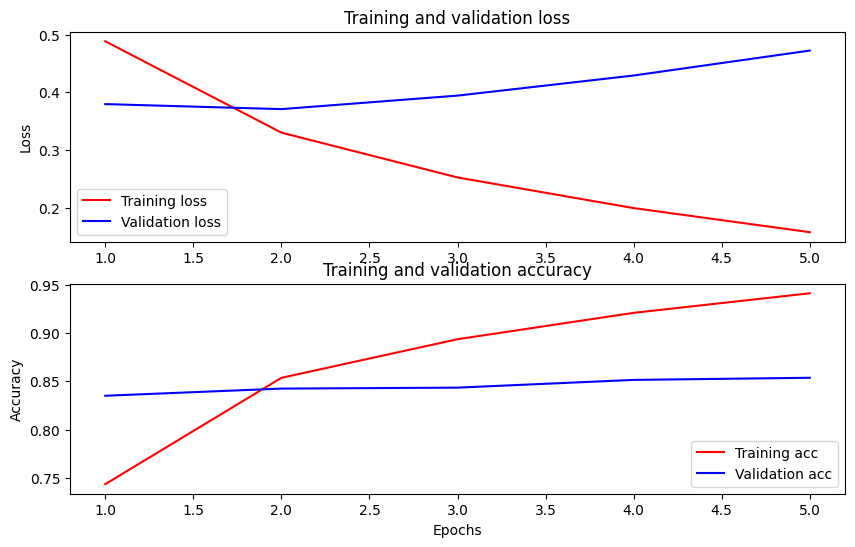

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.997565
input: The movie was great!           : score: 0.983252
input: The movie was meh.             : score: 0.986901
input: The movie was okish.           : score: 0.206568
input: The movie was terrible...      : score: 0.001724

Results from the model in memory:
input: this is such an amazing movie! : score: 0.997565
input: The movie was great!           : score: 0.983252
input: The movie was meh.             : score: 0.986901
input: The movie was okish.           : score: 0.206568
input: The movie was terrible...      : score: 0.001724



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.997565
input: The movie was great!           : score: 0.983252
input: The movie was meh.             : score: 0.986901
input: The movie was okish.           : score: 0.206568
input: The movie was terrible...      : score: 0.001724



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.